In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.nn import Module
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import math

# Введем константы из задания
#Для воспроизведения результатов
np.random.seed(42)
#Функция
func = lambda x: abs(x-2) - abs(x+2) + 5*np.sin(5*x)
#Другие константы
xmin, xmax = -10, 10
batch_size = 20

In [2]:
#построение графика функции
# dx Шаг между точками
dx = 0.01
xlist = np.arange(start = xmin, stop = xmax, step = dx)
ylist = [func(x) for x in xlist]
plt.plot(xlist, ylist)
plt.savefig('ini_func.png', bbox_inches='tight')

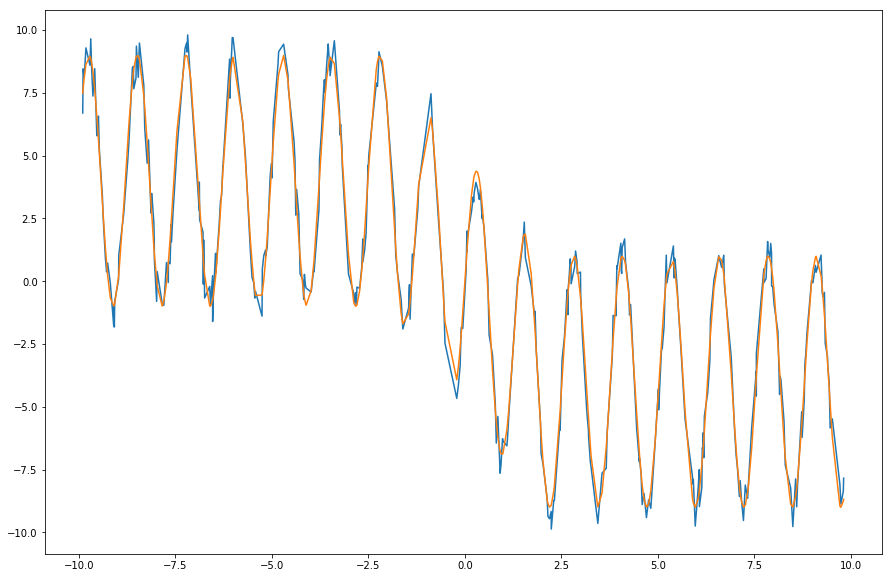

In [3]:
#Формирование исходных данных
#рандомно выберем точки на оси Х
X_data = 20 * (np.random.random(400) - 0.5)
X_data.sort()
#создадим метки на основе функции с добавлением шума
Y_data = [func(x) + 2*np.random.random(1)-1 for x in X_data]
Y_true = [func(x) for x in X_data]


plt.figure(figsize=(15,10))
plt.plot(X_data, Y_data)
plt.plot(X_data, Y_true)

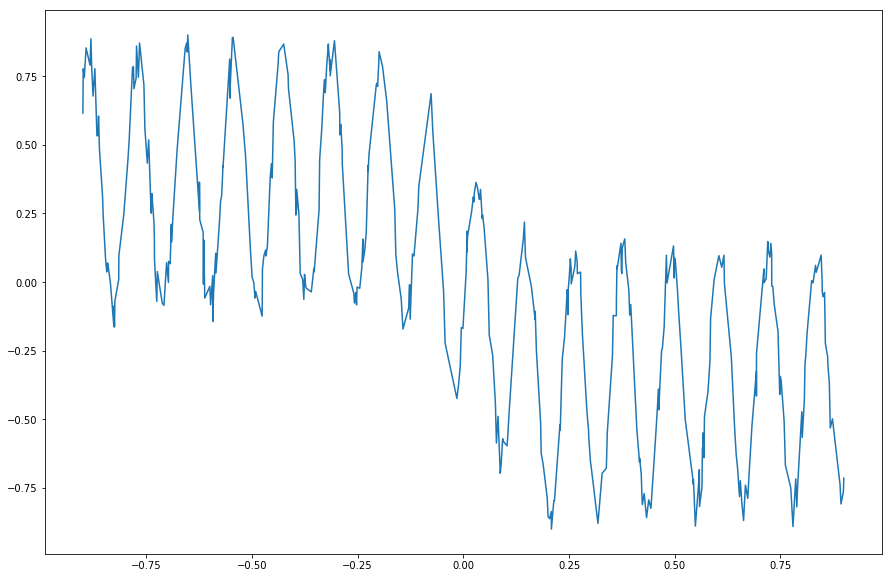

In [4]:
# Преобразование данных
# Масштабирование [-1;1]
X_data = 1.8*(X_data - min(X_data))/(max(X_data) - min(X_data)) - 0.9
Y_data = 1.8*(Y_data - min(Y_data))/(max(Y_data) - min(Y_data)) - 0.9
Y_true = 1.8*(Y_true - min(Y_true))/(max(Y_true) - min(Y_true)) - 0.9

plt.figure(figsize=(15,10))
plt.plot(X_data, Y_data)


 240 120 40


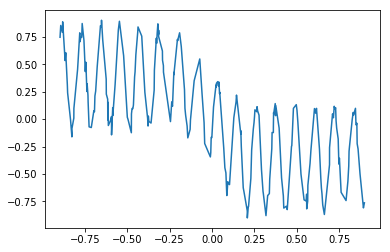

In [5]:
#перемешать данные
data = np.array(list(zip(X_data, Y_data)))
np.random.shuffle(data)

#отметим границы
train_border = [0, int(len(data)*0.6)]
valid_border = [int(len(data)*0.6), int(len(data)*0.9)]
test_border = [int(len(data)*0.9), len(data)]

#делим 
train_data = data[train_border[0]: train_border[1]]
valid_data = data[valid_border[0]: valid_border[1]]
test_data = data[test_border[0]: test_border[1]]

print('\n', len(train_data), len(valid_data), len(test_data))
df = pd.DataFrame(train_data)
df = df.sort_values(by=0)
plt.plot(df[0], df[1])


In [6]:
class SinDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [7]:
dataset = SinDataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
#Свой класс Linear
class Linear_batch(Module):
    def __init__(self, in_size, out_size, sigma):
        super(Linear_batch, self).__init__()
        self.W = Parameter(sigma * torch.randn((out_size, in_size)))
        self.b = Parameter(sigma * torch.randn(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return torch.matmul(self.x, self.W.t()) + self.b
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = torch.matmul(self.x.t(), dz)
        self.db = torch.sum(dz, 0)
        # вычисляем производную по входу
        dz = torch.matmul(dz, self.W) 
        # возвращаем dx для продолжения алгоритма
        return dz

In [9]:
class tanh(Module):
    def forward(self, x):
        self.fx = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
    
    def backward(self, dz):
        return (1 - self.fx**2)*dz

In [10]:
class Quadratic_loss(Module):
    def __init__(self):
        super(Quadratic_loss, self).__init__()
        self.er = 0
        
    def forward(self, y_pred, y_true):
        self.er = y_pred - y_true
        self.n = len(y_true)
        return self.er**2 / self.n
    
    def backward(self, dz):
        return 2/self.n * self.er

In [11]:
class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()
        self.lin1 = Linear_batch(1, 10, 2/102)
        self.tanh1 = tanh()
        self.lin2 = Linear_batch(10, 1, 2/102)
        self.tanh2 = tanh()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        x = self.lin2(x)
        x = self.tanh2(x)
        return x
    
    def backward(self, z):
        z = self.tanh2.backward(z)
        z = self.lin2.backward(z)
        z = self.tanh1.backward(z)
        z = self.lin1.backward(z)
        return z

In [12]:
net = MainNet()
net

MainNet(
  (lin1): Linear_batch(
  )
  (tanh1): tanh(
  )
  (lin2): Linear_batch(
  )
  (tanh2): tanh(
  )
)

Variable containing:
1.00000e-02 *
 -0.0972
 -0.0790
 -0.0764
 -0.0725
 -0.0664
 -0.0628
 -0.0499
 -0.0473
 -0.0458
 -0.0450
  0.0075
  0.0160
  0.0337
  0.0541
  0.0742
  0.0798
  0.0902
  0.1495
  0.1796
  0.1918
  0.1944
  0.1995
  0.1996
  0.2147
  0.2150
  0.2674
  0.2688
  0.3385
  0.3505
  0.3526
  0.3540
  0.3560
  0.3606
  0.3634
  0.3930
  0.4090
  0.4132
  0.4361
  0.4495
  0.4661
  0.4772
  0.4813
  0.4830
  0.4841
  0.4966
  0.5035
  0.5094
  0.5250
  0.5300
  0.5308
  0.5945
  0.5969
  0.6017
  0.6049
  0.6133
  0.6960
  0.6995
  0.7158
  0.7176
  0.7184
  0.7273
  0.7539
  0.7647
  0.7832
  0.8038
  0.8064
  0.8137
  0.8281
  0.8416
  0.8737
  0.8877
  0.8895
  0.8929
  0.9246
  0.9301
  0.9314
  0.9319
  0.9385
  0.9387
  0.9517
  0.9591
  0.9623
  0.9734
  1.0523
  1.0543
  1.0628
  1.1359
  1.1421
  1.1579
  1.1720
  1.1965
  1.1981
  1.2183
  1.2187
  1.2203
  1.2303
  1.2345
  1.2420
  1.2639
  1.2975
  1.3007
  1.3149
  1.3221
  1.3317
  1.3479
  1.3558
  1.3624
  

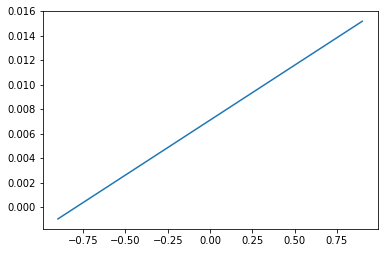

In [13]:
df_buf = pd.DataFrame(valid_data)
df_buf = df_buf.sort_values(by=0)
df_buf = df_buf.get_values()
_inputs = autograd.Variable(torch.from_numpy(df_buf[:, 0]).float()).unsqueeze(1)
net.forward(_inputs)
print(net.tanh1.fx[:, 0])
plt.plot(df_buf[:, 0], net.tanh1.fx[:, 0].data.numpy())
plt.savefig('yk_before_training.png', bbox_inches='tight')

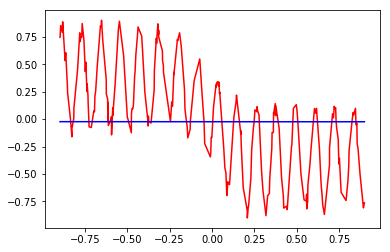

In [14]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)
plt.plot(df_buf[0], df_buf[1], 'r')
df_buf = df_buf.get_values()

x = autograd.Variable((torch.from_numpy(df_buf[:, 0]).float()).unsqueeze(1))
y_pred = net.forward(x)
x = x.data.numpy()
y_pred = y_pred.data.numpy()
plt.plot(x, y_pred, 'b')
plt.savefig('before_training.png', bbox_inches='tight')

epoh 0
epoh 1
epoh 2
epoh 3
epoh 4
epoh 5
epoh 6
epoh 7
epoh 8
epoh 9
epoh 10
epoh 11
epoh 12
epoh 13
epoh 14
epoh 15
epoh 16
epoh 17
epoh 18
epoh 19
epoh 20
epoh 21
epoh 22
epoh 23
epoh 24
epoh 25
epoh 26
epoh 27
epoh 28
epoh 29
epoh 30
epoh 31
epoh 32
epoh 33
epoh 34
epoh 35
epoh 36
epoh 37
epoh 38
epoh 39
epoh 40
epoh 41
epoh 42
epoh 43
epoh 44
epoh 45
epoh 46
epoh 47
epoh 48
epoh 49
epoh 50
epoh 51
epoh 52
epoh 53
epoh 54
epoh 55
epoh 56
epoh 57
epoh 58
epoh 59
epoh 60
epoh 61
epoh 62
epoh 63
epoh 64
epoh 65
epoh 66
epoh 67
epoh 68
epoh 69
epoh 70
epoh 71
epoh 72
epoh 73
epoh 74
epoh 75
epoh 76
epoh 77
epoh 78
epoh 79
epoh 80
epoh 81
epoh 82
epoh 83
epoh 84
epoh 85
epoh 86
epoh 87
epoh 88
epoh 89
epoh 90
epoh 91
epoh 92
epoh 93
epoh 94
epoh 95
epoh 96
epoh 97
epoh 98
epoh 99
epoh 100
epoh 101
epoh 102
epoh 103
epoh 104
epoh 105
epoh 106
epoh 107
epoh 108
epoh 109
epoh 110
epoh 111
epoh 112
epoh 113
epoh 114
epoh 115
epoh 116
epoh 117
epoh 118
epoh 119
epoh 120
epoh 121
epoh 122
epo

epoh 923
epoh 924
epoh 925
epoh 926
epoh 927
epoh 928
epoh 929
epoh 930
epoh 931
epoh 932
epoh 933
epoh 934
epoh 935
epoh 936
epoh 937
epoh 938
epoh 939
epoh 940
epoh 941
epoh 942
epoh 943
epoh 944
epoh 945
epoh 946
epoh 947
epoh 948
epoh 949
epoh 950
epoh 951
epoh 952
epoh 953
epoh 954
epoh 955
epoh 956
epoh 957
epoh 958
epoh 959
epoh 960
epoh 961
epoh 962
epoh 963
epoh 964
epoh 965
epoh 966
epoh 967
epoh 968
epoh 969
epoh 970
epoh 971
epoh 972
epoh 973
epoh 974
epoh 975
epoh 976
epoh 977
epoh 978
epoh 979
epoh 980
epoh 981
epoh 982
epoh 983
epoh 984
epoh 985
epoh 986
epoh 987
epoh 988
epoh 989
epoh 990
epoh 991
epoh 992
epoh 993
epoh 994
epoh 995
epoh 996
epoh 997
epoh 998
epoh 999
epoh 1000
epoh 1001
epoh 1002
epoh 1003
epoh 1004
epoh 1005
epoh 1006
epoh 1007
epoh 1008
epoh 1009
epoh 1010
epoh 1011
epoh 1012
epoh 1013
epoh 1014
epoh 1015
epoh 1016
epoh 1017
epoh 1018
epoh 1019
epoh 1020
epoh 1021
epoh 1022
epoh 1023
epoh 1024
epoh 1025
epoh 1026
epoh 1027
epoh 1028
epoh 1029
epoh 10

epoh 1756
epoh 1757
epoh 1758
epoh 1759
epoh 1760
epoh 1761
epoh 1762
epoh 1763
epoh 1764
epoh 1765
epoh 1766
epoh 1767
epoh 1768
epoh 1769
epoh 1770
epoh 1771
epoh 1772
epoh 1773
epoh 1774
epoh 1775
epoh 1776
epoh 1777
epoh 1778
epoh 1779
epoh 1780
epoh 1781
epoh 1782
epoh 1783
epoh 1784
epoh 1785
epoh 1786
epoh 1787
epoh 1788
epoh 1789
epoh 1790
epoh 1791
epoh 1792
epoh 1793
epoh 1794
epoh 1795
epoh 1796
epoh 1797
epoh 1798
epoh 1799
epoh 1800
epoh 1801
epoh 1802
epoh 1803
epoh 1804
epoh 1805
epoh 1806
epoh 1807
epoh 1808
epoh 1809
epoh 1810
epoh 1811
epoh 1812
epoh 1813
epoh 1814
epoh 1815
epoh 1816
epoh 1817
epoh 1818
epoh 1819
epoh 1820
epoh 1821
epoh 1822
epoh 1823
epoh 1824
epoh 1825
epoh 1826
epoh 1827
epoh 1828
epoh 1829
epoh 1830
epoh 1831
epoh 1832
epoh 1833
epoh 1834
epoh 1835
epoh 1836
epoh 1837
epoh 1838
epoh 1839
epoh 1840
epoh 1841
epoh 1842
epoh 1843
epoh 1844
epoh 1845
epoh 1846
epoh 1847
epoh 1848
epoh 1849
epoh 1850
epoh 1851
epoh 1852
epoh 1853
epoh 1854
epoh 1855


epoh 2578
epoh 2579
epoh 2580
epoh 2581
epoh 2582
epoh 2583
epoh 2584
epoh 2585
epoh 2586
epoh 2587
epoh 2588
epoh 2589
epoh 2590
epoh 2591
epoh 2592
epoh 2593
epoh 2594
epoh 2595
epoh 2596
epoh 2597
epoh 2598
epoh 2599
epoh 2600
epoh 2601
epoh 2602
epoh 2603
epoh 2604
epoh 2605
epoh 2606
epoh 2607
epoh 2608
epoh 2609
epoh 2610
epoh 2611
epoh 2612
epoh 2613
epoh 2614
epoh 2615
epoh 2616
epoh 2617
epoh 2618
epoh 2619
epoh 2620
epoh 2621
epoh 2622
epoh 2623
epoh 2624
epoh 2625
epoh 2626
epoh 2627
epoh 2628
epoh 2629
epoh 2630
epoh 2631
epoh 2632
epoh 2633
epoh 2634
epoh 2635
epoh 2636
epoh 2637
epoh 2638
epoh 2639
epoh 2640
epoh 2641
epoh 2642
epoh 2643
epoh 2644
epoh 2645
epoh 2646
epoh 2647
epoh 2648
epoh 2649
epoh 2650
epoh 2651
epoh 2652
epoh 2653
epoh 2654
epoh 2655
epoh 2656
epoh 2657
epoh 2658
epoh 2659
epoh 2660
epoh 2661
epoh 2662
epoh 2663
epoh 2664
epoh 2665
epoh 2666
epoh 2667
epoh 2668
epoh 2669
epoh 2670
epoh 2671
epoh 2672
epoh 2673
epoh 2674
epoh 2675
epoh 2676
epoh 2677


epoh 3405
epoh 3406
epoh 3407
epoh 3408
epoh 3409
epoh 3410
epoh 3411
epoh 3412
epoh 3413
epoh 3414
epoh 3415
epoh 3416
epoh 3417
epoh 3418
epoh 3419
epoh 3420
epoh 3421
epoh 3422
epoh 3423
epoh 3424
epoh 3425
epoh 3426
epoh 3427
epoh 3428
epoh 3429
epoh 3430
epoh 3431
epoh 3432
epoh 3433
epoh 3434
epoh 3435
epoh 3436
epoh 3437
epoh 3438
epoh 3439
epoh 3440
epoh 3441
epoh 3442
epoh 3443
epoh 3444
epoh 3445
epoh 3446
epoh 3447
epoh 3448
epoh 3449
epoh 3450
epoh 3451
epoh 3452
epoh 3453
epoh 3454
epoh 3455
epoh 3456
epoh 3457
epoh 3458
epoh 3459
epoh 3460
epoh 3461
epoh 3462
epoh 3463
epoh 3464
epoh 3465
epoh 3466
epoh 3467
epoh 3468
epoh 3469
epoh 3470
epoh 3471
epoh 3472
epoh 3473
epoh 3474
epoh 3475
epoh 3476
epoh 3477
epoh 3478
epoh 3479
epoh 3480
epoh 3481
epoh 3482
epoh 3483
epoh 3484
epoh 3485
epoh 3486
epoh 3487
epoh 3488
epoh 3489
epoh 3490
epoh 3491
epoh 3492
epoh 3493
epoh 3494
epoh 3495
epoh 3496
epoh 3497
epoh 3498
epoh 3499
epoh 3500
epoh 3501
epoh 3502
epoh 3503
epoh 3504


epoh 4227
epoh 4228
epoh 4229
epoh 4230
epoh 4231
epoh 4232
epoh 4233
epoh 4234
epoh 4235
epoh 4236
epoh 4237
epoh 4238
epoh 4239
epoh 4240
epoh 4241
epoh 4242
epoh 4243
epoh 4244
epoh 4245
epoh 4246
epoh 4247
epoh 4248
epoh 4249
epoh 4250
epoh 4251
epoh 4252
epoh 4253
epoh 4254
epoh 4255
epoh 4256
epoh 4257
epoh 4258
epoh 4259
epoh 4260
epoh 4261
epoh 4262
epoh 4263
epoh 4264
epoh 4265
epoh 4266
epoh 4267
epoh 4268
epoh 4269
epoh 4270
epoh 4271
epoh 4272
epoh 4273
epoh 4274
epoh 4275
epoh 4276
epoh 4277
epoh 4278
epoh 4279
epoh 4280
epoh 4281
epoh 4282
epoh 4283
epoh 4284
epoh 4285
epoh 4286
epoh 4287
epoh 4288
epoh 4289
epoh 4290
epoh 4291
epoh 4292
epoh 4293
epoh 4294
epoh 4295
epoh 4296
epoh 4297
epoh 4298
epoh 4299
epoh 4300
epoh 4301
epoh 4302
epoh 4303
epoh 4304
epoh 4305
epoh 4306
epoh 4307
epoh 4308
epoh 4309
epoh 4310
epoh 4311
epoh 4312
epoh 4313
epoh 4314
epoh 4315
epoh 4316
epoh 4317
epoh 4318
epoh 4319
epoh 4320
epoh 4321
epoh 4322
epoh 4323
epoh 4324
epoh 4325
epoh 4326


epoh 5055
epoh 5056
epoh 5057
epoh 5058
epoh 5059
epoh 5060
epoh 5061
epoh 5062
epoh 5063
epoh 5064
epoh 5065
epoh 5066
epoh 5067
epoh 5068
epoh 5069
epoh 5070
epoh 5071
epoh 5072
epoh 5073
epoh 5074
epoh 5075
epoh 5076
epoh 5077
epoh 5078
epoh 5079
epoh 5080
epoh 5081
epoh 5082
epoh 5083
epoh 5084
epoh 5085
epoh 5086
epoh 5087
epoh 5088
epoh 5089
epoh 5090
epoh 5091
epoh 5092
epoh 5093
epoh 5094
epoh 5095
epoh 5096
epoh 5097
epoh 5098
epoh 5099
epoh 5100
epoh 5101
epoh 5102
epoh 5103
epoh 5104
epoh 5105
epoh 5106
epoh 5107
epoh 5108
epoh 5109
epoh 5110
epoh 5111
epoh 5112
epoh 5113
epoh 5114
epoh 5115
epoh 5116
epoh 5117
epoh 5118
epoh 5119
epoh 5120
epoh 5121
epoh 5122
epoh 5123
epoh 5124
epoh 5125
epoh 5126
epoh 5127
epoh 5128
epoh 5129
epoh 5130
epoh 5131
epoh 5132
epoh 5133
epoh 5134
epoh 5135
epoh 5136
epoh 5137
epoh 5138
epoh 5139
epoh 5140
epoh 5141
epoh 5142
epoh 5143
epoh 5144
epoh 5145
epoh 5146
epoh 5147
epoh 5148
epoh 5149
epoh 5150
epoh 5151
epoh 5152
epoh 5153
epoh 5154


epoh 5875
epoh 5876
epoh 5877
epoh 5878
epoh 5879
epoh 5880
epoh 5881
epoh 5882
epoh 5883
epoh 5884
epoh 5885
epoh 5886
epoh 5887
epoh 5888
epoh 5889
epoh 5890
epoh 5891
epoh 5892
epoh 5893
epoh 5894
epoh 5895
epoh 5896
epoh 5897
epoh 5898
epoh 5899
epoh 5900
epoh 5901
epoh 5902
epoh 5903
epoh 5904
epoh 5905
epoh 5906
epoh 5907
epoh 5908
epoh 5909
epoh 5910
epoh 5911
epoh 5912
epoh 5913
epoh 5914
epoh 5915
epoh 5916
epoh 5917
epoh 5918
epoh 5919
epoh 5920
epoh 5921
epoh 5922
epoh 5923
epoh 5924
epoh 5925
epoh 5926
epoh 5927
epoh 5928
epoh 5929
epoh 5930
epoh 5931
epoh 5932
epoh 5933
epoh 5934
epoh 5935
epoh 5936
epoh 5937
epoh 5938
epoh 5939
epoh 5940
epoh 5941
epoh 5942
epoh 5943
epoh 5944
epoh 5945
epoh 5946
epoh 5947
epoh 5948
epoh 5949
epoh 5950
epoh 5951
epoh 5952
epoh 5953
epoh 5954
epoh 5955
epoh 5956
epoh 5957
epoh 5958
epoh 5959
epoh 5960
epoh 5961
epoh 5962
epoh 5963
epoh 5964
epoh 5965
epoh 5966
epoh 5967
epoh 5968
epoh 5969
epoh 5970
epoh 5971
epoh 5972
epoh 5973
epoh 5974


epoh 6696
epoh 6697
epoh 6698
epoh 6699
epoh 6700
epoh 6701
epoh 6702
epoh 6703
epoh 6704
epoh 6705
epoh 6706
epoh 6707
epoh 6708
epoh 6709
epoh 6710
epoh 6711
epoh 6712
epoh 6713
epoh 6714
epoh 6715
epoh 6716
epoh 6717
epoh 6718
epoh 6719
epoh 6720
epoh 6721
epoh 6722
epoh 6723
epoh 6724
epoh 6725
epoh 6726
epoh 6727
epoh 6728
epoh 6729
epoh 6730
epoh 6731
epoh 6732
epoh 6733
epoh 6734
epoh 6735
epoh 6736
epoh 6737
epoh 6738
epoh 6739
epoh 6740
epoh 6741
epoh 6742
epoh 6743
epoh 6744
epoh 6745
epoh 6746
epoh 6747
epoh 6748
epoh 6749
epoh 6750
epoh 6751
epoh 6752
epoh 6753
epoh 6754
epoh 6755
epoh 6756
epoh 6757
epoh 6758
epoh 6759
epoh 6760
epoh 6761
epoh 6762
epoh 6763
epoh 6764
epoh 6765
epoh 6766
epoh 6767
epoh 6768
epoh 6769
epoh 6770
epoh 6771
epoh 6772
epoh 6773
epoh 6774
epoh 6775
epoh 6776
epoh 6777
epoh 6778
epoh 6779
epoh 6780
epoh 6781
epoh 6782
epoh 6783
epoh 6784
epoh 6785
epoh 6786
epoh 6787
epoh 6788
epoh 6789
epoh 6790
epoh 6791
epoh 6792
epoh 6793
epoh 6794
epoh 6795


epoh 7518
epoh 7519
epoh 7520
epoh 7521
epoh 7522
epoh 7523
epoh 7524
epoh 7525
epoh 7526
epoh 7527
epoh 7528
epoh 7529
epoh 7530
epoh 7531
epoh 7532
epoh 7533
epoh 7534
epoh 7535
epoh 7536
epoh 7537
epoh 7538
epoh 7539
epoh 7540
epoh 7541
epoh 7542
epoh 7543
epoh 7544
epoh 7545
epoh 7546
epoh 7547
epoh 7548
epoh 7549
epoh 7550
epoh 7551
epoh 7552
epoh 7553
epoh 7554
epoh 7555
epoh 7556
epoh 7557
epoh 7558
epoh 7559
epoh 7560
epoh 7561
epoh 7562
epoh 7563
epoh 7564
epoh 7565
epoh 7566
epoh 7567
epoh 7568
epoh 7569
epoh 7570
epoh 7571
epoh 7572
epoh 7573
epoh 7574
epoh 7575
epoh 7576
epoh 7577
epoh 7578
epoh 7579
epoh 7580
epoh 7581
epoh 7582
epoh 7583
epoh 7584
epoh 7585
epoh 7586
epoh 7587
epoh 7588
epoh 7589
epoh 7590
epoh 7591
epoh 7592
epoh 7593
epoh 7594
epoh 7595
epoh 7596
epoh 7597
epoh 7598
epoh 7599
epoh 7600
epoh 7601
epoh 7602
epoh 7603
epoh 7604
epoh 7605
epoh 7606
epoh 7607
epoh 7608
epoh 7609
epoh 7610
epoh 7611
epoh 7612
epoh 7613
epoh 7614
epoh 7615
epoh 7616
epoh 7617


epoh 8341
epoh 8342
epoh 8343
epoh 8344
epoh 8345
epoh 8346
epoh 8347
epoh 8348
epoh 8349
epoh 8350
epoh 8351
epoh 8352
epoh 8353
epoh 8354
epoh 8355
epoh 8356
epoh 8357
epoh 8358
epoh 8359
epoh 8360
epoh 8361
epoh 8362
epoh 8363
epoh 8364
epoh 8365
epoh 8366
epoh 8367
epoh 8368
epoh 8369
epoh 8370
epoh 8371
epoh 8372
epoh 8373
epoh 8374
epoh 8375
epoh 8376
epoh 8377
epoh 8378
epoh 8379
epoh 8380
epoh 8381
epoh 8382
epoh 8383
epoh 8384
epoh 8385
epoh 8386
epoh 8387
epoh 8388
epoh 8389
epoh 8390
epoh 8391
epoh 8392
epoh 8393
epoh 8394
epoh 8395
epoh 8396
epoh 8397
epoh 8398
epoh 8399
epoh 8400
epoh 8401
epoh 8402
epoh 8403
epoh 8404
epoh 8405
epoh 8406
epoh 8407
epoh 8408
epoh 8409
epoh 8410
epoh 8411
epoh 8412
epoh 8413
epoh 8414
epoh 8415
epoh 8416
epoh 8417
epoh 8418
epoh 8419
epoh 8420
epoh 8421
epoh 8422
epoh 8423
epoh 8424
epoh 8425
epoh 8426
epoh 8427
epoh 8428
epoh 8429
epoh 8430
epoh 8431
epoh 8432
epoh 8433
epoh 8434
epoh 8435
epoh 8436
epoh 8437
epoh 8438
epoh 8439
epoh 8440


epoh 9169
epoh 9170
epoh 9171
epoh 9172
epoh 9173
epoh 9174
epoh 9175
epoh 9176
epoh 9177
epoh 9178
epoh 9179
epoh 9180
epoh 9181
epoh 9182
epoh 9183
epoh 9184
epoh 9185
epoh 9186
epoh 9187
epoh 9188
epoh 9189
epoh 9190
epoh 9191
epoh 9192
epoh 9193
epoh 9194
epoh 9195
epoh 9196
epoh 9197
epoh 9198
epoh 9199
epoh 9200
epoh 9201
epoh 9202
epoh 9203
epoh 9204
epoh 9205
epoh 9206
epoh 9207
epoh 9208
epoh 9209
epoh 9210
epoh 9211
epoh 9212
epoh 9213
epoh 9214
epoh 9215
epoh 9216
epoh 9217
epoh 9218
epoh 9219
epoh 9220
epoh 9221
epoh 9222
epoh 9223
epoh 9224
epoh 9225
epoh 9226
epoh 9227
epoh 9228
epoh 9229
epoh 9230
epoh 9231
epoh 9232
epoh 9233
epoh 9234
epoh 9235
epoh 9236
epoh 9237
epoh 9238
epoh 9239
epoh 9240
epoh 9241
epoh 9242
epoh 9243
epoh 9244
epoh 9245
epoh 9246
epoh 9247
epoh 9248
epoh 9249
epoh 9250
epoh 9251
epoh 9252
epoh 9253
epoh 9254
epoh 9255
epoh 9256
epoh 9257
epoh 9258
epoh 9259
epoh 9260
epoh 9261
epoh 9262
epoh 9263
epoh 9264
epoh 9265
epoh 9266
epoh 9267
epoh 9268


epoh 9989
epoh 9990
epoh 9991
epoh 9992
epoh 9993
epoh 9994
epoh 9995
epoh 9996
epoh 9997
epoh 9998
epoh 9999
epoh 10000
epoh 10001
epoh 10002
epoh 10003
epoh 10004
epoh 10005
epoh 10006
epoh 10007
epoh 10008
epoh 10009
epoh 10010
epoh 10011
epoh 10012
epoh 10013
epoh 10014
epoh 10015
epoh 10016
epoh 10017
epoh 10018
epoh 10019
epoh 10020
epoh 10021
epoh 10022
epoh 10023
epoh 10024
epoh 10025
epoh 10026
epoh 10027
epoh 10028
epoh 10029
epoh 10030
epoh 10031
epoh 10032
epoh 10033
epoh 10034
epoh 10035
epoh 10036
epoh 10037
epoh 10038
epoh 10039
epoh 10040
epoh 10041
epoh 10042
epoh 10043
epoh 10044
epoh 10045
epoh 10046
epoh 10047
epoh 10048
epoh 10049
epoh 10050
epoh 10051
epoh 10052
epoh 10053
epoh 10054
epoh 10055
epoh 10056
epoh 10057
epoh 10058
epoh 10059
epoh 10060
epoh 10061
epoh 10062
epoh 10063
epoh 10064
epoh 10065
epoh 10066
epoh 10067
epoh 10068
epoh 10069
epoh 10070
epoh 10071
epoh 10072
epoh 10073
epoh 10074
epoh 10075
epoh 10076
epoh 10077
epoh 10078
epoh 10079
epoh 10080

epoh 10744
epoh 10745
epoh 10746
epoh 10747
epoh 10748
epoh 10749
epoh 10750
epoh 10751
epoh 10752
epoh 10753
epoh 10754
epoh 10755
epoh 10756
epoh 10757
epoh 10758
epoh 10759
epoh 10760
epoh 10761
epoh 10762
epoh 10763
epoh 10764
epoh 10765
epoh 10766
epoh 10767
epoh 10768
epoh 10769
epoh 10770
epoh 10771
epoh 10772
epoh 10773
epoh 10774
epoh 10775
epoh 10776
epoh 10777
epoh 10778
epoh 10779
epoh 10780
epoh 10781
epoh 10782
epoh 10783
epoh 10784
epoh 10785
epoh 10786
epoh 10787
epoh 10788
epoh 10789
epoh 10790
epoh 10791
epoh 10792
epoh 10793
epoh 10794
epoh 10795
epoh 10796
epoh 10797
epoh 10798
epoh 10799
epoh 10800
epoh 10801
epoh 10802
epoh 10803
epoh 10804
epoh 10805
epoh 10806
epoh 10807
epoh 10808
epoh 10809
epoh 10810
epoh 10811
epoh 10812
epoh 10813
epoh 10814
epoh 10815
epoh 10816
epoh 10817
epoh 10818
epoh 10819
epoh 10820
epoh 10821
epoh 10822
epoh 10823
epoh 10824
epoh 10825
epoh 10826
epoh 10827
epoh 10828
epoh 10829
epoh 10830
epoh 10831
epoh 10832
epoh 10833
epoh 10834

epoh 11495
epoh 11496
epoh 11497
epoh 11498
epoh 11499
epoh 11500
epoh 11501
epoh 11502
epoh 11503
epoh 11504
epoh 11505
epoh 11506
epoh 11507
epoh 11508
epoh 11509
epoh 11510
epoh 11511
epoh 11512
epoh 11513
epoh 11514
epoh 11515
epoh 11516
epoh 11517
epoh 11518
epoh 11519
epoh 11520
epoh 11521
epoh 11522
epoh 11523
epoh 11524
epoh 11525
epoh 11526
epoh 11527
epoh 11528
epoh 11529
epoh 11530
epoh 11531
epoh 11532
epoh 11533
epoh 11534
epoh 11535
epoh 11536
epoh 11537
epoh 11538
epoh 11539
epoh 11540
epoh 11541
epoh 11542
epoh 11543
epoh 11544
epoh 11545
epoh 11546
epoh 11547
epoh 11548
epoh 11549
epoh 11550
epoh 11551
epoh 11552
epoh 11553
epoh 11554
epoh 11555
epoh 11556
epoh 11557
epoh 11558
epoh 11559
epoh 11560
epoh 11561
epoh 11562
epoh 11563
epoh 11564
epoh 11565
epoh 11566
epoh 11567
epoh 11568
epoh 11569
epoh 11570
epoh 11571
epoh 11572
epoh 11573
epoh 11574
epoh 11575
epoh 11576
epoh 11577
epoh 11578
epoh 11579
epoh 11580
epoh 11581
epoh 11582
epoh 11583
epoh 11584
epoh 11585

epoh 12249
epoh 12250
epoh 12251
epoh 12252
epoh 12253
epoh 12254
epoh 12255
epoh 12256
epoh 12257
epoh 12258
epoh 12259
epoh 12260
epoh 12261
epoh 12262
epoh 12263
epoh 12264
epoh 12265
epoh 12266
epoh 12267
epoh 12268
epoh 12269
epoh 12270
epoh 12271
epoh 12272
epoh 12273
epoh 12274
epoh 12275
epoh 12276
epoh 12277
epoh 12278
epoh 12279
epoh 12280
epoh 12281
epoh 12282
epoh 12283
epoh 12284
epoh 12285
epoh 12286
epoh 12287
epoh 12288
epoh 12289
epoh 12290
epoh 12291
epoh 12292
epoh 12293
epoh 12294
epoh 12295
epoh 12296
epoh 12297
epoh 12298
epoh 12299
epoh 12300
epoh 12301
epoh 12302
epoh 12303
epoh 12304
epoh 12305
epoh 12306
epoh 12307
epoh 12308
epoh 12309
epoh 12310
epoh 12311
epoh 12312
epoh 12313
epoh 12314
epoh 12315
epoh 12316
epoh 12317
epoh 12318
epoh 12319
epoh 12320
epoh 12321
epoh 12322
epoh 12323
epoh 12324
epoh 12325
epoh 12326
epoh 12327
epoh 12328
epoh 12329
epoh 12330
epoh 12331
epoh 12332
epoh 12333
epoh 12334
epoh 12335
epoh 12336
epoh 12337
epoh 12338
epoh 12339

epoh 12994
epoh 12995
epoh 12996
epoh 12997
epoh 12998
epoh 12999
epoh 13000
epoh 13001
epoh 13002
epoh 13003
epoh 13004
epoh 13005
epoh 13006
epoh 13007
epoh 13008
epoh 13009
epoh 13010
epoh 13011
epoh 13012
epoh 13013
epoh 13014
epoh 13015
epoh 13016
epoh 13017
epoh 13018
epoh 13019
epoh 13020
epoh 13021
epoh 13022
epoh 13023
epoh 13024
epoh 13025
epoh 13026
epoh 13027
epoh 13028
epoh 13029
epoh 13030
epoh 13031
epoh 13032
epoh 13033
epoh 13034
epoh 13035
epoh 13036
epoh 13037
epoh 13038
epoh 13039
epoh 13040
epoh 13041
epoh 13042
epoh 13043
epoh 13044
epoh 13045
epoh 13046
epoh 13047
epoh 13048
epoh 13049
epoh 13050
epoh 13051
epoh 13052
epoh 13053
epoh 13054
epoh 13055
epoh 13056
epoh 13057
epoh 13058
epoh 13059
epoh 13060
epoh 13061
epoh 13062
epoh 13063
epoh 13064
epoh 13065
epoh 13066
epoh 13067
epoh 13068
epoh 13069
epoh 13070
epoh 13071
epoh 13072
epoh 13073
epoh 13074
epoh 13075
epoh 13076
epoh 13077
epoh 13078
epoh 13079
epoh 13080
epoh 13081
epoh 13082
epoh 13083
epoh 13084

epoh 13747
epoh 13748
epoh 13749
epoh 13750
epoh 13751
epoh 13752
epoh 13753
epoh 13754
epoh 13755
epoh 13756
epoh 13757
epoh 13758
epoh 13759
epoh 13760
epoh 13761
epoh 13762
epoh 13763
epoh 13764
epoh 13765
epoh 13766
epoh 13767
epoh 13768
epoh 13769
epoh 13770
epoh 13771
epoh 13772
epoh 13773
epoh 13774
epoh 13775
epoh 13776
epoh 13777
epoh 13778
epoh 13779
epoh 13780
epoh 13781
epoh 13782
epoh 13783
epoh 13784
epoh 13785
epoh 13786
epoh 13787
epoh 13788
epoh 13789
epoh 13790
epoh 13791
epoh 13792
epoh 13793
epoh 13794
epoh 13795
epoh 13796
epoh 13797
epoh 13798
epoh 13799
epoh 13800
epoh 13801
epoh 13802
epoh 13803
epoh 13804
epoh 13805
epoh 13806
epoh 13807
epoh 13808
epoh 13809
epoh 13810
epoh 13811
epoh 13812
epoh 13813
epoh 13814
epoh 13815
epoh 13816
epoh 13817
epoh 13818
epoh 13819
epoh 13820
epoh 13821
epoh 13822
epoh 13823
epoh 13824
epoh 13825
epoh 13826
epoh 13827
epoh 13828
epoh 13829
epoh 13830
epoh 13831
epoh 13832
epoh 13833
epoh 13834
epoh 13835
epoh 13836
epoh 13837

epoh 14499
epoh 14500
epoh 14501
epoh 14502
epoh 14503
epoh 14504
epoh 14505
epoh 14506
epoh 14507
epoh 14508
epoh 14509
epoh 14510
epoh 14511
epoh 14512
epoh 14513
epoh 14514
epoh 14515
epoh 14516
epoh 14517
epoh 14518
epoh 14519
epoh 14520
epoh 14521
epoh 14522
epoh 14523
epoh 14524
epoh 14525
epoh 14526
epoh 14527
epoh 14528
epoh 14529
epoh 14530
epoh 14531
epoh 14532
epoh 14533
epoh 14534
epoh 14535
epoh 14536
epoh 14537
epoh 14538
epoh 14539
epoh 14540
epoh 14541
epoh 14542
epoh 14543
epoh 14544
epoh 14545
epoh 14546
epoh 14547
epoh 14548
epoh 14549
epoh 14550
epoh 14551
epoh 14552
epoh 14553
epoh 14554
epoh 14555
epoh 14556
epoh 14557
epoh 14558
epoh 14559
epoh 14560
epoh 14561
epoh 14562
epoh 14563
epoh 14564
epoh 14565
epoh 14566
epoh 14567
epoh 14568
epoh 14569
epoh 14570
epoh 14571
epoh 14572
epoh 14573
epoh 14574
epoh 14575
epoh 14576
epoh 14577
epoh 14578
epoh 14579
epoh 14580
epoh 14581
epoh 14582
epoh 14583
epoh 14584
epoh 14585
epoh 14586
epoh 14587
epoh 14588
epoh 14589

epoh 15252
epoh 15253
epoh 15254
epoh 15255
epoh 15256
epoh 15257
epoh 15258
epoh 15259
epoh 15260
epoh 15261
epoh 15262
epoh 15263
epoh 15264
epoh 15265
epoh 15266
epoh 15267
epoh 15268
epoh 15269
epoh 15270
epoh 15271
epoh 15272
epoh 15273
epoh 15274
epoh 15275
epoh 15276
epoh 15277
epoh 15278
epoh 15279
epoh 15280
epoh 15281
epoh 15282
epoh 15283
epoh 15284
epoh 15285
epoh 15286
epoh 15287
epoh 15288
epoh 15289
epoh 15290
epoh 15291
epoh 15292
epoh 15293
epoh 15294
epoh 15295
epoh 15296
epoh 15297
epoh 15298
epoh 15299
epoh 15300
epoh 15301
epoh 15302
epoh 15303
epoh 15304
epoh 15305
epoh 15306
epoh 15307
epoh 15308
epoh 15309
epoh 15310
epoh 15311
epoh 15312
epoh 15313
epoh 15314
epoh 15315
epoh 15316
epoh 15317
epoh 15318
epoh 15319
epoh 15320
epoh 15321
epoh 15322
epoh 15323
epoh 15324
epoh 15325
epoh 15326
epoh 15327
epoh 15328
epoh 15329
epoh 15330
epoh 15331
epoh 15332
epoh 15333
epoh 15334
epoh 15335
epoh 15336
epoh 15337
epoh 15338
epoh 15339
epoh 15340
epoh 15341
epoh 15342

epoh 16003
epoh 16004
epoh 16005
epoh 16006
epoh 16007
epoh 16008
epoh 16009
epoh 16010
epoh 16011
epoh 16012
epoh 16013
epoh 16014
epoh 16015
epoh 16016
epoh 16017
epoh 16018
epoh 16019
epoh 16020
epoh 16021
epoh 16022
epoh 16023
epoh 16024
epoh 16025
epoh 16026
epoh 16027
epoh 16028
epoh 16029
epoh 16030
epoh 16031
epoh 16032
epoh 16033
epoh 16034
epoh 16035
epoh 16036
epoh 16037
epoh 16038
epoh 16039
epoh 16040
epoh 16041
epoh 16042
epoh 16043
epoh 16044
epoh 16045
epoh 16046
epoh 16047
epoh 16048
epoh 16049
epoh 16050
epoh 16051
epoh 16052
epoh 16053
epoh 16054
epoh 16055
epoh 16056
epoh 16057
epoh 16058
epoh 16059
epoh 16060
epoh 16061
epoh 16062
epoh 16063
epoh 16064
epoh 16065
epoh 16066
epoh 16067
epoh 16068
epoh 16069
epoh 16070
epoh 16071
epoh 16072
epoh 16073
epoh 16074
epoh 16075
epoh 16076
epoh 16077
epoh 16078
epoh 16079
epoh 16080
epoh 16081
epoh 16082
epoh 16083
epoh 16084
epoh 16085
epoh 16086
epoh 16087
epoh 16088
epoh 16089
epoh 16090
epoh 16091
epoh 16092
epoh 16093

epoh 16748
epoh 16749
epoh 16750
epoh 16751
epoh 16752
epoh 16753
epoh 16754
epoh 16755
epoh 16756
epoh 16757
epoh 16758
epoh 16759
epoh 16760
epoh 16761
epoh 16762
epoh 16763
epoh 16764
epoh 16765
epoh 16766
epoh 16767
epoh 16768
epoh 16769
epoh 16770
epoh 16771
epoh 16772
epoh 16773
epoh 16774
epoh 16775
epoh 16776
epoh 16777
epoh 16778
epoh 16779
epoh 16780
epoh 16781
epoh 16782
epoh 16783
epoh 16784
epoh 16785
epoh 16786
epoh 16787
epoh 16788
epoh 16789
epoh 16790
epoh 16791
epoh 16792
epoh 16793
epoh 16794
epoh 16795
epoh 16796
epoh 16797
epoh 16798
epoh 16799
epoh 16800
epoh 16801
epoh 16802
epoh 16803
epoh 16804
epoh 16805
epoh 16806
epoh 16807
epoh 16808
epoh 16809
epoh 16810
epoh 16811
epoh 16812
epoh 16813
epoh 16814
epoh 16815
epoh 16816
epoh 16817
epoh 16818
epoh 16819
epoh 16820
epoh 16821
epoh 16822
epoh 16823
epoh 16824
epoh 16825
epoh 16826
epoh 16827
epoh 16828
epoh 16829
epoh 16830
epoh 16831
epoh 16832
epoh 16833
epoh 16834
epoh 16835
epoh 16836
epoh 16837
epoh 16838

epoh 17498
epoh 17499
epoh 17500
epoh 17501
epoh 17502
epoh 17503
epoh 17504
epoh 17505
epoh 17506
epoh 17507
epoh 17508
epoh 17509
epoh 17510
epoh 17511
epoh 17512
epoh 17513
epoh 17514
epoh 17515
epoh 17516
epoh 17517
epoh 17518
epoh 17519
epoh 17520
epoh 17521
epoh 17522
epoh 17523
epoh 17524
epoh 17525
epoh 17526
epoh 17527
epoh 17528
epoh 17529
epoh 17530
epoh 17531
epoh 17532
epoh 17533
epoh 17534
epoh 17535
epoh 17536
epoh 17537
epoh 17538
epoh 17539
epoh 17540
epoh 17541
epoh 17542
epoh 17543
epoh 17544
epoh 17545
epoh 17546
epoh 17547
epoh 17548
epoh 17549
epoh 17550
epoh 17551
epoh 17552
epoh 17553
epoh 17554
epoh 17555
epoh 17556
epoh 17557
epoh 17558
epoh 17559
epoh 17560
epoh 17561
epoh 17562
epoh 17563
epoh 17564
epoh 17565
epoh 17566
epoh 17567
epoh 17568
epoh 17569
epoh 17570
epoh 17571
epoh 17572
epoh 17573
epoh 17574
epoh 17575
epoh 17576
epoh 17577
epoh 17578
epoh 17579
epoh 17580
epoh 17581
epoh 17582
epoh 17583
epoh 17584
epoh 17585
epoh 17586
epoh 17587
epoh 17588

epoh 18244
epoh 18245
epoh 18246
epoh 18247
epoh 18248
epoh 18249
epoh 18250
epoh 18251
epoh 18252
epoh 18253
epoh 18254
epoh 18255
epoh 18256
epoh 18257
epoh 18258
epoh 18259
epoh 18260
epoh 18261
epoh 18262
epoh 18263
epoh 18264
epoh 18265
epoh 18266
epoh 18267
epoh 18268
epoh 18269
epoh 18270
epoh 18271
epoh 18272
epoh 18273
epoh 18274
epoh 18275
epoh 18276
epoh 18277
epoh 18278
epoh 18279
epoh 18280
epoh 18281
epoh 18282
epoh 18283
epoh 18284
epoh 18285
epoh 18286
epoh 18287
epoh 18288
epoh 18289
epoh 18290
epoh 18291
epoh 18292
epoh 18293
epoh 18294
epoh 18295
epoh 18296
epoh 18297
epoh 18298
epoh 18299
epoh 18300
epoh 18301
epoh 18302
epoh 18303
epoh 18304
epoh 18305
epoh 18306
epoh 18307
epoh 18308
epoh 18309
epoh 18310
epoh 18311
epoh 18312
epoh 18313
epoh 18314
epoh 18315
epoh 18316
epoh 18317
epoh 18318
epoh 18319
epoh 18320
epoh 18321
epoh 18322
epoh 18323
epoh 18324
epoh 18325
epoh 18326
epoh 18327
epoh 18328
epoh 18329
epoh 18330
epoh 18331
epoh 18332
epoh 18333
epoh 18334

epoh 18995
epoh 18996
epoh 18997
epoh 18998
epoh 18999
epoh 19000
epoh 19001
epoh 19002
epoh 19003
epoh 19004
epoh 19005
epoh 19006
epoh 19007
epoh 19008
epoh 19009
epoh 19010
epoh 19011
epoh 19012
epoh 19013
epoh 19014
epoh 19015
epoh 19016
epoh 19017
epoh 19018
epoh 19019
epoh 19020
epoh 19021
epoh 19022
epoh 19023
epoh 19024
epoh 19025
epoh 19026
epoh 19027
epoh 19028
epoh 19029
epoh 19030
epoh 19031
epoh 19032
epoh 19033
epoh 19034
epoh 19035
epoh 19036
epoh 19037
epoh 19038
epoh 19039
epoh 19040
epoh 19041
epoh 19042
epoh 19043
epoh 19044
epoh 19045
epoh 19046
epoh 19047
epoh 19048
epoh 19049
epoh 19050
epoh 19051
epoh 19052
epoh 19053
epoh 19054
epoh 19055
epoh 19056
epoh 19057
epoh 19058
epoh 19059
epoh 19060
epoh 19061
epoh 19062
epoh 19063
epoh 19064
epoh 19065
epoh 19066
epoh 19067
epoh 19068
epoh 19069
epoh 19070
epoh 19071
epoh 19072
epoh 19073
epoh 19074
epoh 19075
epoh 19076
epoh 19077
epoh 19078
epoh 19079
epoh 19080
epoh 19081
epoh 19082
epoh 19083
epoh 19084
epoh 19085

epoh 19746
epoh 19747
epoh 19748
epoh 19749
epoh 19750
epoh 19751
epoh 19752
epoh 19753
epoh 19754
epoh 19755
epoh 19756
epoh 19757
epoh 19758
epoh 19759
epoh 19760
epoh 19761
epoh 19762
epoh 19763
epoh 19764
epoh 19765
epoh 19766
epoh 19767
epoh 19768
epoh 19769
epoh 19770
epoh 19771
epoh 19772
epoh 19773
epoh 19774
epoh 19775
epoh 19776
epoh 19777
epoh 19778
epoh 19779
epoh 19780
epoh 19781
epoh 19782
epoh 19783
epoh 19784
epoh 19785
epoh 19786
epoh 19787
epoh 19788
epoh 19789
epoh 19790
epoh 19791
epoh 19792
epoh 19793
epoh 19794
epoh 19795
epoh 19796
epoh 19797
epoh 19798
epoh 19799
epoh 19800
epoh 19801
epoh 19802
epoh 19803
epoh 19804
epoh 19805
epoh 19806
epoh 19807
epoh 19808
epoh 19809
epoh 19810
epoh 19811
epoh 19812
epoh 19813
epoh 19814
epoh 19815
epoh 19816
epoh 19817
epoh 19818
epoh 19819
epoh 19820
epoh 19821
epoh 19822
epoh 19823
epoh 19824
epoh 19825
epoh 19826
epoh 19827
epoh 19828
epoh 19829
epoh 19830
epoh 19831
epoh 19832
epoh 19833
epoh 19834
epoh 19835
epoh 19836

epoh 20498
epoh 20499
epoh 20500
epoh 20501
epoh 20502
epoh 20503
epoh 20504
epoh 20505
epoh 20506
epoh 20507
epoh 20508
epoh 20509
epoh 20510
epoh 20511
epoh 20512
epoh 20513
epoh 20514
epoh 20515
epoh 20516
epoh 20517
epoh 20518
epoh 20519
epoh 20520
epoh 20521
epoh 20522
epoh 20523
epoh 20524
epoh 20525
epoh 20526
epoh 20527
epoh 20528
epoh 20529
epoh 20530
epoh 20531
epoh 20532
epoh 20533
epoh 20534
epoh 20535
epoh 20536
epoh 20537
epoh 20538
epoh 20539
epoh 20540
epoh 20541
epoh 20542
epoh 20543
epoh 20544
epoh 20545
epoh 20546
epoh 20547
epoh 20548
epoh 20549
epoh 20550
epoh 20551
epoh 20552
epoh 20553
epoh 20554
epoh 20555
epoh 20556
epoh 20557
epoh 20558
epoh 20559
epoh 20560
epoh 20561
epoh 20562
epoh 20563
epoh 20564
epoh 20565
epoh 20566
epoh 20567
epoh 20568
epoh 20569
epoh 20570
epoh 20571
epoh 20572
epoh 20573
epoh 20574
epoh 20575
epoh 20576
epoh 20577
epoh 20578
epoh 20579
epoh 20580
epoh 20581
epoh 20582
epoh 20583
epoh 20584
epoh 20585
epoh 20586
epoh 20587
epoh 20588

epoh 21251
epoh 21252
epoh 21253
epoh 21254
epoh 21255
epoh 21256
epoh 21257
epoh 21258
epoh 21259
epoh 21260
epoh 21261
epoh 21262
epoh 21263
epoh 21264
epoh 21265
epoh 21266
epoh 21267
epoh 21268
epoh 21269
epoh 21270
epoh 21271
epoh 21272
epoh 21273
epoh 21274
epoh 21275
epoh 21276
epoh 21277
epoh 21278
epoh 21279
epoh 21280
epoh 21281
epoh 21282
epoh 21283
epoh 21284
epoh 21285
epoh 21286
epoh 21287
epoh 21288
epoh 21289
epoh 21290
epoh 21291
epoh 21292
epoh 21293
epoh 21294
epoh 21295
epoh 21296
epoh 21297
epoh 21298
epoh 21299
epoh 21300
epoh 21301
epoh 21302
epoh 21303
epoh 21304
epoh 21305
epoh 21306
epoh 21307
epoh 21308
epoh 21309
epoh 21310
epoh 21311
epoh 21312
epoh 21313
epoh 21314
epoh 21315
epoh 21316
epoh 21317
epoh 21318
epoh 21319
epoh 21320
epoh 21321
epoh 21322
epoh 21323
epoh 21324
epoh 21325
epoh 21326
epoh 21327
epoh 21328
epoh 21329
epoh 21330
epoh 21331
epoh 21332
epoh 21333
epoh 21334
epoh 21335
epoh 21336
epoh 21337
epoh 21338
epoh 21339
epoh 21340
epoh 21341

epoh 22000
epoh 22001
epoh 22002
epoh 22003
epoh 22004
epoh 22005
epoh 22006
epoh 22007
epoh 22008
epoh 22009
epoh 22010
epoh 22011
epoh 22012
epoh 22013
epoh 22014
epoh 22015
epoh 22016
epoh 22017
epoh 22018
epoh 22019
epoh 22020
epoh 22021
epoh 22022
epoh 22023
epoh 22024
epoh 22025
epoh 22026
epoh 22027
epoh 22028
epoh 22029
epoh 22030
epoh 22031
epoh 22032
epoh 22033
epoh 22034
epoh 22035
epoh 22036
epoh 22037
epoh 22038
epoh 22039
epoh 22040
epoh 22041
epoh 22042
epoh 22043
epoh 22044
epoh 22045
epoh 22046
epoh 22047
epoh 22048
epoh 22049
epoh 22050
epoh 22051
epoh 22052
epoh 22053
epoh 22054
epoh 22055
epoh 22056
epoh 22057
epoh 22058
epoh 22059
epoh 22060
epoh 22061
epoh 22062
epoh 22063
epoh 22064
epoh 22065
epoh 22066
epoh 22067
epoh 22068
epoh 22069
epoh 22070
epoh 22071
epoh 22072
epoh 22073
epoh 22074
epoh 22075
epoh 22076
epoh 22077
epoh 22078
epoh 22079
epoh 22080
epoh 22081
epoh 22082
epoh 22083
epoh 22084
epoh 22085
epoh 22086
epoh 22087
epoh 22088
epoh 22089
epoh 22090

epoh 22747
epoh 22748
epoh 22749
epoh 22750
epoh 22751
epoh 22752
epoh 22753
epoh 22754
epoh 22755
epoh 22756
epoh 22757
epoh 22758
epoh 22759
epoh 22760
epoh 22761
epoh 22762
epoh 22763
epoh 22764
epoh 22765
epoh 22766
epoh 22767
epoh 22768
epoh 22769
epoh 22770
epoh 22771
epoh 22772
epoh 22773
epoh 22774
epoh 22775
epoh 22776
epoh 22777
epoh 22778
epoh 22779
epoh 22780
epoh 22781
epoh 22782
epoh 22783
epoh 22784
epoh 22785
epoh 22786
epoh 22787
epoh 22788
epoh 22789
epoh 22790
epoh 22791
epoh 22792
epoh 22793
epoh 22794
epoh 22795
epoh 22796
epoh 22797
epoh 22798
epoh 22799
epoh 22800
epoh 22801
epoh 22802
epoh 22803
epoh 22804
epoh 22805
epoh 22806
epoh 22807
epoh 22808
epoh 22809
epoh 22810
epoh 22811
epoh 22812
epoh 22813
epoh 22814
epoh 22815
epoh 22816
epoh 22817
epoh 22818
epoh 22819
epoh 22820
epoh 22821
epoh 22822
epoh 22823
epoh 22824
epoh 22825
epoh 22826
epoh 22827
epoh 22828
epoh 22829
epoh 22830
epoh 22831
epoh 22832
epoh 22833
epoh 22834
epoh 22835
epoh 22836
epoh 22837

epoh 23493
epoh 23494
epoh 23495
epoh 23496
epoh 23497
epoh 23498
epoh 23499
epoh 23500
epoh 23501
epoh 23502
epoh 23503
epoh 23504
epoh 23505
epoh 23506
epoh 23507
epoh 23508
epoh 23509
epoh 23510
epoh 23511
epoh 23512
epoh 23513
epoh 23514
epoh 23515
epoh 23516
epoh 23517
epoh 23518
epoh 23519
epoh 23520
epoh 23521
epoh 23522
epoh 23523
epoh 23524
epoh 23525
epoh 23526
epoh 23527
epoh 23528
epoh 23529
epoh 23530
epoh 23531
epoh 23532
epoh 23533
epoh 23534
epoh 23535
epoh 23536
epoh 23537
epoh 23538
epoh 23539
epoh 23540
epoh 23541
epoh 23542
epoh 23543
epoh 23544
epoh 23545
epoh 23546
epoh 23547
epoh 23548
epoh 23549
epoh 23550
epoh 23551
epoh 23552
epoh 23553
epoh 23554
epoh 23555
epoh 23556
epoh 23557
epoh 23558
epoh 23559
epoh 23560
epoh 23561
epoh 23562
epoh 23563
epoh 23564
epoh 23565
epoh 23566
epoh 23567
epoh 23568
epoh 23569
epoh 23570
epoh 23571
epoh 23572
epoh 23573
epoh 23574
epoh 23575
epoh 23576
epoh 23577
epoh 23578
epoh 23579
epoh 23580
epoh 23581
epoh 23582
epoh 23583

epoh 24241
epoh 24242
epoh 24243
epoh 24244
epoh 24245
epoh 24246
epoh 24247
epoh 24248
epoh 24249
epoh 24250
epoh 24251
epoh 24252
epoh 24253
epoh 24254
epoh 24255
epoh 24256
epoh 24257
epoh 24258
epoh 24259
epoh 24260
epoh 24261
epoh 24262
epoh 24263
epoh 24264
epoh 24265
epoh 24266
epoh 24267
epoh 24268
epoh 24269
epoh 24270
epoh 24271
epoh 24272
epoh 24273
epoh 24274
epoh 24275
epoh 24276
epoh 24277
epoh 24278
epoh 24279
epoh 24280
epoh 24281
epoh 24282
epoh 24283
epoh 24284
epoh 24285
epoh 24286
epoh 24287
epoh 24288
epoh 24289
epoh 24290
epoh 24291
epoh 24292
epoh 24293
epoh 24294
epoh 24295
epoh 24296
epoh 24297
epoh 24298
epoh 24299
epoh 24300
epoh 24301
epoh 24302
epoh 24303
epoh 24304
epoh 24305
epoh 24306
epoh 24307
epoh 24308
epoh 24309
epoh 24310
epoh 24311
epoh 24312
epoh 24313
epoh 24314
epoh 24315
epoh 24316
epoh 24317
epoh 24318
epoh 24319
epoh 24320
epoh 24321
epoh 24322
epoh 24323
epoh 24324
epoh 24325
epoh 24326
epoh 24327
epoh 24328
epoh 24329
epoh 24330
epoh 24331

epoh 24989
epoh 24990
epoh 24991
epoh 24992
epoh 24993
epoh 24994
epoh 24995
epoh 24996
epoh 24997
epoh 24998
epoh 24999
epoh 25000
epoh 25001
epoh 25002
epoh 25003
epoh 25004
epoh 25005
epoh 25006
epoh 25007
epoh 25008
epoh 25009
epoh 25010
epoh 25011
epoh 25012
epoh 25013
epoh 25014
epoh 25015
epoh 25016
epoh 25017
epoh 25018
epoh 25019
epoh 25020
epoh 25021
epoh 25022
epoh 25023
epoh 25024
epoh 25025
epoh 25026
epoh 25027
epoh 25028
epoh 25029
epoh 25030
epoh 25031
epoh 25032
epoh 25033
epoh 25034
epoh 25035
epoh 25036
epoh 25037
epoh 25038
epoh 25039
epoh 25040
epoh 25041
epoh 25042
epoh 25043
epoh 25044
epoh 25045
epoh 25046
epoh 25047
epoh 25048
epoh 25049
epoh 25050
epoh 25051
epoh 25052
epoh 25053
epoh 25054
epoh 25055
epoh 25056
epoh 25057
epoh 25058
epoh 25059
epoh 25060
epoh 25061
epoh 25062
epoh 25063
epoh 25064
epoh 25065
epoh 25066
epoh 25067
epoh 25068
epoh 25069
epoh 25070
epoh 25071
epoh 25072
epoh 25073
epoh 25074
epoh 25075
epoh 25076
epoh 25077
epoh 25078
epoh 25079

epoh 25741
epoh 25742
epoh 25743
epoh 25744
epoh 25745
epoh 25746
epoh 25747
epoh 25748
epoh 25749
epoh 25750
epoh 25751
epoh 25752
epoh 25753
epoh 25754
epoh 25755
epoh 25756
epoh 25757
epoh 25758
epoh 25759
epoh 25760
epoh 25761
epoh 25762
epoh 25763
epoh 25764
epoh 25765
epoh 25766
epoh 25767
epoh 25768
epoh 25769
epoh 25770
epoh 25771
epoh 25772
epoh 25773
epoh 25774
epoh 25775
epoh 25776
epoh 25777
epoh 25778
epoh 25779
epoh 25780
epoh 25781
epoh 25782
epoh 25783
epoh 25784
epoh 25785
epoh 25786
epoh 25787
epoh 25788
epoh 25789
epoh 25790
epoh 25791
epoh 25792
epoh 25793
epoh 25794
epoh 25795
epoh 25796
epoh 25797
epoh 25798
epoh 25799
epoh 25800
epoh 25801
epoh 25802
epoh 25803
epoh 25804
epoh 25805
epoh 25806
epoh 25807
epoh 25808
epoh 25809
epoh 25810
epoh 25811
epoh 25812
epoh 25813
epoh 25814
epoh 25815
epoh 25816
epoh 25817
epoh 25818
epoh 25819
epoh 25820
epoh 25821
epoh 25822
epoh 25823
epoh 25824
epoh 25825
epoh 25826
epoh 25827
epoh 25828
epoh 25829
epoh 25830
epoh 25831

epoh 26490
epoh 26491
epoh 26492
epoh 26493
epoh 26494
epoh 26495
epoh 26496
epoh 26497
epoh 26498
epoh 26499
epoh 26500
epoh 26501
epoh 26502
epoh 26503
epoh 26504
epoh 26505
epoh 26506
epoh 26507
epoh 26508
epoh 26509
epoh 26510
epoh 26511
epoh 26512
epoh 26513
epoh 26514
epoh 26515
epoh 26516
epoh 26517
epoh 26518
epoh 26519
epoh 26520
epoh 26521
epoh 26522
epoh 26523
epoh 26524
epoh 26525
epoh 26526
epoh 26527
epoh 26528
epoh 26529
epoh 26530
epoh 26531
epoh 26532
epoh 26533
epoh 26534
epoh 26535
epoh 26536
epoh 26537
epoh 26538
epoh 26539
epoh 26540
epoh 26541
epoh 26542
epoh 26543
epoh 26544
epoh 26545
epoh 26546
epoh 26547
epoh 26548
epoh 26549
epoh 26550
epoh 26551
epoh 26552
epoh 26553
epoh 26554
epoh 26555
epoh 26556
epoh 26557
epoh 26558
epoh 26559
epoh 26560
epoh 26561
epoh 26562
epoh 26563
epoh 26564
epoh 26565
epoh 26566
epoh 26567
epoh 26568
epoh 26569
epoh 26570
epoh 26571
epoh 26572
epoh 26573
epoh 26574
epoh 26575
epoh 26576
epoh 26577
epoh 26578
epoh 26579
epoh 26580

epoh 27239
epoh 27240
epoh 27241
epoh 27242
epoh 27243
epoh 27244
epoh 27245
epoh 27246
epoh 27247
epoh 27248
epoh 27249
epoh 27250
epoh 27251
epoh 27252
epoh 27253
epoh 27254
epoh 27255
epoh 27256
epoh 27257
epoh 27258
epoh 27259
epoh 27260
epoh 27261
epoh 27262
epoh 27263
epoh 27264
epoh 27265
epoh 27266
epoh 27267
epoh 27268
epoh 27269
epoh 27270
epoh 27271
epoh 27272
epoh 27273
epoh 27274
epoh 27275
epoh 27276
epoh 27277
epoh 27278
epoh 27279
epoh 27280
epoh 27281
epoh 27282
epoh 27283
epoh 27284
epoh 27285
epoh 27286
epoh 27287
epoh 27288
epoh 27289
epoh 27290
epoh 27291
epoh 27292
epoh 27293
epoh 27294
epoh 27295
epoh 27296
epoh 27297
epoh 27298
epoh 27299
epoh 27300
epoh 27301
epoh 27302
epoh 27303
epoh 27304
epoh 27305
epoh 27306
epoh 27307
epoh 27308
epoh 27309
epoh 27310
epoh 27311
epoh 27312
epoh 27313
epoh 27314
epoh 27315
epoh 27316
epoh 27317
epoh 27318
epoh 27319
epoh 27320
epoh 27321
epoh 27322
epoh 27323
epoh 27324
epoh 27325
epoh 27326
epoh 27327
epoh 27328
epoh 27329

epoh 27990
epoh 27991
epoh 27992
epoh 27993
epoh 27994
epoh 27995
epoh 27996
epoh 27997
epoh 27998
epoh 27999
epoh 28000
epoh 28001
epoh 28002
epoh 28003
epoh 28004
epoh 28005
epoh 28006
epoh 28007
epoh 28008
epoh 28009
epoh 28010
epoh 28011
epoh 28012
epoh 28013
epoh 28014
epoh 28015
epoh 28016
epoh 28017
epoh 28018
epoh 28019
epoh 28020
epoh 28021
epoh 28022
epoh 28023
epoh 28024
epoh 28025
epoh 28026
epoh 28027
epoh 28028
epoh 28029
epoh 28030
epoh 28031
epoh 28032
epoh 28033
epoh 28034
epoh 28035
epoh 28036
epoh 28037
epoh 28038
epoh 28039
epoh 28040
epoh 28041
epoh 28042
epoh 28043
epoh 28044
epoh 28045
epoh 28046
epoh 28047
epoh 28048
epoh 28049
epoh 28050
epoh 28051
epoh 28052
epoh 28053
epoh 28054
epoh 28055
epoh 28056
epoh 28057
epoh 28058
epoh 28059
epoh 28060
epoh 28061
epoh 28062
epoh 28063
epoh 28064
epoh 28065
epoh 28066
epoh 28067
epoh 28068
epoh 28069
epoh 28070
epoh 28071
epoh 28072
epoh 28073
epoh 28074
epoh 28075
epoh 28076
epoh 28077
epoh 28078
epoh 28079
epoh 28080

epoh 28742
epoh 28743
epoh 28744
epoh 28745
epoh 28746
epoh 28747
epoh 28748
epoh 28749
epoh 28750
epoh 28751
epoh 28752
epoh 28753
epoh 28754
epoh 28755
epoh 28756
epoh 28757
epoh 28758
epoh 28759
epoh 28760
epoh 28761
epoh 28762
epoh 28763
epoh 28764
epoh 28765
epoh 28766
epoh 28767
epoh 28768
epoh 28769
epoh 28770
epoh 28771
epoh 28772
epoh 28773
epoh 28774
epoh 28775
epoh 28776
epoh 28777
epoh 28778
epoh 28779
epoh 28780
epoh 28781
epoh 28782
epoh 28783
epoh 28784
epoh 28785
epoh 28786
epoh 28787
epoh 28788
epoh 28789
epoh 28790
epoh 28791
epoh 28792
epoh 28793
epoh 28794
epoh 28795
epoh 28796
epoh 28797
epoh 28798
epoh 28799
epoh 28800
epoh 28801
epoh 28802
epoh 28803
epoh 28804
epoh 28805
epoh 28806
epoh 28807
epoh 28808
epoh 28809
epoh 28810
epoh 28811
epoh 28812
epoh 28813
epoh 28814
epoh 28815
epoh 28816
epoh 28817
epoh 28818
epoh 28819
epoh 28820
epoh 28821
epoh 28822
epoh 28823
epoh 28824
epoh 28825
epoh 28826
epoh 28827
epoh 28828
epoh 28829
epoh 28830
epoh 28831
epoh 28832

epoh 29490
epoh 29491
epoh 29492
epoh 29493
epoh 29494
epoh 29495
epoh 29496
epoh 29497
epoh 29498
epoh 29499
epoh 29500
epoh 29501
epoh 29502
epoh 29503
epoh 29504
epoh 29505
epoh 29506
epoh 29507
epoh 29508
epoh 29509
epoh 29510
epoh 29511
epoh 29512
epoh 29513
epoh 29514
epoh 29515
epoh 29516
epoh 29517
epoh 29518
epoh 29519
epoh 29520
epoh 29521
epoh 29522
epoh 29523
epoh 29524
epoh 29525
epoh 29526
epoh 29527
epoh 29528
epoh 29529
epoh 29530
epoh 29531
epoh 29532
epoh 29533
epoh 29534
epoh 29535
epoh 29536
epoh 29537
epoh 29538
epoh 29539
epoh 29540
epoh 29541
epoh 29542
epoh 29543
epoh 29544
epoh 29545
epoh 29546
epoh 29547
epoh 29548
epoh 29549
epoh 29550
epoh 29551
epoh 29552
epoh 29553
epoh 29554
epoh 29555
epoh 29556
epoh 29557
epoh 29558
epoh 29559
epoh 29560
epoh 29561
epoh 29562
epoh 29563
epoh 29564
epoh 29565
epoh 29566
epoh 29567
epoh 29568
epoh 29569
epoh 29570
epoh 29571
epoh 29572
epoh 29573
epoh 29574
epoh 29575
epoh 29576
epoh 29577
epoh 29578
epoh 29579
epoh 29580

epoh 30241
epoh 30242
epoh 30243
epoh 30244
epoh 30245
epoh 30246
epoh 30247
epoh 30248
epoh 30249
epoh 30250
epoh 30251
epoh 30252
epoh 30253
epoh 30254
epoh 30255
epoh 30256
epoh 30257
epoh 30258
epoh 30259
epoh 30260
epoh 30261
epoh 30262
epoh 30263
epoh 30264
epoh 30265
epoh 30266
epoh 30267
epoh 30268
epoh 30269
epoh 30270
epoh 30271
epoh 30272
epoh 30273
epoh 30274
epoh 30275
epoh 30276
epoh 30277
epoh 30278
epoh 30279
epoh 30280
epoh 30281
epoh 30282
epoh 30283
epoh 30284
epoh 30285
epoh 30286
epoh 30287
epoh 30288
epoh 30289
epoh 30290
epoh 30291
epoh 30292
epoh 30293
epoh 30294
epoh 30295
epoh 30296
epoh 30297
epoh 30298
epoh 30299
epoh 30300
epoh 30301
epoh 30302
epoh 30303
epoh 30304
epoh 30305
epoh 30306
epoh 30307
epoh 30308
epoh 30309
epoh 30310
epoh 30311
epoh 30312
epoh 30313
epoh 30314
epoh 30315
epoh 30316
epoh 30317
epoh 30318
epoh 30319
epoh 30320
epoh 30321
epoh 30322
epoh 30323
epoh 30324
epoh 30325
epoh 30326
epoh 30327
epoh 30328
epoh 30329
epoh 30330
epoh 30331

epoh 30989
epoh 30990
epoh 30991
epoh 30992
epoh 30993
epoh 30994
epoh 30995
epoh 30996
epoh 30997
epoh 30998
epoh 30999
epoh 31000
epoh 31001
epoh 31002
epoh 31003
epoh 31004
epoh 31005
epoh 31006
epoh 31007
epoh 31008
epoh 31009
epoh 31010
epoh 31011
epoh 31012
epoh 31013
epoh 31014
epoh 31015
epoh 31016
epoh 31017
epoh 31018
epoh 31019
epoh 31020
epoh 31021
epoh 31022
epoh 31023
epoh 31024
epoh 31025
epoh 31026
epoh 31027
epoh 31028
epoh 31029
epoh 31030
epoh 31031
epoh 31032
epoh 31033
epoh 31034
epoh 31035
epoh 31036
epoh 31037
epoh 31038
epoh 31039
epoh 31040
epoh 31041
epoh 31042
epoh 31043
epoh 31044
epoh 31045
epoh 31046
epoh 31047
epoh 31048
epoh 31049
epoh 31050
epoh 31051
epoh 31052
epoh 31053
epoh 31054
epoh 31055
epoh 31056
epoh 31057
epoh 31058
epoh 31059
epoh 31060
epoh 31061
epoh 31062
epoh 31063
epoh 31064
epoh 31065
epoh 31066
epoh 31067
epoh 31068
epoh 31069
epoh 31070
epoh 31071
epoh 31072
epoh 31073
epoh 31074
epoh 31075
epoh 31076
epoh 31077
epoh 31078
epoh 31079

epoh 31739
epoh 31740
epoh 31741
epoh 31742
epoh 31743
epoh 31744
epoh 31745
epoh 31746
epoh 31747
epoh 31748
epoh 31749
epoh 31750
epoh 31751
epoh 31752
epoh 31753
epoh 31754
epoh 31755
epoh 31756
epoh 31757
epoh 31758
epoh 31759
epoh 31760
epoh 31761
epoh 31762
epoh 31763
epoh 31764
epoh 31765
epoh 31766
epoh 31767
epoh 31768
epoh 31769
epoh 31770
epoh 31771
epoh 31772
epoh 31773
epoh 31774
epoh 31775
epoh 31776
epoh 31777
epoh 31778
epoh 31779
epoh 31780
epoh 31781
epoh 31782
epoh 31783
epoh 31784
epoh 31785
epoh 31786
epoh 31787
epoh 31788
epoh 31789
epoh 31790
epoh 31791
epoh 31792
epoh 31793
epoh 31794
epoh 31795
epoh 31796
epoh 31797
epoh 31798
epoh 31799
epoh 31800
epoh 31801
epoh 31802
epoh 31803
epoh 31804
epoh 31805
epoh 31806
epoh 31807
epoh 31808
epoh 31809
epoh 31810
epoh 31811
epoh 31812
epoh 31813
epoh 31814
epoh 31815
epoh 31816
epoh 31817
epoh 31818
epoh 31819
epoh 31820
epoh 31821
epoh 31822
epoh 31823
epoh 31824
epoh 31825
epoh 31826
epoh 31827
epoh 31828
epoh 31829

epoh 32490
epoh 32491
epoh 32492
epoh 32493
epoh 32494
epoh 32495
epoh 32496
epoh 32497
epoh 32498
epoh 32499
epoh 32500
epoh 32501
epoh 32502
epoh 32503
epoh 32504
epoh 32505
epoh 32506
epoh 32507
epoh 32508
epoh 32509
epoh 32510
epoh 32511
epoh 32512
epoh 32513
epoh 32514
epoh 32515
epoh 32516
epoh 32517
epoh 32518
epoh 32519
epoh 32520
epoh 32521
epoh 32522
epoh 32523
epoh 32524
epoh 32525
epoh 32526
epoh 32527
epoh 32528
epoh 32529
epoh 32530
epoh 32531
epoh 32532
epoh 32533
epoh 32534
epoh 32535
epoh 32536
epoh 32537
epoh 32538
epoh 32539
epoh 32540
epoh 32541
epoh 32542
epoh 32543
epoh 32544
epoh 32545
epoh 32546
epoh 32547
epoh 32548
epoh 32549
epoh 32550
epoh 32551
epoh 32552
epoh 32553
epoh 32554
epoh 32555
epoh 32556
epoh 32557
epoh 32558
epoh 32559
epoh 32560
epoh 32561
epoh 32562
epoh 32563
epoh 32564
epoh 32565
epoh 32566
epoh 32567
epoh 32568
epoh 32569
epoh 32570
epoh 32571
epoh 32572
epoh 32573
epoh 32574
epoh 32575
epoh 32576
epoh 32577
epoh 32578
epoh 32579
epoh 32580

epoh 33240
epoh 33241
epoh 33242
epoh 33243
epoh 33244
epoh 33245
epoh 33246
epoh 33247
epoh 33248
epoh 33249
epoh 33250
epoh 33251
epoh 33252
epoh 33253
epoh 33254
epoh 33255
epoh 33256
epoh 33257
epoh 33258
epoh 33259
epoh 33260
epoh 33261
epoh 33262
epoh 33263
epoh 33264
epoh 33265
epoh 33266
epoh 33267
epoh 33268
epoh 33269
epoh 33270
epoh 33271
epoh 33272
epoh 33273
epoh 33274
epoh 33275
epoh 33276
epoh 33277
epoh 33278
epoh 33279
epoh 33280
epoh 33281
epoh 33282
epoh 33283
epoh 33284
epoh 33285
epoh 33286
epoh 33287
epoh 33288
epoh 33289
epoh 33290
epoh 33291
epoh 33292
epoh 33293
epoh 33294
epoh 33295
epoh 33296
epoh 33297
epoh 33298
epoh 33299
epoh 33300
epoh 33301
epoh 33302
epoh 33303
epoh 33304
epoh 33305
epoh 33306
epoh 33307
epoh 33308
epoh 33309
epoh 33310
epoh 33311
epoh 33312
epoh 33313
epoh 33314
epoh 33315
epoh 33316
epoh 33317
epoh 33318
epoh 33319
epoh 33320
epoh 33321
epoh 33322
epoh 33323
epoh 33324
epoh 33325
epoh 33326
epoh 33327
epoh 33328
epoh 33329
epoh 33330

epoh 33991
epoh 33992
epoh 33993
epoh 33994
epoh 33995
epoh 33996
epoh 33997
epoh 33998
epoh 33999
epoh 34000
epoh 34001
epoh 34002
epoh 34003
epoh 34004
epoh 34005
epoh 34006
epoh 34007
epoh 34008
epoh 34009
epoh 34010
epoh 34011
epoh 34012
epoh 34013
epoh 34014
epoh 34015
epoh 34016
epoh 34017
epoh 34018
epoh 34019
epoh 34020
epoh 34021
epoh 34022
epoh 34023
epoh 34024
epoh 34025
epoh 34026
epoh 34027
epoh 34028
epoh 34029
epoh 34030
epoh 34031
epoh 34032
epoh 34033
epoh 34034
epoh 34035
epoh 34036
epoh 34037
epoh 34038
epoh 34039
epoh 34040
epoh 34041
epoh 34042
epoh 34043
epoh 34044
epoh 34045
epoh 34046
epoh 34047
epoh 34048
epoh 34049
epoh 34050
epoh 34051
epoh 34052
epoh 34053
epoh 34054
epoh 34055
epoh 34056
epoh 34057
epoh 34058
epoh 34059
epoh 34060
epoh 34061
epoh 34062
epoh 34063
epoh 34064
epoh 34065
epoh 34066
epoh 34067
epoh 34068
epoh 34069
epoh 34070
epoh 34071
epoh 34072
epoh 34073
epoh 34074
epoh 34075
epoh 34076
epoh 34077
epoh 34078
epoh 34079
epoh 34080
epoh 34081

epoh 34743
epoh 34744
epoh 34745
epoh 34746
epoh 34747
epoh 34748
epoh 34749
epoh 34750
epoh 34751
epoh 34752
epoh 34753
epoh 34754
epoh 34755
epoh 34756
epoh 34757
epoh 34758
epoh 34759
epoh 34760
epoh 34761
epoh 34762
epoh 34763
epoh 34764
epoh 34765
epoh 34766
epoh 34767
epoh 34768
epoh 34769
epoh 34770
epoh 34771
epoh 34772
epoh 34773
epoh 34774
epoh 34775
epoh 34776
epoh 34777
epoh 34778
epoh 34779
epoh 34780
epoh 34781
epoh 34782
epoh 34783
epoh 34784
epoh 34785
epoh 34786
epoh 34787
epoh 34788
epoh 34789
epoh 34790
epoh 34791
epoh 34792
epoh 34793
epoh 34794
epoh 34795
epoh 34796
epoh 34797
epoh 34798
epoh 34799
epoh 34800
epoh 34801
epoh 34802
epoh 34803
epoh 34804
epoh 34805
epoh 34806
epoh 34807
epoh 34808
epoh 34809
epoh 34810
epoh 34811
epoh 34812
epoh 34813
epoh 34814
epoh 34815
epoh 34816
epoh 34817
epoh 34818
epoh 34819
epoh 34820
epoh 34821
epoh 34822
epoh 34823
epoh 34824
epoh 34825
epoh 34826
epoh 34827
epoh 34828
epoh 34829
epoh 34830
epoh 34831
epoh 34832
epoh 34833

epoh 35489
epoh 35490
epoh 35491
epoh 35492
epoh 35493
epoh 35494
epoh 35495
epoh 35496
epoh 35497
epoh 35498
epoh 35499
epoh 35500
epoh 35501
epoh 35502
epoh 35503
epoh 35504
epoh 35505
epoh 35506
epoh 35507
epoh 35508
epoh 35509
epoh 35510
epoh 35511
epoh 35512
epoh 35513
epoh 35514
epoh 35515
epoh 35516
epoh 35517
epoh 35518
epoh 35519
epoh 35520
epoh 35521
epoh 35522
epoh 35523
epoh 35524
epoh 35525
epoh 35526
epoh 35527
epoh 35528
epoh 35529
epoh 35530
epoh 35531
epoh 35532
epoh 35533
epoh 35534
epoh 35535
epoh 35536
epoh 35537
epoh 35538
epoh 35539
epoh 35540
epoh 35541
epoh 35542
epoh 35543
epoh 35544
epoh 35545
epoh 35546
epoh 35547
epoh 35548
epoh 35549
epoh 35550
epoh 35551
epoh 35552
epoh 35553
epoh 35554
epoh 35555
epoh 35556
epoh 35557
epoh 35558
epoh 35559
epoh 35560
epoh 35561
epoh 35562
epoh 35563
epoh 35564
epoh 35565
epoh 35566
epoh 35567
epoh 35568
epoh 35569
epoh 35570
epoh 35571
epoh 35572
epoh 35573
epoh 35574
epoh 35575
epoh 35576
epoh 35577
epoh 35578
epoh 35579

epoh 36241
epoh 36242
epoh 36243
epoh 36244
epoh 36245
epoh 36246
epoh 36247
epoh 36248
epoh 36249
epoh 36250
epoh 36251
epoh 36252
epoh 36253
epoh 36254
epoh 36255
epoh 36256
epoh 36257
epoh 36258
epoh 36259
epoh 36260
epoh 36261
epoh 36262
epoh 36263
epoh 36264
epoh 36265
epoh 36266
epoh 36267
epoh 36268
epoh 36269
epoh 36270
epoh 36271
epoh 36272
epoh 36273
epoh 36274
epoh 36275
epoh 36276
epoh 36277
epoh 36278
epoh 36279
epoh 36280
epoh 36281
epoh 36282
epoh 36283
epoh 36284
epoh 36285
epoh 36286
epoh 36287
epoh 36288
epoh 36289
epoh 36290
epoh 36291
epoh 36292
epoh 36293
epoh 36294
epoh 36295
epoh 36296
epoh 36297
epoh 36298
epoh 36299
epoh 36300
epoh 36301
epoh 36302
epoh 36303
epoh 36304
epoh 36305
epoh 36306
epoh 36307
epoh 36308
epoh 36309
epoh 36310
epoh 36311
epoh 36312
epoh 36313
epoh 36314
epoh 36315
epoh 36316
epoh 36317
epoh 36318
epoh 36319
epoh 36320
epoh 36321
epoh 36322
epoh 36323
epoh 36324
epoh 36325
epoh 36326
epoh 36327
epoh 36328
epoh 36329
epoh 36330
epoh 36331

epoh 36989
epoh 36990
epoh 36991
epoh 36992
epoh 36993
epoh 36994
epoh 36995
epoh 36996
epoh 36997
epoh 36998
epoh 36999
epoh 37000
epoh 37001
epoh 37002
epoh 37003
epoh 37004
epoh 37005
epoh 37006
epoh 37007
epoh 37008
epoh 37009
epoh 37010
epoh 37011
epoh 37012
epoh 37013
epoh 37014
epoh 37015
epoh 37016
epoh 37017
epoh 37018
epoh 37019
epoh 37020
epoh 37021
epoh 37022
epoh 37023
epoh 37024
epoh 37025
epoh 37026
epoh 37027
epoh 37028
epoh 37029
epoh 37030
epoh 37031
epoh 37032
epoh 37033
epoh 37034
epoh 37035
epoh 37036
epoh 37037
epoh 37038
epoh 37039
epoh 37040
epoh 37041
epoh 37042
epoh 37043
epoh 37044
epoh 37045
epoh 37046
epoh 37047
epoh 37048
epoh 37049
epoh 37050
epoh 37051
epoh 37052
epoh 37053
epoh 37054
epoh 37055
epoh 37056
epoh 37057
epoh 37058
epoh 37059
epoh 37060
epoh 37061
epoh 37062
epoh 37063
epoh 37064
epoh 37065
epoh 37066
epoh 37067
epoh 37068
epoh 37069
epoh 37070
epoh 37071
epoh 37072
epoh 37073
epoh 37074
epoh 37075
epoh 37076
epoh 37077
epoh 37078
epoh 37079

epoh 37742
epoh 37743
epoh 37744
epoh 37745
epoh 37746
epoh 37747
epoh 37748
epoh 37749
epoh 37750
epoh 37751
epoh 37752
epoh 37753
epoh 37754
epoh 37755
epoh 37756
epoh 37757
epoh 37758
epoh 37759
epoh 37760
epoh 37761
epoh 37762
epoh 37763
epoh 37764
epoh 37765
epoh 37766
epoh 37767
epoh 37768
epoh 37769
epoh 37770
epoh 37771
epoh 37772
epoh 37773
epoh 37774
epoh 37775
epoh 37776
epoh 37777
epoh 37778
epoh 37779
epoh 37780
epoh 37781
epoh 37782
epoh 37783
epoh 37784
epoh 37785
epoh 37786
epoh 37787
epoh 37788
epoh 37789
epoh 37790
epoh 37791
epoh 37792
epoh 37793
epoh 37794
epoh 37795
epoh 37796
epoh 37797
epoh 37798
epoh 37799
epoh 37800
epoh 37801
epoh 37802
epoh 37803
epoh 37804
epoh 37805
epoh 37806
epoh 37807
epoh 37808
epoh 37809
epoh 37810
epoh 37811
epoh 37812
epoh 37813
epoh 37814
epoh 37815
epoh 37816
epoh 37817
epoh 37818
epoh 37819
epoh 37820
epoh 37821
epoh 37822
epoh 37823
epoh 37824
epoh 37825
epoh 37826
epoh 37827
epoh 37828
epoh 37829
epoh 37830
epoh 37831
epoh 37832

epoh 38494
epoh 38495
epoh 38496
epoh 38497
epoh 38498
epoh 38499
epoh 38500
epoh 38501
epoh 38502
epoh 38503
epoh 38504
epoh 38505
epoh 38506
epoh 38507
epoh 38508
epoh 38509
epoh 38510
epoh 38511
epoh 38512
epoh 38513
epoh 38514
epoh 38515
epoh 38516
epoh 38517
epoh 38518
epoh 38519
epoh 38520
epoh 38521
epoh 38522
epoh 38523
epoh 38524
epoh 38525
epoh 38526
epoh 38527
epoh 38528
epoh 38529
epoh 38530
epoh 38531
epoh 38532
epoh 38533
epoh 38534
epoh 38535
epoh 38536
epoh 38537
epoh 38538
epoh 38539
epoh 38540
epoh 38541
epoh 38542
epoh 38543
epoh 38544
epoh 38545
epoh 38546
epoh 38547
epoh 38548
epoh 38549
epoh 38550
epoh 38551
epoh 38552
epoh 38553
epoh 38554
epoh 38555
epoh 38556
epoh 38557
epoh 38558
epoh 38559
epoh 38560
epoh 38561
epoh 38562
epoh 38563
epoh 38564
epoh 38565
epoh 38566
epoh 38567
epoh 38568
epoh 38569
epoh 38570
epoh 38571
epoh 38572
epoh 38573
epoh 38574
epoh 38575
epoh 38576
epoh 38577
epoh 38578
epoh 38579
epoh 38580
epoh 38581
epoh 38582
epoh 38583
epoh 38584

epoh 39249
epoh 39250
epoh 39251
epoh 39252
epoh 39253
epoh 39254
epoh 39255
epoh 39256
epoh 39257
epoh 39258
epoh 39259
epoh 39260
epoh 39261
epoh 39262
epoh 39263
epoh 39264
epoh 39265
epoh 39266
epoh 39267
epoh 39268
epoh 39269
epoh 39270
epoh 39271
epoh 39272
epoh 39273
epoh 39274
epoh 39275
epoh 39276
epoh 39277
epoh 39278
epoh 39279
epoh 39280
epoh 39281
epoh 39282
epoh 39283
epoh 39284
epoh 39285
epoh 39286
epoh 39287
epoh 39288
epoh 39289
epoh 39290
epoh 39291
epoh 39292
epoh 39293
epoh 39294
epoh 39295
epoh 39296
epoh 39297
epoh 39298
epoh 39299
epoh 39300
epoh 39301
epoh 39302
epoh 39303
epoh 39304
epoh 39305
epoh 39306
epoh 39307
epoh 39308
epoh 39309
epoh 39310
epoh 39311
epoh 39312
epoh 39313
epoh 39314
epoh 39315
epoh 39316
epoh 39317
epoh 39318
epoh 39319
epoh 39320
epoh 39321
epoh 39322
epoh 39323
epoh 39324
epoh 39325
epoh 39326
epoh 39327
epoh 39328
epoh 39329
epoh 39330
epoh 39331
epoh 39332
epoh 39333
epoh 39334
epoh 39335
epoh 39336
epoh 39337
epoh 39338
epoh 39339

epoh 40001
epoh 40002
epoh 40003
epoh 40004
epoh 40005
epoh 40006
epoh 40007
epoh 40008
epoh 40009
epoh 40010
epoh 40011
epoh 40012
epoh 40013
epoh 40014
epoh 40015
epoh 40016
epoh 40017
epoh 40018
epoh 40019
epoh 40020
epoh 40021
epoh 40022
epoh 40023
epoh 40024
epoh 40025
epoh 40026
epoh 40027
epoh 40028
epoh 40029
epoh 40030
epoh 40031
epoh 40032
epoh 40033
epoh 40034
epoh 40035
epoh 40036
epoh 40037
epoh 40038
epoh 40039
epoh 40040
epoh 40041
epoh 40042
epoh 40043
epoh 40044
epoh 40045
epoh 40046
epoh 40047
epoh 40048
epoh 40049
epoh 40050
epoh 40051
epoh 40052
epoh 40053
epoh 40054
epoh 40055
epoh 40056
epoh 40057
epoh 40058
epoh 40059
epoh 40060
epoh 40061
epoh 40062
epoh 40063
epoh 40064
epoh 40065
epoh 40066
epoh 40067
epoh 40068
epoh 40069
epoh 40070
epoh 40071
epoh 40072
epoh 40073
epoh 40074
epoh 40075
epoh 40076
epoh 40077
epoh 40078
epoh 40079
epoh 40080
epoh 40081
epoh 40082
epoh 40083
epoh 40084
epoh 40085
epoh 40086
epoh 40087
epoh 40088
epoh 40089
epoh 40090
epoh 40091

epoh 40754
epoh 40755
epoh 40756
epoh 40757
epoh 40758
epoh 40759
epoh 40760
epoh 40761
epoh 40762
epoh 40763
epoh 40764
epoh 40765
epoh 40766
epoh 40767
epoh 40768
epoh 40769
epoh 40770
epoh 40771
epoh 40772
epoh 40773
epoh 40774
epoh 40775
epoh 40776
epoh 40777
epoh 40778
epoh 40779
epoh 40780
epoh 40781
epoh 40782
epoh 40783
epoh 40784
epoh 40785
epoh 40786
epoh 40787
epoh 40788
epoh 40789
epoh 40790
epoh 40791
epoh 40792
epoh 40793
epoh 40794
epoh 40795
epoh 40796
epoh 40797
epoh 40798
epoh 40799
epoh 40800
epoh 40801
epoh 40802
epoh 40803
epoh 40804
epoh 40805
epoh 40806
epoh 40807
epoh 40808
epoh 40809
epoh 40810
epoh 40811
epoh 40812
epoh 40813
epoh 40814
epoh 40815
epoh 40816
epoh 40817
epoh 40818
epoh 40819
epoh 40820
epoh 40821
epoh 40822
epoh 40823
epoh 40824
epoh 40825
epoh 40826
epoh 40827
epoh 40828
epoh 40829
epoh 40830
epoh 40831
epoh 40832
epoh 40833
epoh 40834
epoh 40835
epoh 40836
epoh 40837
epoh 40838
epoh 40839
epoh 40840
epoh 40841
epoh 40842
epoh 40843
epoh 40844

epoh 41500
epoh 41501
epoh 41502
epoh 41503
epoh 41504
epoh 41505
epoh 41506
epoh 41507
epoh 41508
epoh 41509
epoh 41510
epoh 41511
epoh 41512
epoh 41513
epoh 41514
epoh 41515
epoh 41516
epoh 41517
epoh 41518
epoh 41519
epoh 41520
epoh 41521
epoh 41522
epoh 41523
epoh 41524
epoh 41525
epoh 41526
epoh 41527
epoh 41528
epoh 41529
epoh 41530
epoh 41531
epoh 41532
epoh 41533
epoh 41534
epoh 41535
epoh 41536
epoh 41537
epoh 41538
epoh 41539
epoh 41540
epoh 41541
epoh 41542
epoh 41543
epoh 41544
epoh 41545
epoh 41546
epoh 41547
epoh 41548
epoh 41549
epoh 41550
epoh 41551
epoh 41552
epoh 41553
epoh 41554
epoh 41555
epoh 41556
epoh 41557
epoh 41558
epoh 41559
epoh 41560
epoh 41561
epoh 41562
epoh 41563
epoh 41564
epoh 41565
epoh 41566
epoh 41567
epoh 41568
epoh 41569
epoh 41570
epoh 41571
epoh 41572
epoh 41573
epoh 41574
epoh 41575
epoh 41576
epoh 41577
epoh 41578
epoh 41579
epoh 41580
epoh 41581
epoh 41582
epoh 41583
epoh 41584
epoh 41585
epoh 41586
epoh 41587
epoh 41588
epoh 41589
epoh 41590

epoh 42245
epoh 42246
epoh 42247
epoh 42248
epoh 42249
epoh 42250
epoh 42251
epoh 42252
epoh 42253
epoh 42254
epoh 42255
epoh 42256
epoh 42257
epoh 42258
epoh 42259
epoh 42260
epoh 42261
epoh 42262
epoh 42263
epoh 42264
epoh 42265
epoh 42266
epoh 42267
epoh 42268
epoh 42269
epoh 42270
epoh 42271
epoh 42272
epoh 42273
epoh 42274
epoh 42275
epoh 42276
epoh 42277
epoh 42278
epoh 42279
epoh 42280
epoh 42281
epoh 42282
epoh 42283
epoh 42284
epoh 42285
epoh 42286
epoh 42287
epoh 42288
epoh 42289
epoh 42290
epoh 42291
epoh 42292
epoh 42293
epoh 42294
epoh 42295
epoh 42296
epoh 42297
epoh 42298
epoh 42299
epoh 42300
epoh 42301
epoh 42302
epoh 42303
epoh 42304
epoh 42305
epoh 42306
epoh 42307
epoh 42308
epoh 42309
epoh 42310
epoh 42311
epoh 42312
epoh 42313
epoh 42314
epoh 42315
epoh 42316
epoh 42317
epoh 42318
epoh 42319
epoh 42320
epoh 42321
epoh 42322
epoh 42323
epoh 42324
epoh 42325
epoh 42326
epoh 42327
epoh 42328
epoh 42329
epoh 42330
epoh 42331
epoh 42332
epoh 42333
epoh 42334
epoh 42335

epoh 42998
epoh 42999
epoh 43000
epoh 43001
epoh 43002
epoh 43003
epoh 43004
epoh 43005
epoh 43006
epoh 43007
epoh 43008
epoh 43009
epoh 43010
epoh 43011
epoh 43012
epoh 43013
epoh 43014
epoh 43015
epoh 43016
epoh 43017
epoh 43018
epoh 43019
epoh 43020
epoh 43021
epoh 43022
epoh 43023
epoh 43024
epoh 43025
epoh 43026
epoh 43027
epoh 43028
epoh 43029
epoh 43030
epoh 43031
epoh 43032
epoh 43033
epoh 43034
epoh 43035
epoh 43036
epoh 43037
epoh 43038
epoh 43039
epoh 43040
epoh 43041
epoh 43042
epoh 43043
epoh 43044
epoh 43045
epoh 43046
epoh 43047
epoh 43048
epoh 43049
epoh 43050
epoh 43051
epoh 43052
epoh 43053
epoh 43054
epoh 43055
epoh 43056
epoh 43057
epoh 43058
epoh 43059
epoh 43060
epoh 43061
epoh 43062
epoh 43063
epoh 43064
epoh 43065
epoh 43066
epoh 43067
epoh 43068
epoh 43069
epoh 43070
epoh 43071
epoh 43072
epoh 43073
epoh 43074
epoh 43075
epoh 43076
epoh 43077
epoh 43078
epoh 43079
epoh 43080
epoh 43081
epoh 43082
epoh 43083
epoh 43084
epoh 43085
epoh 43086
epoh 43087
epoh 43088

epoh 43743
epoh 43744
epoh 43745
epoh 43746
epoh 43747
epoh 43748
epoh 43749
epoh 43750
epoh 43751
epoh 43752
epoh 43753
epoh 43754
epoh 43755
epoh 43756
epoh 43757
epoh 43758
epoh 43759
epoh 43760
epoh 43761
epoh 43762
epoh 43763
epoh 43764
epoh 43765
epoh 43766
epoh 43767
epoh 43768
epoh 43769
epoh 43770
epoh 43771
epoh 43772
epoh 43773
epoh 43774
epoh 43775
epoh 43776
epoh 43777
epoh 43778
epoh 43779
epoh 43780
epoh 43781
epoh 43782
epoh 43783
epoh 43784
epoh 43785
epoh 43786
epoh 43787
epoh 43788
epoh 43789
epoh 43790
epoh 43791
epoh 43792
epoh 43793
epoh 43794
epoh 43795
epoh 43796
epoh 43797
epoh 43798
epoh 43799
epoh 43800
epoh 43801
epoh 43802
epoh 43803
epoh 43804
epoh 43805
epoh 43806
epoh 43807
epoh 43808
epoh 43809
epoh 43810
epoh 43811
epoh 43812
epoh 43813
epoh 43814
epoh 43815
epoh 43816
epoh 43817
epoh 43818
epoh 43819
epoh 43820
epoh 43821
epoh 43822
epoh 43823
epoh 43824
epoh 43825
epoh 43826
epoh 43827
epoh 43828
epoh 43829
epoh 43830
epoh 43831
epoh 43832
epoh 43833

epoh 44497
epoh 44498
epoh 44499
epoh 44500
epoh 44501
epoh 44502
epoh 44503
epoh 44504
epoh 44505
epoh 44506
epoh 44507
epoh 44508
epoh 44509
epoh 44510
epoh 44511
epoh 44512
epoh 44513
epoh 44514
epoh 44515
epoh 44516
epoh 44517
epoh 44518
epoh 44519
epoh 44520
epoh 44521
epoh 44522
epoh 44523
epoh 44524
epoh 44525
epoh 44526
epoh 44527
epoh 44528
epoh 44529
epoh 44530
epoh 44531
epoh 44532
epoh 44533
epoh 44534
epoh 44535
epoh 44536
epoh 44537
epoh 44538
epoh 44539
epoh 44540
epoh 44541
epoh 44542
epoh 44543
epoh 44544
epoh 44545
epoh 44546
epoh 44547
epoh 44548
epoh 44549
epoh 44550
epoh 44551
epoh 44552
epoh 44553
epoh 44554
epoh 44555
epoh 44556
epoh 44557
epoh 44558
epoh 44559
epoh 44560
epoh 44561
epoh 44562
epoh 44563
epoh 44564
epoh 44565
epoh 44566
epoh 44567
epoh 44568
epoh 44569
epoh 44570
epoh 44571
epoh 44572
epoh 44573
epoh 44574
epoh 44575
epoh 44576
epoh 44577
epoh 44578
epoh 44579
epoh 44580
epoh 44581
epoh 44582
epoh 44583
epoh 44584
epoh 44585
epoh 44586
epoh 44587

epoh 45246
epoh 45247
epoh 45248
epoh 45249
epoh 45250
epoh 45251
epoh 45252
epoh 45253
epoh 45254
epoh 45255
epoh 45256
epoh 45257
epoh 45258
epoh 45259
epoh 45260
epoh 45261
epoh 45262
epoh 45263
epoh 45264
epoh 45265
epoh 45266
epoh 45267
epoh 45268
epoh 45269
epoh 45270
epoh 45271
epoh 45272
epoh 45273
epoh 45274
epoh 45275
epoh 45276
epoh 45277
epoh 45278
epoh 45279
epoh 45280
epoh 45281
epoh 45282
epoh 45283
epoh 45284
epoh 45285
epoh 45286
epoh 45287
epoh 45288
epoh 45289
epoh 45290
epoh 45291
epoh 45292
epoh 45293
epoh 45294
epoh 45295
epoh 45296
epoh 45297
epoh 45298
epoh 45299
epoh 45300
epoh 45301
epoh 45302
epoh 45303
epoh 45304
epoh 45305
epoh 45306
epoh 45307
epoh 45308
epoh 45309
epoh 45310
epoh 45311
epoh 45312
epoh 45313
epoh 45314
epoh 45315
epoh 45316
epoh 45317
epoh 45318
epoh 45319
epoh 45320
epoh 45321
epoh 45322
epoh 45323
epoh 45324
epoh 45325
epoh 45326
epoh 45327
epoh 45328
epoh 45329
epoh 45330
epoh 45331
epoh 45332
epoh 45333
epoh 45334
epoh 45335
epoh 45336

epoh 45995
epoh 45996
epoh 45997
epoh 45998
epoh 45999
epoh 46000
epoh 46001
epoh 46002
epoh 46003
epoh 46004
epoh 46005
epoh 46006
epoh 46007
epoh 46008
epoh 46009
epoh 46010
epoh 46011
epoh 46012
epoh 46013
epoh 46014
epoh 46015
epoh 46016
epoh 46017
epoh 46018
epoh 46019
epoh 46020
epoh 46021
epoh 46022
epoh 46023
epoh 46024
epoh 46025
epoh 46026
epoh 46027
epoh 46028
epoh 46029
epoh 46030
epoh 46031
epoh 46032
epoh 46033
epoh 46034
epoh 46035
epoh 46036
epoh 46037
epoh 46038
epoh 46039
epoh 46040
epoh 46041
epoh 46042
epoh 46043
epoh 46044
epoh 46045
epoh 46046
epoh 46047
epoh 46048
epoh 46049
epoh 46050
epoh 46051
epoh 46052
epoh 46053
epoh 46054
epoh 46055
epoh 46056
epoh 46057
epoh 46058
epoh 46059
epoh 46060
epoh 46061
epoh 46062
epoh 46063
epoh 46064
epoh 46065
epoh 46066
epoh 46067
epoh 46068
epoh 46069
epoh 46070
epoh 46071
epoh 46072
epoh 46073
epoh 46074
epoh 46075
epoh 46076
epoh 46077
epoh 46078
epoh 46079
epoh 46080
epoh 46081
epoh 46082
epoh 46083
epoh 46084
epoh 46085

epoh 46749
epoh 46750
epoh 46751
epoh 46752
epoh 46753
epoh 46754
epoh 46755
epoh 46756
epoh 46757
epoh 46758
epoh 46759
epoh 46760
epoh 46761
epoh 46762
epoh 46763
epoh 46764
epoh 46765
epoh 46766
epoh 46767
epoh 46768
epoh 46769
epoh 46770
epoh 46771
epoh 46772
epoh 46773
epoh 46774
epoh 46775
epoh 46776
epoh 46777
epoh 46778
epoh 46779
epoh 46780
epoh 46781
epoh 46782
epoh 46783
epoh 46784
epoh 46785
epoh 46786
epoh 46787
epoh 46788
epoh 46789
epoh 46790
epoh 46791
epoh 46792
epoh 46793
epoh 46794
epoh 46795
epoh 46796
epoh 46797
epoh 46798
epoh 46799
epoh 46800
epoh 46801
epoh 46802
epoh 46803
epoh 46804
epoh 46805
epoh 46806
epoh 46807
epoh 46808
epoh 46809
epoh 46810
epoh 46811
epoh 46812
epoh 46813
epoh 46814
epoh 46815
epoh 46816
epoh 46817
epoh 46818
epoh 46819
epoh 46820
epoh 46821
epoh 46822
epoh 46823
epoh 46824
epoh 46825
epoh 46826
epoh 46827
epoh 46828
epoh 46829
epoh 46830
epoh 46831
epoh 46832
epoh 46833
epoh 46834
epoh 46835
epoh 46836
epoh 46837
epoh 46838
epoh 46839

epoh 47496
epoh 47497
epoh 47498
epoh 47499
epoh 47500
epoh 47501
epoh 47502
epoh 47503
epoh 47504
epoh 47505
epoh 47506
epoh 47507
epoh 47508
epoh 47509
epoh 47510
epoh 47511
epoh 47512
epoh 47513
epoh 47514
epoh 47515
epoh 47516
epoh 47517
epoh 47518
epoh 47519
epoh 47520
epoh 47521
epoh 47522
epoh 47523
epoh 47524
epoh 47525
epoh 47526
epoh 47527
epoh 47528
epoh 47529
epoh 47530
epoh 47531
epoh 47532
epoh 47533
epoh 47534
epoh 47535
epoh 47536
epoh 47537
epoh 47538
epoh 47539
epoh 47540
epoh 47541
epoh 47542
epoh 47543
epoh 47544
epoh 47545
epoh 47546
epoh 47547
epoh 47548
epoh 47549
epoh 47550
epoh 47551
epoh 47552
epoh 47553
epoh 47554
epoh 47555
epoh 47556
epoh 47557
epoh 47558
epoh 47559
epoh 47560
epoh 47561
epoh 47562
epoh 47563
epoh 47564
epoh 47565
epoh 47566
epoh 47567
epoh 47568
epoh 47569
epoh 47570
epoh 47571
epoh 47572
epoh 47573
epoh 47574
epoh 47575
epoh 47576
epoh 47577
epoh 47578
epoh 47579
epoh 47580
epoh 47581
epoh 47582
epoh 47583
epoh 47584
epoh 47585
epoh 47586

epoh 48244
epoh 48245
epoh 48246
epoh 48247
epoh 48248
epoh 48249
epoh 48250
epoh 48251
epoh 48252
epoh 48253
epoh 48254
epoh 48255
epoh 48256
epoh 48257
epoh 48258
epoh 48259
epoh 48260
epoh 48261
epoh 48262
epoh 48263
epoh 48264
epoh 48265
epoh 48266
epoh 48267
epoh 48268
epoh 48269
epoh 48270
epoh 48271
epoh 48272
epoh 48273
epoh 48274
epoh 48275
epoh 48276
epoh 48277
epoh 48278
epoh 48279
epoh 48280
epoh 48281
epoh 48282
epoh 48283
epoh 48284
epoh 48285
epoh 48286
epoh 48287
epoh 48288
epoh 48289
epoh 48290
epoh 48291
epoh 48292
epoh 48293
epoh 48294
epoh 48295
epoh 48296
epoh 48297
epoh 48298
epoh 48299
epoh 48300
epoh 48301
epoh 48302
epoh 48303
epoh 48304
epoh 48305
epoh 48306
epoh 48307
epoh 48308
epoh 48309
epoh 48310
epoh 48311
epoh 48312
epoh 48313
epoh 48314
epoh 48315
epoh 48316
epoh 48317
epoh 48318
epoh 48319
epoh 48320
epoh 48321
epoh 48322
epoh 48323
epoh 48324
epoh 48325
epoh 48326
epoh 48327
epoh 48328
epoh 48329
epoh 48330
epoh 48331
epoh 48332
epoh 48333
epoh 48334

epoh 48991
epoh 48992
epoh 48993
epoh 48994
epoh 48995
epoh 48996
epoh 48997
epoh 48998
epoh 48999
epoh 49000
epoh 49001
epoh 49002
epoh 49003
epoh 49004
epoh 49005
epoh 49006
epoh 49007
epoh 49008
epoh 49009
epoh 49010
epoh 49011
epoh 49012
epoh 49013
epoh 49014
epoh 49015
epoh 49016
epoh 49017
epoh 49018
epoh 49019
epoh 49020
epoh 49021
epoh 49022
epoh 49023
epoh 49024
epoh 49025
epoh 49026
epoh 49027
epoh 49028
epoh 49029
epoh 49030
epoh 49031
epoh 49032
epoh 49033
epoh 49034
epoh 49035
epoh 49036
epoh 49037
epoh 49038
epoh 49039
epoh 49040
epoh 49041
epoh 49042
epoh 49043
epoh 49044
epoh 49045
epoh 49046
epoh 49047
epoh 49048
epoh 49049
epoh 49050
epoh 49051
epoh 49052
epoh 49053
epoh 49054
epoh 49055
epoh 49056
epoh 49057
epoh 49058
epoh 49059
epoh 49060
epoh 49061
epoh 49062
epoh 49063
epoh 49064
epoh 49065
epoh 49066
epoh 49067
epoh 49068
epoh 49069
epoh 49070
epoh 49071
epoh 49072
epoh 49073
epoh 49074
epoh 49075
epoh 49076
epoh 49077
epoh 49078
epoh 49079
epoh 49080
epoh 49081

epoh 49736
epoh 49737
epoh 49738
epoh 49739
epoh 49740
epoh 49741
epoh 49742
epoh 49743
epoh 49744
epoh 49745
epoh 49746
epoh 49747
epoh 49748
epoh 49749
epoh 49750
epoh 49751
epoh 49752
epoh 49753
epoh 49754
epoh 49755
epoh 49756
epoh 49757
epoh 49758
epoh 49759
epoh 49760
epoh 49761
epoh 49762
epoh 49763
epoh 49764
epoh 49765
epoh 49766
epoh 49767
epoh 49768
epoh 49769
epoh 49770
epoh 49771
epoh 49772
epoh 49773
epoh 49774
epoh 49775
epoh 49776
epoh 49777
epoh 49778
epoh 49779
epoh 49780
epoh 49781
epoh 49782
epoh 49783
epoh 49784
epoh 49785
epoh 49786
epoh 49787
epoh 49788
epoh 49789
epoh 49790
epoh 49791
epoh 49792
epoh 49793
epoh 49794
epoh 49795
epoh 49796
epoh 49797
epoh 49798
epoh 49799
epoh 49800
epoh 49801
epoh 49802
epoh 49803
epoh 49804
epoh 49805
epoh 49806
epoh 49807
epoh 49808
epoh 49809
epoh 49810
epoh 49811
epoh 49812
epoh 49813
epoh 49814
epoh 49815
epoh 49816
epoh 49817
epoh 49818
epoh 49819
epoh 49820
epoh 49821
epoh 49822
epoh 49823
epoh 49824
epoh 49825
epoh 49826

epoh 50487
epoh 50488
epoh 50489
epoh 50490
epoh 50491
epoh 50492
epoh 50493
epoh 50494
epoh 50495
epoh 50496
epoh 50497
epoh 50498
epoh 50499
epoh 50500
epoh 50501
epoh 50502
epoh 50503
epoh 50504
epoh 50505
epoh 50506
epoh 50507
epoh 50508
epoh 50509
epoh 50510
epoh 50511
epoh 50512
epoh 50513
epoh 50514
epoh 50515
epoh 50516
epoh 50517
epoh 50518
epoh 50519
epoh 50520
epoh 50521
epoh 50522
epoh 50523
epoh 50524
epoh 50525
epoh 50526
epoh 50527
epoh 50528
epoh 50529
epoh 50530
epoh 50531
epoh 50532
epoh 50533
epoh 50534
epoh 50535
epoh 50536
epoh 50537
epoh 50538
epoh 50539
epoh 50540
epoh 50541
epoh 50542
epoh 50543
epoh 50544
epoh 50545
epoh 50546
epoh 50547
epoh 50548
epoh 50549
epoh 50550
epoh 50551
epoh 50552
epoh 50553
epoh 50554
epoh 50555
epoh 50556
epoh 50557
epoh 50558
epoh 50559
epoh 50560
epoh 50561
epoh 50562
epoh 50563
epoh 50564
epoh 50565
epoh 50566
epoh 50567
epoh 50568
epoh 50569
epoh 50570
epoh 50571
epoh 50572
epoh 50573
epoh 50574
epoh 50575
epoh 50576
epoh 50577

epoh 51238
epoh 51239
epoh 51240
epoh 51241
epoh 51242
epoh 51243
epoh 51244
epoh 51245
epoh 51246
epoh 51247
epoh 51248
epoh 51249
epoh 51250
epoh 51251
epoh 51252
epoh 51253
epoh 51254
epoh 51255
epoh 51256
epoh 51257
epoh 51258
epoh 51259
epoh 51260
epoh 51261
epoh 51262
epoh 51263
epoh 51264
epoh 51265
epoh 51266
epoh 51267
epoh 51268
epoh 51269
epoh 51270
epoh 51271
epoh 51272
epoh 51273
epoh 51274
epoh 51275
epoh 51276
epoh 51277
epoh 51278
epoh 51279
epoh 51280
epoh 51281
epoh 51282
epoh 51283
epoh 51284
epoh 51285
epoh 51286
epoh 51287
epoh 51288
epoh 51289
epoh 51290
epoh 51291
epoh 51292
epoh 51293
epoh 51294
epoh 51295
epoh 51296
epoh 51297
epoh 51298
epoh 51299
epoh 51300
epoh 51301
epoh 51302
epoh 51303
epoh 51304
epoh 51305
epoh 51306
epoh 51307
epoh 51308
epoh 51309
epoh 51310
epoh 51311
epoh 51312
epoh 51313
epoh 51314
epoh 51315
epoh 51316
epoh 51317
epoh 51318
epoh 51319
epoh 51320
epoh 51321
epoh 51322
epoh 51323
epoh 51324
epoh 51325
epoh 51326
epoh 51327
epoh 51328

epoh 51988
epoh 51989
epoh 51990
epoh 51991
epoh 51992
epoh 51993
epoh 51994
epoh 51995
epoh 51996
epoh 51997
epoh 51998
epoh 51999
epoh 52000
epoh 52001
epoh 52002
epoh 52003
epoh 52004
epoh 52005
epoh 52006
epoh 52007
epoh 52008
epoh 52009
epoh 52010
epoh 52011
epoh 52012
epoh 52013
epoh 52014
epoh 52015
epoh 52016
epoh 52017
epoh 52018
epoh 52019
epoh 52020
epoh 52021
epoh 52022
epoh 52023
epoh 52024
epoh 52025
epoh 52026
epoh 52027
epoh 52028
epoh 52029
epoh 52030
epoh 52031
epoh 52032
epoh 52033
epoh 52034
epoh 52035
epoh 52036
epoh 52037
epoh 52038
epoh 52039
epoh 52040
epoh 52041
epoh 52042
epoh 52043
epoh 52044
epoh 52045
epoh 52046
epoh 52047
epoh 52048
epoh 52049
epoh 52050
epoh 52051
epoh 52052
epoh 52053
epoh 52054
epoh 52055
epoh 52056
epoh 52057
epoh 52058
epoh 52059
epoh 52060
epoh 52061
epoh 52062
epoh 52063
epoh 52064
epoh 52065
epoh 52066
epoh 52067
epoh 52068
epoh 52069
epoh 52070
epoh 52071
epoh 52072
epoh 52073
epoh 52074
epoh 52075
epoh 52076
epoh 52077
epoh 52078

epoh 52737
epoh 52738
epoh 52739
epoh 52740
epoh 52741
epoh 52742
epoh 52743
epoh 52744
epoh 52745
epoh 52746
epoh 52747
epoh 52748
epoh 52749
epoh 52750
epoh 52751
epoh 52752
epoh 52753
epoh 52754
epoh 52755
epoh 52756
epoh 52757
epoh 52758
epoh 52759
epoh 52760
epoh 52761
epoh 52762
epoh 52763
epoh 52764
epoh 52765
epoh 52766
epoh 52767
epoh 52768
epoh 52769
epoh 52770
epoh 52771
epoh 52772
epoh 52773
epoh 52774
epoh 52775
epoh 52776
epoh 52777
epoh 52778
epoh 52779
epoh 52780
epoh 52781
epoh 52782
epoh 52783
epoh 52784
epoh 52785
epoh 52786
epoh 52787
epoh 52788
epoh 52789
epoh 52790
epoh 52791
epoh 52792
epoh 52793
epoh 52794
epoh 52795
epoh 52796
epoh 52797
epoh 52798
epoh 52799
epoh 52800
epoh 52801
epoh 52802
epoh 52803
epoh 52804
epoh 52805
epoh 52806
epoh 52807
epoh 52808
epoh 52809
epoh 52810
epoh 52811
epoh 52812
epoh 52813
epoh 52814
epoh 52815
epoh 52816
epoh 52817
epoh 52818
epoh 52819
epoh 52820
epoh 52821
epoh 52822
epoh 52823
epoh 52824
epoh 52825
epoh 52826
epoh 52827

epoh 53482
epoh 53483
epoh 53484
epoh 53485
epoh 53486
epoh 53487
epoh 53488
epoh 53489
epoh 53490
epoh 53491
epoh 53492
epoh 53493
epoh 53494
epoh 53495
epoh 53496
epoh 53497
epoh 53498
epoh 53499
epoh 53500
epoh 53501
epoh 53502
epoh 53503
epoh 53504
epoh 53505
epoh 53506
epoh 53507
epoh 53508
epoh 53509
epoh 53510
epoh 53511
epoh 53512
epoh 53513
epoh 53514
epoh 53515
epoh 53516
epoh 53517
epoh 53518
epoh 53519
epoh 53520
epoh 53521
epoh 53522
epoh 53523
epoh 53524
epoh 53525
epoh 53526
epoh 53527
epoh 53528
epoh 53529
epoh 53530
epoh 53531
epoh 53532
epoh 53533
epoh 53534
epoh 53535
epoh 53536
epoh 53537
epoh 53538
epoh 53539
epoh 53540
epoh 53541
epoh 53542
epoh 53543
epoh 53544
epoh 53545
epoh 53546
epoh 53547
epoh 53548
epoh 53549
epoh 53550
epoh 53551
epoh 53552
epoh 53553
epoh 53554
epoh 53555
epoh 53556
epoh 53557
epoh 53558
epoh 53559
epoh 53560
epoh 53561
epoh 53562
epoh 53563
epoh 53564
epoh 53565
epoh 53566
epoh 53567
epoh 53568
epoh 53569
epoh 53570
epoh 53571
epoh 53572

epoh 54232
epoh 54233
epoh 54234
epoh 54235
epoh 54236
epoh 54237
epoh 54238
epoh 54239
epoh 54240
epoh 54241
epoh 54242
epoh 54243
epoh 54244
epoh 54245
epoh 54246
epoh 54247
epoh 54248
epoh 54249
epoh 54250
epoh 54251
epoh 54252
epoh 54253
epoh 54254
epoh 54255
epoh 54256
epoh 54257
epoh 54258
epoh 54259
epoh 54260
epoh 54261
epoh 54262
epoh 54263
epoh 54264
epoh 54265
epoh 54266
epoh 54267
epoh 54268
epoh 54269
epoh 54270
epoh 54271
epoh 54272
epoh 54273
epoh 54274
epoh 54275
epoh 54276
epoh 54277
epoh 54278
epoh 54279
epoh 54280
epoh 54281
epoh 54282
epoh 54283
epoh 54284
epoh 54285
epoh 54286
epoh 54287
epoh 54288
epoh 54289
epoh 54290
epoh 54291
epoh 54292
epoh 54293
epoh 54294
epoh 54295
epoh 54296
epoh 54297
epoh 54298
epoh 54299
epoh 54300
epoh 54301
epoh 54302
epoh 54303
epoh 54304
epoh 54305
epoh 54306
epoh 54307
epoh 54308
epoh 54309
epoh 54310
epoh 54311
epoh 54312
epoh 54313
epoh 54314
epoh 54315
epoh 54316
epoh 54317
epoh 54318
epoh 54319
epoh 54320
epoh 54321
epoh 54322

epoh 54980
epoh 54981
epoh 54982
epoh 54983
epoh 54984
epoh 54985
epoh 54986
epoh 54987
epoh 54988
epoh 54989
epoh 54990
epoh 54991
epoh 54992
epoh 54993
epoh 54994
epoh 54995
epoh 54996
epoh 54997
epoh 54998
epoh 54999
epoh 55000
epoh 55001
epoh 55002
epoh 55003
epoh 55004
epoh 55005
epoh 55006
epoh 55007
epoh 55008
epoh 55009
epoh 55010
epoh 55011
epoh 55012
epoh 55013
epoh 55014
epoh 55015
epoh 55016
epoh 55017
epoh 55018
epoh 55019
epoh 55020
epoh 55021
epoh 55022
epoh 55023
epoh 55024
epoh 55025
epoh 55026
epoh 55027
epoh 55028
epoh 55029
epoh 55030
epoh 55031
epoh 55032
epoh 55033
epoh 55034
epoh 55035
epoh 55036
epoh 55037
epoh 55038
epoh 55039
epoh 55040
epoh 55041
epoh 55042
epoh 55043
epoh 55044
epoh 55045
epoh 55046
epoh 55047
epoh 55048
epoh 55049
epoh 55050
epoh 55051
epoh 55052
epoh 55053
epoh 55054
epoh 55055
epoh 55056
epoh 55057
epoh 55058
epoh 55059
epoh 55060
epoh 55061
epoh 55062
epoh 55063
epoh 55064
epoh 55065
epoh 55066
epoh 55067
epoh 55068
epoh 55069
epoh 55070

epoh 55729
epoh 55730
epoh 55731
epoh 55732
epoh 55733
epoh 55734
epoh 55735
epoh 55736
epoh 55737
epoh 55738
epoh 55739
epoh 55740
epoh 55741
epoh 55742
epoh 55743
epoh 55744
epoh 55745
epoh 55746
epoh 55747
epoh 55748
epoh 55749
epoh 55750
epoh 55751
epoh 55752
epoh 55753
epoh 55754
epoh 55755
epoh 55756
epoh 55757
epoh 55758
epoh 55759
epoh 55760
epoh 55761
epoh 55762
epoh 55763
epoh 55764
epoh 55765
epoh 55766
epoh 55767
epoh 55768
epoh 55769
epoh 55770
epoh 55771
epoh 55772
epoh 55773
epoh 55774
epoh 55775
epoh 55776
epoh 55777
epoh 55778
epoh 55779
epoh 55780
epoh 55781
epoh 55782
epoh 55783
epoh 55784
epoh 55785
epoh 55786
epoh 55787
epoh 55788
epoh 55789
epoh 55790
epoh 55791
epoh 55792
epoh 55793
epoh 55794
epoh 55795
epoh 55796
epoh 55797
epoh 55798
epoh 55799
epoh 55800
epoh 55801
epoh 55802
epoh 55803
epoh 55804
epoh 55805
epoh 55806
epoh 55807
epoh 55808
epoh 55809
epoh 55810
epoh 55811
epoh 55812
epoh 55813
epoh 55814
epoh 55815
epoh 55816
epoh 55817
epoh 55818
epoh 55819

epoh 56474
epoh 56475
epoh 56476
epoh 56477
epoh 56478
epoh 56479
epoh 56480
epoh 56481
epoh 56482
epoh 56483
epoh 56484
epoh 56485
epoh 56486
epoh 56487
epoh 56488
epoh 56489
epoh 56490
epoh 56491
epoh 56492
epoh 56493
epoh 56494
epoh 56495
epoh 56496
epoh 56497
epoh 56498
epoh 56499
epoh 56500
epoh 56501
epoh 56502
epoh 56503
epoh 56504
epoh 56505
epoh 56506
epoh 56507
epoh 56508
epoh 56509
epoh 56510
epoh 56511
epoh 56512
epoh 56513
epoh 56514
epoh 56515
epoh 56516
epoh 56517
epoh 56518
epoh 56519
epoh 56520
epoh 56521
epoh 56522
epoh 56523
epoh 56524
epoh 56525
epoh 56526
epoh 56527
epoh 56528
epoh 56529
epoh 56530
epoh 56531
epoh 56532
epoh 56533
epoh 56534
epoh 56535
epoh 56536
epoh 56537
epoh 56538
epoh 56539
epoh 56540
epoh 56541
epoh 56542
epoh 56543
epoh 56544
epoh 56545
epoh 56546
epoh 56547
epoh 56548
epoh 56549
epoh 56550
epoh 56551
epoh 56552
epoh 56553
epoh 56554
epoh 56555
epoh 56556
epoh 56557
epoh 56558
epoh 56559
epoh 56560
epoh 56561
epoh 56562
epoh 56563
epoh 56564

epoh 57222
epoh 57223
epoh 57224
epoh 57225
epoh 57226
epoh 57227
epoh 57228
epoh 57229
epoh 57230
epoh 57231
epoh 57232
epoh 57233
epoh 57234
epoh 57235
epoh 57236
epoh 57237
epoh 57238
epoh 57239
epoh 57240
epoh 57241
epoh 57242
epoh 57243
epoh 57244
epoh 57245
epoh 57246
epoh 57247
epoh 57248
epoh 57249
epoh 57250
epoh 57251
epoh 57252
epoh 57253
epoh 57254
epoh 57255
epoh 57256
epoh 57257
epoh 57258
epoh 57259
epoh 57260
epoh 57261
epoh 57262
epoh 57263
epoh 57264
epoh 57265
epoh 57266
epoh 57267
epoh 57268
epoh 57269
epoh 57270
epoh 57271
epoh 57272
epoh 57273
epoh 57274
epoh 57275
epoh 57276
epoh 57277
epoh 57278
epoh 57279
epoh 57280
epoh 57281
epoh 57282
epoh 57283
epoh 57284
epoh 57285
epoh 57286
epoh 57287
epoh 57288
epoh 57289
epoh 57290
epoh 57291
epoh 57292
epoh 57293
epoh 57294
epoh 57295
epoh 57296
epoh 57297
epoh 57298
epoh 57299
epoh 57300
epoh 57301
epoh 57302
epoh 57303
epoh 57304
epoh 57305
epoh 57306
epoh 57307
epoh 57308
epoh 57309
epoh 57310
epoh 57311
epoh 57312

epoh 57970
epoh 57971
epoh 57972
epoh 57973
epoh 57974
epoh 57975
epoh 57976
epoh 57977
epoh 57978
epoh 57979
epoh 57980
epoh 57981
epoh 57982
epoh 57983
epoh 57984
epoh 57985
epoh 57986
epoh 57987
epoh 57988
epoh 57989
epoh 57990
epoh 57991
epoh 57992
epoh 57993
epoh 57994
epoh 57995
epoh 57996
epoh 57997
epoh 57998
epoh 57999
epoh 58000
epoh 58001
epoh 58002
epoh 58003
epoh 58004
epoh 58005
epoh 58006
epoh 58007
epoh 58008
epoh 58009
epoh 58010
epoh 58011
epoh 58012
epoh 58013
epoh 58014
epoh 58015
epoh 58016
epoh 58017
epoh 58018
epoh 58019
epoh 58020
epoh 58021
epoh 58022
epoh 58023
epoh 58024
epoh 58025
epoh 58026
epoh 58027
epoh 58028
epoh 58029
epoh 58030
epoh 58031
epoh 58032
epoh 58033
epoh 58034
epoh 58035
epoh 58036
epoh 58037
epoh 58038
epoh 58039
epoh 58040
epoh 58041
epoh 58042
epoh 58043
epoh 58044
epoh 58045
epoh 58046
epoh 58047
epoh 58048
epoh 58049
epoh 58050
epoh 58051
epoh 58052
epoh 58053
epoh 58054
epoh 58055
epoh 58056
epoh 58057
epoh 58058
epoh 58059
epoh 58060

epoh 58719
epoh 58720
epoh 58721
epoh 58722
epoh 58723
epoh 58724
epoh 58725
epoh 58726
epoh 58727
epoh 58728
epoh 58729
epoh 58730
epoh 58731
epoh 58732
epoh 58733
epoh 58734
epoh 58735
epoh 58736
epoh 58737
epoh 58738
epoh 58739
epoh 58740
epoh 58741
epoh 58742
epoh 58743
epoh 58744
epoh 58745
epoh 58746
epoh 58747
epoh 58748
epoh 58749
epoh 58750
epoh 58751
epoh 58752
epoh 58753
epoh 58754
epoh 58755
epoh 58756
epoh 58757
epoh 58758
epoh 58759
epoh 58760
epoh 58761
epoh 58762
epoh 58763
epoh 58764
epoh 58765
epoh 58766
epoh 58767
epoh 58768
epoh 58769
epoh 58770
epoh 58771
epoh 58772
epoh 58773
epoh 58774
epoh 58775
epoh 58776
epoh 58777
epoh 58778
epoh 58779
epoh 58780
epoh 58781
epoh 58782
epoh 58783
epoh 58784
epoh 58785
epoh 58786
epoh 58787
epoh 58788
epoh 58789
epoh 58790
epoh 58791
epoh 58792
epoh 58793
epoh 58794
epoh 58795
epoh 58796
epoh 58797
epoh 58798
epoh 58799
epoh 58800
epoh 58801
epoh 58802
epoh 58803
epoh 58804
epoh 58805
epoh 58806
epoh 58807
epoh 58808
epoh 58809

epoh 59470
epoh 59471
epoh 59472
epoh 59473
epoh 59474
epoh 59475
epoh 59476
epoh 59477
epoh 59478
epoh 59479
epoh 59480
epoh 59481
epoh 59482
epoh 59483
epoh 59484
epoh 59485
epoh 59486
epoh 59487
epoh 59488
epoh 59489
epoh 59490
epoh 59491
epoh 59492
epoh 59493
epoh 59494
epoh 59495
epoh 59496
epoh 59497
epoh 59498
epoh 59499
epoh 59500
epoh 59501
epoh 59502
epoh 59503
epoh 59504
epoh 59505
epoh 59506
epoh 59507
epoh 59508
epoh 59509
epoh 59510
epoh 59511
epoh 59512
epoh 59513
epoh 59514
epoh 59515
epoh 59516
epoh 59517
epoh 59518
epoh 59519
epoh 59520
epoh 59521
epoh 59522
epoh 59523
epoh 59524
epoh 59525
epoh 59526
epoh 59527
epoh 59528
epoh 59529
epoh 59530
epoh 59531
epoh 59532
epoh 59533
epoh 59534
epoh 59535
epoh 59536
epoh 59537
epoh 59538
epoh 59539
epoh 59540
epoh 59541
epoh 59542
epoh 59543
epoh 59544
epoh 59545
epoh 59546
epoh 59547
epoh 59548
epoh 59549
epoh 59550
epoh 59551
epoh 59552
epoh 59553
epoh 59554
epoh 59555
epoh 59556
epoh 59557
epoh 59558
epoh 59559
epoh 59560

epoh 60220
epoh 60221
epoh 60222
epoh 60223
epoh 60224
epoh 60225
epoh 60226
epoh 60227
epoh 60228
epoh 60229
epoh 60230
epoh 60231
epoh 60232
epoh 60233
epoh 60234
epoh 60235
epoh 60236
epoh 60237
epoh 60238
epoh 60239
epoh 60240
epoh 60241
epoh 60242
epoh 60243
epoh 60244
epoh 60245
epoh 60246
epoh 60247
epoh 60248
epoh 60249
epoh 60250
epoh 60251
epoh 60252
epoh 60253
epoh 60254
epoh 60255
epoh 60256
epoh 60257
epoh 60258
epoh 60259
epoh 60260
epoh 60261
epoh 60262
epoh 60263
epoh 60264
epoh 60265
epoh 60266
epoh 60267
epoh 60268
epoh 60269
epoh 60270
epoh 60271
epoh 60272
epoh 60273
epoh 60274
epoh 60275
epoh 60276
epoh 60277
epoh 60278
epoh 60279
epoh 60280
epoh 60281
epoh 60282
epoh 60283
epoh 60284
epoh 60285
epoh 60286
epoh 60287
epoh 60288
epoh 60289
epoh 60290
epoh 60291
epoh 60292
epoh 60293
epoh 60294
epoh 60295
epoh 60296
epoh 60297
epoh 60298
epoh 60299
epoh 60300
epoh 60301
epoh 60302
epoh 60303
epoh 60304
epoh 60305
epoh 60306
epoh 60307
epoh 60308
epoh 60309
epoh 60310

epoh 60973
epoh 60974
epoh 60975
epoh 60976
epoh 60977
epoh 60978
epoh 60979
epoh 60980
epoh 60981
epoh 60982
epoh 60983
epoh 60984
epoh 60985
epoh 60986
epoh 60987
epoh 60988
epoh 60989
epoh 60990
epoh 60991
epoh 60992
epoh 60993
epoh 60994
epoh 60995
epoh 60996
epoh 60997
epoh 60998
epoh 60999
epoh 61000
epoh 61001
epoh 61002
epoh 61003
epoh 61004
epoh 61005
epoh 61006
epoh 61007
epoh 61008
epoh 61009
epoh 61010
epoh 61011
epoh 61012
epoh 61013
epoh 61014
epoh 61015
epoh 61016
epoh 61017
epoh 61018
epoh 61019
epoh 61020
epoh 61021
epoh 61022
epoh 61023
epoh 61024
epoh 61025
epoh 61026
epoh 61027
epoh 61028
epoh 61029
epoh 61030
epoh 61031
epoh 61032
epoh 61033
epoh 61034
epoh 61035
epoh 61036
epoh 61037
epoh 61038
epoh 61039
epoh 61040
epoh 61041
epoh 61042
epoh 61043
epoh 61044
epoh 61045
epoh 61046
epoh 61047
epoh 61048
epoh 61049
epoh 61050
epoh 61051
epoh 61052
epoh 61053
epoh 61054
epoh 61055
epoh 61056
epoh 61057
epoh 61058
epoh 61059
epoh 61060
epoh 61061
epoh 61062
epoh 61063

epoh 61723
epoh 61724
epoh 61725
epoh 61726
epoh 61727
epoh 61728
epoh 61729
epoh 61730
epoh 61731
epoh 61732
epoh 61733
epoh 61734
epoh 61735
epoh 61736
epoh 61737
epoh 61738
epoh 61739
epoh 61740
epoh 61741
epoh 61742
epoh 61743
epoh 61744
epoh 61745
epoh 61746
epoh 61747
epoh 61748
epoh 61749
epoh 61750
epoh 61751
epoh 61752
epoh 61753
epoh 61754
epoh 61755
epoh 61756
epoh 61757
epoh 61758
epoh 61759
epoh 61760
epoh 61761
epoh 61762
epoh 61763
epoh 61764
epoh 61765
epoh 61766
epoh 61767
epoh 61768
epoh 61769
epoh 61770
epoh 61771
epoh 61772
epoh 61773
epoh 61774
epoh 61775
epoh 61776
epoh 61777
epoh 61778
epoh 61779
epoh 61780
epoh 61781
epoh 61782
epoh 61783
epoh 61784
epoh 61785
epoh 61786
epoh 61787
epoh 61788
epoh 61789
epoh 61790
epoh 61791
epoh 61792
epoh 61793
epoh 61794
epoh 61795
epoh 61796
epoh 61797
epoh 61798
epoh 61799
epoh 61800
epoh 61801
epoh 61802
epoh 61803
epoh 61804
epoh 61805
epoh 61806
epoh 61807
epoh 61808
epoh 61809
epoh 61810
epoh 61811
epoh 61812
epoh 61813

epoh 62472
epoh 62473
epoh 62474
epoh 62475
epoh 62476
epoh 62477
epoh 62478
epoh 62479
epoh 62480
epoh 62481
epoh 62482
epoh 62483
epoh 62484
epoh 62485
epoh 62486
epoh 62487
epoh 62488
epoh 62489
epoh 62490
epoh 62491
epoh 62492
epoh 62493
epoh 62494
epoh 62495
epoh 62496
epoh 62497
epoh 62498
epoh 62499
epoh 62500
epoh 62501
epoh 62502
epoh 62503
epoh 62504
epoh 62505
epoh 62506
epoh 62507
epoh 62508
epoh 62509
epoh 62510
epoh 62511
epoh 62512
epoh 62513
epoh 62514
epoh 62515
epoh 62516
epoh 62517
epoh 62518
epoh 62519
epoh 62520
epoh 62521
epoh 62522
epoh 62523
epoh 62524
epoh 62525
epoh 62526
epoh 62527
epoh 62528
epoh 62529
epoh 62530
epoh 62531
epoh 62532
epoh 62533
epoh 62534
epoh 62535
epoh 62536
epoh 62537
epoh 62538
epoh 62539
epoh 62540
epoh 62541
epoh 62542
epoh 62543
epoh 62544
epoh 62545
epoh 62546
epoh 62547
epoh 62548
epoh 62549
epoh 62550
epoh 62551
epoh 62552
epoh 62553
epoh 62554
epoh 62555
epoh 62556
epoh 62557
epoh 62558
epoh 62559
epoh 62560
epoh 62561
epoh 62562

epoh 63222
epoh 63223
epoh 63224
epoh 63225
epoh 63226
epoh 63227
epoh 63228
epoh 63229
epoh 63230
epoh 63231
epoh 63232
epoh 63233
epoh 63234
epoh 63235
epoh 63236
epoh 63237
epoh 63238
epoh 63239
epoh 63240
epoh 63241
epoh 63242
epoh 63243
epoh 63244
epoh 63245
epoh 63246
epoh 63247
epoh 63248
epoh 63249
epoh 63250
epoh 63251
epoh 63252
epoh 63253
epoh 63254
epoh 63255
epoh 63256
epoh 63257
epoh 63258
epoh 63259
epoh 63260
epoh 63261
epoh 63262
epoh 63263
epoh 63264
epoh 63265
epoh 63266
epoh 63267
epoh 63268
epoh 63269
epoh 63270
epoh 63271
epoh 63272
epoh 63273
epoh 63274
epoh 63275
epoh 63276
epoh 63277
epoh 63278
epoh 63279
epoh 63280
epoh 63281
epoh 63282
epoh 63283
epoh 63284
epoh 63285
epoh 63286
epoh 63287
epoh 63288
epoh 63289
epoh 63290
epoh 63291
epoh 63292
epoh 63293
epoh 63294
epoh 63295
epoh 63296
epoh 63297
epoh 63298
epoh 63299
epoh 63300
epoh 63301
epoh 63302
epoh 63303
epoh 63304
epoh 63305
epoh 63306
epoh 63307
epoh 63308
epoh 63309
epoh 63310
epoh 63311
epoh 63312

epoh 63970
epoh 63971
epoh 63972
epoh 63973
epoh 63974
epoh 63975
epoh 63976
epoh 63977
epoh 63978
epoh 63979
epoh 63980
epoh 63981
epoh 63982
epoh 63983
epoh 63984
epoh 63985
epoh 63986
epoh 63987
epoh 63988
epoh 63989
epoh 63990
epoh 63991
epoh 63992
epoh 63993
epoh 63994
epoh 63995
epoh 63996
epoh 63997
epoh 63998
epoh 63999
epoh 64000
epoh 64001
epoh 64002
epoh 64003
epoh 64004
epoh 64005
epoh 64006
epoh 64007
epoh 64008
epoh 64009
epoh 64010
epoh 64011
epoh 64012
epoh 64013
epoh 64014
epoh 64015
epoh 64016
epoh 64017
epoh 64018
epoh 64019
epoh 64020
epoh 64021
epoh 64022
epoh 64023
epoh 64024
epoh 64025
epoh 64026
epoh 64027
epoh 64028
epoh 64029
epoh 64030
epoh 64031
epoh 64032
epoh 64033
epoh 64034
epoh 64035
epoh 64036
epoh 64037
epoh 64038
epoh 64039
epoh 64040
epoh 64041
epoh 64042
epoh 64043
epoh 64044
epoh 64045
epoh 64046
epoh 64047
epoh 64048
epoh 64049
epoh 64050
epoh 64051
epoh 64052
epoh 64053
epoh 64054
epoh 64055
epoh 64056
epoh 64057
epoh 64058
epoh 64059
epoh 64060

epoh 64715
epoh 64716
epoh 64717
epoh 64718
epoh 64719
epoh 64720
epoh 64721
epoh 64722
epoh 64723
epoh 64724
epoh 64725
epoh 64726
epoh 64727
epoh 64728
epoh 64729
epoh 64730
epoh 64731
epoh 64732
epoh 64733
epoh 64734
epoh 64735
epoh 64736
epoh 64737
epoh 64738
epoh 64739
epoh 64740
epoh 64741
epoh 64742
epoh 64743
epoh 64744
epoh 64745
epoh 64746
epoh 64747
epoh 64748
epoh 64749
epoh 64750
epoh 64751
epoh 64752
epoh 64753
epoh 64754
epoh 64755
epoh 64756
epoh 64757
epoh 64758
epoh 64759
epoh 64760
epoh 64761
epoh 64762
epoh 64763
epoh 64764
epoh 64765
epoh 64766
epoh 64767
epoh 64768
epoh 64769
epoh 64770
epoh 64771
epoh 64772
epoh 64773
epoh 64774
epoh 64775
epoh 64776
epoh 64777
epoh 64778
epoh 64779
epoh 64780
epoh 64781
epoh 64782
epoh 64783
epoh 64784
epoh 64785
epoh 64786
epoh 64787
epoh 64788
epoh 64789
epoh 64790
epoh 64791
epoh 64792
epoh 64793
epoh 64794
epoh 64795
epoh 64796
epoh 64797
epoh 64798
epoh 64799
epoh 64800
epoh 64801
epoh 64802
epoh 64803
epoh 64804
epoh 64805

epoh 65462
epoh 65463
epoh 65464
epoh 65465
epoh 65466
epoh 65467
epoh 65468
epoh 65469
epoh 65470
epoh 65471
epoh 65472
epoh 65473
epoh 65474
epoh 65475
epoh 65476
epoh 65477
epoh 65478
epoh 65479
epoh 65480
epoh 65481
epoh 65482
epoh 65483
epoh 65484
epoh 65485
epoh 65486
epoh 65487
epoh 65488
epoh 65489
epoh 65490
epoh 65491
epoh 65492
epoh 65493
epoh 65494
epoh 65495
epoh 65496
epoh 65497
epoh 65498
epoh 65499
epoh 65500
epoh 65501
epoh 65502
epoh 65503
epoh 65504
epoh 65505
epoh 65506
epoh 65507
epoh 65508
epoh 65509
epoh 65510
epoh 65511
epoh 65512
epoh 65513
epoh 65514
epoh 65515
epoh 65516
epoh 65517
epoh 65518
epoh 65519
epoh 65520
epoh 65521
epoh 65522
epoh 65523
epoh 65524
epoh 65525
epoh 65526
epoh 65527
epoh 65528
epoh 65529
epoh 65530
epoh 65531
epoh 65532
epoh 65533
epoh 65534
epoh 65535
epoh 65536
epoh 65537
epoh 65538
epoh 65539
epoh 65540
epoh 65541
epoh 65542
epoh 65543
epoh 65544
epoh 65545
epoh 65546
epoh 65547
epoh 65548
epoh 65549
epoh 65550
epoh 65551
epoh 65552

epoh 66211
epoh 66212
epoh 66213
epoh 66214
epoh 66215
epoh 66216
epoh 66217
epoh 66218
epoh 66219
epoh 66220
epoh 66221
epoh 66222
epoh 66223
epoh 66224
epoh 66225
epoh 66226
epoh 66227
epoh 66228
epoh 66229
epoh 66230
epoh 66231
epoh 66232
epoh 66233
epoh 66234
epoh 66235
epoh 66236
epoh 66237
epoh 66238
epoh 66239
epoh 66240
epoh 66241
epoh 66242
epoh 66243
epoh 66244
epoh 66245
epoh 66246
epoh 66247
epoh 66248
epoh 66249
epoh 66250
epoh 66251
epoh 66252
epoh 66253
epoh 66254
epoh 66255
epoh 66256
epoh 66257
epoh 66258
epoh 66259
epoh 66260
epoh 66261
epoh 66262
epoh 66263
epoh 66264
epoh 66265
epoh 66266
epoh 66267
epoh 66268
epoh 66269
epoh 66270
epoh 66271
epoh 66272
epoh 66273
epoh 66274
epoh 66275
epoh 66276
epoh 66277
epoh 66278
epoh 66279
epoh 66280
epoh 66281
epoh 66282
epoh 66283
epoh 66284
epoh 66285
epoh 66286
epoh 66287
epoh 66288
epoh 66289
epoh 66290
epoh 66291
epoh 66292
epoh 66293
epoh 66294
epoh 66295
epoh 66296
epoh 66297
epoh 66298
epoh 66299
epoh 66300
epoh 66301

epoh 66962
epoh 66963
epoh 66964
epoh 66965
epoh 66966
epoh 66967
epoh 66968
epoh 66969
epoh 66970
epoh 66971
epoh 66972
epoh 66973
epoh 66974
epoh 66975
epoh 66976
epoh 66977
epoh 66978
epoh 66979
epoh 66980
epoh 66981
epoh 66982
epoh 66983
epoh 66984
epoh 66985
epoh 66986
epoh 66987
epoh 66988
epoh 66989
epoh 66990
epoh 66991
epoh 66992
epoh 66993
epoh 66994
epoh 66995
epoh 66996
epoh 66997
epoh 66998
epoh 66999
epoh 67000
epoh 67001
epoh 67002
epoh 67003
epoh 67004
epoh 67005
epoh 67006
epoh 67007
epoh 67008
epoh 67009
epoh 67010
epoh 67011
epoh 67012
epoh 67013
epoh 67014
epoh 67015
epoh 67016
epoh 67017
epoh 67018
epoh 67019
epoh 67020
epoh 67021
epoh 67022
epoh 67023
epoh 67024
epoh 67025
epoh 67026
epoh 67027
epoh 67028
epoh 67029
epoh 67030
epoh 67031
epoh 67032
epoh 67033
epoh 67034
epoh 67035
epoh 67036
epoh 67037
epoh 67038
epoh 67039
epoh 67040
epoh 67041
epoh 67042
epoh 67043
epoh 67044
epoh 67045
epoh 67046
epoh 67047
epoh 67048
epoh 67049
epoh 67050
epoh 67051
epoh 67052

epoh 67708
epoh 67709
epoh 67710
epoh 67711
epoh 67712
epoh 67713
epoh 67714
epoh 67715
epoh 67716
epoh 67717
epoh 67718
epoh 67719
epoh 67720
epoh 67721
epoh 67722
epoh 67723
epoh 67724
epoh 67725
epoh 67726
epoh 67727
epoh 67728
epoh 67729
epoh 67730
epoh 67731
epoh 67732
epoh 67733
epoh 67734
epoh 67735
epoh 67736
epoh 67737
epoh 67738
epoh 67739
epoh 67740
epoh 67741
epoh 67742
epoh 67743
epoh 67744
epoh 67745
epoh 67746
epoh 67747
epoh 67748
epoh 67749
epoh 67750
epoh 67751
epoh 67752
epoh 67753
epoh 67754
epoh 67755
epoh 67756
epoh 67757
epoh 67758
epoh 67759
epoh 67760
epoh 67761
epoh 67762
epoh 67763
epoh 67764
epoh 67765
epoh 67766
epoh 67767
epoh 67768
epoh 67769
epoh 67770
epoh 67771
epoh 67772
epoh 67773
epoh 67774
epoh 67775
epoh 67776
epoh 67777
epoh 67778
epoh 67779
epoh 67780
epoh 67781
epoh 67782
epoh 67783
epoh 67784
epoh 67785
epoh 67786
epoh 67787
epoh 67788
epoh 67789
epoh 67790
epoh 67791
epoh 67792
epoh 67793
epoh 67794
epoh 67795
epoh 67796
epoh 67797
epoh 67798

epoh 68456
epoh 68457
epoh 68458
epoh 68459
epoh 68460
epoh 68461
epoh 68462
epoh 68463
epoh 68464
epoh 68465
epoh 68466
epoh 68467
epoh 68468
epoh 68469
epoh 68470
epoh 68471
epoh 68472
epoh 68473
epoh 68474
epoh 68475
epoh 68476
epoh 68477
epoh 68478
epoh 68479
epoh 68480
epoh 68481
epoh 68482
epoh 68483
epoh 68484
epoh 68485
epoh 68486
epoh 68487
epoh 68488
epoh 68489
epoh 68490
epoh 68491
epoh 68492
epoh 68493
epoh 68494
epoh 68495
epoh 68496
epoh 68497
epoh 68498
epoh 68499
epoh 68500
epoh 68501
epoh 68502
epoh 68503
epoh 68504
epoh 68505
epoh 68506
epoh 68507
epoh 68508
epoh 68509
epoh 68510
epoh 68511
epoh 68512
epoh 68513
epoh 68514
epoh 68515
epoh 68516
epoh 68517
epoh 68518
epoh 68519
epoh 68520
epoh 68521
epoh 68522
epoh 68523
epoh 68524
epoh 68525
epoh 68526
epoh 68527
epoh 68528
epoh 68529
epoh 68530
epoh 68531
epoh 68532
epoh 68533
epoh 68534
epoh 68535
epoh 68536
epoh 68537
epoh 68538
epoh 68539
epoh 68540
epoh 68541
epoh 68542
epoh 68543
epoh 68544
epoh 68545
epoh 68546

epoh 69207
epoh 69208
epoh 69209
epoh 69210
epoh 69211
epoh 69212
epoh 69213
epoh 69214
epoh 69215
epoh 69216
epoh 69217
epoh 69218
epoh 69219
epoh 69220
epoh 69221
epoh 69222
epoh 69223
epoh 69224
epoh 69225
epoh 69226
epoh 69227
epoh 69228
epoh 69229
epoh 69230
epoh 69231
epoh 69232
epoh 69233
epoh 69234
epoh 69235
epoh 69236
epoh 69237
epoh 69238
epoh 69239
epoh 69240
epoh 69241
epoh 69242
epoh 69243
epoh 69244
epoh 69245
epoh 69246
epoh 69247
epoh 69248
epoh 69249
epoh 69250
epoh 69251
epoh 69252
epoh 69253
epoh 69254
epoh 69255
epoh 69256
epoh 69257
epoh 69258
epoh 69259
epoh 69260
epoh 69261
epoh 69262
epoh 69263
epoh 69264
epoh 69265
epoh 69266
epoh 69267
epoh 69268
epoh 69269
epoh 69270
epoh 69271
epoh 69272
epoh 69273
epoh 69274
epoh 69275
epoh 69276
epoh 69277
epoh 69278
epoh 69279
epoh 69280
epoh 69281
epoh 69282
epoh 69283
epoh 69284
epoh 69285
epoh 69286
epoh 69287
epoh 69288
epoh 69289
epoh 69290
epoh 69291
epoh 69292
epoh 69293
epoh 69294
epoh 69295
epoh 69296
epoh 69297

epoh 69954
epoh 69955
epoh 69956
epoh 69957
epoh 69958
epoh 69959
epoh 69960
epoh 69961
epoh 69962
epoh 69963
epoh 69964
epoh 69965
epoh 69966
epoh 69967
epoh 69968
epoh 69969
epoh 69970
epoh 69971
epoh 69972
epoh 69973
epoh 69974
epoh 69975
epoh 69976
epoh 69977
epoh 69978
epoh 69979
epoh 69980
epoh 69981
epoh 69982
epoh 69983
epoh 69984
epoh 69985
epoh 69986
epoh 69987
epoh 69988
epoh 69989
epoh 69990
epoh 69991
epoh 69992
epoh 69993
epoh 69994
epoh 69995
epoh 69996
epoh 69997
epoh 69998
epoh 69999
epoh 70000
epoh 70001
epoh 70002
epoh 70003
epoh 70004
epoh 70005
epoh 70006
epoh 70007
epoh 70008
epoh 70009
epoh 70010
epoh 70011
epoh 70012
epoh 70013
epoh 70014
epoh 70015
epoh 70016
epoh 70017
epoh 70018
epoh 70019
epoh 70020
epoh 70021
epoh 70022
epoh 70023
epoh 70024
epoh 70025
epoh 70026
epoh 70027
epoh 70028
epoh 70029
epoh 70030
epoh 70031
epoh 70032
epoh 70033
epoh 70034
epoh 70035
epoh 70036
epoh 70037
epoh 70038
epoh 70039
epoh 70040
epoh 70041
epoh 70042
epoh 70043
epoh 70044

epoh 70701
epoh 70702
epoh 70703
epoh 70704
epoh 70705
epoh 70706
epoh 70707
epoh 70708
epoh 70709
epoh 70710
epoh 70711
epoh 70712
epoh 70713
epoh 70714
epoh 70715
epoh 70716
epoh 70717
epoh 70718
epoh 70719
epoh 70720
epoh 70721
epoh 70722
epoh 70723
epoh 70724
epoh 70725
epoh 70726
epoh 70727
epoh 70728
epoh 70729
epoh 70730
epoh 70731
epoh 70732
epoh 70733
epoh 70734
epoh 70735
epoh 70736
epoh 70737
epoh 70738
epoh 70739
epoh 70740
epoh 70741
epoh 70742
epoh 70743
epoh 70744
epoh 70745
epoh 70746
epoh 70747
epoh 70748
epoh 70749
epoh 70750
epoh 70751
epoh 70752
epoh 70753
epoh 70754
epoh 70755
epoh 70756
epoh 70757
epoh 70758
epoh 70759
epoh 70760
epoh 70761
epoh 70762
epoh 70763
epoh 70764
epoh 70765
epoh 70766
epoh 70767
epoh 70768
epoh 70769
epoh 70770
epoh 70771
epoh 70772
epoh 70773
epoh 70774
epoh 70775
epoh 70776
epoh 70777
epoh 70778
epoh 70779
epoh 70780
epoh 70781
epoh 70782
epoh 70783
epoh 70784
epoh 70785
epoh 70786
epoh 70787
epoh 70788
epoh 70789
epoh 70790
epoh 70791

epoh 71446
epoh 71447
epoh 71448
epoh 71449
epoh 71450
epoh 71451
epoh 71452
epoh 71453
epoh 71454
epoh 71455
epoh 71456
epoh 71457
epoh 71458
epoh 71459
epoh 71460
epoh 71461
epoh 71462
epoh 71463
epoh 71464
epoh 71465
epoh 71466
epoh 71467
epoh 71468
epoh 71469
epoh 71470
epoh 71471
epoh 71472
epoh 71473
epoh 71474
epoh 71475
epoh 71476
epoh 71477
epoh 71478
epoh 71479
epoh 71480
epoh 71481
epoh 71482
epoh 71483
epoh 71484
epoh 71485
epoh 71486
epoh 71487
epoh 71488
epoh 71489
epoh 71490
epoh 71491
epoh 71492
epoh 71493
epoh 71494
epoh 71495
epoh 71496
epoh 71497
epoh 71498
epoh 71499
epoh 71500
epoh 71501
epoh 71502
epoh 71503
epoh 71504
epoh 71505
epoh 71506
epoh 71507
epoh 71508
epoh 71509
epoh 71510
epoh 71511
epoh 71512
epoh 71513
epoh 71514
epoh 71515
epoh 71516
epoh 71517
epoh 71518
epoh 71519
epoh 71520
epoh 71521
epoh 71522
epoh 71523
epoh 71524
epoh 71525
epoh 71526
epoh 71527
epoh 71528
epoh 71529
epoh 71530
epoh 71531
epoh 71532
epoh 71533
epoh 71534
epoh 71535
epoh 71536

epoh 72191
epoh 72192
epoh 72193
epoh 72194
epoh 72195
epoh 72196
epoh 72197
epoh 72198
epoh 72199
epoh 72200
epoh 72201
epoh 72202
epoh 72203
epoh 72204
epoh 72205
epoh 72206
epoh 72207
epoh 72208
epoh 72209
epoh 72210
epoh 72211
epoh 72212
epoh 72213
epoh 72214
epoh 72215
epoh 72216
epoh 72217
epoh 72218
epoh 72219
epoh 72220
epoh 72221
epoh 72222
epoh 72223
epoh 72224
epoh 72225
epoh 72226
epoh 72227
epoh 72228
epoh 72229
epoh 72230
epoh 72231
epoh 72232
epoh 72233
epoh 72234
epoh 72235
epoh 72236
epoh 72237
epoh 72238
epoh 72239
epoh 72240
epoh 72241
epoh 72242
epoh 72243
epoh 72244
epoh 72245
epoh 72246
epoh 72247
epoh 72248
epoh 72249
epoh 72250
epoh 72251
epoh 72252
epoh 72253
epoh 72254
epoh 72255
epoh 72256
epoh 72257
epoh 72258
epoh 72259
epoh 72260
epoh 72261
epoh 72262
epoh 72263
epoh 72264
epoh 72265
epoh 72266
epoh 72267
epoh 72268
epoh 72269
epoh 72270
epoh 72271
epoh 72272
epoh 72273
epoh 72274
epoh 72275
epoh 72276
epoh 72277
epoh 72278
epoh 72279
epoh 72280
epoh 72281

epoh 72936
epoh 72937
epoh 72938
epoh 72939
epoh 72940
epoh 72941
epoh 72942
epoh 72943
epoh 72944
epoh 72945
epoh 72946
epoh 72947
epoh 72948
epoh 72949
epoh 72950
epoh 72951
epoh 72952
epoh 72953
epoh 72954
epoh 72955
epoh 72956
epoh 72957
epoh 72958
epoh 72959
epoh 72960
epoh 72961
epoh 72962
epoh 72963
epoh 72964
epoh 72965
epoh 72966
epoh 72967
epoh 72968
epoh 72969
epoh 72970
epoh 72971
epoh 72972
epoh 72973
epoh 72974
epoh 72975
epoh 72976
epoh 72977
epoh 72978
epoh 72979
epoh 72980
epoh 72981
epoh 72982
epoh 72983
epoh 72984
epoh 72985
epoh 72986
epoh 72987
epoh 72988
epoh 72989
epoh 72990
epoh 72991
epoh 72992
epoh 72993
epoh 72994
epoh 72995
epoh 72996
epoh 72997
epoh 72998
epoh 72999
epoh 73000
epoh 73001
epoh 73002
epoh 73003
epoh 73004
epoh 73005
epoh 73006
epoh 73007
epoh 73008
epoh 73009
epoh 73010
epoh 73011
epoh 73012
epoh 73013
epoh 73014
epoh 73015
epoh 73016
epoh 73017
epoh 73018
epoh 73019
epoh 73020
epoh 73021
epoh 73022
epoh 73023
epoh 73024
epoh 73025
epoh 73026

epoh 73690
epoh 73691
epoh 73692
epoh 73693
epoh 73694
epoh 73695
epoh 73696
epoh 73697
epoh 73698
epoh 73699
epoh 73700
epoh 73701
epoh 73702
epoh 73703
epoh 73704
epoh 73705
epoh 73706
epoh 73707
epoh 73708
epoh 73709
epoh 73710
epoh 73711
epoh 73712
epoh 73713
epoh 73714
epoh 73715
epoh 73716
epoh 73717
epoh 73718
epoh 73719
epoh 73720
epoh 73721
epoh 73722
epoh 73723
epoh 73724
epoh 73725
epoh 73726
epoh 73727
epoh 73728
epoh 73729
epoh 73730
epoh 73731
epoh 73732
epoh 73733
epoh 73734
epoh 73735
epoh 73736
epoh 73737
epoh 73738
epoh 73739
epoh 73740
epoh 73741
epoh 73742
epoh 73743
epoh 73744
epoh 73745
epoh 73746
epoh 73747
epoh 73748
epoh 73749
epoh 73750
epoh 73751
epoh 73752
epoh 73753
epoh 73754
epoh 73755
epoh 73756
epoh 73757
epoh 73758
epoh 73759
epoh 73760
epoh 73761
epoh 73762
epoh 73763
epoh 73764
epoh 73765
epoh 73766
epoh 73767
epoh 73768
epoh 73769
epoh 73770
epoh 73771
epoh 73772
epoh 73773
epoh 73774
epoh 73775
epoh 73776
epoh 73777
epoh 73778
epoh 73779
epoh 73780

epoh 74439
epoh 74440
epoh 74441
epoh 74442
epoh 74443
epoh 74444
epoh 74445
epoh 74446
epoh 74447
epoh 74448
epoh 74449
epoh 74450
epoh 74451
epoh 74452
epoh 74453
epoh 74454
epoh 74455
epoh 74456
epoh 74457
epoh 74458
epoh 74459
epoh 74460
epoh 74461
epoh 74462
epoh 74463
epoh 74464
epoh 74465
epoh 74466
epoh 74467
epoh 74468
epoh 74469
epoh 74470
epoh 74471
epoh 74472
epoh 74473
epoh 74474
epoh 74475
epoh 74476
epoh 74477
epoh 74478
epoh 74479
epoh 74480
epoh 74481
epoh 74482
epoh 74483
epoh 74484
epoh 74485
epoh 74486
epoh 74487
epoh 74488
epoh 74489
epoh 74490
epoh 74491
epoh 74492
epoh 74493
epoh 74494
epoh 74495
epoh 74496
epoh 74497
epoh 74498
epoh 74499
epoh 74500
epoh 74501
epoh 74502
epoh 74503
epoh 74504
epoh 74505
epoh 74506
epoh 74507
epoh 74508
epoh 74509
epoh 74510
epoh 74511
epoh 74512
epoh 74513
epoh 74514
epoh 74515
epoh 74516
epoh 74517
epoh 74518
epoh 74519
epoh 74520
epoh 74521
epoh 74522
epoh 74523
epoh 74524
epoh 74525
epoh 74526
epoh 74527
epoh 74528
epoh 74529

epoh 75189
epoh 75190
epoh 75191
epoh 75192
epoh 75193
epoh 75194
epoh 75195
epoh 75196
epoh 75197
epoh 75198
epoh 75199
epoh 75200
epoh 75201
epoh 75202
epoh 75203
epoh 75204
epoh 75205
epoh 75206
epoh 75207
epoh 75208
epoh 75209
epoh 75210
epoh 75211
epoh 75212
epoh 75213
epoh 75214
epoh 75215
epoh 75216
epoh 75217
epoh 75218
epoh 75219
epoh 75220
epoh 75221
epoh 75222
epoh 75223
epoh 75224
epoh 75225
epoh 75226
epoh 75227
epoh 75228
epoh 75229
epoh 75230
epoh 75231
epoh 75232
epoh 75233
epoh 75234
epoh 75235
epoh 75236
epoh 75237
epoh 75238
epoh 75239
epoh 75240
epoh 75241
epoh 75242
epoh 75243
epoh 75244
epoh 75245
epoh 75246
epoh 75247
epoh 75248
epoh 75249
epoh 75250
epoh 75251
epoh 75252
epoh 75253
epoh 75254
epoh 75255
epoh 75256
epoh 75257
epoh 75258
epoh 75259
epoh 75260
epoh 75261
epoh 75262
epoh 75263
epoh 75264
epoh 75265
epoh 75266
epoh 75267
epoh 75268
epoh 75269
epoh 75270
epoh 75271
epoh 75272
epoh 75273
epoh 75274
epoh 75275
epoh 75276
epoh 75277
epoh 75278
epoh 75279

epoh 75934
epoh 75935
epoh 75936
epoh 75937
epoh 75938
epoh 75939
epoh 75940
epoh 75941
epoh 75942
epoh 75943
epoh 75944
epoh 75945
epoh 75946
epoh 75947
epoh 75948
epoh 75949
epoh 75950
epoh 75951
epoh 75952
epoh 75953
epoh 75954
epoh 75955
epoh 75956
epoh 75957
epoh 75958
epoh 75959
epoh 75960
epoh 75961
epoh 75962
epoh 75963
epoh 75964
epoh 75965
epoh 75966
epoh 75967
epoh 75968
epoh 75969
epoh 75970
epoh 75971
epoh 75972
epoh 75973
epoh 75974
epoh 75975
epoh 75976
epoh 75977
epoh 75978
epoh 75979
epoh 75980
epoh 75981
epoh 75982
epoh 75983
epoh 75984
epoh 75985
epoh 75986
epoh 75987
epoh 75988
epoh 75989
epoh 75990
epoh 75991
epoh 75992
epoh 75993
epoh 75994
epoh 75995
epoh 75996
epoh 75997
epoh 75998
epoh 75999
epoh 76000
epoh 76001
epoh 76002
epoh 76003
epoh 76004
epoh 76005
epoh 76006
epoh 76007
epoh 76008
epoh 76009
epoh 76010
epoh 76011
epoh 76012
epoh 76013
epoh 76014
epoh 76015
epoh 76016
epoh 76017
epoh 76018
epoh 76019
epoh 76020
epoh 76021
epoh 76022
epoh 76023
epoh 76024

epoh 76688
epoh 76689
epoh 76690
epoh 76691
epoh 76692
epoh 76693
epoh 76694
epoh 76695
epoh 76696
epoh 76697
epoh 76698
epoh 76699
epoh 76700
epoh 76701
epoh 76702
epoh 76703
epoh 76704
epoh 76705
epoh 76706
epoh 76707
epoh 76708
epoh 76709
epoh 76710
epoh 76711
epoh 76712
epoh 76713
epoh 76714
epoh 76715
epoh 76716
epoh 76717
epoh 76718
epoh 76719
epoh 76720
epoh 76721
epoh 76722
epoh 76723
epoh 76724
epoh 76725
epoh 76726
epoh 76727
epoh 76728
epoh 76729
epoh 76730
epoh 76731
epoh 76732
epoh 76733
epoh 76734
epoh 76735
epoh 76736
epoh 76737
epoh 76738
epoh 76739
epoh 76740
epoh 76741
epoh 76742
epoh 76743
epoh 76744
epoh 76745
epoh 76746
epoh 76747
epoh 76748
epoh 76749
epoh 76750
epoh 76751
epoh 76752
epoh 76753
epoh 76754
epoh 76755
epoh 76756
epoh 76757
epoh 76758
epoh 76759
epoh 76760
epoh 76761
epoh 76762
epoh 76763
epoh 76764
epoh 76765
epoh 76766
epoh 76767
epoh 76768
epoh 76769
epoh 76770
epoh 76771
epoh 76772
epoh 76773
epoh 76774
epoh 76775
epoh 76776
epoh 76777
epoh 76778

epoh 77433
epoh 77434
epoh 77435
epoh 77436
epoh 77437
epoh 77438
epoh 77439
epoh 77440
epoh 77441
epoh 77442
epoh 77443
epoh 77444
epoh 77445
epoh 77446
epoh 77447
epoh 77448
epoh 77449
epoh 77450
epoh 77451
epoh 77452
epoh 77453
epoh 77454
epoh 77455
epoh 77456
epoh 77457
epoh 77458
epoh 77459
epoh 77460
epoh 77461
epoh 77462
epoh 77463
epoh 77464
epoh 77465
epoh 77466
epoh 77467
epoh 77468
epoh 77469
epoh 77470
epoh 77471
epoh 77472
epoh 77473
epoh 77474
epoh 77475
epoh 77476
epoh 77477
epoh 77478
epoh 77479
epoh 77480
epoh 77481
epoh 77482
epoh 77483
epoh 77484
epoh 77485
epoh 77486
epoh 77487
epoh 77488
epoh 77489
epoh 77490
epoh 77491
epoh 77492
epoh 77493
epoh 77494
epoh 77495
epoh 77496
epoh 77497
epoh 77498
epoh 77499
epoh 77500
epoh 77501
epoh 77502
epoh 77503
epoh 77504
epoh 77505
epoh 77506
epoh 77507
epoh 77508
epoh 77509
epoh 77510
epoh 77511
epoh 77512
epoh 77513
epoh 77514
epoh 77515
epoh 77516
epoh 77517
epoh 77518
epoh 77519
epoh 77520
epoh 77521
epoh 77522
epoh 77523

epoh 78187
epoh 78188
epoh 78189
epoh 78190
epoh 78191
epoh 78192
epoh 78193
epoh 78194
epoh 78195
epoh 78196
epoh 78197
epoh 78198
epoh 78199
epoh 78200
epoh 78201
epoh 78202
epoh 78203
epoh 78204
epoh 78205
epoh 78206
epoh 78207
epoh 78208
epoh 78209
epoh 78210
epoh 78211
epoh 78212
epoh 78213
epoh 78214
epoh 78215
epoh 78216
epoh 78217
epoh 78218
epoh 78219
epoh 78220
epoh 78221
epoh 78222
epoh 78223
epoh 78224
epoh 78225
epoh 78226
epoh 78227
epoh 78228
epoh 78229
epoh 78230
epoh 78231
epoh 78232
epoh 78233
epoh 78234
epoh 78235
epoh 78236
epoh 78237
epoh 78238
epoh 78239
epoh 78240
epoh 78241
epoh 78242
epoh 78243
epoh 78244
epoh 78245
epoh 78246
epoh 78247
epoh 78248
epoh 78249
epoh 78250
epoh 78251
epoh 78252
epoh 78253
epoh 78254
epoh 78255
epoh 78256
epoh 78257
epoh 78258
epoh 78259
epoh 78260
epoh 78261
epoh 78262
epoh 78263
epoh 78264
epoh 78265
epoh 78266
epoh 78267
epoh 78268
epoh 78269
epoh 78270
epoh 78271
epoh 78272
epoh 78273
epoh 78274
epoh 78275
epoh 78276
epoh 78277

epoh 78935
epoh 78936
epoh 78937
epoh 78938
epoh 78939
epoh 78940
epoh 78941
epoh 78942
epoh 78943
epoh 78944
epoh 78945
epoh 78946
epoh 78947
epoh 78948
epoh 78949
epoh 78950
epoh 78951
epoh 78952
epoh 78953
epoh 78954
epoh 78955
epoh 78956
epoh 78957
epoh 78958
epoh 78959
epoh 78960
epoh 78961
epoh 78962
epoh 78963
epoh 78964
epoh 78965
epoh 78966
epoh 78967
epoh 78968
epoh 78969
epoh 78970
epoh 78971
epoh 78972
epoh 78973
epoh 78974
epoh 78975
epoh 78976
epoh 78977
epoh 78978
epoh 78979
epoh 78980
epoh 78981
epoh 78982
epoh 78983
epoh 78984
epoh 78985
epoh 78986
epoh 78987
epoh 78988
epoh 78989
epoh 78990
epoh 78991
epoh 78992
epoh 78993
epoh 78994
epoh 78995
epoh 78996
epoh 78997
epoh 78998
epoh 78999
epoh 79000
epoh 79001
epoh 79002
epoh 79003
epoh 79004
epoh 79005
epoh 79006
epoh 79007
epoh 79008
epoh 79009
epoh 79010
epoh 79011
epoh 79012
epoh 79013
epoh 79014
epoh 79015
epoh 79016
epoh 79017
epoh 79018
epoh 79019
epoh 79020
epoh 79021
epoh 79022
epoh 79023
epoh 79024
epoh 79025

epoh 79684
epoh 79685
epoh 79686
epoh 79687
epoh 79688
epoh 79689
epoh 79690
epoh 79691
epoh 79692
epoh 79693
epoh 79694
epoh 79695
epoh 79696
epoh 79697
epoh 79698
epoh 79699
epoh 79700
epoh 79701
epoh 79702
epoh 79703
epoh 79704
epoh 79705
epoh 79706
epoh 79707
epoh 79708
epoh 79709
epoh 79710
epoh 79711
epoh 79712
epoh 79713
epoh 79714
epoh 79715
epoh 79716
epoh 79717
epoh 79718
epoh 79719
epoh 79720
epoh 79721
epoh 79722
epoh 79723
epoh 79724
epoh 79725
epoh 79726
epoh 79727
epoh 79728
epoh 79729
epoh 79730
epoh 79731
epoh 79732
epoh 79733
epoh 79734
epoh 79735
epoh 79736
epoh 79737
epoh 79738
epoh 79739
epoh 79740
epoh 79741
epoh 79742
epoh 79743
epoh 79744
epoh 79745
epoh 79746
epoh 79747
epoh 79748
epoh 79749
epoh 79750
epoh 79751
epoh 79752
epoh 79753
epoh 79754
epoh 79755
epoh 79756
epoh 79757
epoh 79758
epoh 79759
epoh 79760
epoh 79761
epoh 79762
epoh 79763
epoh 79764
epoh 79765
epoh 79766
epoh 79767
epoh 79768
epoh 79769
epoh 79770
epoh 79771
epoh 79772
epoh 79773
epoh 79774

epoh 80430
epoh 80431
epoh 80432
epoh 80433
epoh 80434
epoh 80435
epoh 80436
epoh 80437
epoh 80438
epoh 80439
epoh 80440
epoh 80441
epoh 80442
epoh 80443
epoh 80444
epoh 80445
epoh 80446
epoh 80447
epoh 80448
epoh 80449
epoh 80450
epoh 80451
epoh 80452
epoh 80453
epoh 80454
epoh 80455
epoh 80456
epoh 80457
epoh 80458
epoh 80459
epoh 80460
epoh 80461
epoh 80462
epoh 80463
epoh 80464
epoh 80465
epoh 80466
epoh 80467
epoh 80468
epoh 80469
epoh 80470
epoh 80471
epoh 80472
epoh 80473
epoh 80474
epoh 80475
epoh 80476
epoh 80477
epoh 80478
epoh 80479
epoh 80480
epoh 80481
epoh 80482
epoh 80483
epoh 80484
epoh 80485
epoh 80486
epoh 80487
epoh 80488
epoh 80489
epoh 80490
epoh 80491
epoh 80492
epoh 80493
epoh 80494
epoh 80495
epoh 80496
epoh 80497
epoh 80498
epoh 80499
epoh 80500
epoh 80501
epoh 80502
epoh 80503
epoh 80504
epoh 80505
epoh 80506
epoh 80507
epoh 80508
epoh 80509
epoh 80510
epoh 80511
epoh 80512
epoh 80513
epoh 80514
epoh 80515
epoh 80516
epoh 80517
epoh 80518
epoh 80519
epoh 80520

epoh 81181
epoh 81182
epoh 81183
epoh 81184
epoh 81185
epoh 81186
epoh 81187
epoh 81188
epoh 81189
epoh 81190
epoh 81191
epoh 81192
epoh 81193
epoh 81194
epoh 81195
epoh 81196
epoh 81197
epoh 81198
epoh 81199
epoh 81200
epoh 81201
epoh 81202
epoh 81203
epoh 81204
epoh 81205
epoh 81206
epoh 81207
epoh 81208
epoh 81209
epoh 81210
epoh 81211
epoh 81212
epoh 81213
epoh 81214
epoh 81215
epoh 81216
epoh 81217
epoh 81218
epoh 81219
epoh 81220
epoh 81221
epoh 81222
epoh 81223
epoh 81224
epoh 81225
epoh 81226
epoh 81227
epoh 81228
epoh 81229
epoh 81230
epoh 81231
epoh 81232
epoh 81233
epoh 81234
epoh 81235
epoh 81236
epoh 81237
epoh 81238
epoh 81239
epoh 81240
epoh 81241
epoh 81242
epoh 81243
epoh 81244
epoh 81245
epoh 81246
epoh 81247
epoh 81248
epoh 81249
epoh 81250
epoh 81251
epoh 81252
epoh 81253
epoh 81254
epoh 81255
epoh 81256
epoh 81257
epoh 81258
epoh 81259
epoh 81260
epoh 81261
epoh 81262
epoh 81263
epoh 81264
epoh 81265
epoh 81266
epoh 81267
epoh 81268
epoh 81269
epoh 81270
epoh 81271

epoh 81930
epoh 81931
epoh 81932
epoh 81933
epoh 81934
epoh 81935
epoh 81936
epoh 81937
epoh 81938
epoh 81939
epoh 81940
epoh 81941
epoh 81942
epoh 81943
epoh 81944
epoh 81945
epoh 81946
epoh 81947
epoh 81948
epoh 81949
epoh 81950
epoh 81951
epoh 81952
epoh 81953
epoh 81954
epoh 81955
epoh 81956
epoh 81957
epoh 81958
epoh 81959
epoh 81960
epoh 81961
epoh 81962
epoh 81963
epoh 81964
epoh 81965
epoh 81966
epoh 81967
epoh 81968
epoh 81969
epoh 81970
epoh 81971
epoh 81972
epoh 81973
epoh 81974
epoh 81975
epoh 81976
epoh 81977
epoh 81978
epoh 81979
epoh 81980
epoh 81981
epoh 81982
epoh 81983
epoh 81984
epoh 81985
epoh 81986
epoh 81987
epoh 81988
epoh 81989
epoh 81990
epoh 81991
epoh 81992
epoh 81993
epoh 81994
epoh 81995
epoh 81996
epoh 81997
epoh 81998
epoh 81999
epoh 82000
epoh 82001
epoh 82002
epoh 82003
epoh 82004
epoh 82005
epoh 82006
epoh 82007
epoh 82008
epoh 82009
epoh 82010
epoh 82011
epoh 82012
epoh 82013
epoh 82014
epoh 82015
epoh 82016
epoh 82017
epoh 82018
epoh 82019
epoh 82020

epoh 82683
epoh 82684
epoh 82685
epoh 82686
epoh 82687
epoh 82688
epoh 82689
epoh 82690
epoh 82691
epoh 82692
epoh 82693
epoh 82694
epoh 82695
epoh 82696
epoh 82697
epoh 82698
epoh 82699
epoh 82700
epoh 82701
epoh 82702
epoh 82703
epoh 82704
epoh 82705
epoh 82706
epoh 82707
epoh 82708
epoh 82709
epoh 82710
epoh 82711
epoh 82712
epoh 82713
epoh 82714
epoh 82715
epoh 82716
epoh 82717
epoh 82718
epoh 82719
epoh 82720
epoh 82721
epoh 82722
epoh 82723
epoh 82724
epoh 82725
epoh 82726
epoh 82727
epoh 82728
epoh 82729
epoh 82730
epoh 82731
epoh 82732
epoh 82733
epoh 82734
epoh 82735
epoh 82736
epoh 82737
epoh 82738
epoh 82739
epoh 82740
epoh 82741
epoh 82742
epoh 82743
epoh 82744
epoh 82745
epoh 82746
epoh 82747
epoh 82748
epoh 82749
epoh 82750
epoh 82751
epoh 82752
epoh 82753
epoh 82754
epoh 82755
epoh 82756
epoh 82757
epoh 82758
epoh 82759
epoh 82760
epoh 82761
epoh 82762
epoh 82763
epoh 82764
epoh 82765
epoh 82766
epoh 82767
epoh 82768
epoh 82769
epoh 82770
epoh 82771
epoh 82772
epoh 82773

epoh 83428
epoh 83429
epoh 83430
epoh 83431
epoh 83432
epoh 83433
epoh 83434
epoh 83435
epoh 83436
epoh 83437
epoh 83438
epoh 83439
epoh 83440
epoh 83441
epoh 83442
epoh 83443
epoh 83444
epoh 83445
epoh 83446
epoh 83447
epoh 83448
epoh 83449
epoh 83450
epoh 83451
epoh 83452
epoh 83453
epoh 83454
epoh 83455
epoh 83456
epoh 83457
epoh 83458
epoh 83459
epoh 83460
epoh 83461
epoh 83462
epoh 83463
epoh 83464
epoh 83465
epoh 83466
epoh 83467
epoh 83468
epoh 83469
epoh 83470
epoh 83471
epoh 83472
epoh 83473
epoh 83474
epoh 83475
epoh 83476
epoh 83477
epoh 83478
epoh 83479
epoh 83480
epoh 83481
epoh 83482
epoh 83483
epoh 83484
epoh 83485
epoh 83486
epoh 83487
epoh 83488
epoh 83489
epoh 83490
epoh 83491
epoh 83492
epoh 83493
epoh 83494
epoh 83495
epoh 83496
epoh 83497
epoh 83498
epoh 83499
epoh 83500
epoh 83501
epoh 83502
epoh 83503
epoh 83504
epoh 83505
epoh 83506
epoh 83507
epoh 83508
epoh 83509
epoh 83510
epoh 83511
epoh 83512
epoh 83513
epoh 83514
epoh 83515
epoh 83516
epoh 83517
epoh 83518

epoh 84178
epoh 84179
epoh 84180
epoh 84181
epoh 84182
epoh 84183
epoh 84184
epoh 84185
epoh 84186
epoh 84187
epoh 84188
epoh 84189
epoh 84190
epoh 84191
epoh 84192
epoh 84193
epoh 84194
epoh 84195
epoh 84196
epoh 84197
epoh 84198
epoh 84199
epoh 84200
epoh 84201
epoh 84202
epoh 84203
epoh 84204
epoh 84205
epoh 84206
epoh 84207
epoh 84208
epoh 84209
epoh 84210
epoh 84211
epoh 84212
epoh 84213
epoh 84214
epoh 84215
epoh 84216
epoh 84217
epoh 84218
epoh 84219
epoh 84220
epoh 84221
epoh 84222
epoh 84223
epoh 84224
epoh 84225
epoh 84226
epoh 84227
epoh 84228
epoh 84229
epoh 84230
epoh 84231
epoh 84232
epoh 84233
epoh 84234
epoh 84235
epoh 84236
epoh 84237
epoh 84238
epoh 84239
epoh 84240
epoh 84241
epoh 84242
epoh 84243
epoh 84244
epoh 84245
epoh 84246
epoh 84247
epoh 84248
epoh 84249
epoh 84250
epoh 84251
epoh 84252
epoh 84253
epoh 84254
epoh 84255
epoh 84256
epoh 84257
epoh 84258
epoh 84259
epoh 84260
epoh 84261
epoh 84262
epoh 84263
epoh 84264
epoh 84265
epoh 84266
epoh 84267
epoh 84268

epoh 84923
epoh 84924
epoh 84925
epoh 84926
epoh 84927
epoh 84928
epoh 84929
epoh 84930
epoh 84931
epoh 84932
epoh 84933
epoh 84934
epoh 84935
epoh 84936
epoh 84937
epoh 84938
epoh 84939
epoh 84940
epoh 84941
epoh 84942
epoh 84943
epoh 84944
epoh 84945
epoh 84946
epoh 84947
epoh 84948
epoh 84949
epoh 84950
epoh 84951
epoh 84952
epoh 84953
epoh 84954
epoh 84955
epoh 84956
epoh 84957
epoh 84958
epoh 84959
epoh 84960
epoh 84961
epoh 84962
epoh 84963
epoh 84964
epoh 84965
epoh 84966
epoh 84967
epoh 84968
epoh 84969
epoh 84970
epoh 84971
epoh 84972
epoh 84973
epoh 84974
epoh 84975
epoh 84976
epoh 84977
epoh 84978
epoh 84979
epoh 84980
epoh 84981
epoh 84982
epoh 84983
epoh 84984
epoh 84985
epoh 84986
epoh 84987
epoh 84988
epoh 84989
epoh 84990
epoh 84991
epoh 84992
epoh 84993
epoh 84994
epoh 84995
epoh 84996
epoh 84997
epoh 84998
epoh 84999
epoh 85000
epoh 85001
epoh 85002
epoh 85003
epoh 85004
epoh 85005
epoh 85006
epoh 85007
epoh 85008
epoh 85009
epoh 85010
epoh 85011
epoh 85012
epoh 85013

epoh 85672
epoh 85673
epoh 85674
epoh 85675
epoh 85676
epoh 85677
epoh 85678
epoh 85679
epoh 85680
epoh 85681
epoh 85682
epoh 85683
epoh 85684
epoh 85685
epoh 85686
epoh 85687
epoh 85688
epoh 85689
epoh 85690
epoh 85691
epoh 85692
epoh 85693
epoh 85694
epoh 85695
epoh 85696
epoh 85697
epoh 85698
epoh 85699
epoh 85700
epoh 85701
epoh 85702
epoh 85703
epoh 85704
epoh 85705
epoh 85706
epoh 85707
epoh 85708
epoh 85709
epoh 85710
epoh 85711
epoh 85712
epoh 85713
epoh 85714
epoh 85715
epoh 85716
epoh 85717
epoh 85718
epoh 85719
epoh 85720
epoh 85721
epoh 85722
epoh 85723
epoh 85724
epoh 85725
epoh 85726
epoh 85727
epoh 85728
epoh 85729
epoh 85730
epoh 85731
epoh 85732
epoh 85733
epoh 85734
epoh 85735
epoh 85736
epoh 85737
epoh 85738
epoh 85739
epoh 85740
epoh 85741
epoh 85742
epoh 85743
epoh 85744
epoh 85745
epoh 85746
epoh 85747
epoh 85748
epoh 85749
epoh 85750
epoh 85751
epoh 85752
epoh 85753
epoh 85754
epoh 85755
epoh 85756
epoh 85757
epoh 85758
epoh 85759
epoh 85760
epoh 85761
epoh 85762

epoh 86417
epoh 86418
epoh 86419
epoh 86420
epoh 86421
epoh 86422
epoh 86423
epoh 86424
epoh 86425
epoh 86426
epoh 86427
epoh 86428
epoh 86429
epoh 86430
epoh 86431
epoh 86432
epoh 86433
epoh 86434
epoh 86435
epoh 86436
epoh 86437
epoh 86438
epoh 86439
epoh 86440
epoh 86441
epoh 86442
epoh 86443
epoh 86444
epoh 86445
epoh 86446
epoh 86447
epoh 86448
epoh 86449
epoh 86450
epoh 86451
epoh 86452
epoh 86453
epoh 86454
epoh 86455
epoh 86456
epoh 86457
epoh 86458
epoh 86459
epoh 86460
epoh 86461
epoh 86462
epoh 86463
epoh 86464
epoh 86465
epoh 86466
epoh 86467
epoh 86468
epoh 86469
epoh 86470
epoh 86471
epoh 86472
epoh 86473
epoh 86474
epoh 86475
epoh 86476
epoh 86477
epoh 86478
epoh 86479
epoh 86480
epoh 86481
epoh 86482
epoh 86483
epoh 86484
epoh 86485
epoh 86486
epoh 86487
epoh 86488
epoh 86489
epoh 86490
epoh 86491
epoh 86492
epoh 86493
epoh 86494
epoh 86495
epoh 86496
epoh 86497
epoh 86498
epoh 86499
epoh 86500
epoh 86501
epoh 86502
epoh 86503
epoh 86504
epoh 86505
epoh 86506
epoh 86507

epoh 87171
epoh 87172
epoh 87173
epoh 87174
epoh 87175
epoh 87176
epoh 87177
epoh 87178
epoh 87179
epoh 87180
epoh 87181
epoh 87182
epoh 87183
epoh 87184
epoh 87185
epoh 87186
epoh 87187
epoh 87188
epoh 87189
epoh 87190
epoh 87191
epoh 87192
epoh 87193
epoh 87194
epoh 87195
epoh 87196
epoh 87197
epoh 87198
epoh 87199
epoh 87200
epoh 87201
epoh 87202
epoh 87203
epoh 87204
epoh 87205
epoh 87206
epoh 87207
epoh 87208
epoh 87209
epoh 87210
epoh 87211
epoh 87212
epoh 87213
epoh 87214
epoh 87215
epoh 87216
epoh 87217
epoh 87218
epoh 87219
epoh 87220
epoh 87221
epoh 87222
epoh 87223
epoh 87224
epoh 87225
epoh 87226
epoh 87227
epoh 87228
epoh 87229
epoh 87230
epoh 87231
epoh 87232
epoh 87233
epoh 87234
epoh 87235
epoh 87236
epoh 87237
epoh 87238
epoh 87239
epoh 87240
epoh 87241
epoh 87242
epoh 87243
epoh 87244
epoh 87245
epoh 87246
epoh 87247
epoh 87248
epoh 87249
epoh 87250
epoh 87251
epoh 87252
epoh 87253
epoh 87254
epoh 87255
epoh 87256
epoh 87257
epoh 87258
epoh 87259
epoh 87260
epoh 87261

epoh 87916
epoh 87917
epoh 87918
epoh 87919
epoh 87920
epoh 87921
epoh 87922
epoh 87923
epoh 87924
epoh 87925
epoh 87926
epoh 87927
epoh 87928
epoh 87929
epoh 87930
epoh 87931
epoh 87932
epoh 87933
epoh 87934
epoh 87935
epoh 87936
epoh 87937
epoh 87938
epoh 87939
epoh 87940
epoh 87941
epoh 87942
epoh 87943
epoh 87944
epoh 87945
epoh 87946
epoh 87947
epoh 87948
epoh 87949
epoh 87950
epoh 87951
epoh 87952
epoh 87953
epoh 87954
epoh 87955
epoh 87956
epoh 87957
epoh 87958
epoh 87959
epoh 87960
epoh 87961
epoh 87962
epoh 87963
epoh 87964
epoh 87965
epoh 87966
epoh 87967
epoh 87968
epoh 87969
epoh 87970
epoh 87971
epoh 87972
epoh 87973
epoh 87974
epoh 87975
epoh 87976
epoh 87977
epoh 87978
epoh 87979
epoh 87980
epoh 87981
epoh 87982
epoh 87983
epoh 87984
epoh 87985
epoh 87986
epoh 87987
epoh 87988
epoh 87989
epoh 87990
epoh 87991
epoh 87992
epoh 87993
epoh 87994
epoh 87995
epoh 87996
epoh 87997
epoh 87998
epoh 87999
epoh 88000
epoh 88001
epoh 88002
epoh 88003
epoh 88004
epoh 88005
epoh 88006

epoh 88664
epoh 88665
epoh 88666
epoh 88667
epoh 88668
epoh 88669
epoh 88670
epoh 88671
epoh 88672
epoh 88673
epoh 88674
epoh 88675
epoh 88676
epoh 88677
epoh 88678
epoh 88679
epoh 88680
epoh 88681
epoh 88682
epoh 88683
epoh 88684
epoh 88685
epoh 88686
epoh 88687
epoh 88688
epoh 88689
epoh 88690
epoh 88691
epoh 88692
epoh 88693
epoh 88694
epoh 88695
epoh 88696
epoh 88697
epoh 88698
epoh 88699
epoh 88700
epoh 88701
epoh 88702
epoh 88703
epoh 88704
epoh 88705
epoh 88706
epoh 88707
epoh 88708
epoh 88709
epoh 88710
epoh 88711
epoh 88712
epoh 88713
epoh 88714
epoh 88715
epoh 88716
epoh 88717
epoh 88718
epoh 88719
epoh 88720
epoh 88721
epoh 88722
epoh 88723
epoh 88724
epoh 88725
epoh 88726
epoh 88727
epoh 88728
epoh 88729
epoh 88730
epoh 88731
epoh 88732
epoh 88733
epoh 88734
epoh 88735
epoh 88736
epoh 88737
epoh 88738
epoh 88739
epoh 88740
epoh 88741
epoh 88742
epoh 88743
epoh 88744
epoh 88745
epoh 88746
epoh 88747
epoh 88748
epoh 88749
epoh 88750
epoh 88751
epoh 88752
epoh 88753
epoh 88754

epoh 89410
epoh 89411
epoh 89412
epoh 89413
epoh 89414
epoh 89415
epoh 89416
epoh 89417
epoh 89418
epoh 89419
epoh 89420
epoh 89421
epoh 89422
epoh 89423
epoh 89424
epoh 89425
epoh 89426
epoh 89427
epoh 89428
epoh 89429
epoh 89430
epoh 89431
epoh 89432
epoh 89433
epoh 89434
epoh 89435
epoh 89436
epoh 89437
epoh 89438
epoh 89439
epoh 89440
epoh 89441
epoh 89442
epoh 89443
epoh 89444
epoh 89445
epoh 89446
epoh 89447
epoh 89448
epoh 89449
epoh 89450
epoh 89451
epoh 89452
epoh 89453
epoh 89454
epoh 89455
epoh 89456
epoh 89457
epoh 89458
epoh 89459
epoh 89460
epoh 89461
epoh 89462
epoh 89463
epoh 89464
epoh 89465
epoh 89466
epoh 89467
epoh 89468
epoh 89469
epoh 89470
epoh 89471
epoh 89472
epoh 89473
epoh 89474
epoh 89475
epoh 89476
epoh 89477
epoh 89478
epoh 89479
epoh 89480
epoh 89481
epoh 89482
epoh 89483
epoh 89484
epoh 89485
epoh 89486
epoh 89487
epoh 89488
epoh 89489
epoh 89490
epoh 89491
epoh 89492
epoh 89493
epoh 89494
epoh 89495
epoh 89496
epoh 89497
epoh 89498
epoh 89499
epoh 89500

epoh 90155
epoh 90156
epoh 90157
epoh 90158
epoh 90159
epoh 90160
epoh 90161
epoh 90162
epoh 90163
epoh 90164
epoh 90165
epoh 90166
epoh 90167
epoh 90168
epoh 90169
epoh 90170
epoh 90171
epoh 90172
epoh 90173
epoh 90174
epoh 90175
epoh 90176
epoh 90177
epoh 90178
epoh 90179
epoh 90180
epoh 90181
epoh 90182
epoh 90183
epoh 90184
epoh 90185
epoh 90186
epoh 90187
epoh 90188
epoh 90189
epoh 90190
epoh 90191
epoh 90192
epoh 90193
epoh 90194
epoh 90195
epoh 90196
epoh 90197
epoh 90198
epoh 90199
epoh 90200
epoh 90201
epoh 90202
epoh 90203
epoh 90204
epoh 90205
epoh 90206
epoh 90207
epoh 90208
epoh 90209
epoh 90210
epoh 90211
epoh 90212
epoh 90213
epoh 90214
epoh 90215
epoh 90216
epoh 90217
epoh 90218
epoh 90219
epoh 90220
epoh 90221
epoh 90222
epoh 90223
epoh 90224
epoh 90225
epoh 90226
epoh 90227
epoh 90228
epoh 90229
epoh 90230
epoh 90231
epoh 90232
epoh 90233
epoh 90234
epoh 90235
epoh 90236
epoh 90237
epoh 90238
epoh 90239
epoh 90240
epoh 90241
epoh 90242
epoh 90243
epoh 90244
epoh 90245

epoh 90904
epoh 90905
epoh 90906
epoh 90907
epoh 90908
epoh 90909
epoh 90910
epoh 90911
epoh 90912
epoh 90913
epoh 90914
epoh 90915
epoh 90916
epoh 90917
epoh 90918
epoh 90919
epoh 90920
epoh 90921
epoh 90922
epoh 90923
epoh 90924
epoh 90925
epoh 90926
epoh 90927
epoh 90928
epoh 90929
epoh 90930
epoh 90931
epoh 90932
epoh 90933
epoh 90934
epoh 90935
epoh 90936
epoh 90937
epoh 90938
epoh 90939
epoh 90940
epoh 90941
epoh 90942
epoh 90943
epoh 90944
epoh 90945
epoh 90946
epoh 90947
epoh 90948
epoh 90949
epoh 90950
epoh 90951
epoh 90952
epoh 90953
epoh 90954
epoh 90955
epoh 90956
epoh 90957
epoh 90958
epoh 90959
epoh 90960
epoh 90961
epoh 90962
epoh 90963
epoh 90964
epoh 90965
epoh 90966
epoh 90967
epoh 90968
epoh 90969
epoh 90970
epoh 90971
epoh 90972
epoh 90973
epoh 90974
epoh 90975
epoh 90976
epoh 90977
epoh 90978
epoh 90979
epoh 90980
epoh 90981
epoh 90982
epoh 90983
epoh 90984
epoh 90985
epoh 90986
epoh 90987
epoh 90988
epoh 90989
epoh 90990
epoh 90991
epoh 90992
epoh 90993
epoh 90994

epoh 91649
epoh 91650
epoh 91651
epoh 91652
epoh 91653
epoh 91654
epoh 91655
epoh 91656
epoh 91657
epoh 91658
epoh 91659
epoh 91660
epoh 91661
epoh 91662
epoh 91663
epoh 91664
epoh 91665
epoh 91666
epoh 91667
epoh 91668
epoh 91669
epoh 91670
epoh 91671
epoh 91672
epoh 91673
epoh 91674
epoh 91675
epoh 91676
epoh 91677
epoh 91678
epoh 91679
epoh 91680
epoh 91681
epoh 91682
epoh 91683
epoh 91684
epoh 91685
epoh 91686
epoh 91687
epoh 91688
epoh 91689
epoh 91690
epoh 91691
epoh 91692
epoh 91693
epoh 91694
epoh 91695
epoh 91696
epoh 91697
epoh 91698
epoh 91699
epoh 91700
epoh 91701
epoh 91702
epoh 91703
epoh 91704
epoh 91705
epoh 91706
epoh 91707
epoh 91708
epoh 91709
epoh 91710
epoh 91711
epoh 91712
epoh 91713
epoh 91714
epoh 91715
epoh 91716
epoh 91717
epoh 91718
epoh 91719
epoh 91720
epoh 91721
epoh 91722
epoh 91723
epoh 91724
epoh 91725
epoh 91726
epoh 91727
epoh 91728
epoh 91729
epoh 91730
epoh 91731
epoh 91732
epoh 91733
epoh 91734
epoh 91735
epoh 91736
epoh 91737
epoh 91738
epoh 91739

epoh 92394
epoh 92395
epoh 92396
epoh 92397
epoh 92398
epoh 92399
epoh 92400
epoh 92401
epoh 92402
epoh 92403
epoh 92404
epoh 92405
epoh 92406
epoh 92407
epoh 92408
epoh 92409
epoh 92410
epoh 92411
epoh 92412
epoh 92413
epoh 92414
epoh 92415
epoh 92416
epoh 92417
epoh 92418
epoh 92419
epoh 92420
epoh 92421
epoh 92422
epoh 92423
epoh 92424
epoh 92425
epoh 92426
epoh 92427
epoh 92428
epoh 92429
epoh 92430
epoh 92431
epoh 92432
epoh 92433
epoh 92434
epoh 92435
epoh 92436
epoh 92437
epoh 92438
epoh 92439
epoh 92440
epoh 92441
epoh 92442
epoh 92443
epoh 92444
epoh 92445
epoh 92446
epoh 92447
epoh 92448
epoh 92449
epoh 92450
epoh 92451
epoh 92452
epoh 92453
epoh 92454
epoh 92455
epoh 92456
epoh 92457
epoh 92458
epoh 92459
epoh 92460
epoh 92461
epoh 92462
epoh 92463
epoh 92464
epoh 92465
epoh 92466
epoh 92467
epoh 92468
epoh 92469
epoh 92470
epoh 92471
epoh 92472
epoh 92473
epoh 92474
epoh 92475
epoh 92476
epoh 92477
epoh 92478
epoh 92479
epoh 92480
epoh 92481
epoh 92482
epoh 92483
epoh 92484

epoh 93143
epoh 93144
epoh 93145
epoh 93146
epoh 93147
epoh 93148
epoh 93149
epoh 93150
epoh 93151
epoh 93152
epoh 93153
epoh 93154
epoh 93155
epoh 93156
epoh 93157
epoh 93158
epoh 93159
epoh 93160
epoh 93161
epoh 93162
epoh 93163
epoh 93164
epoh 93165
epoh 93166
epoh 93167
epoh 93168
epoh 93169
epoh 93170
epoh 93171
epoh 93172
epoh 93173
epoh 93174
epoh 93175
epoh 93176
epoh 93177
epoh 93178
epoh 93179
epoh 93180
epoh 93181
epoh 93182
epoh 93183
epoh 93184
epoh 93185
epoh 93186
epoh 93187
epoh 93188
epoh 93189
epoh 93190
epoh 93191
epoh 93192
epoh 93193
epoh 93194
epoh 93195
epoh 93196
epoh 93197
epoh 93198
epoh 93199
epoh 93200
epoh 93201
epoh 93202
epoh 93203
epoh 93204
epoh 93205
epoh 93206
epoh 93207
epoh 93208
epoh 93209
epoh 93210
epoh 93211
epoh 93212
epoh 93213
epoh 93214
epoh 93215
epoh 93216
epoh 93217
epoh 93218
epoh 93219
epoh 93220
epoh 93221
epoh 93222
epoh 93223
epoh 93224
epoh 93225
epoh 93226
epoh 93227
epoh 93228
epoh 93229
epoh 93230
epoh 93231
epoh 93232
epoh 93233

epoh 93888
epoh 93889
epoh 93890
epoh 93891
epoh 93892
epoh 93893
epoh 93894
epoh 93895
epoh 93896
epoh 93897
epoh 93898
epoh 93899
epoh 93900
epoh 93901
epoh 93902
epoh 93903
epoh 93904
epoh 93905
epoh 93906
epoh 93907
epoh 93908
epoh 93909
epoh 93910
epoh 93911
epoh 93912
epoh 93913
epoh 93914
epoh 93915
epoh 93916
epoh 93917
epoh 93918
epoh 93919
epoh 93920
epoh 93921
epoh 93922
epoh 93923
epoh 93924
epoh 93925
epoh 93926
epoh 93927
epoh 93928
epoh 93929
epoh 93930
epoh 93931
epoh 93932
epoh 93933
epoh 93934
epoh 93935
epoh 93936
epoh 93937
epoh 93938
epoh 93939
epoh 93940
epoh 93941
epoh 93942
epoh 93943
epoh 93944
epoh 93945
epoh 93946
epoh 93947
epoh 93948
epoh 93949
epoh 93950
epoh 93951
epoh 93952
epoh 93953
epoh 93954
epoh 93955
epoh 93956
epoh 93957
epoh 93958
epoh 93959
epoh 93960
epoh 93961
epoh 93962
epoh 93963
epoh 93964
epoh 93965
epoh 93966
epoh 93967
epoh 93968
epoh 93969
epoh 93970
epoh 93971
epoh 93972
epoh 93973
epoh 93974
epoh 93975
epoh 93976
epoh 93977
epoh 93978

epoh 94637
epoh 94638
epoh 94639
epoh 94640
epoh 94641
epoh 94642
epoh 94643
epoh 94644
epoh 94645
epoh 94646
epoh 94647
epoh 94648
epoh 94649
epoh 94650
epoh 94651
epoh 94652
epoh 94653
epoh 94654
epoh 94655
epoh 94656
epoh 94657
epoh 94658
epoh 94659
epoh 94660
epoh 94661
epoh 94662
epoh 94663
epoh 94664
epoh 94665
epoh 94666
epoh 94667
epoh 94668
epoh 94669
epoh 94670
epoh 94671
epoh 94672
epoh 94673
epoh 94674
epoh 94675
epoh 94676
epoh 94677
epoh 94678
epoh 94679
epoh 94680
epoh 94681
epoh 94682
epoh 94683
epoh 94684
epoh 94685
epoh 94686
epoh 94687
epoh 94688
epoh 94689
epoh 94690
epoh 94691
epoh 94692
epoh 94693
epoh 94694
epoh 94695
epoh 94696
epoh 94697
epoh 94698
epoh 94699
epoh 94700
epoh 94701
epoh 94702
epoh 94703
epoh 94704
epoh 94705
epoh 94706
epoh 94707
epoh 94708
epoh 94709
epoh 94710
epoh 94711
epoh 94712
epoh 94713
epoh 94714
epoh 94715
epoh 94716
epoh 94717
epoh 94718
epoh 94719
epoh 94720
epoh 94721
epoh 94722
epoh 94723
epoh 94724
epoh 94725
epoh 94726
epoh 94727

epoh 95384
epoh 95385
epoh 95386
epoh 95387
epoh 95388
epoh 95389
epoh 95390
epoh 95391
epoh 95392
epoh 95393
epoh 95394
epoh 95395
epoh 95396
epoh 95397
epoh 95398
epoh 95399
epoh 95400
epoh 95401
epoh 95402
epoh 95403
epoh 95404
epoh 95405
epoh 95406
epoh 95407
epoh 95408
epoh 95409
epoh 95410
epoh 95411
epoh 95412
epoh 95413
epoh 95414
epoh 95415
epoh 95416
epoh 95417
epoh 95418
epoh 95419
epoh 95420
epoh 95421
epoh 95422
epoh 95423
epoh 95424
epoh 95425
epoh 95426
epoh 95427
epoh 95428
epoh 95429
epoh 95430
epoh 95431
epoh 95432
epoh 95433
epoh 95434
epoh 95435
epoh 95436
epoh 95437
epoh 95438
epoh 95439
epoh 95440
epoh 95441
epoh 95442
epoh 95443
epoh 95444
epoh 95445
epoh 95446
epoh 95447
epoh 95448
epoh 95449
epoh 95450
epoh 95451
epoh 95452
epoh 95453
epoh 95454
epoh 95455
epoh 95456
epoh 95457
epoh 95458
epoh 95459
epoh 95460
epoh 95461
epoh 95462
epoh 95463
epoh 95464
epoh 95465
epoh 95466
epoh 95467
epoh 95468
epoh 95469
epoh 95470
epoh 95471
epoh 95472
epoh 95473
epoh 95474

epoh 96130
epoh 96131
epoh 96132
epoh 96133
epoh 96134
epoh 96135
epoh 96136
epoh 96137
epoh 96138
epoh 96139
epoh 96140
epoh 96141
epoh 96142
epoh 96143
epoh 96144
epoh 96145
epoh 96146
epoh 96147
epoh 96148
epoh 96149
epoh 96150
epoh 96151
epoh 96152
epoh 96153
epoh 96154
epoh 96155
epoh 96156
epoh 96157
epoh 96158
epoh 96159
epoh 96160
epoh 96161
epoh 96162
epoh 96163
epoh 96164
epoh 96165
epoh 96166
epoh 96167
epoh 96168
epoh 96169
epoh 96170
epoh 96171
epoh 96172
epoh 96173
epoh 96174
epoh 96175
epoh 96176
epoh 96177
epoh 96178
epoh 96179
epoh 96180
epoh 96181
epoh 96182
epoh 96183
epoh 96184
epoh 96185
epoh 96186
epoh 96187
epoh 96188
epoh 96189
epoh 96190
epoh 96191
epoh 96192
epoh 96193
epoh 96194
epoh 96195
epoh 96196
epoh 96197
epoh 96198
epoh 96199
epoh 96200
epoh 96201
epoh 96202
epoh 96203
epoh 96204
epoh 96205
epoh 96206
epoh 96207
epoh 96208
epoh 96209
epoh 96210
epoh 96211
epoh 96212
epoh 96213
epoh 96214
epoh 96215
epoh 96216
epoh 96217
epoh 96218
epoh 96219
epoh 96220

epoh 96878
epoh 96879
epoh 96880
epoh 96881
epoh 96882
epoh 96883
epoh 96884
epoh 96885
epoh 96886
epoh 96887
epoh 96888
epoh 96889
epoh 96890
epoh 96891
epoh 96892
epoh 96893
epoh 96894
epoh 96895
epoh 96896
epoh 96897
epoh 96898
epoh 96899
epoh 96900
epoh 96901
epoh 96902
epoh 96903
epoh 96904
epoh 96905
epoh 96906
epoh 96907
epoh 96908
epoh 96909
epoh 96910
epoh 96911
epoh 96912
epoh 96913
epoh 96914
epoh 96915
epoh 96916
epoh 96917
epoh 96918
epoh 96919
epoh 96920
epoh 96921
epoh 96922
epoh 96923
epoh 96924
epoh 96925
epoh 96926
epoh 96927
epoh 96928
epoh 96929
epoh 96930
epoh 96931
epoh 96932
epoh 96933
epoh 96934
epoh 96935
epoh 96936
epoh 96937
epoh 96938
epoh 96939
epoh 96940
epoh 96941
epoh 96942
epoh 96943
epoh 96944
epoh 96945
epoh 96946
epoh 96947
epoh 96948
epoh 96949
epoh 96950
epoh 96951
epoh 96952
epoh 96953
epoh 96954
epoh 96955
epoh 96956
epoh 96957
epoh 96958
epoh 96959
epoh 96960
epoh 96961
epoh 96962
epoh 96963
epoh 96964
epoh 96965
epoh 96966
epoh 96967
epoh 96968

epoh 97623
epoh 97624
epoh 97625
epoh 97626
epoh 97627
epoh 97628
epoh 97629
epoh 97630
epoh 97631
epoh 97632
epoh 97633
epoh 97634
epoh 97635
epoh 97636
epoh 97637
epoh 97638
epoh 97639
epoh 97640
epoh 97641
epoh 97642
epoh 97643
epoh 97644
epoh 97645
epoh 97646
epoh 97647
epoh 97648
epoh 97649
epoh 97650
epoh 97651
epoh 97652
epoh 97653
epoh 97654
epoh 97655
epoh 97656
epoh 97657
epoh 97658
epoh 97659
epoh 97660
epoh 97661
epoh 97662
epoh 97663
epoh 97664
epoh 97665
epoh 97666
epoh 97667
epoh 97668
epoh 97669
epoh 97670
epoh 97671
epoh 97672
epoh 97673
epoh 97674
epoh 97675
epoh 97676
epoh 97677
epoh 97678
epoh 97679
epoh 97680
epoh 97681
epoh 97682
epoh 97683
epoh 97684
epoh 97685
epoh 97686
epoh 97687
epoh 97688
epoh 97689
epoh 97690
epoh 97691
epoh 97692
epoh 97693
epoh 97694
epoh 97695
epoh 97696
epoh 97697
epoh 97698
epoh 97699
epoh 97700
epoh 97701
epoh 97702
epoh 97703
epoh 97704
epoh 97705
epoh 97706
epoh 97707
epoh 97708
epoh 97709
epoh 97710
epoh 97711
epoh 97712
epoh 97713

epoh 98373
epoh 98374
epoh 98375
epoh 98376
epoh 98377
epoh 98378
epoh 98379
epoh 98380
epoh 98381
epoh 98382
epoh 98383
epoh 98384
epoh 98385
epoh 98386
epoh 98387
epoh 98388
epoh 98389
epoh 98390
epoh 98391
epoh 98392
epoh 98393
epoh 98394
epoh 98395
epoh 98396
epoh 98397
epoh 98398
epoh 98399
epoh 98400
epoh 98401
epoh 98402
epoh 98403
epoh 98404
epoh 98405
epoh 98406
epoh 98407
epoh 98408
epoh 98409
epoh 98410
epoh 98411
epoh 98412
epoh 98413
epoh 98414
epoh 98415
epoh 98416
epoh 98417
epoh 98418
epoh 98419
epoh 98420
epoh 98421
epoh 98422
epoh 98423
epoh 98424
epoh 98425
epoh 98426
epoh 98427
epoh 98428
epoh 98429
epoh 98430
epoh 98431
epoh 98432
epoh 98433
epoh 98434
epoh 98435
epoh 98436
epoh 98437
epoh 98438
epoh 98439
epoh 98440
epoh 98441
epoh 98442
epoh 98443
epoh 98444
epoh 98445
epoh 98446
epoh 98447
epoh 98448
epoh 98449
epoh 98450
epoh 98451
epoh 98452
epoh 98453
epoh 98454
epoh 98455
epoh 98456
epoh 98457
epoh 98458
epoh 98459
epoh 98460
epoh 98461
epoh 98462
epoh 98463

epoh 99123
epoh 99124
epoh 99125
epoh 99126
epoh 99127
epoh 99128
epoh 99129
epoh 99130
epoh 99131
epoh 99132
epoh 99133
epoh 99134
epoh 99135
epoh 99136
epoh 99137
epoh 99138
epoh 99139
epoh 99140
epoh 99141
epoh 99142
epoh 99143
epoh 99144
epoh 99145
epoh 99146
epoh 99147
epoh 99148
epoh 99149
epoh 99150
epoh 99151
epoh 99152
epoh 99153
epoh 99154
epoh 99155
epoh 99156
epoh 99157
epoh 99158
epoh 99159
epoh 99160
epoh 99161
epoh 99162
epoh 99163
epoh 99164
epoh 99165
epoh 99166
epoh 99167
epoh 99168
epoh 99169
epoh 99170
epoh 99171
epoh 99172
epoh 99173
epoh 99174
epoh 99175
epoh 99176
epoh 99177
epoh 99178
epoh 99179
epoh 99180
epoh 99181
epoh 99182
epoh 99183
epoh 99184
epoh 99185
epoh 99186
epoh 99187
epoh 99188
epoh 99189
epoh 99190
epoh 99191
epoh 99192
epoh 99193
epoh 99194
epoh 99195
epoh 99196
epoh 99197
epoh 99198
epoh 99199
epoh 99200
epoh 99201
epoh 99202
epoh 99203
epoh 99204
epoh 99205
epoh 99206
epoh 99207
epoh 99208
epoh 99209
epoh 99210
epoh 99211
epoh 99212
epoh 99213

epoh 99873
epoh 99874
epoh 99875
epoh 99876
epoh 99877
epoh 99878
epoh 99879
epoh 99880
epoh 99881
epoh 99882
epoh 99883
epoh 99884
epoh 99885
epoh 99886
epoh 99887
epoh 99888
epoh 99889
epoh 99890
epoh 99891
epoh 99892
epoh 99893
epoh 99894
epoh 99895
epoh 99896
epoh 99897
epoh 99898
epoh 99899
epoh 99900
epoh 99901
epoh 99902
epoh 99903
epoh 99904
epoh 99905
epoh 99906
epoh 99907
epoh 99908
epoh 99909
epoh 99910
epoh 99911
epoh 99912
epoh 99913
epoh 99914
epoh 99915
epoh 99916
epoh 99917
epoh 99918
epoh 99919
epoh 99920
epoh 99921
epoh 99922
epoh 99923
epoh 99924
epoh 99925
epoh 99926
epoh 99927
epoh 99928
epoh 99929
epoh 99930
epoh 99931
epoh 99932
epoh 99933
epoh 99934
epoh 99935
epoh 99936
epoh 99937
epoh 99938
epoh 99939
epoh 99940
epoh 99941
epoh 99942
epoh 99943
epoh 99944
epoh 99945
epoh 99946
epoh 99947
epoh 99948
epoh 99949
epoh 99950
epoh 99951
epoh 99952
epoh 99953
epoh 99954
epoh 99955
epoh 99956
epoh 99957
epoh 99958
epoh 99959
epoh 99960
epoh 99961
epoh 99962
epoh 99963

epoh 100568
epoh 100569
epoh 100570
epoh 100571
epoh 100572
epoh 100573
epoh 100574
epoh 100575
epoh 100576
epoh 100577
epoh 100578
epoh 100579
epoh 100580
epoh 100581
epoh 100582
epoh 100583
epoh 100584
epoh 100585
epoh 100586
epoh 100587
epoh 100588
epoh 100589
epoh 100590
epoh 100591
epoh 100592
epoh 100593
epoh 100594
epoh 100595
epoh 100596
epoh 100597
epoh 100598
epoh 100599
epoh 100600
epoh 100601
epoh 100602
epoh 100603
epoh 100604
epoh 100605
epoh 100606
epoh 100607
epoh 100608
epoh 100609
epoh 100610
epoh 100611
epoh 100612
epoh 100613
epoh 100614
epoh 100615
epoh 100616
epoh 100617
epoh 100618
epoh 100619
epoh 100620
epoh 100621
epoh 100622
epoh 100623
epoh 100624
epoh 100625
epoh 100626
epoh 100627
epoh 100628
epoh 100629
epoh 100630
epoh 100631
epoh 100632
epoh 100633
epoh 100634
epoh 100635
epoh 100636
epoh 100637
epoh 100638
epoh 100639
epoh 100640
epoh 100641
epoh 100642
epoh 100643
epoh 100644
epoh 100645
epoh 100646
epoh 100647
epoh 100648
epoh 100649
epoh 100650
epoh

epoh 101253
epoh 101254
epoh 101255
epoh 101256
epoh 101257
epoh 101258
epoh 101259
epoh 101260
epoh 101261
epoh 101262
epoh 101263
epoh 101264
epoh 101265
epoh 101266
epoh 101267
epoh 101268
epoh 101269
epoh 101270
epoh 101271
epoh 101272
epoh 101273
epoh 101274
epoh 101275
epoh 101276
epoh 101277
epoh 101278
epoh 101279
epoh 101280
epoh 101281
epoh 101282
epoh 101283
epoh 101284
epoh 101285
epoh 101286
epoh 101287
epoh 101288
epoh 101289
epoh 101290
epoh 101291
epoh 101292
epoh 101293
epoh 101294
epoh 101295
epoh 101296
epoh 101297
epoh 101298
epoh 101299
epoh 101300
epoh 101301
epoh 101302
epoh 101303
epoh 101304
epoh 101305
epoh 101306
epoh 101307
epoh 101308
epoh 101309
epoh 101310
epoh 101311
epoh 101312
epoh 101313
epoh 101314
epoh 101315
epoh 101316
epoh 101317
epoh 101318
epoh 101319
epoh 101320
epoh 101321
epoh 101322
epoh 101323
epoh 101324
epoh 101325
epoh 101326
epoh 101327
epoh 101328
epoh 101329
epoh 101330
epoh 101331
epoh 101332
epoh 101333
epoh 101334
epoh 101335
epoh

epoh 101944
epoh 101945
epoh 101946
epoh 101947
epoh 101948
epoh 101949
epoh 101950
epoh 101951
epoh 101952
epoh 101953
epoh 101954
epoh 101955
epoh 101956
epoh 101957
epoh 101958
epoh 101959
epoh 101960
epoh 101961
epoh 101962
epoh 101963
epoh 101964
epoh 101965
epoh 101966
epoh 101967
epoh 101968
epoh 101969
epoh 101970
epoh 101971
epoh 101972
epoh 101973
epoh 101974
epoh 101975
epoh 101976
epoh 101977
epoh 101978
epoh 101979
epoh 101980
epoh 101981
epoh 101982
epoh 101983
epoh 101984
epoh 101985
epoh 101986
epoh 101987
epoh 101988
epoh 101989
epoh 101990
epoh 101991
epoh 101992
epoh 101993
epoh 101994
epoh 101995
epoh 101996
epoh 101997
epoh 101998
epoh 101999
epoh 102000
epoh 102001
epoh 102002
epoh 102003
epoh 102004
epoh 102005
epoh 102006
epoh 102007
epoh 102008
epoh 102009
epoh 102010
epoh 102011
epoh 102012
epoh 102013
epoh 102014
epoh 102015
epoh 102016
epoh 102017
epoh 102018
epoh 102019
epoh 102020
epoh 102021
epoh 102022
epoh 102023
epoh 102024
epoh 102025
epoh 102026
epoh

epoh 102634
epoh 102635
epoh 102636
epoh 102637
epoh 102638
epoh 102639
epoh 102640
epoh 102641
epoh 102642
epoh 102643
epoh 102644
epoh 102645
epoh 102646
epoh 102647
epoh 102648
epoh 102649
epoh 102650
epoh 102651
epoh 102652
epoh 102653
epoh 102654
epoh 102655
epoh 102656
epoh 102657
epoh 102658
epoh 102659
epoh 102660
epoh 102661
epoh 102662
epoh 102663
epoh 102664
epoh 102665
epoh 102666
epoh 102667
epoh 102668
epoh 102669
epoh 102670
epoh 102671
epoh 102672
epoh 102673
epoh 102674
epoh 102675
epoh 102676
epoh 102677
epoh 102678
epoh 102679
epoh 102680
epoh 102681
epoh 102682
epoh 102683
epoh 102684
epoh 102685
epoh 102686
epoh 102687
epoh 102688
epoh 102689
epoh 102690
epoh 102691
epoh 102692
epoh 102693
epoh 102694
epoh 102695
epoh 102696
epoh 102697
epoh 102698
epoh 102699
epoh 102700
epoh 102701
epoh 102702
epoh 102703
epoh 102704
epoh 102705
epoh 102706
epoh 102707
epoh 102708
epoh 102709
epoh 102710
epoh 102711
epoh 102712
epoh 102713
epoh 102714
epoh 102715
epoh 102716
epoh

epoh 103317
epoh 103318
epoh 103319
epoh 103320
epoh 103321
epoh 103322
epoh 103323
epoh 103324
epoh 103325
epoh 103326
epoh 103327
epoh 103328
epoh 103329
epoh 103330
epoh 103331
epoh 103332
epoh 103333
epoh 103334
epoh 103335
epoh 103336
epoh 103337
epoh 103338
epoh 103339
epoh 103340
epoh 103341
epoh 103342
epoh 103343
epoh 103344
epoh 103345
epoh 103346
epoh 103347
epoh 103348
epoh 103349
epoh 103350
epoh 103351
epoh 103352
epoh 103353
epoh 103354
epoh 103355
epoh 103356
epoh 103357
epoh 103358
epoh 103359
epoh 103360
epoh 103361
epoh 103362
epoh 103363
epoh 103364
epoh 103365
epoh 103366
epoh 103367
epoh 103368
epoh 103369
epoh 103370
epoh 103371
epoh 103372
epoh 103373
epoh 103374
epoh 103375
epoh 103376
epoh 103377
epoh 103378
epoh 103379
epoh 103380
epoh 103381
epoh 103382
epoh 103383
epoh 103384
epoh 103385
epoh 103386
epoh 103387
epoh 103388
epoh 103389
epoh 103390
epoh 103391
epoh 103392
epoh 103393
epoh 103394
epoh 103395
epoh 103396
epoh 103397
epoh 103398
epoh 103399
epoh

epoh 104000
epoh 104001
epoh 104002
epoh 104003
epoh 104004
epoh 104005
epoh 104006
epoh 104007
epoh 104008
epoh 104009
epoh 104010
epoh 104011
epoh 104012
epoh 104013
epoh 104014
epoh 104015
epoh 104016
epoh 104017
epoh 104018
epoh 104019
epoh 104020
epoh 104021
epoh 104022
epoh 104023
epoh 104024
epoh 104025
epoh 104026
epoh 104027
epoh 104028
epoh 104029
epoh 104030
epoh 104031
epoh 104032
epoh 104033
epoh 104034
epoh 104035
epoh 104036
epoh 104037
epoh 104038
epoh 104039
epoh 104040
epoh 104041
epoh 104042
epoh 104043
epoh 104044
epoh 104045
epoh 104046
epoh 104047
epoh 104048
epoh 104049
epoh 104050
epoh 104051
epoh 104052
epoh 104053
epoh 104054
epoh 104055
epoh 104056
epoh 104057
epoh 104058
epoh 104059
epoh 104060
epoh 104061
epoh 104062
epoh 104063
epoh 104064
epoh 104065
epoh 104066
epoh 104067
epoh 104068
epoh 104069
epoh 104070
epoh 104071
epoh 104072
epoh 104073
epoh 104074
epoh 104075
epoh 104076
epoh 104077
epoh 104078
epoh 104079
epoh 104080
epoh 104081
epoh 104082
epoh

epoh 104690
epoh 104691
epoh 104692
epoh 104693
epoh 104694
epoh 104695
epoh 104696
epoh 104697
epoh 104698
epoh 104699
epoh 104700
epoh 104701
epoh 104702
epoh 104703
epoh 104704
epoh 104705
epoh 104706
epoh 104707
epoh 104708
epoh 104709
epoh 104710
epoh 104711
epoh 104712
epoh 104713
epoh 104714
epoh 104715
epoh 104716
epoh 104717
epoh 104718
epoh 104719
epoh 104720
epoh 104721
epoh 104722
epoh 104723
epoh 104724
epoh 104725
epoh 104726
epoh 104727
epoh 104728
epoh 104729
epoh 104730
epoh 104731
epoh 104732
epoh 104733
epoh 104734
epoh 104735
epoh 104736
epoh 104737
epoh 104738
epoh 104739
epoh 104740
epoh 104741
epoh 104742
epoh 104743
epoh 104744
epoh 104745
epoh 104746
epoh 104747
epoh 104748
epoh 104749
epoh 104750
epoh 104751
epoh 104752
epoh 104753
epoh 104754
epoh 104755
epoh 104756
epoh 104757
epoh 104758
epoh 104759
epoh 104760
epoh 104761
epoh 104762
epoh 104763
epoh 104764
epoh 104765
epoh 104766
epoh 104767
epoh 104768
epoh 104769
epoh 104770
epoh 104771
epoh 104772
epoh

epoh 105376
epoh 105377
epoh 105378
epoh 105379
epoh 105380
epoh 105381
epoh 105382
epoh 105383
epoh 105384
epoh 105385
epoh 105386
epoh 105387
epoh 105388
epoh 105389
epoh 105390
epoh 105391
epoh 105392
epoh 105393
epoh 105394
epoh 105395
epoh 105396
epoh 105397
epoh 105398
epoh 105399
epoh 105400
epoh 105401
epoh 105402
epoh 105403
epoh 105404
epoh 105405
epoh 105406
epoh 105407
epoh 105408
epoh 105409
epoh 105410
epoh 105411
epoh 105412
epoh 105413
epoh 105414
epoh 105415
epoh 105416
epoh 105417
epoh 105418
epoh 105419
epoh 105420
epoh 105421
epoh 105422
epoh 105423
epoh 105424
epoh 105425
epoh 105426
epoh 105427
epoh 105428
epoh 105429
epoh 105430
epoh 105431
epoh 105432
epoh 105433
epoh 105434
epoh 105435
epoh 105436
epoh 105437
epoh 105438
epoh 105439
epoh 105440
epoh 105441
epoh 105442
epoh 105443
epoh 105444
epoh 105445
epoh 105446
epoh 105447
epoh 105448
epoh 105449
epoh 105450
epoh 105451
epoh 105452
epoh 105453
epoh 105454
epoh 105455
epoh 105456
epoh 105457
epoh 105458
epoh

epoh 106062
epoh 106063
epoh 106064
epoh 106065
epoh 106066
epoh 106067
epoh 106068
epoh 106069
epoh 106070
epoh 106071
epoh 106072
epoh 106073
epoh 106074
epoh 106075
epoh 106076
epoh 106077
epoh 106078
epoh 106079
epoh 106080
epoh 106081
epoh 106082
epoh 106083
epoh 106084
epoh 106085
epoh 106086
epoh 106087
epoh 106088
epoh 106089
epoh 106090
epoh 106091
epoh 106092
epoh 106093
epoh 106094
epoh 106095
epoh 106096
epoh 106097
epoh 106098
epoh 106099
epoh 106100
epoh 106101
epoh 106102
epoh 106103
epoh 106104
epoh 106105
epoh 106106
epoh 106107
epoh 106108
epoh 106109
epoh 106110
epoh 106111
epoh 106112
epoh 106113
epoh 106114
epoh 106115
epoh 106116
epoh 106117
epoh 106118
epoh 106119
epoh 106120
epoh 106121
epoh 106122
epoh 106123
epoh 106124
epoh 106125
epoh 106126
epoh 106127
epoh 106128
epoh 106129
epoh 106130
epoh 106131
epoh 106132
epoh 106133
epoh 106134
epoh 106135
epoh 106136
epoh 106137
epoh 106138
epoh 106139
epoh 106140
epoh 106141
epoh 106142
epoh 106143
epoh 106144
epoh

epoh 106745
epoh 106746
epoh 106747
epoh 106748
epoh 106749
epoh 106750
epoh 106751
epoh 106752
epoh 106753
epoh 106754
epoh 106755
epoh 106756
epoh 106757
epoh 106758
epoh 106759
epoh 106760
epoh 106761
epoh 106762
epoh 106763
epoh 106764
epoh 106765
epoh 106766
epoh 106767
epoh 106768
epoh 106769
epoh 106770
epoh 106771
epoh 106772
epoh 106773
epoh 106774
epoh 106775
epoh 106776
epoh 106777
epoh 106778
epoh 106779
epoh 106780
epoh 106781
epoh 106782
epoh 106783
epoh 106784
epoh 106785
epoh 106786
epoh 106787
epoh 106788
epoh 106789
epoh 106790
epoh 106791
epoh 106792
epoh 106793
epoh 106794
epoh 106795
epoh 106796
epoh 106797
epoh 106798
epoh 106799
epoh 106800
epoh 106801
epoh 106802
epoh 106803
epoh 106804
epoh 106805
epoh 106806
epoh 106807
epoh 106808
epoh 106809
epoh 106810
epoh 106811
epoh 106812
epoh 106813
epoh 106814
epoh 106815
epoh 106816
epoh 106817
epoh 106818
epoh 106819
epoh 106820
epoh 106821
epoh 106822
epoh 106823
epoh 106824
epoh 106825
epoh 106826
epoh 106827
epoh

epoh 107429
epoh 107430
epoh 107431
epoh 107432
epoh 107433
epoh 107434
epoh 107435
epoh 107436
epoh 107437
epoh 107438
epoh 107439
epoh 107440
epoh 107441
epoh 107442
epoh 107443
epoh 107444
epoh 107445
epoh 107446
epoh 107447
epoh 107448
epoh 107449
epoh 107450
epoh 107451
epoh 107452
epoh 107453
epoh 107454
epoh 107455
epoh 107456
epoh 107457
epoh 107458
epoh 107459
epoh 107460
epoh 107461
epoh 107462
epoh 107463
epoh 107464
epoh 107465
epoh 107466
epoh 107467
epoh 107468
epoh 107469
epoh 107470
epoh 107471
epoh 107472
epoh 107473
epoh 107474
epoh 107475
epoh 107476
epoh 107477
epoh 107478
epoh 107479
epoh 107480
epoh 107481
epoh 107482
epoh 107483
epoh 107484
epoh 107485
epoh 107486
epoh 107487
epoh 107488
epoh 107489
epoh 107490
epoh 107491
epoh 107492
epoh 107493
epoh 107494
epoh 107495
epoh 107496
epoh 107497
epoh 107498
epoh 107499
epoh 107500
epoh 107501
epoh 107502
epoh 107503
epoh 107504
epoh 107505
epoh 107506
epoh 107507
epoh 107508
epoh 107509
epoh 107510
epoh 107511
epoh

epoh 108118
epoh 108119
epoh 108120
epoh 108121
epoh 108122
epoh 108123
epoh 108124
epoh 108125
epoh 108126
epoh 108127
epoh 108128
epoh 108129
epoh 108130
epoh 108131
epoh 108132
epoh 108133
epoh 108134
epoh 108135
epoh 108136
epoh 108137
epoh 108138
epoh 108139
epoh 108140
epoh 108141
epoh 108142
epoh 108143
epoh 108144
epoh 108145
epoh 108146
epoh 108147
epoh 108148
epoh 108149
epoh 108150
epoh 108151
epoh 108152
epoh 108153
epoh 108154
epoh 108155
epoh 108156
epoh 108157
epoh 108158
epoh 108159
epoh 108160
epoh 108161
epoh 108162
epoh 108163
epoh 108164
epoh 108165
epoh 108166
epoh 108167
epoh 108168
epoh 108169
epoh 108170
epoh 108171
epoh 108172
epoh 108173
epoh 108174
epoh 108175
epoh 108176
epoh 108177
epoh 108178
epoh 108179
epoh 108180
epoh 108181
epoh 108182
epoh 108183
epoh 108184
epoh 108185
epoh 108186
epoh 108187
epoh 108188
epoh 108189
epoh 108190
epoh 108191
epoh 108192
epoh 108193
epoh 108194
epoh 108195
epoh 108196
epoh 108197
epoh 108198
epoh 108199
epoh 108200
epoh

epoh 108805
epoh 108806
epoh 108807
epoh 108808
epoh 108809
epoh 108810
epoh 108811
epoh 108812
epoh 108813
epoh 108814
epoh 108815
epoh 108816
epoh 108817
epoh 108818
epoh 108819
epoh 108820
epoh 108821
epoh 108822
epoh 108823
epoh 108824
epoh 108825
epoh 108826
epoh 108827
epoh 108828
epoh 108829
epoh 108830
epoh 108831
epoh 108832
epoh 108833
epoh 108834
epoh 108835
epoh 108836
epoh 108837
epoh 108838
epoh 108839
epoh 108840
epoh 108841
epoh 108842
epoh 108843
epoh 108844
epoh 108845
epoh 108846
epoh 108847
epoh 108848
epoh 108849
epoh 108850
epoh 108851
epoh 108852
epoh 108853
epoh 108854
epoh 108855
epoh 108856
epoh 108857
epoh 108858
epoh 108859
epoh 108860
epoh 108861
epoh 108862
epoh 108863
epoh 108864
epoh 108865
epoh 108866
epoh 108867
epoh 108868
epoh 108869
epoh 108870
epoh 108871
epoh 108872
epoh 108873
epoh 108874
epoh 108875
epoh 108876
epoh 108877
epoh 108878
epoh 108879
epoh 108880
epoh 108881
epoh 108882
epoh 108883
epoh 108884
epoh 108885
epoh 108886
epoh 108887
epoh

epoh 109494
epoh 109495
epoh 109496
epoh 109497
epoh 109498
epoh 109499
epoh 109500
epoh 109501
epoh 109502
epoh 109503
epoh 109504
epoh 109505
epoh 109506
epoh 109507
epoh 109508
epoh 109509
epoh 109510
epoh 109511
epoh 109512
epoh 109513
epoh 109514
epoh 109515
epoh 109516
epoh 109517
epoh 109518
epoh 109519
epoh 109520
epoh 109521
epoh 109522
epoh 109523
epoh 109524
epoh 109525
epoh 109526
epoh 109527
epoh 109528
epoh 109529
epoh 109530
epoh 109531
epoh 109532
epoh 109533
epoh 109534
epoh 109535
epoh 109536
epoh 109537
epoh 109538
epoh 109539
epoh 109540
epoh 109541
epoh 109542
epoh 109543
epoh 109544
epoh 109545
epoh 109546
epoh 109547
epoh 109548
epoh 109549
epoh 109550
epoh 109551
epoh 109552
epoh 109553
epoh 109554
epoh 109555
epoh 109556
epoh 109557
epoh 109558
epoh 109559
epoh 109560
epoh 109561
epoh 109562
epoh 109563
epoh 109564
epoh 109565
epoh 109566
epoh 109567
epoh 109568
epoh 109569
epoh 109570
epoh 109571
epoh 109572
epoh 109573
epoh 109574
epoh 109575
epoh 109576
epoh

epoh 110182
epoh 110183
epoh 110184
epoh 110185
epoh 110186
epoh 110187
epoh 110188
epoh 110189
epoh 110190
epoh 110191
epoh 110192
epoh 110193
epoh 110194
epoh 110195
epoh 110196
epoh 110197
epoh 110198
epoh 110199
epoh 110200
epoh 110201
epoh 110202
epoh 110203
epoh 110204
epoh 110205
epoh 110206
epoh 110207
epoh 110208
epoh 110209
epoh 110210
epoh 110211
epoh 110212
epoh 110213
epoh 110214
epoh 110215
epoh 110216
epoh 110217
epoh 110218
epoh 110219
epoh 110220
epoh 110221
epoh 110222
epoh 110223
epoh 110224
epoh 110225
epoh 110226
epoh 110227
epoh 110228
epoh 110229
epoh 110230
epoh 110231
epoh 110232
epoh 110233
epoh 110234
epoh 110235
epoh 110236
epoh 110237
epoh 110238
epoh 110239
epoh 110240
epoh 110241
epoh 110242
epoh 110243
epoh 110244
epoh 110245
epoh 110246
epoh 110247
epoh 110248
epoh 110249
epoh 110250
epoh 110251
epoh 110252
epoh 110253
epoh 110254
epoh 110255
epoh 110256
epoh 110257
epoh 110258
epoh 110259
epoh 110260
epoh 110261
epoh 110262
epoh 110263
epoh 110264
epoh

epoh 110869
epoh 110870
epoh 110871
epoh 110872
epoh 110873
epoh 110874
epoh 110875
epoh 110876
epoh 110877
epoh 110878
epoh 110879
epoh 110880
epoh 110881
epoh 110882
epoh 110883
epoh 110884
epoh 110885
epoh 110886
epoh 110887
epoh 110888
epoh 110889
epoh 110890
epoh 110891
epoh 110892
epoh 110893
epoh 110894
epoh 110895
epoh 110896
epoh 110897
epoh 110898
epoh 110899
epoh 110900
epoh 110901
epoh 110902
epoh 110903
epoh 110904
epoh 110905
epoh 110906
epoh 110907
epoh 110908
epoh 110909
epoh 110910
epoh 110911
epoh 110912
epoh 110913
epoh 110914
epoh 110915
epoh 110916
epoh 110917
epoh 110918
epoh 110919
epoh 110920
epoh 110921
epoh 110922
epoh 110923
epoh 110924
epoh 110925
epoh 110926
epoh 110927
epoh 110928
epoh 110929
epoh 110930
epoh 110931
epoh 110932
epoh 110933
epoh 110934
epoh 110935
epoh 110936
epoh 110937
epoh 110938
epoh 110939
epoh 110940
epoh 110941
epoh 110942
epoh 110943
epoh 110944
epoh 110945
epoh 110946
epoh 110947
epoh 110948
epoh 110949
epoh 110950
epoh 110951
epoh

epoh 111559
epoh 111560
epoh 111561
epoh 111562
epoh 111563
epoh 111564
epoh 111565
epoh 111566
epoh 111567
epoh 111568
epoh 111569
epoh 111570
epoh 111571
epoh 111572
epoh 111573
epoh 111574
epoh 111575
epoh 111576
epoh 111577
epoh 111578
epoh 111579
epoh 111580
epoh 111581
epoh 111582
epoh 111583
epoh 111584
epoh 111585
epoh 111586
epoh 111587
epoh 111588
epoh 111589
epoh 111590
epoh 111591
epoh 111592
epoh 111593
epoh 111594
epoh 111595
epoh 111596
epoh 111597
epoh 111598
epoh 111599
epoh 111600
epoh 111601
epoh 111602
epoh 111603
epoh 111604
epoh 111605
epoh 111606
epoh 111607
epoh 111608
epoh 111609
epoh 111610
epoh 111611
epoh 111612
epoh 111613
epoh 111614
epoh 111615
epoh 111616
epoh 111617
epoh 111618
epoh 111619
epoh 111620
epoh 111621
epoh 111622
epoh 111623
epoh 111624
epoh 111625
epoh 111626
epoh 111627
epoh 111628
epoh 111629
epoh 111630
epoh 111631
epoh 111632
epoh 111633
epoh 111634
epoh 111635
epoh 111636
epoh 111637
epoh 111638
epoh 111639
epoh 111640
epoh 111641
epoh

epoh 112245
epoh 112246
epoh 112247
epoh 112248
epoh 112249
epoh 112250
epoh 112251
epoh 112252
epoh 112253
epoh 112254
epoh 112255
epoh 112256
epoh 112257
epoh 112258
epoh 112259
epoh 112260
epoh 112261
epoh 112262
epoh 112263
epoh 112264
epoh 112265
epoh 112266
epoh 112267
epoh 112268
epoh 112269
epoh 112270
epoh 112271
epoh 112272
epoh 112273
epoh 112274
epoh 112275
epoh 112276
epoh 112277
epoh 112278
epoh 112279
epoh 112280
epoh 112281
epoh 112282
epoh 112283
epoh 112284
epoh 112285
epoh 112286
epoh 112287
epoh 112288
epoh 112289
epoh 112290
epoh 112291
epoh 112292
epoh 112293
epoh 112294
epoh 112295
epoh 112296
epoh 112297
epoh 112298
epoh 112299
epoh 112300
epoh 112301
epoh 112302
epoh 112303
epoh 112304
epoh 112305
epoh 112306
epoh 112307
epoh 112308
epoh 112309
epoh 112310
epoh 112311
epoh 112312
epoh 112313
epoh 112314
epoh 112315
epoh 112316
epoh 112317
epoh 112318
epoh 112319
epoh 112320
epoh 112321
epoh 112322
epoh 112323
epoh 112324
epoh 112325
epoh 112326
epoh 112327
epoh

epoh 112930
epoh 112931
epoh 112932
epoh 112933
epoh 112934
epoh 112935
epoh 112936
epoh 112937
epoh 112938
epoh 112939
epoh 112940
epoh 112941
epoh 112942
epoh 112943
epoh 112944
epoh 112945
epoh 112946
epoh 112947
epoh 112948
epoh 112949
epoh 112950
epoh 112951
epoh 112952
epoh 112953
epoh 112954
epoh 112955
epoh 112956
epoh 112957
epoh 112958
epoh 112959
epoh 112960
epoh 112961
epoh 112962
epoh 112963
epoh 112964
epoh 112965
epoh 112966
epoh 112967
epoh 112968
epoh 112969
epoh 112970
epoh 112971
epoh 112972
epoh 112973
epoh 112974
epoh 112975
epoh 112976
epoh 112977
epoh 112978
epoh 112979
epoh 112980
epoh 112981
epoh 112982
epoh 112983
epoh 112984
epoh 112985
epoh 112986
epoh 112987
epoh 112988
epoh 112989
epoh 112990
epoh 112991
epoh 112992
epoh 112993
epoh 112994
epoh 112995
epoh 112996
epoh 112997
epoh 112998
epoh 112999
epoh 113000
epoh 113001
epoh 113002
epoh 113003
epoh 113004
epoh 113005
epoh 113006
epoh 113007
epoh 113008
epoh 113009
epoh 113010
epoh 113011
epoh 113012
epoh

epoh 113621
epoh 113622
epoh 113623
epoh 113624
epoh 113625
epoh 113626
epoh 113627
epoh 113628
epoh 113629
epoh 113630
epoh 113631
epoh 113632
epoh 113633
epoh 113634
epoh 113635
epoh 113636
epoh 113637
epoh 113638
epoh 113639
epoh 113640
epoh 113641
epoh 113642
epoh 113643
epoh 113644
epoh 113645
epoh 113646
epoh 113647
epoh 113648
epoh 113649
epoh 113650
epoh 113651
epoh 113652
epoh 113653
epoh 113654
epoh 113655
epoh 113656
epoh 113657
epoh 113658
epoh 113659
epoh 113660
epoh 113661
epoh 113662
epoh 113663
epoh 113664
epoh 113665
epoh 113666
epoh 113667
epoh 113668
epoh 113669
epoh 113670
epoh 113671
epoh 113672
epoh 113673
epoh 113674
epoh 113675
epoh 113676
epoh 113677
epoh 113678
epoh 113679
epoh 113680
epoh 113681
epoh 113682
epoh 113683
epoh 113684
epoh 113685
epoh 113686
epoh 113687
epoh 113688
epoh 113689
epoh 113690
epoh 113691
epoh 113692
epoh 113693
epoh 113694
epoh 113695
epoh 113696
epoh 113697
epoh 113698
epoh 113699
epoh 113700
epoh 113701
epoh 113702
epoh 113703
epoh

epoh 114309
epoh 114310
epoh 114311
epoh 114312
epoh 114313
epoh 114314
epoh 114315
epoh 114316
epoh 114317
epoh 114318
epoh 114319
epoh 114320
epoh 114321
epoh 114322
epoh 114323
epoh 114324
epoh 114325
epoh 114326
epoh 114327
epoh 114328
epoh 114329
epoh 114330
epoh 114331
epoh 114332
epoh 114333
epoh 114334
epoh 114335
epoh 114336
epoh 114337
epoh 114338
epoh 114339
epoh 114340
epoh 114341
epoh 114342
epoh 114343
epoh 114344
epoh 114345
epoh 114346
epoh 114347
epoh 114348
epoh 114349
epoh 114350
epoh 114351
epoh 114352
epoh 114353
epoh 114354
epoh 114355
epoh 114356
epoh 114357
epoh 114358
epoh 114359
epoh 114360
epoh 114361
epoh 114362
epoh 114363
epoh 114364
epoh 114365
epoh 114366
epoh 114367
epoh 114368
epoh 114369
epoh 114370
epoh 114371
epoh 114372
epoh 114373
epoh 114374
epoh 114375
epoh 114376
epoh 114377
epoh 114378
epoh 114379
epoh 114380
epoh 114381
epoh 114382
epoh 114383
epoh 114384
epoh 114385
epoh 114386
epoh 114387
epoh 114388
epoh 114389
epoh 114390
epoh 114391
epoh

epoh 114994
epoh 114995
epoh 114996
epoh 114997
epoh 114998
epoh 114999
epoh 115000
epoh 115001
epoh 115002
epoh 115003
epoh 115004
epoh 115005
epoh 115006
epoh 115007
epoh 115008
epoh 115009
epoh 115010
epoh 115011
epoh 115012
epoh 115013
epoh 115014
epoh 115015
epoh 115016
epoh 115017
epoh 115018
epoh 115019
epoh 115020
epoh 115021
epoh 115022
epoh 115023
epoh 115024
epoh 115025
epoh 115026
epoh 115027
epoh 115028
epoh 115029
epoh 115030
epoh 115031
epoh 115032
epoh 115033
epoh 115034
epoh 115035
epoh 115036
epoh 115037
epoh 115038
epoh 115039
epoh 115040
epoh 115041
epoh 115042
epoh 115043
epoh 115044
epoh 115045
epoh 115046
epoh 115047
epoh 115048
epoh 115049
epoh 115050
epoh 115051
epoh 115052
epoh 115053
epoh 115054
epoh 115055
epoh 115056
epoh 115057
epoh 115058
epoh 115059
epoh 115060
epoh 115061
epoh 115062
epoh 115063
epoh 115064
epoh 115065
epoh 115066
epoh 115067
epoh 115068
epoh 115069
epoh 115070
epoh 115071
epoh 115072
epoh 115073
epoh 115074
epoh 115075
epoh 115076
epoh

epoh 115677
epoh 115678
epoh 115679
epoh 115680
epoh 115681
epoh 115682
epoh 115683
epoh 115684
epoh 115685
epoh 115686
epoh 115687
epoh 115688
epoh 115689
epoh 115690
epoh 115691
epoh 115692
epoh 115693
epoh 115694
epoh 115695
epoh 115696
epoh 115697
epoh 115698
epoh 115699
epoh 115700
epoh 115701
epoh 115702
epoh 115703
epoh 115704
epoh 115705
epoh 115706
epoh 115707
epoh 115708
epoh 115709
epoh 115710
epoh 115711
epoh 115712
epoh 115713
epoh 115714
epoh 115715
epoh 115716
epoh 115717
epoh 115718
epoh 115719
epoh 115720
epoh 115721
epoh 115722
epoh 115723
epoh 115724
epoh 115725
epoh 115726
epoh 115727
epoh 115728
epoh 115729
epoh 115730
epoh 115731
epoh 115732
epoh 115733
epoh 115734
epoh 115735
epoh 115736
epoh 115737
epoh 115738
epoh 115739
epoh 115740
epoh 115741
epoh 115742
epoh 115743
epoh 115744
epoh 115745
epoh 115746
epoh 115747
epoh 115748
epoh 115749
epoh 115750
epoh 115751
epoh 115752
epoh 115753
epoh 115754
epoh 115755
epoh 115756
epoh 115757
epoh 115758
epoh 115759
epoh

epoh 116363
epoh 116364
epoh 116365
epoh 116366
epoh 116367
epoh 116368
epoh 116369
epoh 116370
epoh 116371
epoh 116372
epoh 116373
epoh 116374
epoh 116375
epoh 116376
epoh 116377
epoh 116378
epoh 116379
epoh 116380
epoh 116381
epoh 116382
epoh 116383
epoh 116384
epoh 116385
epoh 116386
epoh 116387
epoh 116388
epoh 116389
epoh 116390
epoh 116391
epoh 116392
epoh 116393
epoh 116394
epoh 116395
epoh 116396
epoh 116397
epoh 116398
epoh 116399
epoh 116400
epoh 116401
epoh 116402
epoh 116403
epoh 116404
epoh 116405
epoh 116406
epoh 116407
epoh 116408
epoh 116409
epoh 116410
epoh 116411
epoh 116412
epoh 116413
epoh 116414
epoh 116415
epoh 116416
epoh 116417
epoh 116418
epoh 116419
epoh 116420
epoh 116421
epoh 116422
epoh 116423
epoh 116424
epoh 116425
epoh 116426
epoh 116427
epoh 116428
epoh 116429
epoh 116430
epoh 116431
epoh 116432
epoh 116433
epoh 116434
epoh 116435
epoh 116436
epoh 116437
epoh 116438
epoh 116439
epoh 116440
epoh 116441
epoh 116442
epoh 116443
epoh 116444
epoh 116445
epoh

epoh 117053
epoh 117054
epoh 117055
epoh 117056
epoh 117057
epoh 117058
epoh 117059
epoh 117060
epoh 117061
epoh 117062
epoh 117063
epoh 117064
epoh 117065
epoh 117066
epoh 117067
epoh 117068
epoh 117069
epoh 117070
epoh 117071
epoh 117072
epoh 117073
epoh 117074
epoh 117075
epoh 117076
epoh 117077
epoh 117078
epoh 117079
epoh 117080
epoh 117081
epoh 117082
epoh 117083
epoh 117084
epoh 117085
epoh 117086
epoh 117087
epoh 117088
epoh 117089
epoh 117090
epoh 117091
epoh 117092
epoh 117093
epoh 117094
epoh 117095
epoh 117096
epoh 117097
epoh 117098
epoh 117099
epoh 117100
epoh 117101
epoh 117102
epoh 117103
epoh 117104
epoh 117105
epoh 117106
epoh 117107
epoh 117108
epoh 117109
epoh 117110
epoh 117111
epoh 117112
epoh 117113
epoh 117114
epoh 117115
epoh 117116
epoh 117117
epoh 117118
epoh 117119
epoh 117120
epoh 117121
epoh 117122
epoh 117123
epoh 117124
epoh 117125
epoh 117126
epoh 117127
epoh 117128
epoh 117129
epoh 117130
epoh 117131
epoh 117132
epoh 117133
epoh 117134
epoh 117135
epoh

epoh 117737
epoh 117738
epoh 117739
epoh 117740
epoh 117741
epoh 117742
epoh 117743
epoh 117744
epoh 117745
epoh 117746
epoh 117747
epoh 117748
epoh 117749
epoh 117750
epoh 117751
epoh 117752
epoh 117753
epoh 117754
epoh 117755
epoh 117756
epoh 117757
epoh 117758
epoh 117759
epoh 117760
epoh 117761
epoh 117762
epoh 117763
epoh 117764
epoh 117765
epoh 117766
epoh 117767
epoh 117768
epoh 117769
epoh 117770
epoh 117771
epoh 117772
epoh 117773
epoh 117774
epoh 117775
epoh 117776
epoh 117777
epoh 117778
epoh 117779
epoh 117780
epoh 117781
epoh 117782
epoh 117783
epoh 117784
epoh 117785
epoh 117786
epoh 117787
epoh 117788
epoh 117789
epoh 117790
epoh 117791
epoh 117792
epoh 117793
epoh 117794
epoh 117795
epoh 117796
epoh 117797
epoh 117798
epoh 117799
epoh 117800
epoh 117801
epoh 117802
epoh 117803
epoh 117804
epoh 117805
epoh 117806
epoh 117807
epoh 117808
epoh 117809
epoh 117810
epoh 117811
epoh 117812
epoh 117813
epoh 117814
epoh 117815
epoh 117816
epoh 117817
epoh 117818
epoh 117819
epoh

epoh 118423
epoh 118424
epoh 118425
epoh 118426
epoh 118427
epoh 118428
epoh 118429
epoh 118430
epoh 118431
epoh 118432
epoh 118433
epoh 118434
epoh 118435
epoh 118436
epoh 118437
epoh 118438
epoh 118439
epoh 118440
epoh 118441
epoh 118442
epoh 118443
epoh 118444
epoh 118445
epoh 118446
epoh 118447
epoh 118448
epoh 118449
epoh 118450
epoh 118451
epoh 118452
epoh 118453
epoh 118454
epoh 118455
epoh 118456
epoh 118457
epoh 118458
epoh 118459
epoh 118460
epoh 118461
epoh 118462
epoh 118463
epoh 118464
epoh 118465
epoh 118466
epoh 118467
epoh 118468
epoh 118469
epoh 118470
epoh 118471
epoh 118472
epoh 118473
epoh 118474
epoh 118475
epoh 118476
epoh 118477
epoh 118478
epoh 118479
epoh 118480
epoh 118481
epoh 118482
epoh 118483
epoh 118484
epoh 118485
epoh 118486
epoh 118487
epoh 118488
epoh 118489
epoh 118490
epoh 118491
epoh 118492
epoh 118493
epoh 118494
epoh 118495
epoh 118496
epoh 118497
epoh 118498
epoh 118499
epoh 118500
epoh 118501
epoh 118502
epoh 118503
epoh 118504
epoh 118505
epoh

epoh 119110
epoh 119111
epoh 119112
epoh 119113
epoh 119114
epoh 119115
epoh 119116
epoh 119117
epoh 119118
epoh 119119
epoh 119120
epoh 119121
epoh 119122
epoh 119123
epoh 119124
epoh 119125
epoh 119126
epoh 119127
epoh 119128
epoh 119129
epoh 119130
epoh 119131
epoh 119132
epoh 119133
epoh 119134
epoh 119135
epoh 119136
epoh 119137
epoh 119138
epoh 119139
epoh 119140
epoh 119141
epoh 119142
epoh 119143
epoh 119144
epoh 119145
epoh 119146
epoh 119147
epoh 119148
epoh 119149
epoh 119150
epoh 119151
epoh 119152
epoh 119153
epoh 119154
epoh 119155
epoh 119156
epoh 119157
epoh 119158
epoh 119159
epoh 119160
epoh 119161
epoh 119162
epoh 119163
epoh 119164
epoh 119165
epoh 119166
epoh 119167
epoh 119168
epoh 119169
epoh 119170
epoh 119171
epoh 119172
epoh 119173
epoh 119174
epoh 119175
epoh 119176
epoh 119177
epoh 119178
epoh 119179
epoh 119180
epoh 119181
epoh 119182
epoh 119183
epoh 119184
epoh 119185
epoh 119186
epoh 119187
epoh 119188
epoh 119189
epoh 119190
epoh 119191
epoh 119192
epoh

epoh 119803
epoh 119804
epoh 119805
epoh 119806
epoh 119807
epoh 119808
epoh 119809
epoh 119810
epoh 119811
epoh 119812
epoh 119813
epoh 119814
epoh 119815
epoh 119816
epoh 119817
epoh 119818
epoh 119819
epoh 119820
epoh 119821
epoh 119822
epoh 119823
epoh 119824
epoh 119825
epoh 119826
epoh 119827
epoh 119828
epoh 119829
epoh 119830
epoh 119831
epoh 119832
epoh 119833
epoh 119834
epoh 119835
epoh 119836
epoh 119837
epoh 119838
epoh 119839
epoh 119840
epoh 119841
epoh 119842
epoh 119843
epoh 119844
epoh 119845
epoh 119846
epoh 119847
epoh 119848
epoh 119849
epoh 119850
epoh 119851
epoh 119852
epoh 119853
epoh 119854
epoh 119855
epoh 119856
epoh 119857
epoh 119858
epoh 119859
epoh 119860
epoh 119861
epoh 119862
epoh 119863
epoh 119864
epoh 119865
epoh 119866
epoh 119867
epoh 119868
epoh 119869
epoh 119870
epoh 119871
epoh 119872
epoh 119873
epoh 119874
epoh 119875
epoh 119876
epoh 119877
epoh 119878
epoh 119879
epoh 119880
epoh 119881
epoh 119882
epoh 119883
epoh 119884
epoh 119885
epoh

epoh 120492
epoh 120493
epoh 120494
epoh 120495
epoh 120496
epoh 120497
epoh 120498
epoh 120499
epoh 120500
epoh 120501
epoh 120502
epoh 120503
epoh 120504
epoh 120505
epoh 120506
epoh 120507
epoh 120508
epoh 120509
epoh 120510
epoh 120511
epoh 120512
epoh 120513
epoh 120514
epoh 120515
epoh 120516
epoh 120517
epoh 120518
epoh 120519
epoh 120520
epoh 120521
epoh 120522
epoh 120523
epoh 120524
epoh 120525
epoh 120526
epoh 120527
epoh 120528
epoh 120529
epoh 120530
epoh 120531
epoh 120532
epoh 120533
epoh 120534
epoh 120535
epoh 120536
epoh 120537
epoh 120538
epoh 120539
epoh 120540
epoh 120541
epoh 120542
epoh 120543
epoh 120544
epoh 120545
epoh 120546
epoh 120547
epoh 120548
epoh 120549
epoh 120550
epoh 120551
epoh 120552
epoh 120553
epoh 120554
epoh 120555
epoh 120556
epoh 120557
epoh 120558
epoh 120559
epoh 120560
epoh 120561
epoh 120562
epoh 120563
epoh 120564
epoh 120565
epoh 120566
epoh 120567
epoh 120568
epoh 120569
epoh 120570
epoh 120571
epoh 120572
epoh 120573
epoh 120574
epoh

epoh 121176
epoh 121177
epoh 121178
epoh 121179
epoh 121180
epoh 121181
epoh 121182
epoh 121183
epoh 121184
epoh 121185
epoh 121186
epoh 121187
epoh 121188
epoh 121189
epoh 121190
epoh 121191
epoh 121192
epoh 121193
epoh 121194
epoh 121195
epoh 121196
epoh 121197
epoh 121198
epoh 121199
epoh 121200
epoh 121201
epoh 121202
epoh 121203
epoh 121204
epoh 121205
epoh 121206
epoh 121207
epoh 121208
epoh 121209
epoh 121210
epoh 121211
epoh 121212
epoh 121213
epoh 121214
epoh 121215
epoh 121216
epoh 121217
epoh 121218
epoh 121219
epoh 121220
epoh 121221
epoh 121222
epoh 121223
epoh 121224
epoh 121225
epoh 121226
epoh 121227
epoh 121228
epoh 121229
epoh 121230
epoh 121231
epoh 121232
epoh 121233
epoh 121234
epoh 121235
epoh 121236
epoh 121237
epoh 121238
epoh 121239
epoh 121240
epoh 121241
epoh 121242
epoh 121243
epoh 121244
epoh 121245
epoh 121246
epoh 121247
epoh 121248
epoh 121249
epoh 121250
epoh 121251
epoh 121252
epoh 121253
epoh 121254
epoh 121255
epoh 121256
epoh 121257
epoh 121258
epoh

epoh 121859
epoh 121860
epoh 121861
epoh 121862
epoh 121863
epoh 121864
epoh 121865
epoh 121866
epoh 121867
epoh 121868
epoh 121869
epoh 121870
epoh 121871
epoh 121872
epoh 121873
epoh 121874
epoh 121875
epoh 121876
epoh 121877
epoh 121878
epoh 121879
epoh 121880
epoh 121881
epoh 121882
epoh 121883
epoh 121884
epoh 121885
epoh 121886
epoh 121887
epoh 121888
epoh 121889
epoh 121890
epoh 121891
epoh 121892
epoh 121893
epoh 121894
epoh 121895
epoh 121896
epoh 121897
epoh 121898
epoh 121899
epoh 121900
epoh 121901
epoh 121902
epoh 121903
epoh 121904
epoh 121905
epoh 121906
epoh 121907
epoh 121908
epoh 121909
epoh 121910
epoh 121911
epoh 121912
epoh 121913
epoh 121914
epoh 121915
epoh 121916
epoh 121917
epoh 121918
epoh 121919
epoh 121920
epoh 121921
epoh 121922
epoh 121923
epoh 121924
epoh 121925
epoh 121926
epoh 121927
epoh 121928
epoh 121929
epoh 121930
epoh 121931
epoh 121932
epoh 121933
epoh 121934
epoh 121935
epoh 121936
epoh 121937
epoh 121938
epoh 121939
epoh 121940
epoh 121941
epoh

epoh 122543
epoh 122544
epoh 122545
epoh 122546
epoh 122547
epoh 122548
epoh 122549
epoh 122550
epoh 122551
epoh 122552
epoh 122553
epoh 122554
epoh 122555
epoh 122556
epoh 122557
epoh 122558
epoh 122559
epoh 122560
epoh 122561
epoh 122562
epoh 122563
epoh 122564
epoh 122565
epoh 122566
epoh 122567
epoh 122568
epoh 122569
epoh 122570
epoh 122571
epoh 122572
epoh 122573
epoh 122574
epoh 122575
epoh 122576
epoh 122577
epoh 122578
epoh 122579
epoh 122580
epoh 122581
epoh 122582
epoh 122583
epoh 122584
epoh 122585
epoh 122586
epoh 122587
epoh 122588
epoh 122589
epoh 122590
epoh 122591
epoh 122592
epoh 122593
epoh 122594
epoh 122595
epoh 122596
epoh 122597
epoh 122598
epoh 122599
epoh 122600
epoh 122601
epoh 122602
epoh 122603
epoh 122604
epoh 122605
epoh 122606
epoh 122607
epoh 122608
epoh 122609
epoh 122610
epoh 122611
epoh 122612
epoh 122613
epoh 122614
epoh 122615
epoh 122616
epoh 122617
epoh 122618
epoh 122619
epoh 122620
epoh 122621
epoh 122622
epoh 122623
epoh 122624
epoh 122625
epoh

epoh 123227
epoh 123228
epoh 123229
epoh 123230
epoh 123231
epoh 123232
epoh 123233
epoh 123234
epoh 123235
epoh 123236
epoh 123237
epoh 123238
epoh 123239
epoh 123240
epoh 123241
epoh 123242
epoh 123243
epoh 123244
epoh 123245
epoh 123246
epoh 123247
epoh 123248
epoh 123249
epoh 123250
epoh 123251
epoh 123252
epoh 123253
epoh 123254
epoh 123255
epoh 123256
epoh 123257
epoh 123258
epoh 123259
epoh 123260
epoh 123261
epoh 123262
epoh 123263
epoh 123264
epoh 123265
epoh 123266
epoh 123267
epoh 123268
epoh 123269
epoh 123270
epoh 123271
epoh 123272
epoh 123273
epoh 123274
epoh 123275
epoh 123276
epoh 123277
epoh 123278
epoh 123279
epoh 123280
epoh 123281
epoh 123282
epoh 123283
epoh 123284
epoh 123285
epoh 123286
epoh 123287
epoh 123288
epoh 123289
epoh 123290
epoh 123291
epoh 123292
epoh 123293
epoh 123294
epoh 123295
epoh 123296
epoh 123297
epoh 123298
epoh 123299
epoh 123300
epoh 123301
epoh 123302
epoh 123303
epoh 123304
epoh 123305
epoh 123306
epoh 123307
epoh 123308
epoh 123309
epoh

epoh 123915
epoh 123916
epoh 123917
epoh 123918
epoh 123919
epoh 123920
epoh 123921
epoh 123922
epoh 123923
epoh 123924
epoh 123925
epoh 123926
epoh 123927
epoh 123928
epoh 123929
epoh 123930
epoh 123931
epoh 123932
epoh 123933
epoh 123934
epoh 123935
epoh 123936
epoh 123937
epoh 123938
epoh 123939
epoh 123940
epoh 123941
epoh 123942
epoh 123943
epoh 123944
epoh 123945
epoh 123946
epoh 123947
epoh 123948
epoh 123949
epoh 123950
epoh 123951
epoh 123952
epoh 123953
epoh 123954
epoh 123955
epoh 123956
epoh 123957
epoh 123958
epoh 123959
epoh 123960
epoh 123961
epoh 123962
epoh 123963
epoh 123964
epoh 123965
epoh 123966
epoh 123967
epoh 123968
epoh 123969
epoh 123970
epoh 123971
epoh 123972
epoh 123973
epoh 123974
epoh 123975
epoh 123976
epoh 123977
epoh 123978
epoh 123979
epoh 123980
epoh 123981
epoh 123982
epoh 123983
epoh 123984
epoh 123985
epoh 123986
epoh 123987
epoh 123988
epoh 123989
epoh 123990
epoh 123991
epoh 123992
epoh 123993
epoh 123994
epoh 123995
epoh 123996
epoh 123997
epoh

epoh 124600
epoh 124601
epoh 124602
epoh 124603
epoh 124604
epoh 124605
epoh 124606
epoh 124607
epoh 124608
epoh 124609
epoh 124610
epoh 124611
epoh 124612
epoh 124613
epoh 124614
epoh 124615
epoh 124616
epoh 124617
epoh 124618
epoh 124619
epoh 124620
epoh 124621
epoh 124622
epoh 124623
epoh 124624
epoh 124625
epoh 124626
epoh 124627
epoh 124628
epoh 124629
epoh 124630
epoh 124631
epoh 124632
epoh 124633
epoh 124634
epoh 124635
epoh 124636
epoh 124637
epoh 124638
epoh 124639
epoh 124640
epoh 124641
epoh 124642
epoh 124643
epoh 124644
epoh 124645
epoh 124646
epoh 124647
epoh 124648
epoh 124649
epoh 124650
epoh 124651
epoh 124652
epoh 124653
epoh 124654
epoh 124655
epoh 124656
epoh 124657
epoh 124658
epoh 124659
epoh 124660
epoh 124661
epoh 124662
epoh 124663
epoh 124664
epoh 124665
epoh 124666
epoh 124667
epoh 124668
epoh 124669
epoh 124670
epoh 124671
epoh 124672
epoh 124673
epoh 124674
epoh 124675
epoh 124676
epoh 124677
epoh 124678
epoh 124679
epoh 124680
epoh 124681
epoh 124682
epoh

epoh 125285
epoh 125286
epoh 125287
epoh 125288
epoh 125289
epoh 125290
epoh 125291
epoh 125292
epoh 125293
epoh 125294
epoh 125295
epoh 125296
epoh 125297
epoh 125298
epoh 125299
epoh 125300
epoh 125301
epoh 125302
epoh 125303
epoh 125304
epoh 125305
epoh 125306
epoh 125307
epoh 125308
epoh 125309
epoh 125310
epoh 125311
epoh 125312
epoh 125313
epoh 125314
epoh 125315
epoh 125316
epoh 125317
epoh 125318
epoh 125319
epoh 125320
epoh 125321
epoh 125322
epoh 125323
epoh 125324
epoh 125325
epoh 125326
epoh 125327
epoh 125328
epoh 125329
epoh 125330
epoh 125331
epoh 125332
epoh 125333
epoh 125334
epoh 125335
epoh 125336
epoh 125337
epoh 125338
epoh 125339
epoh 125340
epoh 125341
epoh 125342
epoh 125343
epoh 125344
epoh 125345
epoh 125346
epoh 125347
epoh 125348
epoh 125349
epoh 125350
epoh 125351
epoh 125352
epoh 125353
epoh 125354
epoh 125355
epoh 125356
epoh 125357
epoh 125358
epoh 125359
epoh 125360
epoh 125361
epoh 125362
epoh 125363
epoh 125364
epoh 125365
epoh 125366
epoh 125367
epoh

epoh 125977
epoh 125978
epoh 125979
epoh 125980
epoh 125981
epoh 125982
epoh 125983
epoh 125984
epoh 125985
epoh 125986
epoh 125987
epoh 125988
epoh 125989
epoh 125990
epoh 125991
epoh 125992
epoh 125993
epoh 125994
epoh 125995
epoh 125996
epoh 125997
epoh 125998
epoh 125999
epoh 126000
epoh 126001
epoh 126002
epoh 126003
epoh 126004
epoh 126005
epoh 126006
epoh 126007
epoh 126008
epoh 126009
epoh 126010
epoh 126011
epoh 126012
epoh 126013
epoh 126014
epoh 126015
epoh 126016
epoh 126017
epoh 126018
epoh 126019
epoh 126020
epoh 126021
epoh 126022
epoh 126023
epoh 126024
epoh 126025
epoh 126026
epoh 126027
epoh 126028
epoh 126029
epoh 126030
epoh 126031
epoh 126032
epoh 126033
epoh 126034
epoh 126035
epoh 126036
epoh 126037
epoh 126038
epoh 126039
epoh 126040
epoh 126041
epoh 126042
epoh 126043
epoh 126044
epoh 126045
epoh 126046
epoh 126047
epoh 126048
epoh 126049
epoh 126050
epoh 126051
epoh 126052
epoh 126053
epoh 126054
epoh 126055
epoh 126056
epoh 126057
epoh 126058
epoh 126059
epoh

epoh 126670
epoh 126671
epoh 126672
epoh 126673
epoh 126674
epoh 126675
epoh 126676
epoh 126677
epoh 126678
epoh 126679
epoh 126680
epoh 126681
epoh 126682
epoh 126683
epoh 126684
epoh 126685
epoh 126686
epoh 126687
epoh 126688
epoh 126689
epoh 126690
epoh 126691
epoh 126692
epoh 126693
epoh 126694
epoh 126695
epoh 126696
epoh 126697
epoh 126698
epoh 126699
epoh 126700
epoh 126701
epoh 126702
epoh 126703
epoh 126704
epoh 126705
epoh 126706
epoh 126707
epoh 126708
epoh 126709
epoh 126710
epoh 126711
epoh 126712
epoh 126713
epoh 126714
epoh 126715
epoh 126716
epoh 126717
epoh 126718
epoh 126719
epoh 126720
epoh 126721
epoh 126722
epoh 126723
epoh 126724
epoh 126725
epoh 126726
epoh 126727
epoh 126728
epoh 126729
epoh 126730
epoh 126731
epoh 126732
epoh 126733
epoh 126734
epoh 126735
epoh 126736
epoh 126737
epoh 126738
epoh 126739
epoh 126740
epoh 126741
epoh 126742
epoh 126743
epoh 126744
epoh 126745
epoh 126746
epoh 126747
epoh 126748
epoh 126749
epoh 126750
epoh 126751
epoh 126752
epoh

epoh 127355
epoh 127356
epoh 127357
epoh 127358
epoh 127359
epoh 127360
epoh 127361
epoh 127362
epoh 127363
epoh 127364
epoh 127365
epoh 127366
epoh 127367
epoh 127368
epoh 127369
epoh 127370
epoh 127371
epoh 127372
epoh 127373
epoh 127374
epoh 127375
epoh 127376
epoh 127377
epoh 127378
epoh 127379
epoh 127380
epoh 127381
epoh 127382
epoh 127383
epoh 127384
epoh 127385
epoh 127386
epoh 127387
epoh 127388
epoh 127389
epoh 127390
epoh 127391
epoh 127392
epoh 127393
epoh 127394
epoh 127395
epoh 127396
epoh 127397
epoh 127398
epoh 127399
epoh 127400
epoh 127401
epoh 127402
epoh 127403
epoh 127404
epoh 127405
epoh 127406
epoh 127407
epoh 127408
epoh 127409
epoh 127410
epoh 127411
epoh 127412
epoh 127413
epoh 127414
epoh 127415
epoh 127416
epoh 127417
epoh 127418
epoh 127419
epoh 127420
epoh 127421
epoh 127422
epoh 127423
epoh 127424
epoh 127425
epoh 127426
epoh 127427
epoh 127428
epoh 127429
epoh 127430
epoh 127431
epoh 127432
epoh 127433
epoh 127434
epoh 127435
epoh 127436
epoh 127437
epoh

epoh 128038
epoh 128039
epoh 128040
epoh 128041
epoh 128042
epoh 128043
epoh 128044
epoh 128045
epoh 128046
epoh 128047
epoh 128048
epoh 128049
epoh 128050
epoh 128051
epoh 128052
epoh 128053
epoh 128054
epoh 128055
epoh 128056
epoh 128057
epoh 128058
epoh 128059
epoh 128060
epoh 128061
epoh 128062
epoh 128063
epoh 128064
epoh 128065
epoh 128066
epoh 128067
epoh 128068
epoh 128069
epoh 128070
epoh 128071
epoh 128072
epoh 128073
epoh 128074
epoh 128075
epoh 128076
epoh 128077
epoh 128078
epoh 128079
epoh 128080
epoh 128081
epoh 128082
epoh 128083
epoh 128084
epoh 128085
epoh 128086
epoh 128087
epoh 128088
epoh 128089
epoh 128090
epoh 128091
epoh 128092
epoh 128093
epoh 128094
epoh 128095
epoh 128096
epoh 128097
epoh 128098
epoh 128099
epoh 128100
epoh 128101
epoh 128102
epoh 128103
epoh 128104
epoh 128105
epoh 128106
epoh 128107
epoh 128108
epoh 128109
epoh 128110
epoh 128111
epoh 128112
epoh 128113
epoh 128114
epoh 128115
epoh 128116
epoh 128117
epoh 128118
epoh 128119
epoh 128120
epoh

epoh 128731
epoh 128732
epoh 128733
epoh 128734
epoh 128735
epoh 128736
epoh 128737
epoh 128738
epoh 128739
epoh 128740
epoh 128741
epoh 128742
epoh 128743
epoh 128744
epoh 128745
epoh 128746
epoh 128747
epoh 128748
epoh 128749
epoh 128750
epoh 128751
epoh 128752
epoh 128753
epoh 128754
epoh 128755
epoh 128756
epoh 128757
epoh 128758
epoh 128759
epoh 128760
epoh 128761
epoh 128762
epoh 128763
epoh 128764
epoh 128765
epoh 128766
epoh 128767
epoh 128768
epoh 128769
epoh 128770
epoh 128771
epoh 128772
epoh 128773
epoh 128774
epoh 128775
epoh 128776
epoh 128777
epoh 128778
epoh 128779
epoh 128780
epoh 128781
epoh 128782
epoh 128783
epoh 128784
epoh 128785
epoh 128786
epoh 128787
epoh 128788
epoh 128789
epoh 128790
epoh 128791
epoh 128792
epoh 128793
epoh 128794
epoh 128795
epoh 128796
epoh 128797
epoh 128798
epoh 128799
epoh 128800
epoh 128801
epoh 128802
epoh 128803
epoh 128804
epoh 128805
epoh 128806
epoh 128807
epoh 128808
epoh 128809
epoh 128810
epoh 128811
epoh 128812
epoh 128813
epoh

epoh 129422
epoh 129423
epoh 129424
epoh 129425
epoh 129426
epoh 129427
epoh 129428
epoh 129429
epoh 129430
epoh 129431
epoh 129432
epoh 129433
epoh 129434
epoh 129435
epoh 129436
epoh 129437
epoh 129438
epoh 129439
epoh 129440
epoh 129441
epoh 129442
epoh 129443
epoh 129444
epoh 129445
epoh 129446
epoh 129447
epoh 129448
epoh 129449
epoh 129450
epoh 129451
epoh 129452
epoh 129453
epoh 129454
epoh 129455
epoh 129456
epoh 129457
epoh 129458
epoh 129459
epoh 129460
epoh 129461
epoh 129462
epoh 129463
epoh 129464
epoh 129465
epoh 129466
epoh 129467
epoh 129468
epoh 129469
epoh 129470
epoh 129471
epoh 129472
epoh 129473
epoh 129474
epoh 129475
epoh 129476
epoh 129477
epoh 129478
epoh 129479
epoh 129480
epoh 129481
epoh 129482
epoh 129483
epoh 129484
epoh 129485
epoh 129486
epoh 129487
epoh 129488
epoh 129489
epoh 129490
epoh 129491
epoh 129492
epoh 129493
epoh 129494
epoh 129495
epoh 129496
epoh 129497
epoh 129498
epoh 129499
epoh 129500
epoh 129501
epoh 129502
epoh 129503
epoh 129504
epoh

epoh 130106
epoh 130107
epoh 130108
epoh 130109
epoh 130110
epoh 130111
epoh 130112
epoh 130113
epoh 130114
epoh 130115
epoh 130116
epoh 130117
epoh 130118
epoh 130119
epoh 130120
epoh 130121
epoh 130122
epoh 130123
epoh 130124
epoh 130125
epoh 130126
epoh 130127
epoh 130128
epoh 130129
epoh 130130
epoh 130131
epoh 130132
epoh 130133
epoh 130134
epoh 130135
epoh 130136
epoh 130137
epoh 130138
epoh 130139
epoh 130140
epoh 130141
epoh 130142
epoh 130143
epoh 130144
epoh 130145
epoh 130146
epoh 130147
epoh 130148
epoh 130149
epoh 130150
epoh 130151
epoh 130152
epoh 130153
epoh 130154
epoh 130155
epoh 130156
epoh 130157
epoh 130158
epoh 130159
epoh 130160
epoh 130161
epoh 130162
epoh 130163
epoh 130164
epoh 130165
epoh 130166
epoh 130167
epoh 130168
epoh 130169
epoh 130170
epoh 130171
epoh 130172
epoh 130173
epoh 130174
epoh 130175
epoh 130176
epoh 130177
epoh 130178
epoh 130179
epoh 130180
epoh 130181
epoh 130182
epoh 130183
epoh 130184
epoh 130185
epoh 130186
epoh 130187
epoh 130188
epoh

epoh 130795
epoh 130796
epoh 130797
epoh 130798
epoh 130799
epoh 130800
epoh 130801
epoh 130802
epoh 130803
epoh 130804
epoh 130805
epoh 130806
epoh 130807
epoh 130808
epoh 130809
epoh 130810
epoh 130811
epoh 130812
epoh 130813
epoh 130814
epoh 130815
epoh 130816
epoh 130817
epoh 130818
epoh 130819
epoh 130820
epoh 130821
epoh 130822
epoh 130823
epoh 130824
epoh 130825
epoh 130826
epoh 130827
epoh 130828
epoh 130829
epoh 130830
epoh 130831
epoh 130832
epoh 130833
epoh 130834
epoh 130835
epoh 130836
epoh 130837
epoh 130838
epoh 130839
epoh 130840
epoh 130841
epoh 130842
epoh 130843
epoh 130844
epoh 130845
epoh 130846
epoh 130847
epoh 130848
epoh 130849
epoh 130850
epoh 130851
epoh 130852
epoh 130853
epoh 130854
epoh 130855
epoh 130856
epoh 130857
epoh 130858
epoh 130859
epoh 130860
epoh 130861
epoh 130862
epoh 130863
epoh 130864
epoh 130865
epoh 130866
epoh 130867
epoh 130868
epoh 130869
epoh 130870
epoh 130871
epoh 130872
epoh 130873
epoh 130874
epoh 130875
epoh 130876
epoh 130877
epoh

epoh 131482
epoh 131483
epoh 131484
epoh 131485
epoh 131486
epoh 131487
epoh 131488
epoh 131489
epoh 131490
epoh 131491
epoh 131492
epoh 131493
epoh 131494
epoh 131495
epoh 131496
epoh 131497
epoh 131498
epoh 131499
epoh 131500
epoh 131501
epoh 131502
epoh 131503
epoh 131504
epoh 131505
epoh 131506
epoh 131507
epoh 131508
epoh 131509
epoh 131510
epoh 131511
epoh 131512
epoh 131513
epoh 131514
epoh 131515
epoh 131516
epoh 131517
epoh 131518
epoh 131519
epoh 131520
epoh 131521
epoh 131522
epoh 131523
epoh 131524
epoh 131525
epoh 131526
epoh 131527
epoh 131528
epoh 131529
epoh 131530
epoh 131531
epoh 131532
epoh 131533
epoh 131534
epoh 131535
epoh 131536
epoh 131537
epoh 131538
epoh 131539
epoh 131540
epoh 131541
epoh 131542
epoh 131543
epoh 131544
epoh 131545
epoh 131546
epoh 131547
epoh 131548
epoh 131549
epoh 131550
epoh 131551
epoh 131552
epoh 131553
epoh 131554
epoh 131555
epoh 131556
epoh 131557
epoh 131558
epoh 131559
epoh 131560
epoh 131561
epoh 131562
epoh 131563
epoh 131564
epoh

epoh 132172
epoh 132173
epoh 132174
epoh 132175
epoh 132176
epoh 132177
epoh 132178
epoh 132179
epoh 132180
epoh 132181
epoh 132182
epoh 132183
epoh 132184
epoh 132185
epoh 132186
epoh 132187
epoh 132188
epoh 132189
epoh 132190
epoh 132191
epoh 132192
epoh 132193
epoh 132194
epoh 132195
epoh 132196
epoh 132197
epoh 132198
epoh 132199
epoh 132200
epoh 132201
epoh 132202
epoh 132203
epoh 132204
epoh 132205
epoh 132206
epoh 132207
epoh 132208
epoh 132209
epoh 132210
epoh 132211
epoh 132212
epoh 132213
epoh 132214
epoh 132215
epoh 132216
epoh 132217
epoh 132218
epoh 132219
epoh 132220
epoh 132221
epoh 132222
epoh 132223
epoh 132224
epoh 132225
epoh 132226
epoh 132227
epoh 132228
epoh 132229
epoh 132230
epoh 132231
epoh 132232
epoh 132233
epoh 132234
epoh 132235
epoh 132236
epoh 132237
epoh 132238
epoh 132239
epoh 132240
epoh 132241
epoh 132242
epoh 132243
epoh 132244
epoh 132245
epoh 132246
epoh 132247
epoh 132248
epoh 132249
epoh 132250
epoh 132251
epoh 132252
epoh 132253
epoh 132254
epoh

epoh 132855
epoh 132856
epoh 132857
epoh 132858
epoh 132859
epoh 132860
epoh 132861
epoh 132862
epoh 132863
epoh 132864
epoh 132865
epoh 132866
epoh 132867
epoh 132868
epoh 132869
epoh 132870
epoh 132871
epoh 132872
epoh 132873
epoh 132874
epoh 132875
epoh 132876
epoh 132877
epoh 132878
epoh 132879
epoh 132880
epoh 132881
epoh 132882
epoh 132883
epoh 132884
epoh 132885
epoh 132886
epoh 132887
epoh 132888
epoh 132889
epoh 132890
epoh 132891
epoh 132892
epoh 132893
epoh 132894
epoh 132895
epoh 132896
epoh 132897
epoh 132898
epoh 132899
epoh 132900
epoh 132901
epoh 132902
epoh 132903
epoh 132904
epoh 132905
epoh 132906
epoh 132907
epoh 132908
epoh 132909
epoh 132910
epoh 132911
epoh 132912
epoh 132913
epoh 132914
epoh 132915
epoh 132916
epoh 132917
epoh 132918
epoh 132919
epoh 132920
epoh 132921
epoh 132922
epoh 132923
epoh 132924
epoh 132925
epoh 132926
epoh 132927
epoh 132928
epoh 132929
epoh 132930
epoh 132931
epoh 132932
epoh 132933
epoh 132934
epoh 132935
epoh 132936
epoh 132937
epoh

epoh 133539
epoh 133540
epoh 133541
epoh 133542
epoh 133543
epoh 133544
epoh 133545
epoh 133546
epoh 133547
epoh 133548
epoh 133549
epoh 133550
epoh 133551
epoh 133552
epoh 133553
epoh 133554
epoh 133555
epoh 133556
epoh 133557
epoh 133558
epoh 133559
epoh 133560
epoh 133561
epoh 133562
epoh 133563
epoh 133564
epoh 133565
epoh 133566
epoh 133567
epoh 133568
epoh 133569
epoh 133570
epoh 133571
epoh 133572
epoh 133573
epoh 133574
epoh 133575
epoh 133576
epoh 133577
epoh 133578
epoh 133579
epoh 133580
epoh 133581
epoh 133582
epoh 133583
epoh 133584
epoh 133585
epoh 133586
epoh 133587
epoh 133588
epoh 133589
epoh 133590
epoh 133591
epoh 133592
epoh 133593
epoh 133594
epoh 133595
epoh 133596
epoh 133597
epoh 133598
epoh 133599
epoh 133600
epoh 133601
epoh 133602
epoh 133603
epoh 133604
epoh 133605
epoh 133606
epoh 133607
epoh 133608
epoh 133609
epoh 133610
epoh 133611
epoh 133612
epoh 133613
epoh 133614
epoh 133615
epoh 133616
epoh 133617
epoh 133618
epoh 133619
epoh 133620
epoh 133621
epoh

epoh 134224
epoh 134225
epoh 134226
epoh 134227
epoh 134228
epoh 134229
epoh 134230
epoh 134231
epoh 134232
epoh 134233
epoh 134234
epoh 134235
epoh 134236
epoh 134237
epoh 134238
epoh 134239
epoh 134240
epoh 134241
epoh 134242
epoh 134243
epoh 134244
epoh 134245
epoh 134246
epoh 134247
epoh 134248
epoh 134249
epoh 134250
epoh 134251
epoh 134252
epoh 134253
epoh 134254
epoh 134255
epoh 134256
epoh 134257
epoh 134258
epoh 134259
epoh 134260
epoh 134261
epoh 134262
epoh 134263
epoh 134264
epoh 134265
epoh 134266
epoh 134267
epoh 134268
epoh 134269
epoh 134270
epoh 134271
epoh 134272
epoh 134273
epoh 134274
epoh 134275
epoh 134276
epoh 134277
epoh 134278
epoh 134279
epoh 134280
epoh 134281
epoh 134282
epoh 134283
epoh 134284
epoh 134285
epoh 134286
epoh 134287
epoh 134288
epoh 134289
epoh 134290
epoh 134291
epoh 134292
epoh 134293
epoh 134294
epoh 134295
epoh 134296
epoh 134297
epoh 134298
epoh 134299
epoh 134300
epoh 134301
epoh 134302
epoh 134303
epoh 134304
epoh 134305
epoh 134306
epoh

epoh 134909
epoh 134910
epoh 134911
epoh 134912
epoh 134913
epoh 134914
epoh 134915
epoh 134916
epoh 134917
epoh 134918
epoh 134919
epoh 134920
epoh 134921
epoh 134922
epoh 134923
epoh 134924
epoh 134925
epoh 134926
epoh 134927
epoh 134928
epoh 134929
epoh 134930
epoh 134931
epoh 134932
epoh 134933
epoh 134934
epoh 134935
epoh 134936
epoh 134937
epoh 134938
epoh 134939
epoh 134940
epoh 134941
epoh 134942
epoh 134943
epoh 134944
epoh 134945
epoh 134946
epoh 134947
epoh 134948
epoh 134949
epoh 134950
epoh 134951
epoh 134952
epoh 134953
epoh 134954
epoh 134955
epoh 134956
epoh 134957
epoh 134958
epoh 134959
epoh 134960
epoh 134961
epoh 134962
epoh 134963
epoh 134964
epoh 134965
epoh 134966
epoh 134967
epoh 134968
epoh 134969
epoh 134970
epoh 134971
epoh 134972
epoh 134973
epoh 134974
epoh 134975
epoh 134976
epoh 134977
epoh 134978
epoh 134979
epoh 134980
epoh 134981
epoh 134982
epoh 134983
epoh 134984
epoh 134985
epoh 134986
epoh 134987
epoh 134988
epoh 134989
epoh 134990
epoh 134991
epoh

epoh 135593
epoh 135594
epoh 135595
epoh 135596
epoh 135597
epoh 135598
epoh 135599
epoh 135600
epoh 135601
epoh 135602
epoh 135603
epoh 135604
epoh 135605
epoh 135606
epoh 135607
epoh 135608
epoh 135609
epoh 135610
epoh 135611
epoh 135612
epoh 135613
epoh 135614
epoh 135615
epoh 135616
epoh 135617
epoh 135618
epoh 135619
epoh 135620
epoh 135621
epoh 135622
epoh 135623
epoh 135624
epoh 135625
epoh 135626
epoh 135627
epoh 135628
epoh 135629
epoh 135630
epoh 135631
epoh 135632
epoh 135633
epoh 135634
epoh 135635
epoh 135636
epoh 135637
epoh 135638
epoh 135639
epoh 135640
epoh 135641
epoh 135642
epoh 135643
epoh 135644
epoh 135645
epoh 135646
epoh 135647
epoh 135648
epoh 135649
epoh 135650
epoh 135651
epoh 135652
epoh 135653
epoh 135654
epoh 135655
epoh 135656
epoh 135657
epoh 135658
epoh 135659
epoh 135660
epoh 135661
epoh 135662
epoh 135663
epoh 135664
epoh 135665
epoh 135666
epoh 135667
epoh 135668
epoh 135669
epoh 135670
epoh 135671
epoh 135672
epoh 135673
epoh 135674
epoh 135675
epoh

epoh 136283
epoh 136284
epoh 136285
epoh 136286
epoh 136287
epoh 136288
epoh 136289
epoh 136290
epoh 136291
epoh 136292
epoh 136293
epoh 136294
epoh 136295
epoh 136296
epoh 136297
epoh 136298
epoh 136299
epoh 136300
epoh 136301
epoh 136302
epoh 136303
epoh 136304
epoh 136305
epoh 136306
epoh 136307
epoh 136308
epoh 136309
epoh 136310
epoh 136311
epoh 136312
epoh 136313
epoh 136314
epoh 136315
epoh 136316
epoh 136317
epoh 136318
epoh 136319
epoh 136320
epoh 136321
epoh 136322
epoh 136323
epoh 136324
epoh 136325
epoh 136326
epoh 136327
epoh 136328
epoh 136329
epoh 136330
epoh 136331
epoh 136332
epoh 136333
epoh 136334
epoh 136335
epoh 136336
epoh 136337
epoh 136338
epoh 136339
epoh 136340
epoh 136341
epoh 136342
epoh 136343
epoh 136344
epoh 136345
epoh 136346
epoh 136347
epoh 136348
epoh 136349
epoh 136350
epoh 136351
epoh 136352
epoh 136353
epoh 136354
epoh 136355
epoh 136356
epoh 136357
epoh 136358
epoh 136359
epoh 136360
epoh 136361
epoh 136362
epoh 136363
epoh 136364
epoh 136365
epoh

epoh 136973
epoh 136974
epoh 136975
epoh 136976
epoh 136977
epoh 136978
epoh 136979
epoh 136980
epoh 136981
epoh 136982
epoh 136983
epoh 136984
epoh 136985
epoh 136986
epoh 136987
epoh 136988
epoh 136989
epoh 136990
epoh 136991
epoh 136992
epoh 136993
epoh 136994
epoh 136995
epoh 136996
epoh 136997
epoh 136998
epoh 136999
epoh 137000
epoh 137001
epoh 137002
epoh 137003
epoh 137004
epoh 137005
epoh 137006
epoh 137007
epoh 137008
epoh 137009
epoh 137010
epoh 137011
epoh 137012
epoh 137013
epoh 137014
epoh 137015
epoh 137016
epoh 137017
epoh 137018
epoh 137019
epoh 137020
epoh 137021
epoh 137022
epoh 137023
epoh 137024
epoh 137025
epoh 137026
epoh 137027
epoh 137028
epoh 137029
epoh 137030
epoh 137031
epoh 137032
epoh 137033
epoh 137034
epoh 137035
epoh 137036
epoh 137037
epoh 137038
epoh 137039
epoh 137040
epoh 137041
epoh 137042
epoh 137043
epoh 137044
epoh 137045
epoh 137046
epoh 137047
epoh 137048
epoh 137049
epoh 137050
epoh 137051
epoh 137052
epoh 137053
epoh 137054
epoh 137055
epoh

epoh 137663
epoh 137664
epoh 137665
epoh 137666
epoh 137667
epoh 137668
epoh 137669
epoh 137670
epoh 137671
epoh 137672
epoh 137673
epoh 137674
epoh 137675
epoh 137676
epoh 137677
epoh 137678
epoh 137679
epoh 137680
epoh 137681
epoh 137682
epoh 137683
epoh 137684
epoh 137685
epoh 137686
epoh 137687
epoh 137688
epoh 137689
epoh 137690
epoh 137691
epoh 137692
epoh 137693
epoh 137694
epoh 137695
epoh 137696
epoh 137697
epoh 137698
epoh 137699
epoh 137700
epoh 137701
epoh 137702
epoh 137703
epoh 137704
epoh 137705
epoh 137706
epoh 137707
epoh 137708
epoh 137709
epoh 137710
epoh 137711
epoh 137712
epoh 137713
epoh 137714
epoh 137715
epoh 137716
epoh 137717
epoh 137718
epoh 137719
epoh 137720
epoh 137721
epoh 137722
epoh 137723
epoh 137724
epoh 137725
epoh 137726
epoh 137727
epoh 137728
epoh 137729
epoh 137730
epoh 137731
epoh 137732
epoh 137733
epoh 137734
epoh 137735
epoh 137736
epoh 137737
epoh 137738
epoh 137739
epoh 137740
epoh 137741
epoh 137742
epoh 137743
epoh 137744
epoh 137745
epoh

epoh 138356
epoh 138357
epoh 138358
epoh 138359
epoh 138360
epoh 138361
epoh 138362
epoh 138363
epoh 138364
epoh 138365
epoh 138366
epoh 138367
epoh 138368
epoh 138369
epoh 138370
epoh 138371
epoh 138372
epoh 138373
epoh 138374
epoh 138375
epoh 138376
epoh 138377
epoh 138378
epoh 138379
epoh 138380
epoh 138381
epoh 138382
epoh 138383
epoh 138384
epoh 138385
epoh 138386
epoh 138387
epoh 138388
epoh 138389
epoh 138390
epoh 138391
epoh 138392
epoh 138393
epoh 138394
epoh 138395
epoh 138396
epoh 138397
epoh 138398
epoh 138399
epoh 138400
epoh 138401
epoh 138402
epoh 138403
epoh 138404
epoh 138405
epoh 138406
epoh 138407
epoh 138408
epoh 138409
epoh 138410
epoh 138411
epoh 138412
epoh 138413
epoh 138414
epoh 138415
epoh 138416
epoh 138417
epoh 138418
epoh 138419
epoh 138420
epoh 138421
epoh 138422
epoh 138423
epoh 138424
epoh 138425
epoh 138426
epoh 138427
epoh 138428
epoh 138429
epoh 138430
epoh 138431
epoh 138432
epoh 138433
epoh 138434
epoh 138435
epoh 138436
epoh 138437
epoh 138438
epoh

epoh 139049
epoh 139050
epoh 139051
epoh 139052
epoh 139053
epoh 139054
epoh 139055
epoh 139056
epoh 139057
epoh 139058
epoh 139059
epoh 139060
epoh 139061
epoh 139062
epoh 139063
epoh 139064
epoh 139065
epoh 139066
epoh 139067
epoh 139068
epoh 139069
epoh 139070
epoh 139071
epoh 139072
epoh 139073
epoh 139074
epoh 139075
epoh 139076
epoh 139077
epoh 139078
epoh 139079
epoh 139080
epoh 139081
epoh 139082
epoh 139083
epoh 139084
epoh 139085
epoh 139086
epoh 139087
epoh 139088
epoh 139089
epoh 139090
epoh 139091
epoh 139092
epoh 139093
epoh 139094
epoh 139095
epoh 139096
epoh 139097
epoh 139098
epoh 139099
epoh 139100
epoh 139101
epoh 139102
epoh 139103
epoh 139104
epoh 139105
epoh 139106
epoh 139107
epoh 139108
epoh 139109
epoh 139110
epoh 139111
epoh 139112
epoh 139113
epoh 139114
epoh 139115
epoh 139116
epoh 139117
epoh 139118
epoh 139119
epoh 139120
epoh 139121
epoh 139122
epoh 139123
epoh 139124
epoh 139125
epoh 139126
epoh 139127
epoh 139128
epoh 139129
epoh 139130
epoh 139131
epoh

epoh 139732
epoh 139733
epoh 139734
epoh 139735
epoh 139736
epoh 139737
epoh 139738
epoh 139739
epoh 139740
epoh 139741
epoh 139742
epoh 139743
epoh 139744
epoh 139745
epoh 139746
epoh 139747
epoh 139748
epoh 139749
epoh 139750
epoh 139751
epoh 139752
epoh 139753
epoh 139754
epoh 139755
epoh 139756
epoh 139757
epoh 139758
epoh 139759
epoh 139760
epoh 139761
epoh 139762
epoh 139763
epoh 139764
epoh 139765
epoh 139766
epoh 139767
epoh 139768
epoh 139769
epoh 139770
epoh 139771
epoh 139772
epoh 139773
epoh 139774
epoh 139775
epoh 139776
epoh 139777
epoh 139778
epoh 139779
epoh 139780
epoh 139781
epoh 139782
epoh 139783
epoh 139784
epoh 139785
epoh 139786
epoh 139787
epoh 139788
epoh 139789
epoh 139790
epoh 139791
epoh 139792
epoh 139793
epoh 139794
epoh 139795
epoh 139796
epoh 139797
epoh 139798
epoh 139799
epoh 139800
epoh 139801
epoh 139802
epoh 139803
epoh 139804
epoh 139805
epoh 139806
epoh 139807
epoh 139808
epoh 139809
epoh 139810
epoh 139811
epoh 139812
epoh 139813
epoh 139814
epoh

epoh 140419
epoh 140420
epoh 140421
epoh 140422
epoh 140423
epoh 140424
epoh 140425
epoh 140426
epoh 140427
epoh 140428
epoh 140429
epoh 140430
epoh 140431
epoh 140432
epoh 140433
epoh 140434
epoh 140435
epoh 140436
epoh 140437
epoh 140438
epoh 140439
epoh 140440
epoh 140441
epoh 140442
epoh 140443
epoh 140444
epoh 140445
epoh 140446
epoh 140447
epoh 140448
epoh 140449
epoh 140450
epoh 140451
epoh 140452
epoh 140453
epoh 140454
epoh 140455
epoh 140456
epoh 140457
epoh 140458
epoh 140459
epoh 140460
epoh 140461
epoh 140462
epoh 140463
epoh 140464
epoh 140465
epoh 140466
epoh 140467
epoh 140468
epoh 140469
epoh 140470
epoh 140471
epoh 140472
epoh 140473
epoh 140474
epoh 140475
epoh 140476
epoh 140477
epoh 140478
epoh 140479
epoh 140480
epoh 140481
epoh 140482
epoh 140483
epoh 140484
epoh 140485
epoh 140486
epoh 140487
epoh 140488
epoh 140489
epoh 140490
epoh 140491
epoh 140492
epoh 140493
epoh 140494
epoh 140495
epoh 140496
epoh 140497
epoh 140498
epoh 140499
epoh 140500
epoh 140501
epoh

epoh 141110
epoh 141111
epoh 141112
epoh 141113
epoh 141114
epoh 141115
epoh 141116
epoh 141117
epoh 141118
epoh 141119
epoh 141120
epoh 141121
epoh 141122
epoh 141123
epoh 141124
epoh 141125
epoh 141126
epoh 141127
epoh 141128
epoh 141129
epoh 141130
epoh 141131
epoh 141132
epoh 141133
epoh 141134
epoh 141135
epoh 141136
epoh 141137
epoh 141138
epoh 141139
epoh 141140
epoh 141141
epoh 141142
epoh 141143
epoh 141144
epoh 141145
epoh 141146
epoh 141147
epoh 141148
epoh 141149
epoh 141150
epoh 141151
epoh 141152
epoh 141153
epoh 141154
epoh 141155
epoh 141156
epoh 141157
epoh 141158
epoh 141159
epoh 141160
epoh 141161
epoh 141162
epoh 141163
epoh 141164
epoh 141165
epoh 141166
epoh 141167
epoh 141168
epoh 141169
epoh 141170
epoh 141171
epoh 141172
epoh 141173
epoh 141174
epoh 141175
epoh 141176
epoh 141177
epoh 141178
epoh 141179
epoh 141180
epoh 141181
epoh 141182
epoh 141183
epoh 141184
epoh 141185
epoh 141186
epoh 141187
epoh 141188
epoh 141189
epoh 141190
epoh 141191
epoh 141192
epoh

epoh 141793
epoh 141794
epoh 141795
epoh 141796
epoh 141797
epoh 141798
epoh 141799
epoh 141800
epoh 141801
epoh 141802
epoh 141803
epoh 141804
epoh 141805
epoh 141806
epoh 141807
epoh 141808
epoh 141809
epoh 141810
epoh 141811
epoh 141812
epoh 141813
epoh 141814
epoh 141815
epoh 141816
epoh 141817
epoh 141818
epoh 141819
epoh 141820
epoh 141821
epoh 141822
epoh 141823
epoh 141824
epoh 141825
epoh 141826
epoh 141827
epoh 141828
epoh 141829
epoh 141830
epoh 141831
epoh 141832
epoh 141833
epoh 141834
epoh 141835
epoh 141836
epoh 141837
epoh 141838
epoh 141839
epoh 141840
epoh 141841
epoh 141842
epoh 141843
epoh 141844
epoh 141845
epoh 141846
epoh 141847
epoh 141848
epoh 141849
epoh 141850
epoh 141851
epoh 141852
epoh 141853
epoh 141854
epoh 141855
epoh 141856
epoh 141857
epoh 141858
epoh 141859
epoh 141860
epoh 141861
epoh 141862
epoh 141863
epoh 141864
epoh 141865
epoh 141866
epoh 141867
epoh 141868
epoh 141869
epoh 141870
epoh 141871
epoh 141872
epoh 141873
epoh 141874
epoh 141875
epoh

epoh 142477
epoh 142478
epoh 142479
epoh 142480
epoh 142481
epoh 142482
epoh 142483
epoh 142484
epoh 142485
epoh 142486
epoh 142487
epoh 142488
epoh 142489
epoh 142490
epoh 142491
epoh 142492
epoh 142493
epoh 142494
epoh 142495
epoh 142496
epoh 142497
epoh 142498
epoh 142499
epoh 142500
epoh 142501
epoh 142502
epoh 142503
epoh 142504
epoh 142505
epoh 142506
epoh 142507
epoh 142508
epoh 142509
epoh 142510
epoh 142511
epoh 142512
epoh 142513
epoh 142514
epoh 142515
epoh 142516
epoh 142517
epoh 142518
epoh 142519
epoh 142520
epoh 142521
epoh 142522
epoh 142523
epoh 142524
epoh 142525
epoh 142526
epoh 142527
epoh 142528
epoh 142529
epoh 142530
epoh 142531
epoh 142532
epoh 142533
epoh 142534
epoh 142535
epoh 142536
epoh 142537
epoh 142538
epoh 142539
epoh 142540
epoh 142541
epoh 142542
epoh 142543
epoh 142544
epoh 142545
epoh 142546
epoh 142547
epoh 142548
epoh 142549
epoh 142550
epoh 142551
epoh 142552
epoh 142553
epoh 142554
epoh 142555
epoh 142556
epoh 142557
epoh 142558
epoh 142559
epoh

epoh 143166
epoh 143167
epoh 143168
epoh 143169
epoh 143170
epoh 143171
epoh 143172
epoh 143173
epoh 143174
epoh 143175
epoh 143176
epoh 143177
epoh 143178
epoh 143179
epoh 143180
epoh 143181
epoh 143182
epoh 143183
epoh 143184
epoh 143185
epoh 143186
epoh 143187
epoh 143188
epoh 143189
epoh 143190
epoh 143191
epoh 143192
epoh 143193
epoh 143194
epoh 143195
epoh 143196
epoh 143197
epoh 143198
epoh 143199
epoh 143200
epoh 143201
epoh 143202
epoh 143203
epoh 143204
epoh 143205
epoh 143206
epoh 143207
epoh 143208
epoh 143209
epoh 143210
epoh 143211
epoh 143212
epoh 143213
epoh 143214
epoh 143215
epoh 143216
epoh 143217
epoh 143218
epoh 143219
epoh 143220
epoh 143221
epoh 143222
epoh 143223
epoh 143224
epoh 143225
epoh 143226
epoh 143227
epoh 143228
epoh 143229
epoh 143230
epoh 143231
epoh 143232
epoh 143233
epoh 143234
epoh 143235
epoh 143236
epoh 143237
epoh 143238
epoh 143239
epoh 143240
epoh 143241
epoh 143242
epoh 143243
epoh 143244
epoh 143245
epoh 143246
epoh 143247
epoh 143248
epoh

epoh 143850
epoh 143851
epoh 143852
epoh 143853
epoh 143854
epoh 143855
epoh 143856
epoh 143857
epoh 143858
epoh 143859
epoh 143860
epoh 143861
epoh 143862
epoh 143863
epoh 143864
epoh 143865
epoh 143866
epoh 143867
epoh 143868
epoh 143869
epoh 143870
epoh 143871
epoh 143872
epoh 143873
epoh 143874
epoh 143875
epoh 143876
epoh 143877
epoh 143878
epoh 143879
epoh 143880
epoh 143881
epoh 143882
epoh 143883
epoh 143884
epoh 143885
epoh 143886
epoh 143887
epoh 143888
epoh 143889
epoh 143890
epoh 143891
epoh 143892
epoh 143893
epoh 143894
epoh 143895
epoh 143896
epoh 143897
epoh 143898
epoh 143899
epoh 143900
epoh 143901
epoh 143902
epoh 143903
epoh 143904
epoh 143905
epoh 143906
epoh 143907
epoh 143908
epoh 143909
epoh 143910
epoh 143911
epoh 143912
epoh 143913
epoh 143914
epoh 143915
epoh 143916
epoh 143917
epoh 143918
epoh 143919
epoh 143920
epoh 143921
epoh 143922
epoh 143923
epoh 143924
epoh 143925
epoh 143926
epoh 143927
epoh 143928
epoh 143929
epoh 143930
epoh 143931
epoh 143932
epoh

epoh 144541
epoh 144542
epoh 144543
epoh 144544
epoh 144545
epoh 144546
epoh 144547
epoh 144548
epoh 144549
epoh 144550
epoh 144551
epoh 144552
epoh 144553
epoh 144554
epoh 144555
epoh 144556
epoh 144557
epoh 144558
epoh 144559
epoh 144560
epoh 144561
epoh 144562
epoh 144563
epoh 144564
epoh 144565
epoh 144566
epoh 144567
epoh 144568
epoh 144569
epoh 144570
epoh 144571
epoh 144572
epoh 144573
epoh 144574
epoh 144575
epoh 144576
epoh 144577
epoh 144578
epoh 144579
epoh 144580
epoh 144581
epoh 144582
epoh 144583
epoh 144584
epoh 144585
epoh 144586
epoh 144587
epoh 144588
epoh 144589
epoh 144590
epoh 144591
epoh 144592
epoh 144593
epoh 144594
epoh 144595
epoh 144596
epoh 144597
epoh 144598
epoh 144599
epoh 144600
epoh 144601
epoh 144602
epoh 144603
epoh 144604
epoh 144605
epoh 144606
epoh 144607
epoh 144608
epoh 144609
epoh 144610
epoh 144611
epoh 144612
epoh 144613
epoh 144614
epoh 144615
epoh 144616
epoh 144617
epoh 144618
epoh 144619
epoh 144620
epoh 144621
epoh 144622
epoh 144623
epoh

epoh 145226
epoh 145227
epoh 145228
epoh 145229
epoh 145230
epoh 145231
epoh 145232
epoh 145233
epoh 145234
epoh 145235
epoh 145236
epoh 145237
epoh 145238
epoh 145239
epoh 145240
epoh 145241
epoh 145242
epoh 145243
epoh 145244
epoh 145245
epoh 145246
epoh 145247
epoh 145248
epoh 145249
epoh 145250
epoh 145251
epoh 145252
epoh 145253
epoh 145254
epoh 145255
epoh 145256
epoh 145257
epoh 145258
epoh 145259
epoh 145260
epoh 145261
epoh 145262
epoh 145263
epoh 145264
epoh 145265
epoh 145266
epoh 145267
epoh 145268
epoh 145269
epoh 145270
epoh 145271
epoh 145272
epoh 145273
epoh 145274
epoh 145275
epoh 145276
epoh 145277
epoh 145278
epoh 145279
epoh 145280
epoh 145281
epoh 145282
epoh 145283
epoh 145284
epoh 145285
epoh 145286
epoh 145287
epoh 145288
epoh 145289
epoh 145290
epoh 145291
epoh 145292
epoh 145293
epoh 145294
epoh 145295
epoh 145296
epoh 145297
epoh 145298
epoh 145299
epoh 145300
epoh 145301
epoh 145302
epoh 145303
epoh 145304
epoh 145305
epoh 145306
epoh 145307
epoh 145308
epoh

epoh 145918
epoh 145919
epoh 145920
epoh 145921
epoh 145922
epoh 145923
epoh 145924
epoh 145925
epoh 145926
epoh 145927
epoh 145928
epoh 145929
epoh 145930
epoh 145931
epoh 145932
epoh 145933
epoh 145934
epoh 145935
epoh 145936
epoh 145937
epoh 145938
epoh 145939
epoh 145940
epoh 145941
epoh 145942
epoh 145943
epoh 145944
epoh 145945
epoh 145946
epoh 145947
epoh 145948
epoh 145949
epoh 145950
epoh 145951
epoh 145952
epoh 145953
epoh 145954
epoh 145955
epoh 145956
epoh 145957
epoh 145958
epoh 145959
epoh 145960
epoh 145961
epoh 145962
epoh 145963
epoh 145964
epoh 145965
epoh 145966
epoh 145967
epoh 145968
epoh 145969
epoh 145970
epoh 145971
epoh 145972
epoh 145973
epoh 145974
epoh 145975
epoh 145976
epoh 145977
epoh 145978
epoh 145979
epoh 145980
epoh 145981
epoh 145982
epoh 145983
epoh 145984
epoh 145985
epoh 145986
epoh 145987
epoh 145988
epoh 145989
epoh 145990
epoh 145991
epoh 145992
epoh 145993
epoh 145994
epoh 145995
epoh 145996
epoh 145997
epoh 145998
epoh 145999
epoh 146000
epoh

epoh 146608
epoh 146609
epoh 146610
epoh 146611
epoh 146612
epoh 146613
epoh 146614
epoh 146615
epoh 146616
epoh 146617
epoh 146618
epoh 146619
epoh 146620
epoh 146621
epoh 146622
epoh 146623
epoh 146624
epoh 146625
epoh 146626
epoh 146627
epoh 146628
epoh 146629
epoh 146630
epoh 146631
epoh 146632
epoh 146633
epoh 146634
epoh 146635
epoh 146636
epoh 146637
epoh 146638
epoh 146639
epoh 146640
epoh 146641
epoh 146642
epoh 146643
epoh 146644
epoh 146645
epoh 146646
epoh 146647
epoh 146648
epoh 146649
epoh 146650
epoh 146651
epoh 146652
epoh 146653
epoh 146654
epoh 146655
epoh 146656
epoh 146657
epoh 146658
epoh 146659
epoh 146660
epoh 146661
epoh 146662
epoh 146663
epoh 146664
epoh 146665
epoh 146666
epoh 146667
epoh 146668
epoh 146669
epoh 146670
epoh 146671
epoh 146672
epoh 146673
epoh 146674
epoh 146675
epoh 146676
epoh 146677
epoh 146678
epoh 146679
epoh 146680
epoh 146681
epoh 146682
epoh 146683
epoh 146684
epoh 146685
epoh 146686
epoh 146687
epoh 146688
epoh 146689
epoh 146690
epoh

epoh 147294
epoh 147295
epoh 147296
epoh 147297
epoh 147298
epoh 147299
epoh 147300
epoh 147301
epoh 147302
epoh 147303
epoh 147304
epoh 147305
epoh 147306
epoh 147307
epoh 147308
epoh 147309
epoh 147310
epoh 147311
epoh 147312
epoh 147313
epoh 147314
epoh 147315
epoh 147316
epoh 147317
epoh 147318
epoh 147319
epoh 147320
epoh 147321
epoh 147322
epoh 147323
epoh 147324
epoh 147325
epoh 147326
epoh 147327
epoh 147328
epoh 147329
epoh 147330
epoh 147331
epoh 147332
epoh 147333
epoh 147334
epoh 147335
epoh 147336
epoh 147337
epoh 147338
epoh 147339
epoh 147340
epoh 147341
epoh 147342
epoh 147343
epoh 147344
epoh 147345
epoh 147346
epoh 147347
epoh 147348
epoh 147349
epoh 147350
epoh 147351
epoh 147352
epoh 147353
epoh 147354
epoh 147355
epoh 147356
epoh 147357
epoh 147358
epoh 147359
epoh 147360
epoh 147361
epoh 147362
epoh 147363
epoh 147364
epoh 147365
epoh 147366
epoh 147367
epoh 147368
epoh 147369
epoh 147370
epoh 147371
epoh 147372
epoh 147373
epoh 147374
epoh 147375
epoh 147376
epoh

epoh 147985
epoh 147986
epoh 147987
epoh 147988
epoh 147989
epoh 147990
epoh 147991
epoh 147992
epoh 147993
epoh 147994
epoh 147995
epoh 147996
epoh 147997
epoh 147998
epoh 147999
epoh 148000
epoh 148001
epoh 148002
epoh 148003
epoh 148004
epoh 148005
epoh 148006
epoh 148007
epoh 148008
epoh 148009
epoh 148010
epoh 148011
epoh 148012
epoh 148013
epoh 148014
epoh 148015
epoh 148016
epoh 148017
epoh 148018
epoh 148019
epoh 148020
epoh 148021
epoh 148022
epoh 148023
epoh 148024
epoh 148025
epoh 148026
epoh 148027
epoh 148028
epoh 148029
epoh 148030
epoh 148031
epoh 148032
epoh 148033
epoh 148034
epoh 148035
epoh 148036
epoh 148037
epoh 148038
epoh 148039
epoh 148040
epoh 148041
epoh 148042
epoh 148043
epoh 148044
epoh 148045
epoh 148046
epoh 148047
epoh 148048
epoh 148049
epoh 148050
epoh 148051
epoh 148052
epoh 148053
epoh 148054
epoh 148055
epoh 148056
epoh 148057
epoh 148058
epoh 148059
epoh 148060
epoh 148061
epoh 148062
epoh 148063
epoh 148064
epoh 148065
epoh 148066
epoh 148067
epoh

epoh 148670
epoh 148671
epoh 148672
epoh 148673
epoh 148674
epoh 148675
epoh 148676
epoh 148677
epoh 148678
epoh 148679
epoh 148680
epoh 148681
epoh 148682
epoh 148683
epoh 148684
epoh 148685
epoh 148686
epoh 148687
epoh 148688
epoh 148689
epoh 148690
epoh 148691
epoh 148692
epoh 148693
epoh 148694
epoh 148695
epoh 148696
epoh 148697
epoh 148698
epoh 148699
epoh 148700
epoh 148701
epoh 148702
epoh 148703
epoh 148704
epoh 148705
epoh 148706
epoh 148707
epoh 148708
epoh 148709
epoh 148710
epoh 148711
epoh 148712
epoh 148713
epoh 148714
epoh 148715
epoh 148716
epoh 148717
epoh 148718
epoh 148719
epoh 148720
epoh 148721
epoh 148722
epoh 148723
epoh 148724
epoh 148725
epoh 148726
epoh 148727
epoh 148728
epoh 148729
epoh 148730
epoh 148731
epoh 148732
epoh 148733
epoh 148734
epoh 148735
epoh 148736
epoh 148737
epoh 148738
epoh 148739
epoh 148740
epoh 148741
epoh 148742
epoh 148743
epoh 148744
epoh 148745
epoh 148746
epoh 148747
epoh 148748
epoh 148749
epoh 148750
epoh 148751
epoh 148752
epoh

epoh 149360
epoh 149361
epoh 149362
epoh 149363
epoh 149364
epoh 149365
epoh 149366
epoh 149367
epoh 149368
epoh 149369
epoh 149370
epoh 149371
epoh 149372
epoh 149373
epoh 149374
epoh 149375
epoh 149376
epoh 149377
epoh 149378
epoh 149379
epoh 149380
epoh 149381
epoh 149382
epoh 149383
epoh 149384
epoh 149385
epoh 149386
epoh 149387
epoh 149388
epoh 149389
epoh 149390
epoh 149391
epoh 149392
epoh 149393
epoh 149394
epoh 149395
epoh 149396
epoh 149397
epoh 149398
epoh 149399
epoh 149400
epoh 149401
epoh 149402
epoh 149403
epoh 149404
epoh 149405
epoh 149406
epoh 149407
epoh 149408
epoh 149409
epoh 149410
epoh 149411
epoh 149412
epoh 149413
epoh 149414
epoh 149415
epoh 149416
epoh 149417
epoh 149418
epoh 149419
epoh 149420
epoh 149421
epoh 149422
epoh 149423
epoh 149424
epoh 149425
epoh 149426
epoh 149427
epoh 149428
epoh 149429
epoh 149430
epoh 149431
epoh 149432
epoh 149433
epoh 149434
epoh 149435
epoh 149436
epoh 149437
epoh 149438
epoh 149439
epoh 149440
epoh 149441
epoh 149442
epoh

epoh 150047
epoh 150048
epoh 150049
epoh 150050
epoh 150051
epoh 150052
epoh 150053
epoh 150054
epoh 150055
epoh 150056
epoh 150057
epoh 150058
epoh 150059
epoh 150060
epoh 150061
epoh 150062
epoh 150063
epoh 150064
epoh 150065
epoh 150066
epoh 150067
epoh 150068
epoh 150069
epoh 150070
epoh 150071
epoh 150072
epoh 150073
epoh 150074
epoh 150075
epoh 150076
epoh 150077
epoh 150078
epoh 150079
epoh 150080
epoh 150081
epoh 150082
epoh 150083
epoh 150084
epoh 150085
epoh 150086
epoh 150087
epoh 150088
epoh 150089
epoh 150090
epoh 150091
epoh 150092
epoh 150093
epoh 150094
epoh 150095
epoh 150096
epoh 150097
epoh 150098
epoh 150099
epoh 150100
epoh 150101
epoh 150102
epoh 150103
epoh 150104
epoh 150105
epoh 150106
epoh 150107
epoh 150108
epoh 150109
epoh 150110
epoh 150111
epoh 150112
epoh 150113
epoh 150114
epoh 150115
epoh 150116
epoh 150117
epoh 150118
epoh 150119
epoh 150120
epoh 150121
epoh 150122
epoh 150123
epoh 150124
epoh 150125
epoh 150126
epoh 150127
epoh 150128
epoh 150129
epoh

epoh 150734
epoh 150735
epoh 150736
epoh 150737
epoh 150738
epoh 150739
epoh 150740
epoh 150741
epoh 150742
epoh 150743
epoh 150744
epoh 150745
epoh 150746
epoh 150747
epoh 150748
epoh 150749
epoh 150750
epoh 150751
epoh 150752
epoh 150753
epoh 150754
epoh 150755
epoh 150756
epoh 150757
epoh 150758
epoh 150759
epoh 150760
epoh 150761
epoh 150762
epoh 150763
epoh 150764
epoh 150765
epoh 150766
epoh 150767
epoh 150768
epoh 150769
epoh 150770
epoh 150771
epoh 150772
epoh 150773
epoh 150774
epoh 150775
epoh 150776
epoh 150777
epoh 150778
epoh 150779
epoh 150780
epoh 150781
epoh 150782
epoh 150783
epoh 150784
epoh 150785
epoh 150786
epoh 150787
epoh 150788
epoh 150789
epoh 150790
epoh 150791
epoh 150792
epoh 150793
epoh 150794
epoh 150795
epoh 150796
epoh 150797
epoh 150798
epoh 150799
epoh 150800
epoh 150801
epoh 150802
epoh 150803
epoh 150804
epoh 150805
epoh 150806
epoh 150807
epoh 150808
epoh 150809
epoh 150810
epoh 150811
epoh 150812
epoh 150813
epoh 150814
epoh 150815
epoh 150816
epoh

epoh 151421
epoh 151422
epoh 151423
epoh 151424
epoh 151425
epoh 151426
epoh 151427
epoh 151428
epoh 151429
epoh 151430
epoh 151431
epoh 151432
epoh 151433
epoh 151434
epoh 151435
epoh 151436
epoh 151437
epoh 151438
epoh 151439
epoh 151440
epoh 151441
epoh 151442
epoh 151443
epoh 151444
epoh 151445
epoh 151446
epoh 151447
epoh 151448
epoh 151449
epoh 151450
epoh 151451
epoh 151452
epoh 151453
epoh 151454
epoh 151455
epoh 151456
epoh 151457
epoh 151458
epoh 151459
epoh 151460
epoh 151461
epoh 151462
epoh 151463
epoh 151464
epoh 151465
epoh 151466
epoh 151467
epoh 151468
epoh 151469
epoh 151470
epoh 151471
epoh 151472
epoh 151473
epoh 151474
epoh 151475
epoh 151476
epoh 151477
epoh 151478
epoh 151479
epoh 151480
epoh 151481
epoh 151482
epoh 151483
epoh 151484
epoh 151485
epoh 151486
epoh 151487
epoh 151488
epoh 151489
epoh 151490
epoh 151491
epoh 151492
epoh 151493
epoh 151494
epoh 151495
epoh 151496
epoh 151497
epoh 151498
epoh 151499
epoh 151500
epoh 151501
epoh 151502
epoh 151503
epoh

epoh 152112
epoh 152113
epoh 152114
epoh 152115
epoh 152116
epoh 152117
epoh 152118
epoh 152119
epoh 152120
epoh 152121
epoh 152122
epoh 152123
epoh 152124
epoh 152125
epoh 152126
epoh 152127
epoh 152128
epoh 152129
epoh 152130
epoh 152131
epoh 152132
epoh 152133
epoh 152134
epoh 152135
epoh 152136
epoh 152137
epoh 152138
epoh 152139
epoh 152140
epoh 152141
epoh 152142
epoh 152143
epoh 152144
epoh 152145
epoh 152146
epoh 152147
epoh 152148
epoh 152149
epoh 152150
epoh 152151
epoh 152152
epoh 152153
epoh 152154
epoh 152155
epoh 152156
epoh 152157
epoh 152158
epoh 152159
epoh 152160
epoh 152161
epoh 152162
epoh 152163
epoh 152164
epoh 152165
epoh 152166
epoh 152167
epoh 152168
epoh 152169
epoh 152170
epoh 152171
epoh 152172
epoh 152173
epoh 152174
epoh 152175
epoh 152176
epoh 152177
epoh 152178
epoh 152179
epoh 152180
epoh 152181
epoh 152182
epoh 152183
epoh 152184
epoh 152185
epoh 152186
epoh 152187
epoh 152188
epoh 152189
epoh 152190
epoh 152191
epoh 152192
epoh 152193
epoh 152194
epoh

epoh 152802
epoh 152803
epoh 152804
epoh 152805
epoh 152806
epoh 152807
epoh 152808
epoh 152809
epoh 152810
epoh 152811
epoh 152812
epoh 152813
epoh 152814
epoh 152815
epoh 152816
epoh 152817
epoh 152818
epoh 152819
epoh 152820
epoh 152821
epoh 152822
epoh 152823
epoh 152824
epoh 152825
epoh 152826
epoh 152827
epoh 152828
epoh 152829
epoh 152830
epoh 152831
epoh 152832
epoh 152833
epoh 152834
epoh 152835
epoh 152836
epoh 152837
epoh 152838
epoh 152839
epoh 152840
epoh 152841
epoh 152842
epoh 152843
epoh 152844
epoh 152845
epoh 152846
epoh 152847
epoh 152848
epoh 152849
epoh 152850
epoh 152851
epoh 152852
epoh 152853
epoh 152854
epoh 152855
epoh 152856
epoh 152857
epoh 152858
epoh 152859
epoh 152860
epoh 152861
epoh 152862
epoh 152863
epoh 152864
epoh 152865
epoh 152866
epoh 152867
epoh 152868
epoh 152869
epoh 152870
epoh 152871
epoh 152872
epoh 152873
epoh 152874
epoh 152875
epoh 152876
epoh 152877
epoh 152878
epoh 152879
epoh 152880
epoh 152881
epoh 152882
epoh 152883
epoh 152884
epoh

epoh 153491
epoh 153492
epoh 153493
epoh 153494
epoh 153495
epoh 153496
epoh 153497
epoh 153498
epoh 153499
epoh 153500
epoh 153501
epoh 153502
epoh 153503
epoh 153504
epoh 153505
epoh 153506
epoh 153507
epoh 153508
epoh 153509
epoh 153510
epoh 153511
epoh 153512
epoh 153513
epoh 153514
epoh 153515
epoh 153516
epoh 153517
epoh 153518
epoh 153519
epoh 153520
epoh 153521
epoh 153522
epoh 153523
epoh 153524
epoh 153525
epoh 153526
epoh 153527
epoh 153528
epoh 153529
epoh 153530
epoh 153531
epoh 153532
epoh 153533
epoh 153534
epoh 153535
epoh 153536
epoh 153537
epoh 153538
epoh 153539
epoh 153540
epoh 153541
epoh 153542
epoh 153543
epoh 153544
epoh 153545
epoh 153546
epoh 153547
epoh 153548
epoh 153549
epoh 153550
epoh 153551
epoh 153552
epoh 153553
epoh 153554
epoh 153555
epoh 153556
epoh 153557
epoh 153558
epoh 153559
epoh 153560
epoh 153561
epoh 153562
epoh 153563
epoh 153564
epoh 153565
epoh 153566
epoh 153567
epoh 153568
epoh 153569
epoh 153570
epoh 153571
epoh 153572
epoh 153573
epoh

epoh 154182
epoh 154183
epoh 154184
epoh 154185
epoh 154186
epoh 154187
epoh 154188
epoh 154189
epoh 154190
epoh 154191
epoh 154192
epoh 154193
epoh 154194
epoh 154195
epoh 154196
epoh 154197
epoh 154198
epoh 154199
epoh 154200
epoh 154201
epoh 154202
epoh 154203
epoh 154204
epoh 154205
epoh 154206
epoh 154207
epoh 154208
epoh 154209
epoh 154210
epoh 154211
epoh 154212
epoh 154213
epoh 154214
epoh 154215
epoh 154216
epoh 154217
epoh 154218
epoh 154219
epoh 154220
epoh 154221
epoh 154222
epoh 154223
epoh 154224
epoh 154225
epoh 154226
epoh 154227
epoh 154228
epoh 154229
epoh 154230
epoh 154231
epoh 154232
epoh 154233
epoh 154234
epoh 154235
epoh 154236
epoh 154237
epoh 154238
epoh 154239
epoh 154240
epoh 154241
epoh 154242
epoh 154243
epoh 154244
epoh 154245
epoh 154246
epoh 154247
epoh 154248
epoh 154249
epoh 154250
epoh 154251
epoh 154252
epoh 154253
epoh 154254
epoh 154255
epoh 154256
epoh 154257
epoh 154258
epoh 154259
epoh 154260
epoh 154261
epoh 154262
epoh 154263
epoh 154264
epoh

epoh 154868
epoh 154869
epoh 154870
epoh 154871
epoh 154872
epoh 154873
epoh 154874
epoh 154875
epoh 154876
epoh 154877
epoh 154878
epoh 154879
epoh 154880
epoh 154881
epoh 154882
epoh 154883
epoh 154884
epoh 154885
epoh 154886
epoh 154887
epoh 154888
epoh 154889
epoh 154890
epoh 154891
epoh 154892
epoh 154893
epoh 154894
epoh 154895
epoh 154896
epoh 154897
epoh 154898
epoh 154899
epoh 154900
epoh 154901
epoh 154902
epoh 154903
epoh 154904
epoh 154905
epoh 154906
epoh 154907
epoh 154908
epoh 154909
epoh 154910
epoh 154911
epoh 154912
epoh 154913
epoh 154914
epoh 154915
epoh 154916
epoh 154917
epoh 154918
epoh 154919
epoh 154920
epoh 154921
epoh 154922
epoh 154923
epoh 154924
epoh 154925
epoh 154926
epoh 154927
epoh 154928
epoh 154929
epoh 154930
epoh 154931
epoh 154932
epoh 154933
epoh 154934
epoh 154935
epoh 154936
epoh 154937
epoh 154938
epoh 154939
epoh 154940
epoh 154941
epoh 154942
epoh 154943
epoh 154944
epoh 154945
epoh 154946
epoh 154947
epoh 154948
epoh 154949
epoh 154950
epoh

epoh 155552
epoh 155553
epoh 155554
epoh 155555
epoh 155556
epoh 155557
epoh 155558
epoh 155559
epoh 155560
epoh 155561
epoh 155562
epoh 155563
epoh 155564
epoh 155565
epoh 155566
epoh 155567
epoh 155568
epoh 155569
epoh 155570
epoh 155571
epoh 155572
epoh 155573
epoh 155574
epoh 155575
epoh 155576
epoh 155577
epoh 155578
epoh 155579
epoh 155580
epoh 155581
epoh 155582
epoh 155583
epoh 155584
epoh 155585
epoh 155586
epoh 155587
epoh 155588
epoh 155589
epoh 155590
epoh 155591
epoh 155592
epoh 155593
epoh 155594
epoh 155595
epoh 155596
epoh 155597
epoh 155598
epoh 155599
epoh 155600
epoh 155601
epoh 155602
epoh 155603
epoh 155604
epoh 155605
epoh 155606
epoh 155607
epoh 155608
epoh 155609
epoh 155610
epoh 155611
epoh 155612
epoh 155613
epoh 155614
epoh 155615
epoh 155616
epoh 155617
epoh 155618
epoh 155619
epoh 155620
epoh 155621
epoh 155622
epoh 155623
epoh 155624
epoh 155625
epoh 155626
epoh 155627
epoh 155628
epoh 155629
epoh 155630
epoh 155631
epoh 155632
epoh 155633
epoh 155634
epoh

epoh 156242
epoh 156243
epoh 156244
epoh 156245
epoh 156246
epoh 156247
epoh 156248
epoh 156249
epoh 156250
epoh 156251
epoh 156252
epoh 156253
epoh 156254
epoh 156255
epoh 156256
epoh 156257
epoh 156258
epoh 156259
epoh 156260
epoh 156261
epoh 156262
epoh 156263
epoh 156264
epoh 156265
epoh 156266
epoh 156267
epoh 156268
epoh 156269
epoh 156270
epoh 156271
epoh 156272
epoh 156273
epoh 156274
epoh 156275
epoh 156276
epoh 156277
epoh 156278
epoh 156279
epoh 156280
epoh 156281
epoh 156282
epoh 156283
epoh 156284
epoh 156285
epoh 156286
epoh 156287
epoh 156288
epoh 156289
epoh 156290
epoh 156291
epoh 156292
epoh 156293
epoh 156294
epoh 156295
epoh 156296
epoh 156297
epoh 156298
epoh 156299
epoh 156300
epoh 156301
epoh 156302
epoh 156303
epoh 156304
epoh 156305
epoh 156306
epoh 156307
epoh 156308
epoh 156309
epoh 156310
epoh 156311
epoh 156312
epoh 156313
epoh 156314
epoh 156315
epoh 156316
epoh 156317
epoh 156318
epoh 156319
epoh 156320
epoh 156321
epoh 156322
epoh 156323
epoh 156324
epoh

epoh 156929
epoh 156930
epoh 156931
epoh 156932
epoh 156933
epoh 156934
epoh 156935
epoh 156936
epoh 156937
epoh 156938
epoh 156939
epoh 156940
epoh 156941
epoh 156942
epoh 156943
epoh 156944
epoh 156945
epoh 156946
epoh 156947
epoh 156948
epoh 156949
epoh 156950
epoh 156951
epoh 156952
epoh 156953
epoh 156954
epoh 156955
epoh 156956
epoh 156957
epoh 156958
epoh 156959
epoh 156960
epoh 156961
epoh 156962
epoh 156963
epoh 156964
epoh 156965
epoh 156966
epoh 156967
epoh 156968
epoh 156969
epoh 156970
epoh 156971
epoh 156972
epoh 156973
epoh 156974
epoh 156975
epoh 156976
epoh 156977
epoh 156978
epoh 156979
epoh 156980
epoh 156981
epoh 156982
epoh 156983
epoh 156984
epoh 156985
epoh 156986
epoh 156987
epoh 156988
epoh 156989
epoh 156990
epoh 156991
epoh 156992
epoh 156993
epoh 156994
epoh 156995
epoh 156996
epoh 156997
epoh 156998
epoh 156999
epoh 157000
epoh 157001
epoh 157002
epoh 157003
epoh 157004
epoh 157005
epoh 157006
epoh 157007
epoh 157008
epoh 157009
epoh 157010
epoh 157011
epoh

epoh 157613
epoh 157614
epoh 157615
epoh 157616
epoh 157617
epoh 157618
epoh 157619
epoh 157620
epoh 157621
epoh 157622
epoh 157623
epoh 157624
epoh 157625
epoh 157626
epoh 157627
epoh 157628
epoh 157629
epoh 157630
epoh 157631
epoh 157632
epoh 157633
epoh 157634
epoh 157635
epoh 157636
epoh 157637
epoh 157638
epoh 157639
epoh 157640
epoh 157641
epoh 157642
epoh 157643
epoh 157644
epoh 157645
epoh 157646
epoh 157647
epoh 157648
epoh 157649
epoh 157650
epoh 157651
epoh 157652
epoh 157653
epoh 157654
epoh 157655
epoh 157656
epoh 157657
epoh 157658
epoh 157659
epoh 157660
epoh 157661
epoh 157662
epoh 157663
epoh 157664
epoh 157665
epoh 157666
epoh 157667
epoh 157668
epoh 157669
epoh 157670
epoh 157671
epoh 157672
epoh 157673
epoh 157674
epoh 157675
epoh 157676
epoh 157677
epoh 157678
epoh 157679
epoh 157680
epoh 157681
epoh 157682
epoh 157683
epoh 157684
epoh 157685
epoh 157686
epoh 157687
epoh 157688
epoh 157689
epoh 157690
epoh 157691
epoh 157692
epoh 157693
epoh 157694
epoh 157695
epoh

epoh 158299
epoh 158300
epoh 158301
epoh 158302
epoh 158303
epoh 158304
epoh 158305
epoh 158306
epoh 158307
epoh 158308
epoh 158309
epoh 158310
epoh 158311
epoh 158312
epoh 158313
epoh 158314
epoh 158315
epoh 158316
epoh 158317
epoh 158318
epoh 158319
epoh 158320
epoh 158321
epoh 158322
epoh 158323
epoh 158324
epoh 158325
epoh 158326
epoh 158327
epoh 158328
epoh 158329
epoh 158330
epoh 158331
epoh 158332
epoh 158333
epoh 158334
epoh 158335
epoh 158336
epoh 158337
epoh 158338
epoh 158339
epoh 158340
epoh 158341
epoh 158342
epoh 158343
epoh 158344
epoh 158345
epoh 158346
epoh 158347
epoh 158348
epoh 158349
epoh 158350
epoh 158351
epoh 158352
epoh 158353
epoh 158354
epoh 158355
epoh 158356
epoh 158357
epoh 158358
epoh 158359
epoh 158360
epoh 158361
epoh 158362
epoh 158363
epoh 158364
epoh 158365
epoh 158366
epoh 158367
epoh 158368
epoh 158369
epoh 158370
epoh 158371
epoh 158372
epoh 158373
epoh 158374
epoh 158375
epoh 158376
epoh 158377
epoh 158378
epoh 158379
epoh 158380
epoh 158381
epoh

epoh 158983
epoh 158984
epoh 158985
epoh 158986
epoh 158987
epoh 158988
epoh 158989
epoh 158990
epoh 158991
epoh 158992
epoh 158993
epoh 158994
epoh 158995
epoh 158996
epoh 158997
epoh 158998
epoh 158999
epoh 159000
epoh 159001
epoh 159002
epoh 159003
epoh 159004
epoh 159005
epoh 159006
epoh 159007
epoh 159008
epoh 159009
epoh 159010
epoh 159011
epoh 159012
epoh 159013
epoh 159014
epoh 159015
epoh 159016
epoh 159017
epoh 159018
epoh 159019
epoh 159020
epoh 159021
epoh 159022
epoh 159023
epoh 159024
epoh 159025
epoh 159026
epoh 159027
epoh 159028
epoh 159029
epoh 159030
epoh 159031
epoh 159032
epoh 159033
epoh 159034
epoh 159035
epoh 159036
epoh 159037
epoh 159038
epoh 159039
epoh 159040
epoh 159041
epoh 159042
epoh 159043
epoh 159044
epoh 159045
epoh 159046
epoh 159047
epoh 159048
epoh 159049
epoh 159050
epoh 159051
epoh 159052
epoh 159053
epoh 159054
epoh 159055
epoh 159056
epoh 159057
epoh 159058
epoh 159059
epoh 159060
epoh 159061
epoh 159062
epoh 159063
epoh 159064
epoh 159065
epoh

epoh 159668
epoh 159669
epoh 159670
epoh 159671
epoh 159672
epoh 159673
epoh 159674
epoh 159675
epoh 159676
epoh 159677
epoh 159678
epoh 159679
epoh 159680
epoh 159681
epoh 159682
epoh 159683
epoh 159684
epoh 159685
epoh 159686
epoh 159687
epoh 159688
epoh 159689
epoh 159690
epoh 159691
epoh 159692
epoh 159693
epoh 159694
epoh 159695
epoh 159696
epoh 159697
epoh 159698
epoh 159699
epoh 159700
epoh 159701
epoh 159702
epoh 159703
epoh 159704
epoh 159705
epoh 159706
epoh 159707
epoh 159708
epoh 159709
epoh 159710
epoh 159711
epoh 159712
epoh 159713
epoh 159714
epoh 159715
epoh 159716
epoh 159717
epoh 159718
epoh 159719
epoh 159720
epoh 159721
epoh 159722
epoh 159723
epoh 159724
epoh 159725
epoh 159726
epoh 159727
epoh 159728
epoh 159729
epoh 159730
epoh 159731
epoh 159732
epoh 159733
epoh 159734
epoh 159735
epoh 159736
epoh 159737
epoh 159738
epoh 159739
epoh 159740
epoh 159741
epoh 159742
epoh 159743
epoh 159744
epoh 159745
epoh 159746
epoh 159747
epoh 159748
epoh 159749
epoh 159750
epoh

epoh 160352
epoh 160353
epoh 160354
epoh 160355
epoh 160356
epoh 160357
epoh 160358
epoh 160359
epoh 160360
epoh 160361
epoh 160362
epoh 160363
epoh 160364
epoh 160365
epoh 160366
epoh 160367
epoh 160368
epoh 160369
epoh 160370
epoh 160371
epoh 160372
epoh 160373
epoh 160374
epoh 160375
epoh 160376
epoh 160377
epoh 160378
epoh 160379
epoh 160380
epoh 160381
epoh 160382
epoh 160383
epoh 160384
epoh 160385
epoh 160386
epoh 160387
epoh 160388
epoh 160389
epoh 160390
epoh 160391
epoh 160392
epoh 160393
epoh 160394
epoh 160395
epoh 160396
epoh 160397
epoh 160398
epoh 160399
epoh 160400
epoh 160401
epoh 160402
epoh 160403
epoh 160404
epoh 160405
epoh 160406
epoh 160407
epoh 160408
epoh 160409
epoh 160410
epoh 160411
epoh 160412
epoh 160413
epoh 160414
epoh 160415
epoh 160416
epoh 160417
epoh 160418
epoh 160419
epoh 160420
epoh 160421
epoh 160422
epoh 160423
epoh 160424
epoh 160425
epoh 160426
epoh 160427
epoh 160428
epoh 160429
epoh 160430
epoh 160431
epoh 160432
epoh 160433
epoh 160434
epoh

epoh 161042
epoh 161043
epoh 161044
epoh 161045
epoh 161046
epoh 161047
epoh 161048
epoh 161049
epoh 161050
epoh 161051
epoh 161052
epoh 161053
epoh 161054
epoh 161055
epoh 161056
epoh 161057
epoh 161058
epoh 161059
epoh 161060
epoh 161061
epoh 161062
epoh 161063
epoh 161064
epoh 161065
epoh 161066
epoh 161067
epoh 161068
epoh 161069
epoh 161070
epoh 161071
epoh 161072
epoh 161073
epoh 161074
epoh 161075
epoh 161076
epoh 161077
epoh 161078
epoh 161079
epoh 161080
epoh 161081
epoh 161082
epoh 161083
epoh 161084
epoh 161085
epoh 161086
epoh 161087
epoh 161088
epoh 161089
epoh 161090
epoh 161091
epoh 161092
epoh 161093
epoh 161094
epoh 161095
epoh 161096
epoh 161097
epoh 161098
epoh 161099
epoh 161100
epoh 161101
epoh 161102
epoh 161103
epoh 161104
epoh 161105
epoh 161106
epoh 161107
epoh 161108
epoh 161109
epoh 161110
epoh 161111
epoh 161112
epoh 161113
epoh 161114
epoh 161115
epoh 161116
epoh 161117
epoh 161118
epoh 161119
epoh 161120
epoh 161121
epoh 161122
epoh 161123
epoh 161124
epoh

epoh 161733
epoh 161734
epoh 161735
epoh 161736
epoh 161737
epoh 161738
epoh 161739
epoh 161740
epoh 161741
epoh 161742
epoh 161743
epoh 161744
epoh 161745
epoh 161746
epoh 161747
epoh 161748
epoh 161749
epoh 161750
epoh 161751
epoh 161752
epoh 161753
epoh 161754
epoh 161755
epoh 161756
epoh 161757
epoh 161758
epoh 161759
epoh 161760
epoh 161761
epoh 161762
epoh 161763
epoh 161764
epoh 161765
epoh 161766
epoh 161767
epoh 161768
epoh 161769
epoh 161770
epoh 161771
epoh 161772
epoh 161773
epoh 161774
epoh 161775
epoh 161776
epoh 161777
epoh 161778
epoh 161779
epoh 161780
epoh 161781
epoh 161782
epoh 161783
epoh 161784
epoh 161785
epoh 161786
epoh 161787
epoh 161788
epoh 161789
epoh 161790
epoh 161791
epoh 161792
epoh 161793
epoh 161794
epoh 161795
epoh 161796
epoh 161797
epoh 161798
epoh 161799
epoh 161800
epoh 161801
epoh 161802
epoh 161803
epoh 161804
epoh 161805
epoh 161806
epoh 161807
epoh 161808
epoh 161809
epoh 161810
epoh 161811
epoh 161812
epoh 161813
epoh 161814
epoh 161815
epoh

epoh 162420
epoh 162421
epoh 162422
epoh 162423
epoh 162424
epoh 162425
epoh 162426
epoh 162427
epoh 162428
epoh 162429
epoh 162430
epoh 162431
epoh 162432
epoh 162433
epoh 162434
epoh 162435
epoh 162436
epoh 162437
epoh 162438
epoh 162439
epoh 162440
epoh 162441
epoh 162442
epoh 162443
epoh 162444
epoh 162445
epoh 162446
epoh 162447
epoh 162448
epoh 162449
epoh 162450
epoh 162451
epoh 162452
epoh 162453
epoh 162454
epoh 162455
epoh 162456
epoh 162457
epoh 162458
epoh 162459
epoh 162460
epoh 162461
epoh 162462
epoh 162463
epoh 162464
epoh 162465
epoh 162466
epoh 162467
epoh 162468
epoh 162469
epoh 162470
epoh 162471
epoh 162472
epoh 162473
epoh 162474
epoh 162475
epoh 162476
epoh 162477
epoh 162478
epoh 162479
epoh 162480
epoh 162481
epoh 162482
epoh 162483
epoh 162484
epoh 162485
epoh 162486
epoh 162487
epoh 162488
epoh 162489
epoh 162490
epoh 162491
epoh 162492
epoh 162493
epoh 162494
epoh 162495
epoh 162496
epoh 162497
epoh 162498
epoh 162499
epoh 162500
epoh 162501
epoh 162502
epoh

epoh 163111
epoh 163112
epoh 163113
epoh 163114
epoh 163115
epoh 163116
epoh 163117
epoh 163118
epoh 163119
epoh 163120
epoh 163121
epoh 163122
epoh 163123
epoh 163124
epoh 163125
epoh 163126
epoh 163127
epoh 163128
epoh 163129
epoh 163130
epoh 163131
epoh 163132
epoh 163133
epoh 163134
epoh 163135
epoh 163136
epoh 163137
epoh 163138
epoh 163139
epoh 163140
epoh 163141
epoh 163142
epoh 163143
epoh 163144
epoh 163145
epoh 163146
epoh 163147
epoh 163148
epoh 163149
epoh 163150
epoh 163151
epoh 163152
epoh 163153
epoh 163154
epoh 163155
epoh 163156
epoh 163157
epoh 163158
epoh 163159
epoh 163160
epoh 163161
epoh 163162
epoh 163163
epoh 163164
epoh 163165
epoh 163166
epoh 163167
epoh 163168
epoh 163169
epoh 163170
epoh 163171
epoh 163172
epoh 163173
epoh 163174
epoh 163175
epoh 163176
epoh 163177
epoh 163178
epoh 163179
epoh 163180
epoh 163181
epoh 163182
epoh 163183
epoh 163184
epoh 163185
epoh 163186
epoh 163187
epoh 163188
epoh 163189
epoh 163190
epoh 163191
epoh 163192
epoh 163193
epoh

epoh 163796
epoh 163797
epoh 163798
epoh 163799
epoh 163800
epoh 163801
epoh 163802
epoh 163803
epoh 163804
epoh 163805
epoh 163806
epoh 163807
epoh 163808
epoh 163809
epoh 163810
epoh 163811
epoh 163812
epoh 163813
epoh 163814
epoh 163815
epoh 163816
epoh 163817
epoh 163818
epoh 163819
epoh 163820
epoh 163821
epoh 163822
epoh 163823
epoh 163824
epoh 163825
epoh 163826
epoh 163827
epoh 163828
epoh 163829
epoh 163830
epoh 163831
epoh 163832
epoh 163833
epoh 163834
epoh 163835
epoh 163836
epoh 163837
epoh 163838
epoh 163839
epoh 163840
epoh 163841
epoh 163842
epoh 163843
epoh 163844
epoh 163845
epoh 163846
epoh 163847
epoh 163848
epoh 163849
epoh 163850
epoh 163851
epoh 163852
epoh 163853
epoh 163854
epoh 163855
epoh 163856
epoh 163857
epoh 163858
epoh 163859
epoh 163860
epoh 163861
epoh 163862
epoh 163863
epoh 163864
epoh 163865
epoh 163866
epoh 163867
epoh 163868
epoh 163869
epoh 163870
epoh 163871
epoh 163872
epoh 163873
epoh 163874
epoh 163875
epoh 163876
epoh 163877
epoh 163878
epoh

epoh 164486
epoh 164487
epoh 164488
epoh 164489
epoh 164490
epoh 164491
epoh 164492
epoh 164493
epoh 164494
epoh 164495
epoh 164496
epoh 164497
epoh 164498
epoh 164499
epoh 164500
epoh 164501
epoh 164502
epoh 164503
epoh 164504
epoh 164505
epoh 164506
epoh 164507
epoh 164508
epoh 164509
epoh 164510
epoh 164511
epoh 164512
epoh 164513
epoh 164514
epoh 164515
epoh 164516
epoh 164517
epoh 164518
epoh 164519
epoh 164520
epoh 164521
epoh 164522
epoh 164523
epoh 164524
epoh 164525
epoh 164526
epoh 164527
epoh 164528
epoh 164529
epoh 164530
epoh 164531
epoh 164532
epoh 164533
epoh 164534
epoh 164535
epoh 164536
epoh 164537
epoh 164538
epoh 164539
epoh 164540
epoh 164541
epoh 164542
epoh 164543
epoh 164544
epoh 164545
epoh 164546
epoh 164547
epoh 164548
epoh 164549
epoh 164550
epoh 164551
epoh 164552
epoh 164553
epoh 164554
epoh 164555
epoh 164556
epoh 164557
epoh 164558
epoh 164559
epoh 164560
epoh 164561
epoh 164562
epoh 164563
epoh 164564
epoh 164565
epoh 164566
epoh 164567
epoh 164568
epoh

epoh 165172
epoh 165173
epoh 165174
epoh 165175
epoh 165176
epoh 165177
epoh 165178
epoh 165179
epoh 165180
epoh 165181
epoh 165182
epoh 165183
epoh 165184
epoh 165185
epoh 165186
epoh 165187
epoh 165188
epoh 165189
epoh 165190
epoh 165191
epoh 165192
epoh 165193
epoh 165194
epoh 165195
epoh 165196
epoh 165197
epoh 165198
epoh 165199
epoh 165200
epoh 165201
epoh 165202
epoh 165203
epoh 165204
epoh 165205
epoh 165206
epoh 165207
epoh 165208
epoh 165209
epoh 165210
epoh 165211
epoh 165212
epoh 165213
epoh 165214
epoh 165215
epoh 165216
epoh 165217
epoh 165218
epoh 165219
epoh 165220
epoh 165221
epoh 165222
epoh 165223
epoh 165224
epoh 165225
epoh 165226
epoh 165227
epoh 165228
epoh 165229
epoh 165230
epoh 165231
epoh 165232
epoh 165233
epoh 165234
epoh 165235
epoh 165236
epoh 165237
epoh 165238
epoh 165239
epoh 165240
epoh 165241
epoh 165242
epoh 165243
epoh 165244
epoh 165245
epoh 165246
epoh 165247
epoh 165248
epoh 165249
epoh 165250
epoh 165251
epoh 165252
epoh 165253
epoh 165254
epoh

epoh 165857
epoh 165858
epoh 165859
epoh 165860
epoh 165861
epoh 165862
epoh 165863
epoh 165864
epoh 165865
epoh 165866
epoh 165867
epoh 165868
epoh 165869
epoh 165870
epoh 165871
epoh 165872
epoh 165873
epoh 165874
epoh 165875
epoh 165876
epoh 165877
epoh 165878
epoh 165879
epoh 165880
epoh 165881
epoh 165882
epoh 165883
epoh 165884
epoh 165885
epoh 165886
epoh 165887
epoh 165888
epoh 165889
epoh 165890
epoh 165891
epoh 165892
epoh 165893
epoh 165894
epoh 165895
epoh 165896
epoh 165897
epoh 165898
epoh 165899
epoh 165900
epoh 165901
epoh 165902
epoh 165903
epoh 165904
epoh 165905
epoh 165906
epoh 165907
epoh 165908
epoh 165909
epoh 165910
epoh 165911
epoh 165912
epoh 165913
epoh 165914
epoh 165915
epoh 165916
epoh 165917
epoh 165918
epoh 165919
epoh 165920
epoh 165921
epoh 165922
epoh 165923
epoh 165924
epoh 165925
epoh 165926
epoh 165927
epoh 165928
epoh 165929
epoh 165930
epoh 165931
epoh 165932
epoh 165933
epoh 165934
epoh 165935
epoh 165936
epoh 165937
epoh 165938
epoh 165939
epoh

epoh 166549
epoh 166550
epoh 166551
epoh 166552
epoh 166553
epoh 166554
epoh 166555
epoh 166556
epoh 166557
epoh 166558
epoh 166559
epoh 166560
epoh 166561
epoh 166562
epoh 166563
epoh 166564
epoh 166565
epoh 166566
epoh 166567
epoh 166568
epoh 166569
epoh 166570
epoh 166571
epoh 166572
epoh 166573
epoh 166574
epoh 166575
epoh 166576
epoh 166577
epoh 166578
epoh 166579
epoh 166580
epoh 166581
epoh 166582
epoh 166583
epoh 166584
epoh 166585
epoh 166586
epoh 166587
epoh 166588
epoh 166589
epoh 166590
epoh 166591
epoh 166592
epoh 166593
epoh 166594
epoh 166595
epoh 166596
epoh 166597
epoh 166598
epoh 166599
epoh 166600
epoh 166601
epoh 166602
epoh 166603
epoh 166604
epoh 166605
epoh 166606
epoh 166607
epoh 166608
epoh 166609
epoh 166610
epoh 166611
epoh 166612
epoh 166613
epoh 166614
epoh 166615
epoh 166616
epoh 166617
epoh 166618
epoh 166619
epoh 166620
epoh 166621
epoh 166622
epoh 166623
epoh 166624
epoh 166625
epoh 166626
epoh 166627
epoh 166628
epoh 166629
epoh 166630
epoh 166631
epoh

epoh 167239
epoh 167240
epoh 167241
epoh 167242
epoh 167243
epoh 167244
epoh 167245
epoh 167246
epoh 167247
epoh 167248
epoh 167249
epoh 167250
epoh 167251
epoh 167252
epoh 167253
epoh 167254
epoh 167255
epoh 167256
epoh 167257
epoh 167258
epoh 167259
epoh 167260
epoh 167261
epoh 167262
epoh 167263
epoh 167264
epoh 167265
epoh 167266
epoh 167267
epoh 167268
epoh 167269
epoh 167270
epoh 167271
epoh 167272
epoh 167273
epoh 167274
epoh 167275
epoh 167276
epoh 167277
epoh 167278
epoh 167279
epoh 167280
epoh 167281
epoh 167282
epoh 167283
epoh 167284
epoh 167285
epoh 167286
epoh 167287
epoh 167288
epoh 167289
epoh 167290
epoh 167291
epoh 167292
epoh 167293
epoh 167294
epoh 167295
epoh 167296
epoh 167297
epoh 167298
epoh 167299
epoh 167300
epoh 167301
epoh 167302
epoh 167303
epoh 167304
epoh 167305
epoh 167306
epoh 167307
epoh 167308
epoh 167309
epoh 167310
epoh 167311
epoh 167312
epoh 167313
epoh 167314
epoh 167315
epoh 167316
epoh 167317
epoh 167318
epoh 167319
epoh 167320
epoh 167321
epoh

epoh 167928
epoh 167929
epoh 167930
epoh 167931
epoh 167932
epoh 167933
epoh 167934
epoh 167935
epoh 167936
epoh 167937
epoh 167938
epoh 167939
epoh 167940
epoh 167941
epoh 167942
epoh 167943
epoh 167944
epoh 167945
epoh 167946
epoh 167947
epoh 167948
epoh 167949
epoh 167950
epoh 167951
epoh 167952
epoh 167953
epoh 167954
epoh 167955
epoh 167956
epoh 167957
epoh 167958
epoh 167959
epoh 167960
epoh 167961
epoh 167962
epoh 167963
epoh 167964
epoh 167965
epoh 167966
epoh 167967
epoh 167968
epoh 167969
epoh 167970
epoh 167971
epoh 167972
epoh 167973
epoh 167974
epoh 167975
epoh 167976
epoh 167977
epoh 167978
epoh 167979
epoh 167980
epoh 167981
epoh 167982
epoh 167983
epoh 167984
epoh 167985
epoh 167986
epoh 167987
epoh 167988
epoh 167989
epoh 167990
epoh 167991
epoh 167992
epoh 167993
epoh 167994
epoh 167995
epoh 167996
epoh 167997
epoh 167998
epoh 167999
epoh 168000
epoh 168001
epoh 168002
epoh 168003
epoh 168004
epoh 168005
epoh 168006
epoh 168007
epoh 168008
epoh 168009
epoh 168010
epoh

epoh 168617
epoh 168618
epoh 168619
epoh 168620
epoh 168621
epoh 168622
epoh 168623
epoh 168624
epoh 168625
epoh 168626
epoh 168627
epoh 168628
epoh 168629
epoh 168630
epoh 168631
epoh 168632
epoh 168633
epoh 168634
epoh 168635
epoh 168636
epoh 168637
epoh 168638
epoh 168639
epoh 168640
epoh 168641
epoh 168642
epoh 168643
epoh 168644
epoh 168645
epoh 168646
epoh 168647
epoh 168648
epoh 168649
epoh 168650
epoh 168651
epoh 168652
epoh 168653
epoh 168654
epoh 168655
epoh 168656
epoh 168657
epoh 168658
epoh 168659
epoh 168660
epoh 168661
epoh 168662
epoh 168663
epoh 168664
epoh 168665
epoh 168666
epoh 168667
epoh 168668
epoh 168669
epoh 168670
epoh 168671
epoh 168672
epoh 168673
epoh 168674
epoh 168675
epoh 168676
epoh 168677
epoh 168678
epoh 168679
epoh 168680
epoh 168681
epoh 168682
epoh 168683
epoh 168684
epoh 168685
epoh 168686
epoh 168687
epoh 168688
epoh 168689
epoh 168690
epoh 168691
epoh 168692
epoh 168693
epoh 168694
epoh 168695
epoh 168696
epoh 168697
epoh 168698
epoh 168699
epoh

epoh 169304
epoh 169305
epoh 169306
epoh 169307
epoh 169308
epoh 169309
epoh 169310
epoh 169311
epoh 169312
epoh 169313
epoh 169314
epoh 169315
epoh 169316
epoh 169317
epoh 169318
epoh 169319
epoh 169320
epoh 169321
epoh 169322
epoh 169323
epoh 169324
epoh 169325
epoh 169326
epoh 169327
epoh 169328
epoh 169329
epoh 169330
epoh 169331
epoh 169332
epoh 169333
epoh 169334
epoh 169335
epoh 169336
epoh 169337
epoh 169338
epoh 169339
epoh 169340
epoh 169341
epoh 169342
epoh 169343
epoh 169344
epoh 169345
epoh 169346
epoh 169347
epoh 169348
epoh 169349
epoh 169350
epoh 169351
epoh 169352
epoh 169353
epoh 169354
epoh 169355
epoh 169356
epoh 169357
epoh 169358
epoh 169359
epoh 169360
epoh 169361
epoh 169362
epoh 169363
epoh 169364
epoh 169365
epoh 169366
epoh 169367
epoh 169368
epoh 169369
epoh 169370
epoh 169371
epoh 169372
epoh 169373
epoh 169374
epoh 169375
epoh 169376
epoh 169377
epoh 169378
epoh 169379
epoh 169380
epoh 169381
epoh 169382
epoh 169383
epoh 169384
epoh 169385
epoh 169386
epoh

epoh 169988
epoh 169989
epoh 169990
epoh 169991
epoh 169992
epoh 169993
epoh 169994
epoh 169995
epoh 169996
epoh 169997
epoh 169998
epoh 169999
epoh 170000
epoh 170001
epoh 170002
epoh 170003
epoh 170004
epoh 170005
epoh 170006
epoh 170007
epoh 170008
epoh 170009
epoh 170010
epoh 170011
epoh 170012
epoh 170013
epoh 170014
epoh 170015
epoh 170016
epoh 170017
epoh 170018
epoh 170019
epoh 170020
epoh 170021
epoh 170022
epoh 170023
epoh 170024
epoh 170025
epoh 170026
epoh 170027
epoh 170028
epoh 170029
epoh 170030
epoh 170031
epoh 170032
epoh 170033
epoh 170034
epoh 170035
epoh 170036
epoh 170037
epoh 170038
epoh 170039
epoh 170040
epoh 170041
epoh 170042
epoh 170043
epoh 170044
epoh 170045
epoh 170046
epoh 170047
epoh 170048
epoh 170049
epoh 170050
epoh 170051
epoh 170052
epoh 170053
epoh 170054
epoh 170055
epoh 170056
epoh 170057
epoh 170058
epoh 170059
epoh 170060
epoh 170061
epoh 170062
epoh 170063
epoh 170064
epoh 170065
epoh 170066
epoh 170067
epoh 170068
epoh 170069
epoh 170070
epoh

epoh 170676
epoh 170677
epoh 170678
epoh 170679
epoh 170680
epoh 170681
epoh 170682
epoh 170683
epoh 170684
epoh 170685
epoh 170686
epoh 170687
epoh 170688
epoh 170689
epoh 170690
epoh 170691
epoh 170692
epoh 170693
epoh 170694
epoh 170695
epoh 170696
epoh 170697
epoh 170698
epoh 170699
epoh 170700
epoh 170701
epoh 170702
epoh 170703
epoh 170704
epoh 170705
epoh 170706
epoh 170707
epoh 170708
epoh 170709
epoh 170710
epoh 170711
epoh 170712
epoh 170713
epoh 170714
epoh 170715
epoh 170716
epoh 170717
epoh 170718
epoh 170719
epoh 170720
epoh 170721
epoh 170722
epoh 170723
epoh 170724
epoh 170725
epoh 170726
epoh 170727
epoh 170728
epoh 170729
epoh 170730
epoh 170731
epoh 170732
epoh 170733
epoh 170734
epoh 170735
epoh 170736
epoh 170737
epoh 170738
epoh 170739
epoh 170740
epoh 170741
epoh 170742
epoh 170743
epoh 170744
epoh 170745
epoh 170746
epoh 170747
epoh 170748
epoh 170749
epoh 170750
epoh 170751
epoh 170752
epoh 170753
epoh 170754
epoh 170755
epoh 170756
epoh 170757
epoh 170758
epoh

epoh 171366
epoh 171367
epoh 171368
epoh 171369
epoh 171370
epoh 171371
epoh 171372
epoh 171373
epoh 171374
epoh 171375
epoh 171376
epoh 171377
epoh 171378
epoh 171379
epoh 171380
epoh 171381
epoh 171382
epoh 171383
epoh 171384
epoh 171385
epoh 171386
epoh 171387
epoh 171388
epoh 171389
epoh 171390
epoh 171391
epoh 171392
epoh 171393
epoh 171394
epoh 171395
epoh 171396
epoh 171397
epoh 171398
epoh 171399
epoh 171400
epoh 171401
epoh 171402
epoh 171403
epoh 171404
epoh 171405
epoh 171406
epoh 171407
epoh 171408
epoh 171409
epoh 171410
epoh 171411
epoh 171412
epoh 171413
epoh 171414
epoh 171415
epoh 171416
epoh 171417
epoh 171418
epoh 171419
epoh 171420
epoh 171421
epoh 171422
epoh 171423
epoh 171424
epoh 171425
epoh 171426
epoh 171427
epoh 171428
epoh 171429
epoh 171430
epoh 171431
epoh 171432
epoh 171433
epoh 171434
epoh 171435
epoh 171436
epoh 171437
epoh 171438
epoh 171439
epoh 171440
epoh 171441
epoh 171442
epoh 171443
epoh 171444
epoh 171445
epoh 171446
epoh 171447
epoh 171448
epoh

epoh 172051
epoh 172052
epoh 172053
epoh 172054
epoh 172055
epoh 172056
epoh 172057
epoh 172058
epoh 172059
epoh 172060
epoh 172061
epoh 172062
epoh 172063
epoh 172064
epoh 172065
epoh 172066
epoh 172067
epoh 172068
epoh 172069
epoh 172070
epoh 172071
epoh 172072
epoh 172073
epoh 172074
epoh 172075
epoh 172076
epoh 172077
epoh 172078
epoh 172079
epoh 172080
epoh 172081
epoh 172082
epoh 172083
epoh 172084
epoh 172085
epoh 172086
epoh 172087
epoh 172088
epoh 172089
epoh 172090
epoh 172091
epoh 172092
epoh 172093
epoh 172094
epoh 172095
epoh 172096
epoh 172097
epoh 172098
epoh 172099
epoh 172100
epoh 172101
epoh 172102
epoh 172103
epoh 172104
epoh 172105
epoh 172106
epoh 172107
epoh 172108
epoh 172109
epoh 172110
epoh 172111
epoh 172112
epoh 172113
epoh 172114
epoh 172115
epoh 172116
epoh 172117
epoh 172118
epoh 172119
epoh 172120
epoh 172121
epoh 172122
epoh 172123
epoh 172124
epoh 172125
epoh 172126
epoh 172127
epoh 172128
epoh 172129
epoh 172130
epoh 172131
epoh 172132
epoh 172133
epoh

epoh 172736
epoh 172737
epoh 172738
epoh 172739
epoh 172740
epoh 172741
epoh 172742
epoh 172743
epoh 172744
epoh 172745
epoh 172746
epoh 172747
epoh 172748
epoh 172749
epoh 172750
epoh 172751
epoh 172752
epoh 172753
epoh 172754
epoh 172755
epoh 172756
epoh 172757
epoh 172758
epoh 172759
epoh 172760
epoh 172761
epoh 172762
epoh 172763
epoh 172764
epoh 172765
epoh 172766
epoh 172767
epoh 172768
epoh 172769
epoh 172770
epoh 172771
epoh 172772
epoh 172773
epoh 172774
epoh 172775
epoh 172776
epoh 172777
epoh 172778
epoh 172779
epoh 172780
epoh 172781
epoh 172782
epoh 172783
epoh 172784
epoh 172785
epoh 172786
epoh 172787
epoh 172788
epoh 172789
epoh 172790
epoh 172791
epoh 172792
epoh 172793
epoh 172794
epoh 172795
epoh 172796
epoh 172797
epoh 172798
epoh 172799
epoh 172800
epoh 172801
epoh 172802
epoh 172803
epoh 172804
epoh 172805
epoh 172806
epoh 172807
epoh 172808
epoh 172809
epoh 172810
epoh 172811
epoh 172812
epoh 172813
epoh 172814
epoh 172815
epoh 172816
epoh 172817
epoh 172818
epoh

epoh 173428
epoh 173429
epoh 173430
epoh 173431
epoh 173432
epoh 173433
epoh 173434
epoh 173435
epoh 173436
epoh 173437
epoh 173438
epoh 173439
epoh 173440
epoh 173441
epoh 173442
epoh 173443
epoh 173444
epoh 173445
epoh 173446
epoh 173447
epoh 173448
epoh 173449
epoh 173450
epoh 173451
epoh 173452
epoh 173453
epoh 173454
epoh 173455
epoh 173456
epoh 173457
epoh 173458
epoh 173459
epoh 173460
epoh 173461
epoh 173462
epoh 173463
epoh 173464
epoh 173465
epoh 173466
epoh 173467
epoh 173468
epoh 173469
epoh 173470
epoh 173471
epoh 173472
epoh 173473
epoh 173474
epoh 173475
epoh 173476
epoh 173477
epoh 173478
epoh 173479
epoh 173480
epoh 173481
epoh 173482
epoh 173483
epoh 173484
epoh 173485
epoh 173486
epoh 173487
epoh 173488
epoh 173489
epoh 173490
epoh 173491
epoh 173492
epoh 173493
epoh 173494
epoh 173495
epoh 173496
epoh 173497
epoh 173498
epoh 173499
epoh 173500
epoh 173501
epoh 173502
epoh 173503
epoh 173504
epoh 173505
epoh 173506
epoh 173507
epoh 173508
epoh 173509
epoh 173510
epoh

epoh 174114
epoh 174115
epoh 174116
epoh 174117
epoh 174118
epoh 174119
epoh 174120
epoh 174121
epoh 174122
epoh 174123
epoh 174124
epoh 174125
epoh 174126
epoh 174127
epoh 174128
epoh 174129
epoh 174130
epoh 174131
epoh 174132
epoh 174133
epoh 174134
epoh 174135
epoh 174136
epoh 174137
epoh 174138
epoh 174139
epoh 174140
epoh 174141
epoh 174142
epoh 174143
epoh 174144
epoh 174145
epoh 174146
epoh 174147
epoh 174148
epoh 174149
epoh 174150
epoh 174151
epoh 174152
epoh 174153
epoh 174154
epoh 174155
epoh 174156
epoh 174157
epoh 174158
epoh 174159
epoh 174160
epoh 174161
epoh 174162
epoh 174163
epoh 174164
epoh 174165
epoh 174166
epoh 174167
epoh 174168
epoh 174169
epoh 174170
epoh 174171
epoh 174172
epoh 174173
epoh 174174
epoh 174175
epoh 174176
epoh 174177
epoh 174178
epoh 174179
epoh 174180
epoh 174181
epoh 174182
epoh 174183
epoh 174184
epoh 174185
epoh 174186
epoh 174187
epoh 174188
epoh 174189
epoh 174190
epoh 174191
epoh 174192
epoh 174193
epoh 174194
epoh 174195
epoh 174196
epoh

epoh 174805
epoh 174806
epoh 174807
epoh 174808
epoh 174809
epoh 174810
epoh 174811
epoh 174812
epoh 174813
epoh 174814
epoh 174815
epoh 174816
epoh 174817
epoh 174818
epoh 174819
epoh 174820
epoh 174821
epoh 174822
epoh 174823
epoh 174824
epoh 174825
epoh 174826
epoh 174827
epoh 174828
epoh 174829
epoh 174830
epoh 174831
epoh 174832
epoh 174833
epoh 174834
epoh 174835
epoh 174836
epoh 174837
epoh 174838
epoh 174839
epoh 174840
epoh 174841
epoh 174842
epoh 174843
epoh 174844
epoh 174845
epoh 174846
epoh 174847
epoh 174848
epoh 174849
epoh 174850
epoh 174851
epoh 174852
epoh 174853
epoh 174854
epoh 174855
epoh 174856
epoh 174857
epoh 174858
epoh 174859
epoh 174860
epoh 174861
epoh 174862
epoh 174863
epoh 174864
epoh 174865
epoh 174866
epoh 174867
epoh 174868
epoh 174869
epoh 174870
epoh 174871
epoh 174872
epoh 174873
epoh 174874
epoh 174875
epoh 174876
epoh 174877
epoh 174878
epoh 174879
epoh 174880
epoh 174881
epoh 174882
epoh 174883
epoh 174884
epoh 174885
epoh 174886
epoh 174887
epoh

epoh 175488
epoh 175489
epoh 175490
epoh 175491
epoh 175492
epoh 175493
epoh 175494
epoh 175495
epoh 175496
epoh 175497
epoh 175498
epoh 175499
epoh 175500
epoh 175501
epoh 175502
epoh 175503
epoh 175504
epoh 175505
epoh 175506
epoh 175507
epoh 175508
epoh 175509
epoh 175510
epoh 175511
epoh 175512
epoh 175513
epoh 175514
epoh 175515
epoh 175516
epoh 175517
epoh 175518
epoh 175519
epoh 175520
epoh 175521
epoh 175522
epoh 175523
epoh 175524
epoh 175525
epoh 175526
epoh 175527
epoh 175528
epoh 175529
epoh 175530
epoh 175531
epoh 175532
epoh 175533
epoh 175534
epoh 175535
epoh 175536
epoh 175537
epoh 175538
epoh 175539
epoh 175540
epoh 175541
epoh 175542
epoh 175543
epoh 175544
epoh 175545
epoh 175546
epoh 175547
epoh 175548
epoh 175549
epoh 175550
epoh 175551
epoh 175552
epoh 175553
epoh 175554
epoh 175555
epoh 175556
epoh 175557
epoh 175558
epoh 175559
epoh 175560
epoh 175561
epoh 175562
epoh 175563
epoh 175564
epoh 175565
epoh 175566
epoh 175567
epoh 175568
epoh 175569
epoh 175570
epoh

epoh 176180
epoh 176181
epoh 176182
epoh 176183
epoh 176184
epoh 176185
epoh 176186
epoh 176187
epoh 176188
epoh 176189
epoh 176190
epoh 176191
epoh 176192
epoh 176193
epoh 176194
epoh 176195
epoh 176196
epoh 176197
epoh 176198
epoh 176199
epoh 176200
epoh 176201
epoh 176202
epoh 176203
epoh 176204
epoh 176205
epoh 176206
epoh 176207
epoh 176208
epoh 176209
epoh 176210
epoh 176211
epoh 176212
epoh 176213
epoh 176214
epoh 176215
epoh 176216
epoh 176217
epoh 176218
epoh 176219
epoh 176220
epoh 176221
epoh 176222
epoh 176223
epoh 176224
epoh 176225
epoh 176226
epoh 176227
epoh 176228
epoh 176229
epoh 176230
epoh 176231
epoh 176232
epoh 176233
epoh 176234
epoh 176235
epoh 176236
epoh 176237
epoh 176238
epoh 176239
epoh 176240
epoh 176241
epoh 176242
epoh 176243
epoh 176244
epoh 176245
epoh 176246
epoh 176247
epoh 176248
epoh 176249
epoh 176250
epoh 176251
epoh 176252
epoh 176253
epoh 176254
epoh 176255
epoh 176256
epoh 176257
epoh 176258
epoh 176259
epoh 176260
epoh 176261
epoh 176262
epoh

epoh 176863
epoh 176864
epoh 176865
epoh 176866
epoh 176867
epoh 176868
epoh 176869
epoh 176870
epoh 176871
epoh 176872
epoh 176873
epoh 176874
epoh 176875
epoh 176876
epoh 176877
epoh 176878
epoh 176879
epoh 176880
epoh 176881
epoh 176882
epoh 176883
epoh 176884
epoh 176885
epoh 176886
epoh 176887
epoh 176888
epoh 176889
epoh 176890
epoh 176891
epoh 176892
epoh 176893
epoh 176894
epoh 176895
epoh 176896
epoh 176897
epoh 176898
epoh 176899
epoh 176900
epoh 176901
epoh 176902
epoh 176903
epoh 176904
epoh 176905
epoh 176906
epoh 176907
epoh 176908
epoh 176909
epoh 176910
epoh 176911
epoh 176912
epoh 176913
epoh 176914
epoh 176915
epoh 176916
epoh 176917
epoh 176918
epoh 176919
epoh 176920
epoh 176921
epoh 176922
epoh 176923
epoh 176924
epoh 176925
epoh 176926
epoh 176927
epoh 176928
epoh 176929
epoh 176930
epoh 176931
epoh 176932
epoh 176933
epoh 176934
epoh 176935
epoh 176936
epoh 176937
epoh 176938
epoh 176939
epoh 176940
epoh 176941
epoh 176942
epoh 176943
epoh 176944
epoh 176945
epoh

epoh 177548
epoh 177549
epoh 177550
epoh 177551
epoh 177552
epoh 177553
epoh 177554
epoh 177555
epoh 177556
epoh 177557
epoh 177558
epoh 177559
epoh 177560
epoh 177561
epoh 177562
epoh 177563
epoh 177564
epoh 177565
epoh 177566
epoh 177567
epoh 177568
epoh 177569
epoh 177570
epoh 177571
epoh 177572
epoh 177573
epoh 177574
epoh 177575
epoh 177576
epoh 177577
epoh 177578
epoh 177579
epoh 177580
epoh 177581
epoh 177582
epoh 177583
epoh 177584
epoh 177585
epoh 177586
epoh 177587
epoh 177588
epoh 177589
epoh 177590
epoh 177591
epoh 177592
epoh 177593
epoh 177594
epoh 177595
epoh 177596
epoh 177597
epoh 177598
epoh 177599
epoh 177600
epoh 177601
epoh 177602
epoh 177603
epoh 177604
epoh 177605
epoh 177606
epoh 177607
epoh 177608
epoh 177609
epoh 177610
epoh 177611
epoh 177612
epoh 177613
epoh 177614
epoh 177615
epoh 177616
epoh 177617
epoh 177618
epoh 177619
epoh 177620
epoh 177621
epoh 177622
epoh 177623
epoh 177624
epoh 177625
epoh 177626
epoh 177627
epoh 177628
epoh 177629
epoh 177630
epoh

epoh 178237
epoh 178238
epoh 178239
epoh 178240
epoh 178241
epoh 178242
epoh 178243
epoh 178244
epoh 178245
epoh 178246
epoh 178247
epoh 178248
epoh 178249
epoh 178250
epoh 178251
epoh 178252
epoh 178253
epoh 178254
epoh 178255
epoh 178256
epoh 178257
epoh 178258
epoh 178259
epoh 178260
epoh 178261
epoh 178262
epoh 178263
epoh 178264
epoh 178265
epoh 178266
epoh 178267
epoh 178268
epoh 178269
epoh 178270
epoh 178271
epoh 178272
epoh 178273
epoh 178274
epoh 178275
epoh 178276
epoh 178277
epoh 178278
epoh 178279
epoh 178280
epoh 178281
epoh 178282
epoh 178283
epoh 178284
epoh 178285
epoh 178286
epoh 178287
epoh 178288
epoh 178289
epoh 178290
epoh 178291
epoh 178292
epoh 178293
epoh 178294
epoh 178295
epoh 178296
epoh 178297
epoh 178298
epoh 178299
epoh 178300
epoh 178301
epoh 178302
epoh 178303
epoh 178304
epoh 178305
epoh 178306
epoh 178307
epoh 178308
epoh 178309
epoh 178310
epoh 178311
epoh 178312
epoh 178313
epoh 178314
epoh 178315
epoh 178316
epoh 178317
epoh 178318
epoh 178319
epoh

epoh 178922
epoh 178923
epoh 178924
epoh 178925
epoh 178926
epoh 178927
epoh 178928
epoh 178929
epoh 178930
epoh 178931
epoh 178932
epoh 178933
epoh 178934
epoh 178935
epoh 178936
epoh 178937
epoh 178938
epoh 178939
epoh 178940
epoh 178941
epoh 178942
epoh 178943
epoh 178944
epoh 178945
epoh 178946
epoh 178947
epoh 178948
epoh 178949
epoh 178950
epoh 178951
epoh 178952
epoh 178953
epoh 178954
epoh 178955
epoh 178956
epoh 178957
epoh 178958
epoh 178959
epoh 178960
epoh 178961
epoh 178962
epoh 178963
epoh 178964
epoh 178965
epoh 178966
epoh 178967
epoh 178968
epoh 178969
epoh 178970
epoh 178971
epoh 178972
epoh 178973
epoh 178974
epoh 178975
epoh 178976
epoh 178977
epoh 178978
epoh 178979
epoh 178980
epoh 178981
epoh 178982
epoh 178983
epoh 178984
epoh 178985
epoh 178986
epoh 178987
epoh 178988
epoh 178989
epoh 178990
epoh 178991
epoh 178992
epoh 178993
epoh 178994
epoh 178995
epoh 178996
epoh 178997
epoh 178998
epoh 178999
epoh 179000
epoh 179001
epoh 179002
epoh 179003
epoh 179004
epoh

epoh 179611
epoh 179612
epoh 179613
epoh 179614
epoh 179615
epoh 179616
epoh 179617
epoh 179618
epoh 179619
epoh 179620
epoh 179621
epoh 179622
epoh 179623
epoh 179624
epoh 179625
epoh 179626
epoh 179627
epoh 179628
epoh 179629
epoh 179630
epoh 179631
epoh 179632
epoh 179633
epoh 179634
epoh 179635
epoh 179636
epoh 179637
epoh 179638
epoh 179639
epoh 179640
epoh 179641
epoh 179642
epoh 179643
epoh 179644
epoh 179645
epoh 179646
epoh 179647
epoh 179648
epoh 179649
epoh 179650
epoh 179651
epoh 179652
epoh 179653
epoh 179654
epoh 179655
epoh 179656
epoh 179657
epoh 179658
epoh 179659
epoh 179660
epoh 179661
epoh 179662
epoh 179663
epoh 179664
epoh 179665
epoh 179666
epoh 179667
epoh 179668
epoh 179669
epoh 179670
epoh 179671
epoh 179672
epoh 179673
epoh 179674
epoh 179675
epoh 179676
epoh 179677
epoh 179678
epoh 179679
epoh 179680
epoh 179681
epoh 179682
epoh 179683
epoh 179684
epoh 179685
epoh 179686
epoh 179687
epoh 179688
epoh 179689
epoh 179690
epoh 179691
epoh 179692
epoh 179693
epoh

epoh 180296
epoh 180297
epoh 180298
epoh 180299
epoh 180300
epoh 180301
epoh 180302
epoh 180303
epoh 180304
epoh 180305
epoh 180306
epoh 180307
epoh 180308
epoh 180309
epoh 180310
epoh 180311
epoh 180312
epoh 180313
epoh 180314
epoh 180315
epoh 180316
epoh 180317
epoh 180318
epoh 180319
epoh 180320
epoh 180321
epoh 180322
epoh 180323
epoh 180324
epoh 180325
epoh 180326
epoh 180327
epoh 180328
epoh 180329
epoh 180330
epoh 180331
epoh 180332
epoh 180333
epoh 180334
epoh 180335
epoh 180336
epoh 180337
epoh 180338
epoh 180339
epoh 180340
epoh 180341
epoh 180342
epoh 180343
epoh 180344
epoh 180345
epoh 180346
epoh 180347
epoh 180348
epoh 180349
epoh 180350
epoh 180351
epoh 180352
epoh 180353
epoh 180354
epoh 180355
epoh 180356
epoh 180357
epoh 180358
epoh 180359
epoh 180360
epoh 180361
epoh 180362
epoh 180363
epoh 180364
epoh 180365
epoh 180366
epoh 180367
epoh 180368
epoh 180369
epoh 180370
epoh 180371
epoh 180372
epoh 180373
epoh 180374
epoh 180375
epoh 180376
epoh 180377
epoh 180378
epoh

epoh 180986
epoh 180987
epoh 180988
epoh 180989
epoh 180990
epoh 180991
epoh 180992
epoh 180993
epoh 180994
epoh 180995
epoh 180996
epoh 180997
epoh 180998
epoh 180999
epoh 181000
epoh 181001
epoh 181002
epoh 181003
epoh 181004
epoh 181005
epoh 181006
epoh 181007
epoh 181008
epoh 181009
epoh 181010
epoh 181011
epoh 181012
epoh 181013
epoh 181014
epoh 181015
epoh 181016
epoh 181017
epoh 181018
epoh 181019
epoh 181020
epoh 181021
epoh 181022
epoh 181023
epoh 181024
epoh 181025
epoh 181026
epoh 181027
epoh 181028
epoh 181029
epoh 181030
epoh 181031
epoh 181032
epoh 181033
epoh 181034
epoh 181035
epoh 181036
epoh 181037
epoh 181038
epoh 181039
epoh 181040
epoh 181041
epoh 181042
epoh 181043
epoh 181044
epoh 181045
epoh 181046
epoh 181047
epoh 181048
epoh 181049
epoh 181050
epoh 181051
epoh 181052
epoh 181053
epoh 181054
epoh 181055
epoh 181056
epoh 181057
epoh 181058
epoh 181059
epoh 181060
epoh 181061
epoh 181062
epoh 181063
epoh 181064
epoh 181065
epoh 181066
epoh 181067
epoh 181068
epoh

epoh 181669
epoh 181670
epoh 181671
epoh 181672
epoh 181673
epoh 181674
epoh 181675
epoh 181676
epoh 181677
epoh 181678
epoh 181679
epoh 181680
epoh 181681
epoh 181682
epoh 181683
epoh 181684
epoh 181685
epoh 181686
epoh 181687
epoh 181688
epoh 181689
epoh 181690
epoh 181691
epoh 181692
epoh 181693
epoh 181694
epoh 181695
epoh 181696
epoh 181697
epoh 181698
epoh 181699
epoh 181700
epoh 181701
epoh 181702
epoh 181703
epoh 181704
epoh 181705
epoh 181706
epoh 181707
epoh 181708
epoh 181709
epoh 181710
epoh 181711
epoh 181712
epoh 181713
epoh 181714
epoh 181715
epoh 181716
epoh 181717
epoh 181718
epoh 181719
epoh 181720
epoh 181721
epoh 181722
epoh 181723
epoh 181724
epoh 181725
epoh 181726
epoh 181727
epoh 181728
epoh 181729
epoh 181730
epoh 181731
epoh 181732
epoh 181733
epoh 181734
epoh 181735
epoh 181736
epoh 181737
epoh 181738
epoh 181739
epoh 181740
epoh 181741
epoh 181742
epoh 181743
epoh 181744
epoh 181745
epoh 181746
epoh 181747
epoh 181748
epoh 181749
epoh 181750
epoh 181751
epoh

epoh 182353
epoh 182354
epoh 182355
epoh 182356
epoh 182357
epoh 182358
epoh 182359
epoh 182360
epoh 182361
epoh 182362
epoh 182363
epoh 182364
epoh 182365
epoh 182366
epoh 182367
epoh 182368
epoh 182369
epoh 182370
epoh 182371
epoh 182372
epoh 182373
epoh 182374
epoh 182375
epoh 182376
epoh 182377
epoh 182378
epoh 182379
epoh 182380
epoh 182381
epoh 182382
epoh 182383
epoh 182384
epoh 182385
epoh 182386
epoh 182387
epoh 182388
epoh 182389
epoh 182390
epoh 182391
epoh 182392
epoh 182393
epoh 182394
epoh 182395
epoh 182396
epoh 182397
epoh 182398
epoh 182399
epoh 182400
epoh 182401
epoh 182402
epoh 182403
epoh 182404
epoh 182405
epoh 182406
epoh 182407
epoh 182408
epoh 182409
epoh 182410
epoh 182411
epoh 182412
epoh 182413
epoh 182414
epoh 182415
epoh 182416
epoh 182417
epoh 182418
epoh 182419
epoh 182420
epoh 182421
epoh 182422
epoh 182423
epoh 182424
epoh 182425
epoh 182426
epoh 182427
epoh 182428
epoh 182429
epoh 182430
epoh 182431
epoh 182432
epoh 182433
epoh 182434
epoh 182435
epoh

epoh 183038
epoh 183039
epoh 183040
epoh 183041
epoh 183042
epoh 183043
epoh 183044
epoh 183045
epoh 183046
epoh 183047
epoh 183048
epoh 183049
epoh 183050
epoh 183051
epoh 183052
epoh 183053
epoh 183054
epoh 183055
epoh 183056
epoh 183057
epoh 183058
epoh 183059
epoh 183060
epoh 183061
epoh 183062
epoh 183063
epoh 183064
epoh 183065
epoh 183066
epoh 183067
epoh 183068
epoh 183069
epoh 183070
epoh 183071
epoh 183072
epoh 183073
epoh 183074
epoh 183075
epoh 183076
epoh 183077
epoh 183078
epoh 183079
epoh 183080
epoh 183081
epoh 183082
epoh 183083
epoh 183084
epoh 183085
epoh 183086
epoh 183087
epoh 183088
epoh 183089
epoh 183090
epoh 183091
epoh 183092
epoh 183093
epoh 183094
epoh 183095
epoh 183096
epoh 183097
epoh 183098
epoh 183099
epoh 183100
epoh 183101
epoh 183102
epoh 183103
epoh 183104
epoh 183105
epoh 183106
epoh 183107
epoh 183108
epoh 183109
epoh 183110
epoh 183111
epoh 183112
epoh 183113
epoh 183114
epoh 183115
epoh 183116
epoh 183117
epoh 183118
epoh 183119
epoh 183120
epoh

epoh 183727
epoh 183728
epoh 183729
epoh 183730
epoh 183731
epoh 183732
epoh 183733
epoh 183734
epoh 183735
epoh 183736
epoh 183737
epoh 183738
epoh 183739
epoh 183740
epoh 183741
epoh 183742
epoh 183743
epoh 183744
epoh 183745
epoh 183746
epoh 183747
epoh 183748
epoh 183749
epoh 183750
epoh 183751
epoh 183752
epoh 183753
epoh 183754
epoh 183755
epoh 183756
epoh 183757
epoh 183758
epoh 183759
epoh 183760
epoh 183761
epoh 183762
epoh 183763
epoh 183764
epoh 183765
epoh 183766
epoh 183767
epoh 183768
epoh 183769
epoh 183770
epoh 183771
epoh 183772
epoh 183773
epoh 183774
epoh 183775
epoh 183776
epoh 183777
epoh 183778
epoh 183779
epoh 183780
epoh 183781
epoh 183782
epoh 183783
epoh 183784
epoh 183785
epoh 183786
epoh 183787
epoh 183788
epoh 183789
epoh 183790
epoh 183791
epoh 183792
epoh 183793
epoh 183794
epoh 183795
epoh 183796
epoh 183797
epoh 183798
epoh 183799
epoh 183800
epoh 183801
epoh 183802
epoh 183803
epoh 183804
epoh 183805
epoh 183806
epoh 183807
epoh 183808
epoh 183809
epoh

epoh 184416
epoh 184417
epoh 184418
epoh 184419
epoh 184420
epoh 184421
epoh 184422
epoh 184423
epoh 184424
epoh 184425
epoh 184426
epoh 184427
epoh 184428
epoh 184429
epoh 184430
epoh 184431
epoh 184432
epoh 184433
epoh 184434
epoh 184435
epoh 184436
epoh 184437
epoh 184438
epoh 184439
epoh 184440
epoh 184441
epoh 184442
epoh 184443
epoh 184444
epoh 184445
epoh 184446
epoh 184447
epoh 184448
epoh 184449
epoh 184450
epoh 184451
epoh 184452
epoh 184453
epoh 184454
epoh 184455
epoh 184456
epoh 184457
epoh 184458
epoh 184459
epoh 184460
epoh 184461
epoh 184462
epoh 184463
epoh 184464
epoh 184465
epoh 184466
epoh 184467
epoh 184468
epoh 184469
epoh 184470
epoh 184471
epoh 184472
epoh 184473
epoh 184474
epoh 184475
epoh 184476
epoh 184477
epoh 184478
epoh 184479
epoh 184480
epoh 184481
epoh 184482
epoh 184483
epoh 184484
epoh 184485
epoh 184486
epoh 184487
epoh 184488
epoh 184489
epoh 184490
epoh 184491
epoh 184492
epoh 184493
epoh 184494
epoh 184495
epoh 184496
epoh 184497
epoh 184498
epoh

epoh 185102
epoh 185103
epoh 185104
epoh 185105
epoh 185106
epoh 185107
epoh 185108
epoh 185109
epoh 185110
epoh 185111
epoh 185112
epoh 185113
epoh 185114
epoh 185115
epoh 185116
epoh 185117
epoh 185118
epoh 185119
epoh 185120
epoh 185121
epoh 185122
epoh 185123
epoh 185124
epoh 185125
epoh 185126
epoh 185127
epoh 185128
epoh 185129
epoh 185130
epoh 185131
epoh 185132
epoh 185133
epoh 185134
epoh 185135
epoh 185136
epoh 185137
epoh 185138
epoh 185139
epoh 185140
epoh 185141
epoh 185142
epoh 185143
epoh 185144
epoh 185145
epoh 185146
epoh 185147
epoh 185148
epoh 185149
epoh 185150
epoh 185151
epoh 185152
epoh 185153
epoh 185154
epoh 185155
epoh 185156
epoh 185157
epoh 185158
epoh 185159
epoh 185160
epoh 185161
epoh 185162
epoh 185163
epoh 185164
epoh 185165
epoh 185166
epoh 185167
epoh 185168
epoh 185169
epoh 185170
epoh 185171
epoh 185172
epoh 185173
epoh 185174
epoh 185175
epoh 185176
epoh 185177
epoh 185178
epoh 185179
epoh 185180
epoh 185181
epoh 185182
epoh 185183
epoh 185184
epoh

epoh 185788
epoh 185789
epoh 185790
epoh 185791
epoh 185792
epoh 185793
epoh 185794
epoh 185795
epoh 185796
epoh 185797
epoh 185798
epoh 185799
epoh 185800
epoh 185801
epoh 185802
epoh 185803
epoh 185804
epoh 185805
epoh 185806
epoh 185807
epoh 185808
epoh 185809
epoh 185810
epoh 185811
epoh 185812
epoh 185813
epoh 185814
epoh 185815
epoh 185816
epoh 185817
epoh 185818
epoh 185819
epoh 185820
epoh 185821
epoh 185822
epoh 185823
epoh 185824
epoh 185825
epoh 185826
epoh 185827
epoh 185828
epoh 185829
epoh 185830
epoh 185831
epoh 185832
epoh 185833
epoh 185834
epoh 185835
epoh 185836
epoh 185837
epoh 185838
epoh 185839
epoh 185840
epoh 185841
epoh 185842
epoh 185843
epoh 185844
epoh 185845
epoh 185846
epoh 185847
epoh 185848
epoh 185849
epoh 185850
epoh 185851
epoh 185852
epoh 185853
epoh 185854
epoh 185855
epoh 185856
epoh 185857
epoh 185858
epoh 185859
epoh 185860
epoh 185861
epoh 185862
epoh 185863
epoh 185864
epoh 185865
epoh 185866
epoh 185867
epoh 185868
epoh 185869
epoh 185870
epoh

epoh 186479
epoh 186480
epoh 186481
epoh 186482
epoh 186483
epoh 186484
epoh 186485
epoh 186486
epoh 186487
epoh 186488
epoh 186489
epoh 186490
epoh 186491
epoh 186492
epoh 186493
epoh 186494
epoh 186495
epoh 186496
epoh 186497
epoh 186498
epoh 186499
epoh 186500
epoh 186501
epoh 186502
epoh 186503
epoh 186504
epoh 186505
epoh 186506
epoh 186507
epoh 186508
epoh 186509
epoh 186510
epoh 186511
epoh 186512
epoh 186513
epoh 186514
epoh 186515
epoh 186516
epoh 186517
epoh 186518
epoh 186519
epoh 186520
epoh 186521
epoh 186522
epoh 186523
epoh 186524
epoh 186525
epoh 186526
epoh 186527
epoh 186528
epoh 186529
epoh 186530
epoh 186531
epoh 186532
epoh 186533
epoh 186534
epoh 186535
epoh 186536
epoh 186537
epoh 186538
epoh 186539
epoh 186540
epoh 186541
epoh 186542
epoh 186543
epoh 186544
epoh 186545
epoh 186546
epoh 186547
epoh 186548
epoh 186549
epoh 186550
epoh 186551
epoh 186552
epoh 186553
epoh 186554
epoh 186555
epoh 186556
epoh 186557
epoh 186558
epoh 186559
epoh 186560
epoh 186561
epoh

epoh 187166
epoh 187167
epoh 187168
epoh 187169
epoh 187170
epoh 187171
epoh 187172
epoh 187173
epoh 187174
epoh 187175
epoh 187176
epoh 187177
epoh 187178
epoh 187179
epoh 187180
epoh 187181
epoh 187182
epoh 187183
epoh 187184
epoh 187185
epoh 187186
epoh 187187
epoh 187188
epoh 187189
epoh 187190
epoh 187191
epoh 187192
epoh 187193
epoh 187194
epoh 187195
epoh 187196
epoh 187197
epoh 187198
epoh 187199
epoh 187200
epoh 187201
epoh 187202
epoh 187203
epoh 187204
epoh 187205
epoh 187206
epoh 187207
epoh 187208
epoh 187209
epoh 187210
epoh 187211
epoh 187212
epoh 187213
epoh 187214
epoh 187215
epoh 187216
epoh 187217
epoh 187218
epoh 187219
epoh 187220
epoh 187221
epoh 187222
epoh 187223
epoh 187224
epoh 187225
epoh 187226
epoh 187227
epoh 187228
epoh 187229
epoh 187230
epoh 187231
epoh 187232
epoh 187233
epoh 187234
epoh 187235
epoh 187236
epoh 187237
epoh 187238
epoh 187239
epoh 187240
epoh 187241
epoh 187242
epoh 187243
epoh 187244
epoh 187245
epoh 187246
epoh 187247
epoh 187248
epoh

epoh 187853
epoh 187854
epoh 187855
epoh 187856
epoh 187857
epoh 187858
epoh 187859
epoh 187860
epoh 187861
epoh 187862
epoh 187863
epoh 187864
epoh 187865
epoh 187866
epoh 187867
epoh 187868
epoh 187869
epoh 187870
epoh 187871
epoh 187872
epoh 187873
epoh 187874
epoh 187875
epoh 187876
epoh 187877
epoh 187878
epoh 187879
epoh 187880
epoh 187881
epoh 187882
epoh 187883
epoh 187884
epoh 187885
epoh 187886
epoh 187887
epoh 187888
epoh 187889
epoh 187890
epoh 187891
epoh 187892
epoh 187893
epoh 187894
epoh 187895
epoh 187896
epoh 187897
epoh 187898
epoh 187899
epoh 187900
epoh 187901
epoh 187902
epoh 187903
epoh 187904
epoh 187905
epoh 187906
epoh 187907
epoh 187908
epoh 187909
epoh 187910
epoh 187911
epoh 187912
epoh 187913
epoh 187914
epoh 187915
epoh 187916
epoh 187917
epoh 187918
epoh 187919
epoh 187920
epoh 187921
epoh 187922
epoh 187923
epoh 187924
epoh 187925
epoh 187926
epoh 187927
epoh 187928
epoh 187929
epoh 187930
epoh 187931
epoh 187932
epoh 187933
epoh 187934
epoh 187935
epoh

epoh 188539
epoh 188540
epoh 188541
epoh 188542
epoh 188543
epoh 188544
epoh 188545
epoh 188546
epoh 188547
epoh 188548
epoh 188549
epoh 188550
epoh 188551
epoh 188552
epoh 188553
epoh 188554
epoh 188555
epoh 188556
epoh 188557
epoh 188558
epoh 188559
epoh 188560
epoh 188561
epoh 188562
epoh 188563
epoh 188564
epoh 188565
epoh 188566
epoh 188567
epoh 188568
epoh 188569
epoh 188570
epoh 188571
epoh 188572
epoh 188573
epoh 188574
epoh 188575
epoh 188576
epoh 188577
epoh 188578
epoh 188579
epoh 188580
epoh 188581
epoh 188582
epoh 188583
epoh 188584
epoh 188585
epoh 188586
epoh 188587
epoh 188588
epoh 188589
epoh 188590
epoh 188591
epoh 188592
epoh 188593
epoh 188594
epoh 188595
epoh 188596
epoh 188597
epoh 188598
epoh 188599
epoh 188600
epoh 188601
epoh 188602
epoh 188603
epoh 188604
epoh 188605
epoh 188606
epoh 188607
epoh 188608
epoh 188609
epoh 188610
epoh 188611
epoh 188612
epoh 188613
epoh 188614
epoh 188615
epoh 188616
epoh 188617
epoh 188618
epoh 188619
epoh 188620
epoh 188621
epoh

epoh 189229
epoh 189230
epoh 189231
epoh 189232
epoh 189233
epoh 189234
epoh 189235
epoh 189236
epoh 189237
epoh 189238
epoh 189239
epoh 189240
epoh 189241
epoh 189242
epoh 189243
epoh 189244
epoh 189245
epoh 189246
epoh 189247
epoh 189248
epoh 189249
epoh 189250
epoh 189251
epoh 189252
epoh 189253
epoh 189254
epoh 189255
epoh 189256
epoh 189257
epoh 189258
epoh 189259
epoh 189260
epoh 189261
epoh 189262
epoh 189263
epoh 189264
epoh 189265
epoh 189266
epoh 189267
epoh 189268
epoh 189269
epoh 189270
epoh 189271
epoh 189272
epoh 189273
epoh 189274
epoh 189275
epoh 189276
epoh 189277
epoh 189278
epoh 189279
epoh 189280
epoh 189281
epoh 189282
epoh 189283
epoh 189284
epoh 189285
epoh 189286
epoh 189287
epoh 189288
epoh 189289
epoh 189290
epoh 189291
epoh 189292
epoh 189293
epoh 189294
epoh 189295
epoh 189296
epoh 189297
epoh 189298
epoh 189299
epoh 189300
epoh 189301
epoh 189302
epoh 189303
epoh 189304
epoh 189305
epoh 189306
epoh 189307
epoh 189308
epoh 189309
epoh 189310
epoh 189311
epoh

epoh 189917
epoh 189918
epoh 189919
epoh 189920
epoh 189921
epoh 189922
epoh 189923
epoh 189924
epoh 189925
epoh 189926
epoh 189927
epoh 189928
epoh 189929
epoh 189930
epoh 189931
epoh 189932
epoh 189933
epoh 189934
epoh 189935
epoh 189936
epoh 189937
epoh 189938
epoh 189939
epoh 189940
epoh 189941
epoh 189942
epoh 189943
epoh 189944
epoh 189945
epoh 189946
epoh 189947
epoh 189948
epoh 189949
epoh 189950
epoh 189951
epoh 189952
epoh 189953
epoh 189954
epoh 189955
epoh 189956
epoh 189957
epoh 189958
epoh 189959
epoh 189960
epoh 189961
epoh 189962
epoh 189963
epoh 189964
epoh 189965
epoh 189966
epoh 189967
epoh 189968
epoh 189969
epoh 189970
epoh 189971
epoh 189972
epoh 189973
epoh 189974
epoh 189975
epoh 189976
epoh 189977
epoh 189978
epoh 189979
epoh 189980
epoh 189981
epoh 189982
epoh 189983
epoh 189984
epoh 189985
epoh 189986
epoh 189987
epoh 189988
epoh 189989
epoh 189990
epoh 189991
epoh 189992
epoh 189993
epoh 189994
epoh 189995
epoh 189996
epoh 189997
epoh 189998
epoh 189999
epoh

epoh 190610
epoh 190611
epoh 190612
epoh 190613
epoh 190614
epoh 190615
epoh 190616
epoh 190617
epoh 190618
epoh 190619
epoh 190620
epoh 190621
epoh 190622
epoh 190623
epoh 190624
epoh 190625
epoh 190626
epoh 190627
epoh 190628
epoh 190629
epoh 190630
epoh 190631
epoh 190632
epoh 190633
epoh 190634
epoh 190635
epoh 190636
epoh 190637
epoh 190638
epoh 190639
epoh 190640
epoh 190641
epoh 190642
epoh 190643
epoh 190644
epoh 190645
epoh 190646
epoh 190647
epoh 190648
epoh 190649
epoh 190650
epoh 190651
epoh 190652
epoh 190653
epoh 190654
epoh 190655
epoh 190656
epoh 190657
epoh 190658
epoh 190659
epoh 190660
epoh 190661
epoh 190662
epoh 190663
epoh 190664
epoh 190665
epoh 190666
epoh 190667
epoh 190668
epoh 190669
epoh 190670
epoh 190671
epoh 190672
epoh 190673
epoh 190674
epoh 190675
epoh 190676
epoh 190677
epoh 190678
epoh 190679
epoh 190680
epoh 190681
epoh 190682
epoh 190683
epoh 190684
epoh 190685
epoh 190686
epoh 190687
epoh 190688
epoh 190689
epoh 190690
epoh 190691
epoh 190692
epoh

epoh 191293
epoh 191294
epoh 191295
epoh 191296
epoh 191297
epoh 191298
epoh 191299
epoh 191300
epoh 191301
epoh 191302
epoh 191303
epoh 191304
epoh 191305
epoh 191306
epoh 191307
epoh 191308
epoh 191309
epoh 191310
epoh 191311
epoh 191312
epoh 191313
epoh 191314
epoh 191315
epoh 191316
epoh 191317
epoh 191318
epoh 191319
epoh 191320
epoh 191321
epoh 191322
epoh 191323
epoh 191324
epoh 191325
epoh 191326
epoh 191327
epoh 191328
epoh 191329
epoh 191330
epoh 191331
epoh 191332
epoh 191333
epoh 191334
epoh 191335
epoh 191336
epoh 191337
epoh 191338
epoh 191339
epoh 191340
epoh 191341
epoh 191342
epoh 191343
epoh 191344
epoh 191345
epoh 191346
epoh 191347
epoh 191348
epoh 191349
epoh 191350
epoh 191351
epoh 191352
epoh 191353
epoh 191354
epoh 191355
epoh 191356
epoh 191357
epoh 191358
epoh 191359
epoh 191360
epoh 191361
epoh 191362
epoh 191363
epoh 191364
epoh 191365
epoh 191366
epoh 191367
epoh 191368
epoh 191369
epoh 191370
epoh 191371
epoh 191372
epoh 191373
epoh 191374
epoh 191375
epoh

epoh 191982
epoh 191983
epoh 191984
epoh 191985
epoh 191986
epoh 191987
epoh 191988
epoh 191989
epoh 191990
epoh 191991
epoh 191992
epoh 191993
epoh 191994
epoh 191995
epoh 191996
epoh 191997
epoh 191998
epoh 191999
epoh 192000
epoh 192001
epoh 192002
epoh 192003
epoh 192004
epoh 192005
epoh 192006
epoh 192007
epoh 192008
epoh 192009
epoh 192010
epoh 192011
epoh 192012
epoh 192013
epoh 192014
epoh 192015
epoh 192016
epoh 192017
epoh 192018
epoh 192019
epoh 192020
epoh 192021
epoh 192022
epoh 192023
epoh 192024
epoh 192025
epoh 192026
epoh 192027
epoh 192028
epoh 192029
epoh 192030
epoh 192031
epoh 192032
epoh 192033
epoh 192034
epoh 192035
epoh 192036
epoh 192037
epoh 192038
epoh 192039
epoh 192040
epoh 192041
epoh 192042
epoh 192043
epoh 192044
epoh 192045
epoh 192046
epoh 192047
epoh 192048
epoh 192049
epoh 192050
epoh 192051
epoh 192052
epoh 192053
epoh 192054
epoh 192055
epoh 192056
epoh 192057
epoh 192058
epoh 192059
epoh 192060
epoh 192061
epoh 192062
epoh 192063
epoh 192064
epoh

epoh 192669
epoh 192670
epoh 192671
epoh 192672
epoh 192673
epoh 192674
epoh 192675
epoh 192676
epoh 192677
epoh 192678
epoh 192679
epoh 192680
epoh 192681
epoh 192682
epoh 192683
epoh 192684
epoh 192685
epoh 192686
epoh 192687
epoh 192688
epoh 192689
epoh 192690
epoh 192691
epoh 192692
epoh 192693
epoh 192694
epoh 192695
epoh 192696
epoh 192697
epoh 192698
epoh 192699
epoh 192700
epoh 192701
epoh 192702
epoh 192703
epoh 192704
epoh 192705
epoh 192706
epoh 192707
epoh 192708
epoh 192709
epoh 192710
epoh 192711
epoh 192712
epoh 192713
epoh 192714
epoh 192715
epoh 192716
epoh 192717
epoh 192718
epoh 192719
epoh 192720
epoh 192721
epoh 192722
epoh 192723
epoh 192724
epoh 192725
epoh 192726
epoh 192727
epoh 192728
epoh 192729
epoh 192730
epoh 192731
epoh 192732
epoh 192733
epoh 192734
epoh 192735
epoh 192736
epoh 192737
epoh 192738
epoh 192739
epoh 192740
epoh 192741
epoh 192742
epoh 192743
epoh 192744
epoh 192745
epoh 192746
epoh 192747
epoh 192748
epoh 192749
epoh 192750
epoh 192751
epoh

epoh 193353
epoh 193354
epoh 193355
epoh 193356
epoh 193357
epoh 193358
epoh 193359
epoh 193360
epoh 193361
epoh 193362
epoh 193363
epoh 193364
epoh 193365
epoh 193366
epoh 193367
epoh 193368
epoh 193369
epoh 193370
epoh 193371
epoh 193372
epoh 193373
epoh 193374
epoh 193375
epoh 193376
epoh 193377
epoh 193378
epoh 193379
epoh 193380
epoh 193381
epoh 193382
epoh 193383
epoh 193384
epoh 193385
epoh 193386
epoh 193387
epoh 193388
epoh 193389
epoh 193390
epoh 193391
epoh 193392
epoh 193393
epoh 193394
epoh 193395
epoh 193396
epoh 193397
epoh 193398
epoh 193399
epoh 193400
epoh 193401
epoh 193402
epoh 193403
epoh 193404
epoh 193405
epoh 193406
epoh 193407
epoh 193408
epoh 193409
epoh 193410
epoh 193411
epoh 193412
epoh 193413
epoh 193414
epoh 193415
epoh 193416
epoh 193417
epoh 193418
epoh 193419
epoh 193420
epoh 193421
epoh 193422
epoh 193423
epoh 193424
epoh 193425
epoh 193426
epoh 193427
epoh 193428
epoh 193429
epoh 193430
epoh 193431
epoh 193432
epoh 193433
epoh 193434
epoh 193435
epoh

epoh 194043
epoh 194044
epoh 194045
epoh 194046
epoh 194047
epoh 194048
epoh 194049
epoh 194050
epoh 194051
epoh 194052
epoh 194053
epoh 194054
epoh 194055
epoh 194056
epoh 194057
epoh 194058
epoh 194059
epoh 194060
epoh 194061
epoh 194062
epoh 194063
epoh 194064
epoh 194065
epoh 194066
epoh 194067
epoh 194068
epoh 194069
epoh 194070
epoh 194071
epoh 194072
epoh 194073
epoh 194074
epoh 194075
epoh 194076
epoh 194077
epoh 194078
epoh 194079
epoh 194080
epoh 194081
epoh 194082
epoh 194083
epoh 194084
epoh 194085
epoh 194086
epoh 194087
epoh 194088
epoh 194089
epoh 194090
epoh 194091
epoh 194092
epoh 194093
epoh 194094
epoh 194095
epoh 194096
epoh 194097
epoh 194098
epoh 194099
epoh 194100
epoh 194101
epoh 194102
epoh 194103
epoh 194104
epoh 194105
epoh 194106
epoh 194107
epoh 194108
epoh 194109
epoh 194110
epoh 194111
epoh 194112
epoh 194113
epoh 194114
epoh 194115
epoh 194116
epoh 194117
epoh 194118
epoh 194119
epoh 194120
epoh 194121
epoh 194122
epoh 194123
epoh 194124
epoh 194125
epoh

epoh 194734
epoh 194735
epoh 194736
epoh 194737
epoh 194738
epoh 194739
epoh 194740
epoh 194741
epoh 194742
epoh 194743
epoh 194744
epoh 194745
epoh 194746
epoh 194747
epoh 194748
epoh 194749
epoh 194750
epoh 194751
epoh 194752
epoh 194753
epoh 194754
epoh 194755
epoh 194756
epoh 194757
epoh 194758
epoh 194759
epoh 194760
epoh 194761
epoh 194762
epoh 194763
epoh 194764
epoh 194765
epoh 194766
epoh 194767
epoh 194768
epoh 194769
epoh 194770
epoh 194771
epoh 194772
epoh 194773
epoh 194774
epoh 194775
epoh 194776
epoh 194777
epoh 194778
epoh 194779
epoh 194780
epoh 194781
epoh 194782
epoh 194783
epoh 194784
epoh 194785
epoh 194786
epoh 194787
epoh 194788
epoh 194789
epoh 194790
epoh 194791
epoh 194792
epoh 194793
epoh 194794
epoh 194795
epoh 194796
epoh 194797
epoh 194798
epoh 194799
epoh 194800
epoh 194801
epoh 194802
epoh 194803
epoh 194804
epoh 194805
epoh 194806
epoh 194807
epoh 194808
epoh 194809
epoh 194810
epoh 194811
epoh 194812
epoh 194813
epoh 194814
epoh 194815
epoh 194816
epoh

epoh 195418
epoh 195419
epoh 195420
epoh 195421
epoh 195422
epoh 195423
epoh 195424
epoh 195425
epoh 195426
epoh 195427
epoh 195428
epoh 195429
epoh 195430
epoh 195431
epoh 195432
epoh 195433
epoh 195434
epoh 195435
epoh 195436
epoh 195437
epoh 195438
epoh 195439
epoh 195440
epoh 195441
epoh 195442
epoh 195443
epoh 195444
epoh 195445
epoh 195446
epoh 195447
epoh 195448
epoh 195449
epoh 195450
epoh 195451
epoh 195452
epoh 195453
epoh 195454
epoh 195455
epoh 195456
epoh 195457
epoh 195458
epoh 195459
epoh 195460
epoh 195461
epoh 195462
epoh 195463
epoh 195464
epoh 195465
epoh 195466
epoh 195467
epoh 195468
epoh 195469
epoh 195470
epoh 195471
epoh 195472
epoh 195473
epoh 195474
epoh 195475
epoh 195476
epoh 195477
epoh 195478
epoh 195479
epoh 195480
epoh 195481
epoh 195482
epoh 195483
epoh 195484
epoh 195485
epoh 195486
epoh 195487
epoh 195488
epoh 195489
epoh 195490
epoh 195491
epoh 195492
epoh 195493
epoh 195494
epoh 195495
epoh 195496
epoh 195497
epoh 195498
epoh 195499
epoh 195500
epoh

epoh 196109
epoh 196110
epoh 196111
epoh 196112
epoh 196113
epoh 196114
epoh 196115
epoh 196116
epoh 196117
epoh 196118
epoh 196119
epoh 196120
epoh 196121
epoh 196122
epoh 196123
epoh 196124
epoh 196125
epoh 196126
epoh 196127
epoh 196128
epoh 196129
epoh 196130
epoh 196131
epoh 196132
epoh 196133
epoh 196134
epoh 196135
epoh 196136
epoh 196137
epoh 196138
epoh 196139
epoh 196140
epoh 196141
epoh 196142
epoh 196143
epoh 196144
epoh 196145
epoh 196146
epoh 196147
epoh 196148
epoh 196149
epoh 196150
epoh 196151
epoh 196152
epoh 196153
epoh 196154
epoh 196155
epoh 196156
epoh 196157
epoh 196158
epoh 196159
epoh 196160
epoh 196161
epoh 196162
epoh 196163
epoh 196164
epoh 196165
epoh 196166
epoh 196167
epoh 196168
epoh 196169
epoh 196170
epoh 196171
epoh 196172
epoh 196173
epoh 196174
epoh 196175
epoh 196176
epoh 196177
epoh 196178
epoh 196179
epoh 196180
epoh 196181
epoh 196182
epoh 196183
epoh 196184
epoh 196185
epoh 196186
epoh 196187
epoh 196188
epoh 196189
epoh 196190
epoh 196191
epoh

epoh 196795
epoh 196796
epoh 196797
epoh 196798
epoh 196799
epoh 196800
epoh 196801
epoh 196802
epoh 196803
epoh 196804
epoh 196805
epoh 196806
epoh 196807
epoh 196808
epoh 196809
epoh 196810
epoh 196811
epoh 196812
epoh 196813
epoh 196814
epoh 196815
epoh 196816
epoh 196817
epoh 196818
epoh 196819
epoh 196820
epoh 196821
epoh 196822
epoh 196823
epoh 196824
epoh 196825
epoh 196826
epoh 196827
epoh 196828
epoh 196829
epoh 196830
epoh 196831
epoh 196832
epoh 196833
epoh 196834
epoh 196835
epoh 196836
epoh 196837
epoh 196838
epoh 196839
epoh 196840
epoh 196841
epoh 196842
epoh 196843
epoh 196844
epoh 196845
epoh 196846
epoh 196847
epoh 196848
epoh 196849
epoh 196850
epoh 196851
epoh 196852
epoh 196853
epoh 196854
epoh 196855
epoh 196856
epoh 196857
epoh 196858
epoh 196859
epoh 196860
epoh 196861
epoh 196862
epoh 196863
epoh 196864
epoh 196865
epoh 196866
epoh 196867
epoh 196868
epoh 196869
epoh 196870
epoh 196871
epoh 196872
epoh 196873
epoh 196874
epoh 196875
epoh 196876
epoh 196877
epoh

epoh 197478
epoh 197479
epoh 197480
epoh 197481
epoh 197482
epoh 197483
epoh 197484
epoh 197485
epoh 197486
epoh 197487
epoh 197488
epoh 197489
epoh 197490
epoh 197491
epoh 197492
epoh 197493
epoh 197494
epoh 197495
epoh 197496
epoh 197497
epoh 197498
epoh 197499
epoh 197500
epoh 197501
epoh 197502
epoh 197503
epoh 197504
epoh 197505
epoh 197506
epoh 197507
epoh 197508
epoh 197509
epoh 197510
epoh 197511
epoh 197512
epoh 197513
epoh 197514
epoh 197515
epoh 197516
epoh 197517
epoh 197518
epoh 197519
epoh 197520
epoh 197521
epoh 197522
epoh 197523
epoh 197524
epoh 197525
epoh 197526
epoh 197527
epoh 197528
epoh 197529
epoh 197530
epoh 197531
epoh 197532
epoh 197533
epoh 197534
epoh 197535
epoh 197536
epoh 197537
epoh 197538
epoh 197539
epoh 197540
epoh 197541
epoh 197542
epoh 197543
epoh 197544
epoh 197545
epoh 197546
epoh 197547
epoh 197548
epoh 197549
epoh 197550
epoh 197551
epoh 197552
epoh 197553
epoh 197554
epoh 197555
epoh 197556
epoh 197557
epoh 197558
epoh 197559
epoh 197560
epoh

epoh 198166
epoh 198167
epoh 198168
epoh 198169
epoh 198170
epoh 198171
epoh 198172
epoh 198173
epoh 198174
epoh 198175
epoh 198176
epoh 198177
epoh 198178
epoh 198179
epoh 198180
epoh 198181
epoh 198182
epoh 198183
epoh 198184
epoh 198185
epoh 198186
epoh 198187
epoh 198188
epoh 198189
epoh 198190
epoh 198191
epoh 198192
epoh 198193
epoh 198194
epoh 198195
epoh 198196
epoh 198197
epoh 198198
epoh 198199
epoh 198200
epoh 198201
epoh 198202
epoh 198203
epoh 198204
epoh 198205
epoh 198206
epoh 198207
epoh 198208
epoh 198209
epoh 198210
epoh 198211
epoh 198212
epoh 198213
epoh 198214
epoh 198215
epoh 198216
epoh 198217
epoh 198218
epoh 198219
epoh 198220
epoh 198221
epoh 198222
epoh 198223
epoh 198224
epoh 198225
epoh 198226
epoh 198227
epoh 198228
epoh 198229
epoh 198230
epoh 198231
epoh 198232
epoh 198233
epoh 198234
epoh 198235
epoh 198236
epoh 198237
epoh 198238
epoh 198239
epoh 198240
epoh 198241
epoh 198242
epoh 198243
epoh 198244
epoh 198245
epoh 198246
epoh 198247
epoh 198248
epoh

epoh 198857
epoh 198858
epoh 198859
epoh 198860
epoh 198861
epoh 198862
epoh 198863
epoh 198864
epoh 198865
epoh 198866
epoh 198867
epoh 198868
epoh 198869
epoh 198870
epoh 198871
epoh 198872
epoh 198873
epoh 198874
epoh 198875
epoh 198876
epoh 198877
epoh 198878
epoh 198879
epoh 198880
epoh 198881
epoh 198882
epoh 198883
epoh 198884
epoh 198885
epoh 198886
epoh 198887
epoh 198888
epoh 198889
epoh 198890
epoh 198891
epoh 198892
epoh 198893
epoh 198894
epoh 198895
epoh 198896
epoh 198897
epoh 198898
epoh 198899
epoh 198900
epoh 198901
epoh 198902
epoh 198903
epoh 198904
epoh 198905
epoh 198906
epoh 198907
epoh 198908
epoh 198909
epoh 198910
epoh 198911
epoh 198912
epoh 198913
epoh 198914
epoh 198915
epoh 198916
epoh 198917
epoh 198918
epoh 198919
epoh 198920
epoh 198921
epoh 198922
epoh 198923
epoh 198924
epoh 198925
epoh 198926
epoh 198927
epoh 198928
epoh 198929
epoh 198930
epoh 198931
epoh 198932
epoh 198933
epoh 198934
epoh 198935
epoh 198936
epoh 198937
epoh 198938
epoh 198939
epoh

epoh 199548
epoh 199549
epoh 199550
epoh 199551
epoh 199552
epoh 199553
epoh 199554
epoh 199555
epoh 199556
epoh 199557
epoh 199558
epoh 199559
epoh 199560
epoh 199561
epoh 199562
epoh 199563
epoh 199564
epoh 199565
epoh 199566
epoh 199567
epoh 199568
epoh 199569
epoh 199570
epoh 199571
epoh 199572
epoh 199573
epoh 199574
epoh 199575
epoh 199576
epoh 199577
epoh 199578
epoh 199579
epoh 199580
epoh 199581
epoh 199582
epoh 199583
epoh 199584
epoh 199585
epoh 199586
epoh 199587
epoh 199588
epoh 199589
epoh 199590
epoh 199591
epoh 199592
epoh 199593
epoh 199594
epoh 199595
epoh 199596
epoh 199597
epoh 199598
epoh 199599
epoh 199600
epoh 199601
epoh 199602
epoh 199603
epoh 199604
epoh 199605
epoh 199606
epoh 199607
epoh 199608
epoh 199609
epoh 199610
epoh 199611
epoh 199612
epoh 199613
epoh 199614
epoh 199615
epoh 199616
epoh 199617
epoh 199618
epoh 199619
epoh 199620
epoh 199621
epoh 199622
epoh 199623
epoh 199624
epoh 199625
epoh 199626
epoh 199627
epoh 199628
epoh 199629
epoh 199630
epoh

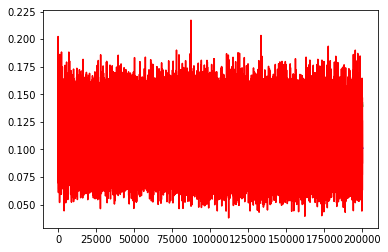

In [15]:
lr0 = 1
err_epoh = []
valid_err_epoh = []
test_err_epoh = []
for epoh in range(200000):
    print("epoh", epoh)
    err_acc = 0
    valid_err_acc = 0
    test_err_acc = 0
    lr = (lr0 + epoh)**(-1/3)
    for i_batch, data in enumerate(dataloader):
        #просчет производных
        loss = Quadratic_loss()
        
        inputs, labels = data[:,0], data[:,1]
        inputs = autograd.Variable((inputs).float()).unsqueeze(1)
        labels = autograd.Variable((labels).float()).unsqueeze(1)
        
        valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0]).float()).unsqueeze(1)
        valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, 1]).float()).unsqueeze(1)
        test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0]).float()).unsqueeze(1)
        test_labels = autograd.Variable(torch.from_numpy(test_data[:, 1]).float()).unsqueeze(1)
        
        predict_valid = net.forward(valid_inputs)
        
        valid_err_acc = loss.forward(predict_valid, valid_labels)
        predict_test = net.forward(test_inputs)
        test_err_acc = loss.forward(predict_test, test_labels)
        
        predict = net.forward(inputs) 
        err_acc = loss.forward(predict, labels)
        dz = loss.backward(1)
        net.backward(dz)
        
        #обновление параметров
        net.lin1.W.data = net.lin1.W.data - lr * net.lin1.dW.t().data
        net.lin1.b.data = net.lin1.b.data - lr * net.lin1.db.data
        net.lin2.W.data = net.lin2.W.data - lr * net.lin2.dW.t().data
        net.lin2.b.data = net.lin2.b.data - lr * net.lin2.db.data
    err_iter = torch.sum(err_acc).data.numpy()
    valid_err_iter = torch.sum(valid_err_acc).data.numpy()
    test_err_iter = torch.sum(test_err_acc).data.numpy()
    
    valid_err_epoh.append(valid_err_iter)
    test_err_epoh.append(test_err_iter)
    err_epoh.append(err_iter)
plt.plot(valid_err_epoh, color='b')
plt.plot(test_err_epoh, color='g')
plt.plot(err_epoh, color='r')
plt.savefig('train_valid_test.png', bbox_inches='tight')

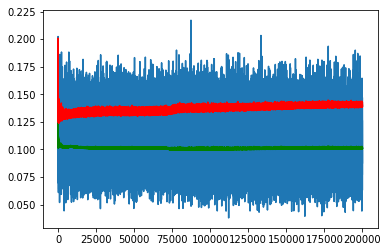

In [16]:
plt.plot(err_epoh)
plt.plot(valid_err_epoh, color='g')
plt.plot(test_err_epoh, color='r')

plt.savefig('train_valid_test.png', bbox_inches='tight')

In [17]:
print("train:")
print(max(err_epoh))
print(math.sqrt(np.var(err_epoh)))
print(math.sqrt(np.mean(err_epoh)))

print("valid:")
print(max(valid_err_epoh))
print(math.sqrt(np.var(valid_err_epoh)))
print(math.sqrt(np.mean(valid_err_epoh)))

print("test:")
print(max(test_err_epoh))
print(math.sqrt(np.var(test_err_epoh)))
print(math.sqrt(np.mean(test_err_epoh)))

train:
[0.21711947]
0.01857522326855837
0.33061821896354215
valid:
[0.1287921]
0.0006149966925984079
0.3177372288722309
test:
[0.20083971]
0.002906105410486254
0.36998434375166894


[-0.3480045] [0.48935175]


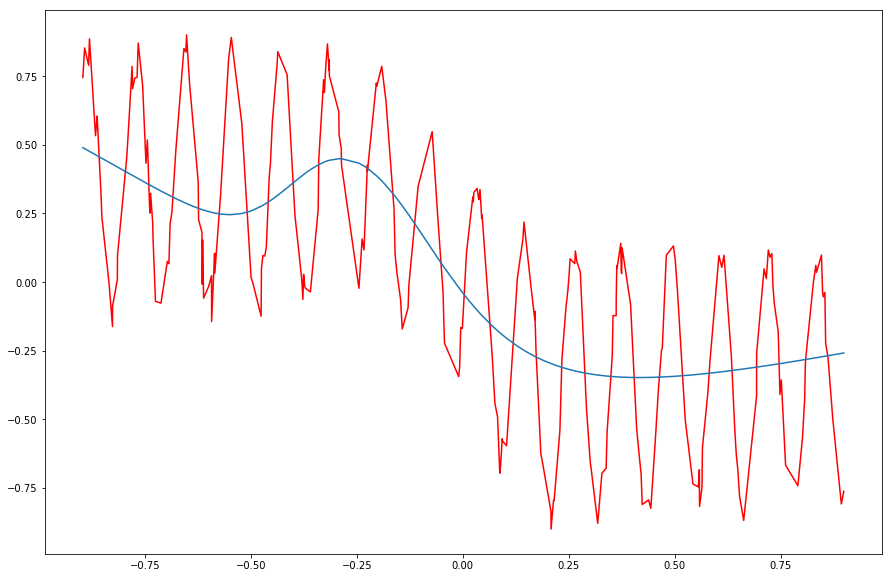

In [18]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)

x = autograd.Variable((torch.from_numpy(df_buf.get_values()[:, 0]).float()).unsqueeze(1))
y = net.forward(x)
x = x.data.numpy()
y = y.data.numpy()
print(min(y), max(y))
plt.figure(figsize=(15,10))
plt.plot(df_buf[0], df_buf[1], color='r')
plt.plot(x, y)
plt.savefig('after_training1.png', bbox_inches='tight')

# 